## A model build using TweetBERT to identify cause-effect pairs in sentences of tweets

The cause-effect pair sentence prediction model will be trained on the dataset which got augmented in an active learning approach in 5 steps.

Load already preprocessed file with sentence containing either cause or effect or both. Sentences labeled as Jokes, questions or having negations are removed.

IO tagging is used instead of BIO tagging. The assumption is that the attention mechanism already encodes information about the postion (B-.). In consequence the training should be simplified with only 3 classes: I-C, I-E, O

In [1]:
import pandas as pd
import numpy as np
import spacy 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from seqeval.metrics import classification_report as classification_report_seqeval
from transformers import BertForSequenceClassification, AutoTokenizer, AutoModelForTokenClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import random
import os
import torch.nn.functional as F
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import transformers
from tqdm import tqdm, trange
from utils import normalizeTweet, split_into_sentences, bio_tagging, EarlyStopping
import matplotlib.pyplot as plt
from ast import literal_eval
from torchcrf import CRF
%matplotlib inline

########################### Check if cuda available ############################
print("Cuda available: ", torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



########################### DATA FILE ###################################
dataPath = "data/cause_effect_sentences_with_IO_tags.csv"
#dataPath = "data/Causality_tweets_data.xlsx"
#dataPath = "Causality_tweets_data.xlsx"


########################### MODEL PARAMETERS ############################
lr = 1e-5 # earlier 1e-3    
adam_eps = 1e-8
epochs = 55
num_warmup_steps = 0
early_patience = 10 # earlier 5, how long to wait after last time validation loss improved

train_batch_size = 8
val_batch_size = 8
test_batch_size = 8
train_to_test_ratio = 0.9 # 10% test and 90% train
val_to_train_ratio = 0.2
type_ = "-"
attempt_ = "crf_weight_false"

bert_model = "vinai/bertweet-base" # "bert-large-uncased"; "roberta-large"

n_labels = 3 # 0, I-C, I-E
tag2id = {label: idx for idx, label in enumerate(["O", "I-C", "I-E"])}
tag2id[-100] = -100
id2tag = {id:tag for tag,id in tag2id.items()}

useClassWeights = False # apply class weights in the model (before the CRF layer)

# Options: https://pytorch-crf.readthedocs.io/en/stable/#torchcrf.CRF.forward
# - "sum" : output will be summed over batches
# - "mean" : output will be averaged over batches
# - "token_mean" : output will be averaged over tokens
# - None : no reduction
reduction_crf = "sum" 

# if True, only sentences containing both cause and effect are considered.
# if False, all sentences containing either cause or effect are considered
requireCauseAndEffect = True 

# Each token has its associated IO tag ("O", "I-C", "I-E").
# The Bertweet tokenizer splits words into sub-words
# if True => assign IO tag of word to all sub-words
# if False => assign IO tag of word to first sub-word and all other sub-words get -100 (loss function ignores this index)
subwordTagEqualFirstwordTag = False # @Vivek : keep it on False

metric_choice = "weighted" # micro, macro, samples or weighted 
# metrics_average = "binary" # this will give measure for class_1,i.e., causal class

# saveModelName = "./model-causal-span/cause-and-effect_model_1_finetuned-{}-epochs-lr_{}.pth".format(epochs, lr) # it should be epoch so that the name shows at what epoch teh mdel ws saved

Cuda available:  True


In [2]:
##### DATA TO LOAD ######

data = pd.read_csv(dataPath, sep=";", converters={"tokenized":literal_eval, "bio_tags":literal_eval})
print(data.shape)
data.head()

(2500, 7)


,sentence,Intent,Cause,Effect,Causal association,tokenized,bio_tags
0,USER Additionally the medicines are being char...,NaN,medicines are being charged at MRP,costing much higher,1.0,"[USER, Additionally, the, medicines, are, bein...","[O, O, O, I-C, I-C, I-C, I-C, I-C, I-C, O, O, ..."
1,"I hear "" I hate being a diabetic "" .",NaN,diabetic,hate,1.0,"[I, hear, "", I, hate, being, a, diabetic, "", .]","[O, O, O, O, I-E, O, O, I-C, O, O]"
2,"i got lime for my glucose test , was n't that ...",NaN,glucose test,nauseous,1.0,"[i, got, lime, for, my, glucose, test, ,, was,...","[O, O, O, O, O, I-C, I-C, O, O, O, O, O, O, O,..."
3,Sounds like Willow 's blood sugar level is rea...,NaN,blood sugar level is real low,reduce her insulin shots,1.0,"[Sounds, like, Willow, 's, blood, sugar, level...","[O, O, O, O, I-C, I-C, I-C, I-C, I-C, I-C, O, ..."
4,USER I 've always found it too sweet mustvsay ...,NaN,dreaded diabetes,sauces are used sparingly,1.0,"[USER, I, 've, always, found, it, too, sweet, ...","[O, O, O, O, O, O, O, O, O, O, O, O, I-E, I-E,..."


## Preprocessing

In [3]:
############ Choose only sentences with both cause and effect or only sentences with either cause or effect (or both) #######


if requireCauseAndEffect: # cause and effect in sentence
    dataSentFiltered = data[(data["Cause"].notnull()) & (data["Effect"].notnull())]
else: # cause or effect or both in sentence
    dataSentFiltered = data[(data["Cause"].notnull()) | (data["Effect"].notnull())]

print(dataSentFiltered.shape)
dataSentFiltered.head()

(2118, 7)


,sentence,Intent,Cause,Effect,Causal association,tokenized,bio_tags
0,USER Additionally the medicines are being char...,NaN,medicines are being charged at MRP,costing much higher,1.0,"[USER, Additionally, the, medicines, are, bein...","[O, O, O, I-C, I-C, I-C, I-C, I-C, I-C, O, O, ..."
1,"I hear "" I hate being a diabetic "" .",NaN,diabetic,hate,1.0,"[I, hear, "", I, hate, being, a, diabetic, "", .]","[O, O, O, O, I-E, O, O, I-C, O, O]"
2,"i got lime for my glucose test , was n't that ...",NaN,glucose test,nauseous,1.0,"[i, got, lime, for, my, glucose, test, ,, was,...","[O, O, O, O, O, I-C, I-C, O, O, O, O, O, O, O,..."
3,Sounds like Willow 's blood sugar level is rea...,NaN,blood sugar level is real low,reduce her insulin shots,1.0,"[Sounds, like, Willow, 's, blood, sugar, level...","[O, O, O, O, I-C, I-C, I-C, I-C, I-C, I-C, O, ..."
4,USER I 've always found it too sweet mustvsay ...,NaN,dreaded diabetes,sauces are used sparingly,1.0,"[USER, I, 've, always, found, it, too, sweet, ...","[O, O, O, O, O, O, O, O, O, O, O, O, I-E, I-E,..."


(array([137., 494., 672., 402., 179., 115.,  79.,  30.,   9.,   1.]),
 array([ 3. , 10.2, 17.4, 24.6, 31.8, 39. , 46.2, 53.4, 60.6, 67.8, 75. ]),
 <BarContainer object of 10 artists>)

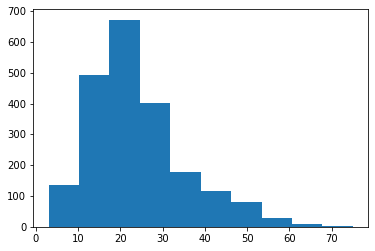

In [4]:
########## Distribution of sentences length ########################

# get length of all the messages in the train set
seq_len = [len(i.split()) for i in dataSentFiltered["sentence"]]
plt.hist(seq_len)
#pd.Series(seq_len).hist(bins = 30)

## Training

In [5]:
trainingDataSample = dataSentFiltered#.sample(n=100)   # Only for testing
train = trainingDataSample.sample(frac=train_to_test_ratio, random_state=0)
test = trainingDataSample.drop(train.index)
validate = train.sample(frac=val_to_train_ratio, random_state=0)
train = train.drop(validate.index)
print("Train:", train.shape)
print("Validate:", validate.shape)
print("Test:", test.shape)

Train: (1525, 7)
Validate: (381, 7)
Test: (212, 7)


In [6]:
######### BERTWEET TOKENIZER + PYTORCH DATASET/DATALOADER STRUCTURE ##################

class TweetDataSet(torch.utils.data.Dataset):
    def __init__(self, text, labels, bio_tags, tokenizer):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer
        self.bio_tags = bio_tags


    def __getitem__(self, idx):
        inputs = self.tokenizer(self.text, padding=True, truncation=True, return_token_type_ids=True)
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]     
        bio_tags_extended = self.extend_tags(self.text[idx], self.bio_tags[idx], ids[idx])

        assert len(ids[idx]) == len(bio_tags_extended), "token ids (N: {}) and IO tags (N: {}) lengths do not match!\nids[idx]: {}\nbio_tags: {}".format(len(ids[idx]), len(bio_tags_extended), ids[idx], bio_tags_extended)
        return {
                "input_ids" : torch.tensor(ids[idx], dtype=torch.long)
              , "attention_mask" : torch.tensor(mask[idx], dtype=torch.long)
              , "token_type_ids" : torch.tensor(token_type_ids[idx], dtype=torch.long)
              , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
              , "bio_tags" : torch.tensor(list(map(lambda bioTags: tag2id[bioTags], bio_tags_extended))
, dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)

    
    def extend_tags(self, tokens_old, tags_old, ids_tokenized_padded):
        """ 
            Each token has a IO tag label. 
            However BERT's tokenization splits tokens into subwords. How to label those subwords?
            
            Option 1:
            ---------
            
            add the same label to each subword than the first subword
            Ex. 
            #lowbloodsugar => '#low@@', 'blood@@', 'sugar@@'
               "I-C"       =>   "I-C" ,   "I-C"  ,   "I-C"
            
            Option 2:      
            ---------
            
            From : https://huggingface.co/transformers/custom_datasets.html#token-classification-with-w-nut-emerging-entities
            A common obstacle with using pre-trained models for token-level classification: many of the tokens in
            the W-NUT corpus are not in DistilBert’s vocabulary. Bert and many models like it use a method called 
            WordPiece Tokenization, meaning that single words are split into multiple tokens such that each token
            is likely to be in the vocabulary. For example, DistilBert’s tokenizer would split the Twitter 
            handle @huggingface into the tokens ['@', 'hugging', '##face']. This is a problem for us because we 
            have exactly one tag per token. If the tokenizer splits a token into multiple sub-tokens, then we will
            end up with a mismatch between our tokens and our labels.

            One way to handle this is to only train on the tag labels for the first subtoken of a split token. 
            We can do this in 🤗 Transformers by setting the labels we wish to ignore to -100. 
            In the example above, if the label for @HuggingFace is 3 (indexing B-corporation), we would set 
            the labels of ['@', 'hugging', '##face'] to [3, -100, -100].
        """
        tags = [-100] # add for start token <CLS>
        for token_old, tag in zip(tokens_old.split(" "), tags_old):
            #print(F"\ntoken_old: {token_old};    tag: {tag}")
            for i, sub_token in enumerate(self.tokenizer.tokenize(token_old)):
                if (i == 0): # first sub token of a word keeps the original bio tag
                    firstTag = tag
                    tags.append(tag)
                    #print(F"\tsubToken: {sub_token};    tag: {tag}")
                else: 
                    if subwordTagEqualFirstwordTag: # the other sub tokens get the first bio tag than the first sub token
                        tags.append(firstTag)
                    #    print(F"\tsubToken: {sub_token};    tag: {firstTag}")
                    else: # to other sub tokens get the tag -100 (ignored in loss function)
                        tags.append(-100)
                    #    print(F"\tsubToken: {sub_token};    tag: {-100}")

        tags.append(-100) # 0 for end of sentence token
    
        # append -100 for all padded elements
        padded_elements = ids_tokenized_padded.count(1) # id 1 is <PAD> ; Alternative: where attention_mask == 0 add -100
        tags.extend([-100]*padded_elements)
        #print("\tpadded_elements:", ids_tokenized_padded.count(1))
        return tags
        
        
    
tokenizer = AutoTokenizer.from_pretrained(bert_model, padding = "max_length", truncation = True, max_length = 60 )


train_dataset = TweetDataSet(train["sentence"].values.tolist()
                           , train["Causal association"].values.tolist()
                           , train["bio_tags"].values.tolist()
                           , tokenizer)
val_dataset = TweetDataSet(validate["sentence"].values.tolist()
                           , validate["Causal association"].values.tolist()
                           , validate["bio_tags"].values.tolist()
                           , tokenizer)
test_dataset = TweetDataSet(test["sentence"].values.tolist()
                           , test["Causal association"].values.tolist()
                           , test["bio_tags"].values.tolist()
                           , tokenizer)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# put data to batches
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1525
381
212


In [7]:
############ class weights #####################

# Since -100 will anyway be ignored by loss func, drop it
train_bio_tags = np.hstack([t["bio_tags"][t["bio_tags"]!=-100].numpy() for t in train_dataset])
print("train_bio_tags:", train_bio_tags)

train_bio_tags_count_info = (pd.Series(train_bio_tags).value_counts(normalize=True))
print("train_bio_tags_count_info:", train_bio_tags_count_info)

# for class-imbalanced dataset, the class weight for a ith class
# to be specified for balancing in the loss function is given by:
# weight[i] = num_samples / (num_classes * num_samples[i])
# since train_bio_tags_count_info obtained above has fraction of 
# samples for ith class, hence the corresponding weight calculation is:
class_weight = (1/train_bio_tags_count_info)/len(train_bio_tags_count_info)
class_weight = class_weight[sorted(class_weight.index)]
class_weight


<ipython-input-6-a7b5e9115285>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


train_bio_tags: [0 0 0 ... 1 1 0]
train_bio_tags_count_info: 0    0.801340
2    0.106704
1    0.091957
dtype: float64


0    0.415970
1    3.624900
2    3.123913
dtype: float64

## Evaluation metrics

In [8]:
def compute_metrics(pred, labels):
    """
        Dataset is unbalanced -> measure weighted metrics
        Calculate metrics for each label, and find their average wieghted by support (Number of true instances for each label)
        This alters 'macro' to account for label imbalance;
        it can result in an F-Score taht is not between precision and recall
    """
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average= metric_choice) # TODO: check weightin
    acc = accuracy_score(labels, pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


## Model definition

In [9]:
class CausalNER(torch.nn.Module):
    """ Model Bert"""
    def __init__(self):
        super(CausalNER, self).__init__()
        self.bert = transformers.BertModel.from_pretrained("vinai/bertweet-base")
        self.dropout = torch.nn.Dropout(0.3)
        self.linear1 = torch.nn.Linear(768, 256)
        self.linear2 = torch.nn.Linear(256, n_labels)
        self.softmax = torch.nn.Softmax(-1)
        self.crf = CRF(num_tags=n_labels, batch_first=True)
        
    def forward(self, input_ids, attention_mask, token_type_ids, tags=None, mask_tags_without_CLS=None):
#        _, output_1 = self.bert(input_ids, attention_mask = attention_mask, token_type_ids=token_type_ids, return_dict=False) # if output 1 is our cls token
        output_seq, _ = self.bert(input_ids, attention_mask = attention_mask, token_type_ids=token_type_ids, return_dict=False) # if output 1 is our cls token
        output_2 = self.dropout(output_seq)
        output_3 = self.linear1(output_2)
        output_4 = self.dropout(output_3)
        output_5 = self.linear2(output_4)
        #print("\toutput_5:", output_5.shape)
        
        # Add class weights on logits before the CRF layer. It is experimental, based on: https://github.com/kmkurn/pytorch-crf/issues/47
        if useClassWeights:
            output_5 = torch.stack((output_5[:, :, 0] * class_weight[0]
                                    , output_5[:, :, 1] * class_weight[1]
                                    , output_5[:, :, 2] * class_weight[2] ), dim=2)

        if tags is not None:
            # to avoid this error from the pytorch-crf package: ValueError: mask of the first timestep must all be on
            # delete [CLS] token of every phrase and first token of mask.
            tags_without_CLS = torch.cat([tags[i][1:] for i in range(len(tags))]).view(tags.shape[0],-1)

            logits_without_CLS = torch.cat([output_5[i][1:] for i in range(len(output_5))]).view(tags.shape[0],-1,n_labels)
            tags_without_CLS[tags_without_CLS==-100] = 0 # replace all -100 by 0. This is a requirement for crf. But by using the mask, those values are ignored anyways
            loss = self.crf(emissions=logits_without_CLS, tags=tags_without_CLS, mask=mask_tags_without_CLS)
            sequence_of_tags = self.crf.decode(emissions=logits_without_CLS, mask=mask_tags_without_CLS)
           
            return loss, sequence_of_tags
        else:
            sequence_of_tags = self.crf.decode(output_5)
            return sequence_of_tags


In [10]:
model = CausalNER()
model.to(device)

# fine-tune only the task-specific parameters 
for param in model.bert.parameters():
    param.requires_grad = False
#     param[:-1].requires_grad = False
#     param[-1].requires_grad = True

num_training_steps = np.ceil(len(train_dataset)/train_batch_size)*epochs
optim = AdamW(model.parameters(), lr=lr, eps=adam_eps)
# scheduler with a linearly decreasing learning rate from the initial lr set in the optimizer to 0;
# after a warmup period during which it increases linearly from to the initial lr set in the optimizer
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps) 


## adding weight to the loss function 
#loss_fn = CrossEntropyLoss(
#    weight=torch.tensor(class_weight.to_list()).to(device),
#    ignore_index=-100 # ignore subwords/tokens with label -100 
#)

#loss_fn = CrossEntropyLoss(ignore_index=-100)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['roberta.encoder.layer.4.attention.self.key.weight', 'roberta.embeddings.word_embeddings.weight', 'roberta.encoder.layer.5.attention.self.query.bias', 'roberta.encoder.layer.0.attention.self.key.weight', 'roberta.encoder.layer.7.attention.output.dense.bias', 'roberta.encoder.layer.11.attention.output.dense.weight', 'roberta.encoder.layer.3.attention.output.dense.weight', 'roberta.encoder.layer.5.intermediate.dense.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.0.output.dense.weight', 'roberta.encoder.layer.7.output.dense.weight', 'roberta.encoder.layer.11.intermediate.dense.weight', 'roberta.encoder.layer.4.attention.output.dense.weight', 'roberta.encoder.layer.6.attention.self.value.bias', 'rob

Some weights of BertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['encoder.layer.5.attention.self.key.weight', 'encoder.layer.2.attention.self.query.weight', 'encoder.layer.7.attention.self.query.weight', 'encoder.layer.7.intermediate.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.3.attention.self.value.bias', 'encoder.layer.9.attention.output.dense.weight', 'encoder.layer.1.attention.self.query.weight', 'embeddings.LayerNorm.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.9.attention.self.query.bias', 'encoder.layer.5.attention.output.dense.bias', 'encoder.layer.2.attention.self.key.weight', 'encoder.layer.2.attention.output.dense.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.7.attention.output.dense.weight', 'encoder.layer.4.output.dense.weight', 'encoder.layer.3.attention.output.dense.bias', 'encoder.layer.

In [11]:
################ TRAINING ######################

# initialise the early_stopping object
early_stopping = EarlyStopping(patience=early_patience, verbose=True)

train_avg_loss = [] # avg training loss per epoch
val_avg_loss = [] # avg validation loss per epoch
train_avg_acc = [] # avg training accuracy per epoch
val_avg_acc = [] # avg val accuracy per epoch
n_trained_epochs = 0

for epoch in trange(1, epochs+1, desc='Epoch'):
    print("<" + "="*22 + F" Epoch {epoch} "+ "="*22 + ">")

    
    ############ training eval metrics ######################
    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    train_f1 = []
    
    #########################################################
    
    
    for batch in tqdm(train_loader):
        optim.zero_grad() # gradients get accumulated by default -> clear previous accumulated gradients
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch['labels'].to(device)
        bio_tags = batch['bio_tags'].to(device)
        
        # crf in model requires to start with a positive mask label => ignore first token [CLS]
        bio_tags_without_CLS = torch.cat([bio_tags[i][1:] for i in range(len(bio_tags))]).view(bio_tags.shape[0],-1)
        mask_tags_without_CLS = torch.cat([bio_tags[i][1:] != -100 for i in range(len(bio_tags))]).view(bio_tags.shape[0],-1).byte().to(device) # byte() casts boolean tensor to tensor with 1 and 0 


        ################################################
        model.train() # set model to training mode
#        logits = model(**{"input_ids":input_ids, "attention_mask":attention_mask, "token_type_ids":token_type_ids}) # forward pass
        log_likelihood, sequence_of_tags = model(**{"input_ids":input_ids
                        , "attention_mask":attention_mask
                        , "token_type_ids":token_type_ids
                        , "tags":bio_tags
                        , "mask_tags_without_CLS":mask_tags_without_CLS}) # forward pass        

        ################################################ 
        loss = -1 * log_likelihood           
        print("loss:", loss)     
        loss.backward() # backward pass
        ## gradient clipping to control the exploding gradient problem 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optim.step()    # update parameters and take a steup using the computed gradient
        scheduler.step()# update learning rate scheduler
        train_loss.append(loss.item())
        
    

        ################## Training Performance Measures ##########
        bio_tags_without_CLS = bio_tags_without_CLS.detach().to("cpu").numpy()
        mask_tags_without_CLS = mask_tags_without_CLS.detach().to("cpu").numpy()
        
        tags_ids = bio_tags.to('cpu').numpy()
        true_tags = bio_tags_without_CLS[mask_tags_without_CLS.astype(bool)] # get Bio tags for tokens only
        pred = [item for elem in sequence_of_tags for item in elem] # flatten list of lists

        metrics = compute_metrics(pred, true_tags)
        train_acc.append(metrics["accuracy"])
        train_prec.append(metrics["precision"])
        train_rec.append(metrics["recall"])
        train_f1.append(metrics["f1"])
                          
    train_avg_loss.append(np.mean(train_loss))
    train_avg_acc.append(np.mean(train_acc))           
    print(F'\n\tTraining Loss: {np.mean(train_loss)}')
    print(F'\n\tTraining acc: {np.mean(train_acc)}')
    print(F'\n\tTraining prec: {np.mean(train_prec)}')
    print(F'\n\tTraining rec: {np.mean(train_rec)}')
    print(F'\n\tTraining f1: {np.mean(train_f1)}')

    n_trained_epochs += 1

                          
    ###################################################################################

    
    ## ---- Validation ------    
    val_accuracy = []
    val_loss = []
    val_acc = []
    val_prec = []
    val_rec = []
    val_f1 = []

    # Evaluate data for one epoch
    for batch in tqdm(validation_loader):
        batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
        v_input_ids, v_input_mask, v_token_type_ids, v_labels, v_bio_tags = batch  # unpack inputs from dataloader

        # crf in model requires to start with a positive mask label => ignore first token [CLS]
        v_mask_tags_without_CLS = torch.cat([v_bio_tags[i][1:] != -100 for i in range(len(v_bio_tags))]).view(v_bio_tags.shape[0],-1).byte() # byte() casts boolean tensor to tensor with 1 and 0         
        v_bio_tags_without_CLS = torch.cat([v_bio_tags[i][1:] for i in range(len(v_bio_tags))]).view(v_bio_tags.shape[0],-1)
   
        with torch.no_grad(): # tell model not to compute or store gradients -> saves memory + speeds up validation
            model.eval() # put model in evaluation mode for validation set
            #logits = model(**{"input_ids":v_input_ids, "attention_mask":v_input_mask, "token_type_ids":v_token_type_ids}) # forward pass, calculates logit predictions
            log_likelihood, sequence_of_tags = model(**{"input_ids":v_input_ids
                                                    , "attention_mask":v_input_mask
                                                    , "token_type_ids":v_token_type_ids
                                                    , "tags": v_bio_tags
                                                    , "mask_tags_without_CLS":v_mask_tags_without_CLS}) # forward pass, calculates logit predictions
        ######################################################
          
        v_loss = -1 * log_likelihood        
        val_loss.append(v_loss.item())
              
        #########################################################
        # calculate performance measures only on tokens and not subwords or special tokens       
        v_bio_tags_without_CLS = v_bio_tags_without_CLS.detach().to("cpu").numpy()
        v_mask_tags_without_CLS = v_mask_tags_without_CLS.detach().to("cpu").numpy()
        #sequence_of_tags = sequence_of_tags.detach().to("cpu").numpy()
        
        true_tags = v_bio_tags_without_CLS[v_mask_tags_without_CLS.astype(bool)] # get Bio tags for tokens only
        pred = [item for elem in sequence_of_tags for item in elem] # flatten list of lists
        
        metrics = compute_metrics(pred, true_tags)
        val_acc.append(metrics["accuracy"])
        val_prec.append(metrics["precision"])
        val_rec.append(metrics["recall"])
        val_f1.append(metrics["f1"])
                              
    val_avg_loss.append(np.mean(val_loss))
    val_avg_acc.append(np.mean(val_acc))        
    print(F'\n\tValidation Loss: {np.mean(val_loss)}')
    print(F'\n\tValidation acc: {np.mean(val_acc)}')
    print(F'\n\tValidation prec: {np.mean(val_prec)}')
    print(F'\n\tValidation rec: {np.mean(val_rec)}')
    print(F'\n\tValidation f1: {np.mean(val_f1)}')

    # early_stopping needs the validation loss to check if it has decreased,
    # and if it has, it will make a checkpoint of the current model
#     saveModelName = "./model-causal-span/{}_model_{}_finetuned-{}-epochs-lr_{}.pth".format(type_, attempt_, n_trained_epochs-early_patience, lr) 
#     early_stopping.path = saveModelName
#     early_stopping(np.average(val_loss), model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        saveModelName = "./model-causal-span/{}_model_{}_finetuned-{}-epochs-lr_{}.pth".format(type_, attempt_, n_trained_epochs-early_patience, lr) 
        early_stopping.path = saveModelName
        early_stopping(np.average(val_loss), model)
    
#         break

#n_labels: 3
#len(tags): 8
#len(tags[0]): 67
#tags_without_CLS:  torch.Size([8, 66])
#logits_without_CLS:  torch.Size([8, 66, 3])
#mask_tags_without_CLS: torch.Size([8, 66])

Epoch:   0%|          | 0/55 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>



  0%|          | 0/191 [00:00<?, ?it/s]<ipython-input-6-a7b5e9115285>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/torchcrf/__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/TensorCompare.cpp:255.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)

  1%|          | 1/191 [00:01<04:48,  1.52s/it]

loss: tensor(185.1835, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:02<03:41,  1.17s/it]

loss: tensor(260.5503, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:03<03:12,  1.02s/it]

loss: tensor(192.9025, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:04<03:05,  1.01it/s]

loss: tensor(212.4151, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:05<02:59,  1.03it/s]

loss: tensor(232.4561, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:06<02:51,  1.08it/s]

loss: tensor(180.6721, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:50,  1.08it/s]

loss: tensor(206.7502, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:48,  1.09it/s]

loss: tensor(191.0251, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:46,  1.09it/s]

loss: tensor(197.1135, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:45,  1.09it/s]

loss: tensor(186.3433, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:10<02:40,  1.12it/s]

loss: tensor(193.4954, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:11<02:40,  1.12it/s]

loss: tensor(209.5469, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:12<02:40,  1.11it/s]

loss: tensor(185.2196, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:13<02:35,  1.14it/s]

loss: tensor(159.1820, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:14<02:36,  1.13it/s]

loss: tensor(161.3560, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:36,  1.12it/s]

loss: tensor(187.3575, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:36,  1.11it/s]

loss: tensor(165.4110, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:36,  1.11it/s]

loss: tensor(195.3483, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:31,  1.14it/s]

loss: tensor(184.3235, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:32,  1.12it/s]

loss: tensor(168.1216, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:19<02:32,  1.12it/s]

loss: tensor(179.5632, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:20<02:31,  1.11it/s]

loss: tensor(132.5105, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:21<02:27,  1.14it/s]

loss: tensor(172.7751, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:22<02:28,  1.13it/s]

loss: tensor(181.2867, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:28,  1.12it/s]

loss: tensor(164.8415, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:28,  1.11it/s]

loss: tensor(160.2869, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:24,  1.14it/s]

loss: tensor(166.9456, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:25,  1.12it/s]

loss: tensor(161.5785, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:24,  1.12it/s]

loss: tensor(147.6211, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:24,  1.11it/s]

loss: tensor(166.7993, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:28<02:20,  1.14it/s]

loss: tensor(153.6612, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:29<02:20,  1.13it/s]

loss: tensor(120.2744, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:30<02:20,  1.12it/s]

loss: tensor(130.5925, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:31<02:20,  1.12it/s]

loss: tensor(139.6176, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:16,  1.14it/s]

loss: tensor(159.9893, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:17,  1.13it/s]

loss: tensor(150.5562, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:17,  1.12it/s]

loss: tensor(182.9303, device='cuda:0', grad_fn=<MulBackward0>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|█▉        | 38/191 [00:34<02:17,  1.11it/s]

loss: tensor(140.8925, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:13,  1.14it/s]

loss: tensor(141.9445, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:14,  1.13it/s]

loss: tensor(135.1530, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:37<02:13,  1.12it/s]

loss: tensor(139.6262, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:38<02:13,  1.12it/s]

loss: tensor(133.4978, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:09,  1.15it/s]

loss: tensor(122.4409, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:09,  1.13it/s]

loss: tensor(139.6324, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:09,  1.12it/s]

loss: tensor(143.4040, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:09,  1.12it/s]

loss: tensor(152.1903, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:05,  1.14it/s]

loss: tensor(107.1364, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:06,  1.13it/s]

loss: tensor(150.5302, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:05,  1.13it/s]

loss: tensor(121.7409, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:05,  1.12it/s]

loss: tensor(150.1208, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:46<02:02,  1.15it/s]

loss: tensor(134.1153, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:02,  1.13it/s]

loss: tensor(129.4840, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:02,  1.12it/s]

loss: tensor(149.7429, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:02,  1.12it/s]

loss: tensor(151.1949, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<01:59,  1.14it/s]

loss: tensor(166.3353, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<01:59,  1.13it/s]

loss: tensor(148.4756, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<01:59,  1.12it/s]

loss: tensor(108.5038, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:59,  1.12it/s]

loss: tensor(139.8255, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:55,  1.14it/s]

loss: tensor(124.9952, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:56,  1.13it/s]

loss: tensor(110.7912, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:56,  1.12it/s]

loss: tensor(89.1471, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:55,  1.11it/s]

loss: tensor(146.3490, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:55,  1.11it/s]

loss: tensor(105.4774, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:52,  1.13it/s]

loss: tensor(118.7655, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:52,  1.12it/s]

loss: tensor(120.6641, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.11it/s]

loss: tensor(147.7753, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:49,  1.14it/s]

loss: tensor(179.6874, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:49,  1.13it/s]

loss: tensor(126.6031, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:48,  1.12it/s]

loss: tensor(144.7978, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:48,  1.11it/s]

loss: tensor(117.2305, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:47,  1.11it/s]

loss: tensor(116.4430, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:44,  1.14it/s]

loss: tensor(117.2680, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:44,  1.13it/s]

loss: tensor(137.4418, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:44,  1.12it/s]

loss: tensor(121.7226, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:44,  1.12it/s]

loss: tensor(119.4641, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:41,  1.14it/s]

loss: tensor(118.1138, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:41,  1.13it/s]

loss: tensor(136.3921, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:41,  1.12it/s]

loss: tensor(122.8952, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:40,  1.11it/s]

loss: tensor(110.6593, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:37,  1.14it/s]

loss: tensor(132.8323, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:37,  1.13it/s]

loss: tensor(140.7562, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:37,  1.12it/s]

loss: tensor(81.1996, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:36,  1.11it/s]

loss: tensor(132.4026, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:34,  1.14it/s]

loss: tensor(131.4726, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:34,  1.12it/s]

loss: tensor(128.1024, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:34,  1.12it/s]

loss: tensor(132.9410, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:33,  1.11it/s]

loss: tensor(156.6576, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:30,  1.14it/s]

loss: tensor(155.3242, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:30,  1.12it/s]

loss: tensor(138.8586, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:30,  1.12it/s]

loss: tensor(125.7203, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:29,  1.11it/s]

loss: tensor(126.8523, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:26,  1.14it/s]

loss: tensor(108.7876, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:27,  1.13it/s]

loss: tensor(114.7751, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:26,  1.12it/s]

loss: tensor(135.2290, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:26,  1.11it/s]

loss: tensor(106.5758, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:23,  1.14it/s]

loss: tensor(115.3657, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:23,  1.13it/s]

loss: tensor(93.8302, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:23,  1.12it/s]

loss: tensor(104.2223, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:22,  1.11it/s]

loss: tensor(160.4472, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:20,  1.14it/s]

loss: tensor(140.2248, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:19,  1.13it/s]

loss: tensor(114.4668, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.12it/s]

loss: tensor(126.5028, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:18,  1.12it/s]

loss: tensor(104.7550, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:16,  1.14it/s]

loss: tensor(119.2949, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:16,  1.13it/s]

loss: tensor(169.0964, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:15,  1.12it/s]

loss: tensor(129.0551, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:15,  1.12it/s]

loss: tensor(145.3153, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:12,  1.14it/s]

loss: tensor(105.8407, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:12,  1.13it/s]

loss: tensor(124.4487, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:12,  1.12it/s]

loss: tensor(117.5618, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:11,  1.12it/s]

loss: tensor(155.7353, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:09,  1.14it/s]

loss: tensor(134.7641, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:09,  1.13it/s]

loss: tensor(102.4724, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:08,  1.12it/s]

loss: tensor(108.7511, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:42<01:07,  1.12it/s]

loss: tensor(112.6844, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:43<01:07,  1.11it/s]

loss: tensor(139.9617, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:05,  1.14it/s]

loss: tensor(95.3716, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:04,  1.13it/s]

loss: tensor(138.3603, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:04,  1.12it/s]

loss: tensor(143.7919, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:02,  1.14it/s]

loss: tensor(103.0332, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:01,  1.13it/s]

loss: tensor(116.8953, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:01,  1.12it/s]

loss: tensor(118.1372, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:01,  1.11it/s]

loss: tensor(135.5598, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.11it/s]

loss: tensor(134.1187, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:51<00:58,  1.13it/s]

loss: tensor(147.8064, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:52<00:57,  1.12it/s]

loss: tensor(129.7028, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:57,  1.12it/s]

loss: tensor(124.5691, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:56,  1.11it/s]

loss: tensor(138.5696, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:54,  1.14it/s]

loss: tensor(115.7231, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.13it/s]

loss: tensor(114.5823, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:53,  1.12it/s]

loss: tensor(120.2781, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:53,  1.11it/s]

loss: tensor(104.6764, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:58<00:51,  1.13it/s]

loss: tensor(162.2029, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:59<00:50,  1.12it/s]

loss: tensor(122.3690, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:00<00:50,  1.12it/s]

loss: tensor(94.3148, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:49,  1.11it/s]

loss: tensor(133.7796, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:47,  1.14it/s]

loss: tensor(123.8137, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.13it/s]

loss: tensor(127.4656, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.12it/s]

loss: tensor(80.1015, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.11it/s]

loss: tensor(114.1726, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:43,  1.14it/s]

loss: tensor(84.6336, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:06<00:43,  1.13it/s]

loss: tensor(144.2531, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:07<00:42,  1.12it/s]

loss: tensor(123.4406, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:08<00:42,  1.11it/s]

loss: tensor(127.6617, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:09<00:40,  1.14it/s]

loss: tensor(112.3287, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:40,  1.12it/s]

loss: tensor(133.0493, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.12it/s]

loss: tensor(175.1401, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.11it/s]

loss: tensor(122.1114, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:36,  1.14it/s]

loss: tensor(116.5364, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:36,  1.13it/s]

loss: tensor(143.8305, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.12it/s]

loss: tensor(145.2664, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:15<00:35,  1.11it/s]

loss: tensor(119.0188, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:16<00:33,  1.13it/s]

loss: tensor(170.6564, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:17<00:33,  1.12it/s]

loss: tensor(160.1285, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:32,  1.11it/s]

loss: tensor(107.6999, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:31,  1.10it/s]

loss: tensor(147.4946, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.13it/s]

loss: tensor(151.8135, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.12it/s]

loss: tensor(108.9063, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.11it/s]

loss: tensor(140.3828, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.11it/s]

loss: tensor(143.1939, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:23<00:26,  1.14it/s]

loss: tensor(135.2184, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:24<00:25,  1.13it/s]

loss: tensor(140.0141, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:25<00:25,  1.12it/s]

loss: tensor(127.8305, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:26<00:24,  1.11it/s]

loss: tensor(141.2603, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:22,  1.14it/s]

loss: tensor(123.1265, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.13it/s]

loss: tensor(103.3340, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.12it/s]

loss: tensor(87.9363, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.11it/s]

loss: tensor(81.6586, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.11it/s]

loss: tensor(148.4271, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:31<00:18,  1.14it/s]

loss: tensor(109.6329, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:32<00:17,  1.13it/s]

loss: tensor(114.3210, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:33<00:17,  1.12it/s]

loss: tensor(131.9030, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:34<00:15,  1.14it/s]

loss: tensor(112.7098, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:35<00:15,  1.13it/s]

loss: tensor(114.8638, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.12it/s]

loss: tensor(102.7050, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.11it/s]

loss: tensor(88.3464, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.11it/s]

loss: tensor(168.4227, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.13it/s]

loss: tensor(133.0383, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.12it/s]

loss: tensor(137.1969, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:40<00:09,  1.11it/s]

loss: tensor(113.9434, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:41<00:09,  1.11it/s]

loss: tensor(111.6993, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:42<00:07,  1.13it/s]

loss: tensor(147.0552, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:43<00:07,  1.12it/s]

loss: tensor(122.1164, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:44<00:06,  1.11it/s]

loss: tensor(108.9414, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.10it/s]

loss: tensor(138.0712, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.13it/s]

loss: tensor(121.1212, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:47<00:03,  1.12it/s]

loss: tensor(109.6670, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.11it/s]

loss: tensor(97.9573, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.10it/s]

loss: tensor(132.1756, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:49<00:00,  1.13it/s]

loss: tensor(134.5582, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(71.9490, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 136.47486973308145

	Training acc: 0.7549841808353513

	Training prec: 0.6465393741174164

	Training rec: 0.7549841808353513

	Training f1: 0.6885281489918178



Epoch:   2%|▏         | 1/55 [03:01<2:43:08, 181.26s/it]


	Validation Loss: 123.14916356404622

	Validation acc: 0.7992877925960912

	Validation prec: 0.6408563994199346

	Validation rec: 0.7992877925960912

	Validation f1: 0.7108184067046599
<====================== Epoch 2 ======================>



  1%|          | 1/191 [00:00<02:52,  1.10it/s]

loss: tensor(112.8943, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:52,  1.09it/s]

loss: tensor(106.4316, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:51,  1.10it/s]

loss: tensor(102.8943, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:45,  1.13it/s]

loss: tensor(140.7950, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:46,  1.12it/s]

loss: tensor(119.3117, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:46,  1.11it/s]

loss: tensor(109.0766, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:41,  1.14it/s]

loss: tensor(158.7719, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:43,  1.12it/s]

loss: tensor(183.6888, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:43,  1.11it/s]

loss: tensor(147.0967, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:43,  1.11it/s]

loss: tensor(148.3252, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:43,  1.10it/s]

loss: tensor(125.7341, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:38,  1.13it/s]

loss: tensor(104.8106, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:39,  1.11it/s]

loss: tensor(106.6212, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:40,  1.10it/s]

loss: tensor(133.1115, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:40,  1.10it/s]

loss: tensor(93.6216, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:36,  1.12it/s]

loss: tensor(110.9729, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:37,  1.11it/s]

loss: tensor(110.1295, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:37,  1.10it/s]

loss: tensor(81.4116, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:37,  1.09it/s]

loss: tensor(114.8305, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:33,  1.12it/s]

loss: tensor(116.7910, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:33,  1.11it/s]

loss: tensor(102.1952, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:33,  1.10it/s]

loss: tensor(131.2028, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:33,  1.10it/s]

loss: tensor(122.0655, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:28,  1.12it/s]

loss: tensor(132.0155, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:29,  1.11it/s]

loss: tensor(132.1557, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:29,  1.10it/s]

loss: tensor(135.7314, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:28,  1.10it/s]

loss: tensor(122.0131, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:24,  1.12it/s]

loss: tensor(108.8293, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:25,  1.11it/s]

loss: tensor(100.7639, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:25,  1.11it/s]

loss: tensor(138.2490, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:25,  1.10it/s]

loss: tensor(119.6815, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:21,  1.12it/s]

loss: tensor(110.8501, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:22,  1.11it/s]

loss: tensor(142.3372, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:22,  1.10it/s]

loss: tensor(126.2570, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:22,  1.10it/s]

loss: tensor(133.5823, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:18,  1.12it/s]

loss: tensor(120.3087, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:19,  1.11it/s]

loss: tensor(124.4357, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:19,  1.10it/s]

loss: tensor(141.7071, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:18,  1.09it/s]

loss: tensor(116.1088, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:14,  1.12it/s]

loss: tensor(115.1728, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:15,  1.11it/s]

loss: tensor(114.0968, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:14,  1.11it/s]

loss: tensor(120.1678, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:14,  1.10it/s]

loss: tensor(114.1711, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:10,  1.12it/s]

loss: tensor(103.4048, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:11,  1.11it/s]

loss: tensor(136.3716, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:11,  1.10it/s]

loss: tensor(116.7543, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:10,  1.10it/s]

loss: tensor(92.9410, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:07,  1.12it/s]

loss: tensor(132.9483, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:07,  1.11it/s]

loss: tensor(163.9262, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:08,  1.10it/s]

loss: tensor(119.4176, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:46<02:08,  1.09it/s]

loss: tensor(115.7645, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:04,  1.12it/s]

loss: tensor(142.4368, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:04,  1.11it/s]

loss: tensor(102.4491, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:04,  1.10it/s]

loss: tensor(125.0231, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:04,  1.09it/s]

loss: tensor(139.6090, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:03,  1.09it/s]

loss: tensor(96.0262, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:00,  1.12it/s]

loss: tensor(129.5504, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<02:00,  1.10it/s]

loss: tensor(114.1871, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<02:00,  1.09it/s]

loss: tensor(129.0809, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:57,  1.12it/s]

loss: tensor(117.2948, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:55<01:57,  1.11it/s]

loss: tensor(114.9607, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:57,  1.10it/s]

loss: tensor(140.5893, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:57,  1.09it/s]

loss: tensor(138.0119, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:56,  1.09it/s]

loss: tensor(148.1301, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:52,  1.12it/s]

loss: tensor(92.8538, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:53,  1.11it/s]

loss: tensor(125.5646, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:52,  1.10it/s]

loss: tensor(118.1684, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:51,  1.10it/s]

loss: tensor(124.0228, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:48,  1.13it/s]

loss: tensor(114.1571, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:48,  1.12it/s]

loss: tensor(90.9001, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:04<01:48,  1.11it/s]

loss: tensor(150.6796, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:05<01:47,  1.10it/s]

loss: tensor(114.0217, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:44,  1.13it/s]

loss: tensor(117.5052, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:44,  1.12it/s]

loss: tensor(152.2532, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:44,  1.11it/s]

loss: tensor(131.0222, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:43,  1.11it/s]

loss: tensor(153.4620, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:40,  1.13it/s]

loss: tensor(154.8458, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:41,  1.12it/s]

loss: tensor(129.2493, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:41,  1.11it/s]

loss: tensor(119.2650, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:40,  1.10it/s]

loss: tensor(141.5828, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:13<01:37,  1.13it/s]

loss: tensor(97.1827, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:37,  1.12it/s]

loss: tensor(126.3881, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:37,  1.11it/s]

loss: tensor(115.7530, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:36,  1.10it/s]

loss: tensor(125.6063, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:33,  1.13it/s]

loss: tensor(121.9847, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:34,  1.11it/s]

loss: tensor(81.1111, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:33,  1.11it/s]

loss: tensor(119.4547, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:33,  1.10it/s]

loss: tensor(102.3600, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:30,  1.13it/s]

loss: tensor(108.1311, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:30,  1.12it/s]

loss: tensor(109.9620, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:22<01:30,  1.11it/s]

loss: tensor(101.7378, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:29,  1.10it/s]

loss: tensor(154.6350, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:26,  1.13it/s]

loss: tensor(108.7858, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:26,  1.12it/s]

loss: tensor(126.4280, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:26,  1.11it/s]

loss: tensor(174.4052, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.11it/s]

loss: tensor(114.4510, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:22,  1.13it/s]

loss: tensor(130.5076, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:22,  1.12it/s]

loss: tensor(124.3725, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:22,  1.11it/s]

loss: tensor(105.6345, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:22,  1.11it/s]

loss: tensor(113.0838, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:19,  1.13it/s]

loss: tensor(173.4025, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.12it/s]

loss: tensor(105.3004, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:19,  1.11it/s]

loss: tensor(122.9484, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:18,  1.11it/s]

loss: tensor(115.1477, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:15,  1.13it/s]

loss: tensor(126.4640, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:15,  1.12it/s]

loss: tensor(95.8822, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:15,  1.11it/s]

loss: tensor(152.1642, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:15,  1.10it/s]

loss: tensor(105.1252, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:14,  1.10it/s]

loss: tensor(129.1809, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:12,  1.12it/s]

loss: tensor(122.1075, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:12,  1.11it/s]

loss: tensor(126.2932, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:11,  1.10it/s]

loss: tensor(112.7148, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:09,  1.13it/s]

loss: tensor(103.9234, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:08,  1.12it/s]

loss: tensor(102.5007, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.11it/s]

loss: tensor(138.7619, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:07,  1.11it/s]

loss: tensor(136.0097, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:07,  1.10it/s]

loss: tensor(140.5480, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:04,  1.13it/s]

loss: tensor(105.8044, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:04,  1.11it/s]

loss: tensor(139.6232, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:04,  1.11it/s]

loss: tensor(107.3824, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:03,  1.10it/s]

loss: tensor(130.0999, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:01,  1.12it/s]

loss: tensor(122.7398, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:01,  1.11it/s]

loss: tensor(89.1224, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.10it/s]

loss: tensor(101.2532, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<01:00,  1.10it/s]

loss: tensor(132.1523, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:57,  1.12it/s]

loss: tensor(107.1733, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:57,  1.11it/s]

loss: tensor(131.2851, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:56,  1.11it/s]

loss: tensor(79.5782, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:56,  1.10it/s]

loss: tensor(139.1800, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:54,  1.12it/s]

loss: tensor(128.8275, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:53,  1.11it/s]

loss: tensor(131.2799, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:53,  1.11it/s]

loss: tensor(115.3090, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:52,  1.11it/s]

loss: tensor(133.0359, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:50,  1.13it/s]

loss: tensor(105.3724, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:50,  1.12it/s]

loss: tensor(95.7493, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:49,  1.11it/s]

loss: tensor(105.8618, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:48,  1.11it/s]

loss: tensor(150.0054, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:46,  1.13it/s]

loss: tensor(164.5989, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:46,  1.12it/s]

loss: tensor(113.9654, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:45,  1.11it/s]

loss: tensor(123.4126, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:45,  1.10it/s]

loss: tensor(145.1017, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:43,  1.13it/s]

loss: tensor(125.7000, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.12it/s]

loss: tensor(108.3053, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.11it/s]

loss: tensor(118.3360, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:41,  1.10it/s]

loss: tensor(137.0898, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:39,  1.13it/s]

loss: tensor(132.0956, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.12it/s]

loss: tensor(163.2617, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:38,  1.11it/s]

loss: tensor(131.7889, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:38,  1.10it/s]

loss: tensor(129.6173, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:36,  1.13it/s]

loss: tensor(110.9912, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.12it/s]

loss: tensor(98.1142, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:35,  1.11it/s]

loss: tensor(109.5746, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:34,  1.10it/s]

loss: tensor(94.4239, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.12it/s]

loss: tensor(130.5034, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:32,  1.11it/s]

loss: tensor(105.0173, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.10it/s]

loss: tensor(134.0706, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:30,  1.10it/s]

loss: tensor(113.4343, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:29,  1.12it/s]

loss: tensor(134.3712, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:23<00:28,  1.11it/s]

loss: tensor(93.0262, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:24<00:28,  1.10it/s]

loss: tensor(90.5346, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:27,  1.10it/s]

loss: tensor(141.4527, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.09it/s]

loss: tensor(84.4476, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:25,  1.12it/s]

loss: tensor(117.2729, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:24,  1.10it/s]

loss: tensor(104.8013, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.09it/s]

loss: tensor(101.9962, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.12it/s]

loss: tensor(135.2775, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.10it/s]

loss: tensor(129.1347, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:20,  1.10it/s]

loss: tensor(209.7285, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:32<00:20,  1.10it/s]

loss: tensor(125.0659, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:33<00:19,  1.09it/s]

loss: tensor(104.8750, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:17,  1.12it/s]

loss: tensor(141.6073, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:17,  1.11it/s]

loss: tensor(164.9626, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.11it/s]

loss: tensor(140.6570, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.10it/s]

loss: tensor(122.9140, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.13it/s]

loss: tensor(96.1639, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.12it/s]

loss: tensor(103.9352, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.11it/s]

loss: tensor(100.2522, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.11it/s]

loss: tensor(123.8538, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:10,  1.13it/s]

loss: tensor(114.7409, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:42<00:09,  1.11it/s]

loss: tensor(121.7500, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:09,  1.10it/s]

loss: tensor(93.4447, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.10it/s]

loss: tensor(117.7391, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.12it/s]

loss: tensor(120.0239, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.11it/s]

loss: tensor(104.2385, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.10it/s]

loss: tensor(116.0930, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.10it/s]

loss: tensor(158.6903, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.12it/s]

loss: tensor(110.0485, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:49<00:02,  1.11it/s]

loss: tensor(112.5389, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:50<00:01,  1.10it/s]

loss: tensor(115.6002, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:51<00:00,  1.09it/s]

loss: tensor(147.6200, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.11it/s]


loss: tensor(69.4732, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 121.8788953451586

	Training acc: 0.7978011052180656

	Training prec: 0.640072477039719

	Training rec: 0.7978011052180656

	Training f1: 0.7090344462874099



Epoch:   4%|▎         | 2/55 [06:03<2:40:44, 181.98s/it]


	Validation Loss: 118.55455334981282

	Validation acc: 0.7989532808536138

	Validation prec: 0.6400868875681859

	Validation rec: 0.7989532808536138

	Validation f1: 0.710286598624772
<====================== Epoch 3 ======================>



  1%|          | 1/191 [00:00<02:54,  1.09it/s]

loss: tensor(126.3905, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:45,  1.14it/s]

loss: tensor(80.4321, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:48,  1.12it/s]

loss: tensor(147.4363, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:49,  1.10it/s]

loss: tensor(117.4202, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:43,  1.14it/s]

loss: tensor(154.6587, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:46,  1.11it/s]

loss: tensor(127.2273, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:47,  1.10it/s]

loss: tensor(128.8952, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:47,  1.09it/s]

loss: tensor(88.5740, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:47,  1.09it/s]

loss: tensor(90.1391, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:42,  1.11it/s]

loss: tensor(97.0249, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:44,  1.10it/s]

loss: tensor(134.5293, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:44,  1.09it/s]

loss: tensor(119.2156, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:43,  1.09it/s]

loss: tensor(106.9064, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:38,  1.11it/s]

loss: tensor(126.7957, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:39,  1.10it/s]

loss: tensor(95.9455, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:40,  1.09it/s]

loss: tensor(133.1748, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:40,  1.09it/s]

loss: tensor(121.1992, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:35,  1.12it/s]

loss: tensor(149.8651, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:35,  1.11it/s]

loss: tensor(102.9020, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:34,  1.10it/s]

loss: tensor(134.5122, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:19<02:34,  1.10it/s]

loss: tensor(83.2189, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:30,  1.12it/s]

loss: tensor(121.5773, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:30,  1.11it/s]

loss: tensor(142.1267, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:31,  1.11it/s]

loss: tensor(112.0698, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:29,  1.11it/s]

loss: tensor(98.7035, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:25,  1.13it/s]

loss: tensor(120.8424, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:26,  1.12it/s]

loss: tensor(116.4387, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:26,  1.11it/s]

loss: tensor(118.0949, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:26,  1.11it/s]

loss: tensor(110.1715, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:22,  1.13it/s]

loss: tensor(90.6035, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:23,  1.12it/s]

loss: tensor(122.1254, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:22,  1.11it/s]

loss: tensor(106.1093, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:22,  1.11it/s]

loss: tensor(113.0737, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:19,  1.13it/s]

loss: tensor(102.6125, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:19,  1.12it/s]

loss: tensor(113.3059, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:19,  1.11it/s]

loss: tensor(89.1488, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:19,  1.11it/s]

loss: tensor(98.0242, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:15,  1.13it/s]

loss: tensor(115.0012, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:15,  1.12it/s]

loss: tensor(127.9016, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:15,  1.11it/s]

loss: tensor(106.7135, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:15,  1.11it/s]

loss: tensor(136.3823, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:11,  1.13it/s]

loss: tensor(101.9024, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:12,  1.12it/s]

loss: tensor(122.8107, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:12,  1.11it/s]

loss: tensor(118.9791, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:12,  1.10it/s]

loss: tensor(133.4753, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:08,  1.13it/s]

loss: tensor(148.7944, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:09,  1.12it/s]

loss: tensor(126.2085, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:09,  1.11it/s]

loss: tensor(106.5639, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:08,  1.10it/s]

loss: tensor(151.4173, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:04,  1.13it/s]

loss: tensor(90.8530, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:05,  1.11it/s]

loss: tensor(135.9792, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:05,  1.10it/s]

loss: tensor(126.0875, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:05,  1.10it/s]

loss: tensor(149.4205, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:05,  1.09it/s]

loss: tensor(124.2782, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:02,  1.11it/s]

loss: tensor(151.7411, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:02,  1.10it/s]

loss: tensor(107.5120, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:01,  1.10it/s]

loss: tensor(122.2919, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:57,  1.13it/s]

loss: tensor(120.7562, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:58,  1.12it/s]

loss: tensor(112.9078, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:58,  1.11it/s]

loss: tensor(95.6752, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:58,  1.10it/s]

loss: tensor(117.7364, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:57,  1.10it/s]

loss: tensor(113.7796, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:53,  1.13it/s]

loss: tensor(77.2021, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:54,  1.11it/s]

loss: tensor(99.1661, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:53,  1.11it/s]

loss: tensor(129.9833, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:53,  1.10it/s]

loss: tensor(89.3632, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:50,  1.13it/s]

loss: tensor(119.0474, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:50,  1.11it/s]

loss: tensor(146.8104, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:50,  1.10it/s]

loss: tensor(137.6676, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:50,  1.10it/s]

loss: tensor(121.6916, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:46,  1.12it/s]

loss: tensor(90.5871, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:47,  1.11it/s]

loss: tensor(172.8403, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:46,  1.11it/s]

loss: tensor(115.0044, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:46,  1.10it/s]

loss: tensor(99.0669, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:43,  1.12it/s]

loss: tensor(117.2984, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:43,  1.11it/s]

loss: tensor(150.9472, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:43,  1.10it/s]

loss: tensor(98.6373, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:42,  1.10it/s]

loss: tensor(118.4614, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:39,  1.13it/s]

loss: tensor(107.1586, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:39,  1.11it/s]

loss: tensor(123.1893, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:39,  1.11it/s]

loss: tensor(141.4663, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:39,  1.10it/s]

loss: tensor(114.9611, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:35,  1.13it/s]

loss: tensor(114.7668, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:36,  1.11it/s]

loss: tensor(127.6997, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:36,  1.10it/s]

loss: tensor(105.0371, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:35,  1.10it/s]

loss: tensor(116.7999, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:32,  1.12it/s]

loss: tensor(111.5452, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:32,  1.11it/s]

loss: tensor(121.3047, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:32,  1.10it/s]

loss: tensor(117.7654, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:32,  1.10it/s]

loss: tensor(134.0464, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:28,  1.12it/s]

loss: tensor(136.1704, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:28,  1.11it/s]

loss: tensor(111.5926, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:28,  1.11it/s]

loss: tensor(149.4641, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:28,  1.10it/s]

loss: tensor(103.6636, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:25,  1.13it/s]

loss: tensor(140.7980, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.11it/s]

loss: tensor(148.7250, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:25,  1.10it/s]

loss: tensor(110.9745, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:24,  1.10it/s]

loss: tensor(105.8176, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:21,  1.13it/s]

loss: tensor(98.9150, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:21,  1.11it/s]

loss: tensor(123.1467, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:21,  1.11it/s]

loss: tensor(143.2956, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:21,  1.10it/s]

loss: tensor(144.6852, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:18,  1.12it/s]

loss: tensor(155.9725, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:18,  1.11it/s]

loss: tensor(153.0016, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:17,  1.10it/s]

loss: tensor(114.9480, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:17,  1.10it/s]

loss: tensor(122.6311, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:16,  1.10it/s]

loss: tensor(113.1981, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:13,  1.12it/s]

loss: tensor(125.5171, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:14,  1.11it/s]

loss: tensor(100.0955, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:13,  1.10it/s]

loss: tensor(114.9588, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:10,  1.13it/s]

loss: tensor(106.1672, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:10,  1.12it/s]

loss: tensor(95.3658, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:10,  1.11it/s]

loss: tensor(113.8026, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:09,  1.10it/s]

loss: tensor(102.3512, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:09,  1.10it/s]

loss: tensor(159.8503, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:06,  1.13it/s]

loss: tensor(137.7479, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:06,  1.11it/s]

loss: tensor(109.4459, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:05,  1.11it/s]

loss: tensor(89.1471, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:05,  1.10it/s]

loss: tensor(146.1621, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:03,  1.13it/s]

loss: tensor(142.2933, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:02,  1.11it/s]

loss: tensor(88.5879, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:02,  1.11it/s]

loss: tensor(96.2712, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:01,  1.10it/s]

loss: tensor(103.9464, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<00:59,  1.12it/s]

loss: tensor(149.4753, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:59,  1.11it/s]

loss: tensor(113.0855, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:58,  1.11it/s]

loss: tensor(158.5859, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:58,  1.10it/s]

loss: tensor(116.7685, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:56,  1.12it/s]

loss: tensor(135.0799, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:55,  1.11it/s]

loss: tensor(103.8856, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:55,  1.10it/s]

loss: tensor(98.6116, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:58<00:54,  1.10it/s]

loss: tensor(151.8810, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:52,  1.12it/s]

loss: tensor(129.4364, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:52,  1.11it/s]

loss: tensor(118.0945, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.10it/s]

loss: tensor(103.6855, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:50,  1.10it/s]

loss: tensor(105.3659, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:48,  1.12it/s]

loss: tensor(118.0725, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:48,  1.11it/s]

loss: tensor(119.8899, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:48,  1.10it/s]

loss: tensor(135.2216, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:47,  1.10it/s]

loss: tensor(103.8578, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:45,  1.12it/s]

loss: tensor(104.2624, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:44,  1.11it/s]

loss: tensor(113.8791, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:44,  1.10it/s]

loss: tensor(116.8431, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:43,  1.10it/s]

loss: tensor(161.2073, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:41,  1.13it/s]

loss: tensor(122.1467, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:41,  1.11it/s]

loss: tensor(112.3355, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:40,  1.11it/s]

loss: tensor(96.7307, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.10it/s]

loss: tensor(141.0666, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:38,  1.13it/s]

loss: tensor(112.9558, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:37,  1.11it/s]

loss: tensor(126.2213, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:15<00:37,  1.10it/s]

loss: tensor(119.1703, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:16<00:36,  1.10it/s]

loss: tensor(112.0792, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:34,  1.12it/s]

loss: tensor(133.4686, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:34,  1.11it/s]

loss: tensor(111.9316, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.10it/s]

loss: tensor(113.0204, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:32,  1.09it/s]

loss: tensor(139.9037, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.12it/s]

loss: tensor(119.0028, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:30,  1.11it/s]

loss: tensor(124.1692, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:29,  1.10it/s]

loss: tensor(102.3565, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:23<00:29,  1.10it/s]

loss: tensor(85.8121, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:24<00:28,  1.10it/s]

loss: tensor(120.2340, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:25<00:26,  1.12it/s]

loss: tensor(106.3892, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.11it/s]

loss: tensor(149.7778, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:25,  1.11it/s]

loss: tensor(123.0314, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:23,  1.13it/s]

loss: tensor(118.7392, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.11it/s]

loss: tensor(129.5845, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.10it/s]

loss: tensor(161.2607, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.09it/s]

loss: tensor(116.9133, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:21,  1.09it/s]

loss: tensor(109.6964, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:32<00:19,  1.12it/s]

loss: tensor(109.8546, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:33<00:19,  1.10it/s]

loss: tensor(109.1210, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:34<00:18,  1.10it/s]

loss: tensor(100.4642, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:35<00:17,  1.10it/s]

loss: tensor(87.6453, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.12it/s]

loss: tensor(80.7859, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.11it/s]

loss: tensor(116.4176, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.11it/s]

loss: tensor(117.6697, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.10it/s]

loss: tensor(177.1447, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.13it/s]

loss: tensor(106.0641, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.11it/s]

loss: tensor(103.8469, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:10,  1.11it/s]

loss: tensor(119.6240, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:42<00:09,  1.10it/s]

loss: tensor(98.3440, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:43<00:08,  1.13it/s]

loss: tensor(102.9683, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.11it/s]

loss: tensor(109.1989, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.11it/s]

loss: tensor(114.7069, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.10it/s]

loss: tensor(152.6546, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.12it/s]

loss: tensor(112.4765, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.11it/s]

loss: tensor(92.5728, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.11it/s]

loss: tensor(110.5578, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:49<00:02,  1.10it/s]

loss: tensor(92.8904, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:50<00:01,  1.12it/s]

loss: tensor(119.8735, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:51<00:00,  1.11it/s]

loss: tensor(141.9719, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.11it/s]


loss: tensor(58.7656, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 118.5114706149276

	Training acc: 0.7981947466649052

	Training prec: 0.6576452688577662

	Training rec: 0.7981947466649052

	Training f1: 0.7111547557647611



Epoch:   5%|▌         | 3/55 [09:06<2:37:58, 182.29s/it]


	Validation Loss: 115.43233744303386

	Validation acc: 0.7989774583344597

	Validation prec: 0.6400517095175117

	Validation rec: 0.7989774583344597

	Validation f1: 0.7102840835171085
<====================== Epoch 4 ======================>



  1%|          | 1/191 [00:00<02:57,  1.07it/s]

loss: tensor(95.2853, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:55,  1.08it/s]

loss: tensor(120.9021, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:45,  1.13it/s]

loss: tensor(128.6637, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:47,  1.12it/s]

loss: tensor(104.8166, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:48,  1.11it/s]

loss: tensor(104.1264, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:48,  1.10it/s]

loss: tensor(109.9506, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:43,  1.13it/s]

loss: tensor(137.6769, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:43,  1.12it/s]

loss: tensor(154.8049, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:44,  1.11it/s]

loss: tensor(143.3906, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:43,  1.10it/s]

loss: tensor(110.1186, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:39,  1.13it/s]

loss: tensor(126.0192, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:39,  1.12it/s]

loss: tensor(109.6484, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:40,  1.11it/s]

loss: tensor(131.9025, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:40,  1.10it/s]

loss: tensor(87.3150, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:36,  1.12it/s]

loss: tensor(98.5850, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:37,  1.11it/s]

loss: tensor(105.6993, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:38,  1.10it/s]

loss: tensor(125.9964, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:37,  1.10it/s]

loss: tensor(106.7533, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:33,  1.12it/s]

loss: tensor(90.8134, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:34,  1.11it/s]

loss: tensor(105.6365, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:34,  1.10it/s]

loss: tensor(126.1991, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:34,  1.09it/s]

loss: tensor(116.1404, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:29,  1.12it/s]

loss: tensor(104.2659, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:30,  1.11it/s]

loss: tensor(139.3022, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:30,  1.11it/s]

loss: tensor(110.2523, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:30,  1.10it/s]

loss: tensor(80.2353, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:30,  1.09it/s]

loss: tensor(112.4941, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:26,  1.12it/s]

loss: tensor(109.3935, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:26,  1.10it/s]

loss: tensor(111.8424, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:26,  1.10it/s]

loss: tensor(91.7936, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:23,  1.12it/s]

loss: tensor(139.6617, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:23,  1.11it/s]

loss: tensor(118.8579, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:23,  1.10it/s]

loss: tensor(122.9277, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:23,  1.09it/s]

loss: tensor(79.3908, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:23,  1.09it/s]

loss: tensor(146.5042, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:18,  1.12it/s]

loss: tensor(104.1019, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:19,  1.10it/s]

loss: tensor(148.2157, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:19,  1.10it/s]

loss: tensor(129.0529, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:18,  1.10it/s]

loss: tensor(121.1614, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:14,  1.12it/s]

loss: tensor(148.7615, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:37<02:15,  1.11it/s]

loss: tensor(123.3249, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:15,  1.10it/s]

loss: tensor(87.9368, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:14,  1.10it/s]

loss: tensor(121.9585, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:10,  1.12it/s]

loss: tensor(91.2341, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:11,  1.11it/s]

loss: tensor(111.1967, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:11,  1.11it/s]

loss: tensor(120.9129, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:10,  1.10it/s]

loss: tensor(147.7799, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:06,  1.13it/s]

loss: tensor(165.2841, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:07,  1.12it/s]

loss: tensor(114.1079, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:07,  1.10it/s]

loss: tensor(117.9385, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:46<02:07,  1.09it/s]

loss: tensor(98.1846, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:04,  1.12it/s]

loss: tensor(122.7451, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:05,  1.10it/s]

loss: tensor(99.8970, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:04,  1.10it/s]

loss: tensor(131.2164, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:04,  1.10it/s]

loss: tensor(115.7106, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:00,  1.12it/s]

loss: tensor(84.3058, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:00,  1.11it/s]

loss: tensor(122.4034, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<02:00,  1.11it/s]

loss: tensor(103.4157, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:59,  1.10it/s]

loss: tensor(131.6724, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:55,  1.13it/s]

loss: tensor(126.2590, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:55<01:56,  1.12it/s]

loss: tensor(105.9861, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:56,  1.11it/s]

loss: tensor(115.6255, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:55,  1.10it/s]

loss: tensor(128.1029, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:52,  1.13it/s]

loss: tensor(104.4996, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:52,  1.12it/s]

loss: tensor(142.5405, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.12it/s]

loss: tensor(108.7923, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:51,  1.11it/s]

loss: tensor(110.0868, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:48,  1.13it/s]

loss: tensor(104.5156, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:48,  1.12it/s]

loss: tensor(111.8106, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:48,  1.11it/s]

loss: tensor(130.1649, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:04<01:48,  1.11it/s]

loss: tensor(117.7288, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:44,  1.13it/s]

loss: tensor(86.4392, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:45,  1.12it/s]

loss: tensor(123.6359, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:45,  1.11it/s]

loss: tensor(133.2888, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:44,  1.11it/s]

loss: tensor(145.6172, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:41,  1.13it/s]

loss: tensor(93.0422, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:41,  1.12it/s]

loss: tensor(125.5384, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:41,  1.11it/s]

loss: tensor(130.6858, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:41,  1.11it/s]

loss: tensor(109.0770, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:40,  1.10it/s]

loss: tensor(137.3638, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:37,  1.13it/s]

loss: tensor(151.8193, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:37,  1.12it/s]

loss: tensor(128.7250, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:37,  1.10it/s]

loss: tensor(100.6337, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:35,  1.12it/s]

loss: tensor(116.4896, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:35,  1.11it/s]

loss: tensor(115.6258, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:35,  1.10it/s]

loss: tensor(114.9233, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:34,  1.10it/s]

loss: tensor(140.7252, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:33,  1.10it/s]

loss: tensor(159.4185, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:30,  1.13it/s]

loss: tensor(104.0223, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:30,  1.12it/s]

loss: tensor(123.7348, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:29,  1.11it/s]

loss: tensor(155.1642, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:29,  1.11it/s]

loss: tensor(93.3662, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:26,  1.14it/s]

loss: tensor(163.9577, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:26,  1.13it/s]

loss: tensor(123.9797, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:25,  1.12it/s]

loss: tensor(145.8806, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.11it/s]

loss: tensor(93.6752, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:22,  1.14it/s]

loss: tensor(100.4396, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:22,  1.13it/s]

loss: tensor(125.2789, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:21,  1.12it/s]

loss: tensor(102.3407, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:21,  1.11it/s]

loss: tensor(112.9765, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:18,  1.14it/s]

loss: tensor(93.8101, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:18,  1.13it/s]

loss: tensor(99.2995, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:18,  1.12it/s]

loss: tensor(92.0853, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:17,  1.12it/s]

loss: tensor(115.8282, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:15,  1.13it/s]

loss: tensor(112.1871, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:16,  1.11it/s]

loss: tensor(142.5879, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:16,  1.10it/s]

loss: tensor(119.4238, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:15,  1.09it/s]

loss: tensor(133.2657, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:13,  1.12it/s]

loss: tensor(109.4496, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:13,  1.11it/s]

loss: tensor(123.1828, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:12,  1.10it/s]

loss: tensor(102.1028, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:11,  1.10it/s]

loss: tensor(114.5527, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:09,  1.13it/s]

loss: tensor(96.2893, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:08,  1.12it/s]

loss: tensor(127.0326, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.11it/s]

loss: tensor(111.7659, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:07,  1.11it/s]

loss: tensor(132.7721, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:05,  1.13it/s]

loss: tensor(120.3912, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:05,  1.12it/s]

loss: tensor(116.8478, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:04,  1.11it/s]

loss: tensor(112.6133, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:04,  1.10it/s]

loss: tensor(104.4954, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:01,  1.13it/s]

loss: tensor(119.2501, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:01,  1.12it/s]

loss: tensor(113.5503, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:01,  1.11it/s]

loss: tensor(109.0434, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.11it/s]

loss: tensor(143.5920, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:58,  1.13it/s]

loss: tensor(118.4664, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:58,  1.12it/s]

loss: tensor(111.9441, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:57,  1.11it/s]

loss: tensor(87.2203, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:56,  1.11it/s]

loss: tensor(90.2490, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:54,  1.13it/s]

loss: tensor(81.7829, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.12it/s]

loss: tensor(98.2777, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:53,  1.12it/s]

loss: tensor(84.7756, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:53,  1.11it/s]

loss: tensor(128.4696, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:52,  1.11it/s]

loss: tensor(89.2121, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:50,  1.14it/s]

loss: tensor(127.0142, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:49,  1.13it/s]

loss: tensor(86.4654, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:49,  1.12it/s]

loss: tensor(92.2523, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:47,  1.14it/s]

loss: tensor(100.5554, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.12it/s]

loss: tensor(128.4844, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.12it/s]

loss: tensor(105.2702, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.11it/s]

loss: tensor(109.3653, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:45,  1.10it/s]

loss: tensor(144.4148, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:43,  1.13it/s]

loss: tensor(111.5379, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.12it/s]

loss: tensor(125.7135, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:41,  1.12it/s]

loss: tensor(160.3294, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:41,  1.11it/s]

loss: tensor(126.6459, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:39,  1.13it/s]

loss: tensor(102.8478, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.12it/s]

loss: tensor(132.2009, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.12it/s]

loss: tensor(79.0569, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:37,  1.11it/s]

loss: tensor(102.1019, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:36,  1.13it/s]

loss: tensor(132.9082, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.12it/s]

loss: tensor(114.4077, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:35,  1.11it/s]

loss: tensor(102.7194, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:34,  1.10it/s]

loss: tensor(111.6124, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.12it/s]

loss: tensor(107.6602, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:32,  1.10it/s]

loss: tensor(141.9217, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:32,  1.09it/s]

loss: tensor(112.2231, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:31,  1.09it/s]

loss: tensor(98.6693, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.11it/s]

loss: tensor(109.5913, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:29,  1.10it/s]

loss: tensor(126.3091, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:28,  1.09it/s]

loss: tensor(98.7821, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:27,  1.09it/s]

loss: tensor(115.8072, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.11it/s]

loss: tensor(118.9066, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:25,  1.10it/s]

loss: tensor(129.9314, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:24,  1.09it/s]

loss: tensor(110.6482, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:24,  1.08it/s]

loss: tensor(112.9863, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.11it/s]

loss: tensor(122.4081, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.10it/s]

loss: tensor(115.1082, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:21,  1.09it/s]

loss: tensor(108.1489, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:32<00:20,  1.08it/s]

loss: tensor(109.5698, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.11it/s]

loss: tensor(103.6236, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:18,  1.10it/s]

loss: tensor(96.0108, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:17,  1.09it/s]

loss: tensor(118.9331, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.08it/s]

loss: tensor(130.2054, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.11it/s]

loss: tensor(102.1616, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.10it/s]

loss: tensor(142.1090, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.09it/s]

loss: tensor(124.0499, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.09it/s]

loss: tensor(119.1616, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.11it/s]

loss: tensor(154.9685, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:10,  1.10it/s]

loss: tensor(118.9436, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:42<00:10,  1.09it/s]

loss: tensor(97.6902, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:43<00:09,  1.08it/s]

loss: tensor(103.6279, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.11it/s]

loss: tensor(120.2342, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.10it/s]

loss: tensor(108.4115, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.09it/s]

loss: tensor(98.3866, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.09it/s]

loss: tensor(122.7030, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.08it/s]

loss: tensor(115.8320, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.11it/s]

loss: tensor(155.9332, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:49<00:02,  1.11it/s]

loss: tensor(110.1345, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:50<00:01,  1.10it/s]

loss: tensor(139.9075, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:51<00:00,  1.13it/s]

loss: tensor(153.1038, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.11it/s]


loss: tensor(94.8270, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 116.51943813943114

	Training acc: 0.79965539675842

	Training prec: 0.6782707695699807

	Training rec: 0.79965539675842

	Training f1: 0.7152586678836654



Epoch:   7%|▋         | 4/55 [12:08<2:35:02, 182.39s/it]


	Validation Loss: 114.01243956883748

	Validation acc: 0.8009698527357761

	Validation prec: 0.6589206632881971

	Validation rec: 0.8009698527357761

	Validation f1: 0.7141695721781046
<====================== Epoch 5 ======================>



  1%|          | 1/191 [00:00<02:38,  1.20it/s]

loss: tensor(114.6374, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:45,  1.14it/s]

loss: tensor(127.7079, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:46,  1.13it/s]

loss: tensor(121.7303, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:41,  1.16it/s]

loss: tensor(123.0157, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:43,  1.14it/s]

loss: tensor(116.5574, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:44,  1.13it/s]

loss: tensor(110.2603, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:44,  1.12it/s]

loss: tensor(117.2478, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:44,  1.12it/s]

loss: tensor(103.0969, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:07<02:39,  1.14it/s]

loss: tensor(100.4596, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:40,  1.13it/s]

loss: tensor(102.7539, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:40,  1.12it/s]

loss: tensor(100.8223, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:40,  1.11it/s]

loss: tensor(87.7606, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:36,  1.14it/s]

loss: tensor(136.2433, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:38,  1.12it/s]

loss: tensor(112.8731, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:39,  1.10it/s]

loss: tensor(125.7169, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:39,  1.09it/s]

loss: tensor(132.2101, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:35,  1.12it/s]

loss: tensor(92.1471, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:36,  1.10it/s]

loss: tensor(138.1373, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:37,  1.09it/s]

loss: tensor(140.7629, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:37,  1.09it/s]

loss: tensor(127.9377, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:33,  1.11it/s]

loss: tensor(113.5150, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:33,  1.10it/s]

loss: tensor(80.5547, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:33,  1.09it/s]

loss: tensor(104.6858, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:33,  1.09it/s]

loss: tensor(76.9349, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:28,  1.12it/s]

loss: tensor(94.7395, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:29,  1.10it/s]

loss: tensor(94.4008, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:30,  1.09it/s]

loss: tensor(63.7076, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:30,  1.08it/s]

loss: tensor(102.3489, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:26,  1.11it/s]

loss: tensor(124.4221, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:26,  1.10it/s]

loss: tensor(86.8283, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:26,  1.09it/s]

loss: tensor(177.2473, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:26,  1.08it/s]

loss: tensor(117.7056, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:22,  1.11it/s]

loss: tensor(130.1955, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:22,  1.11it/s]

loss: tensor(116.2831, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:21,  1.10it/s]

loss: tensor(122.3419, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:21,  1.09it/s]

loss: tensor(125.8175, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:16,  1.12it/s]

loss: tensor(124.8385, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:16,  1.12it/s]

loss: tensor(126.4634, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:16,  1.11it/s]

loss: tensor(75.3339, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:16,  1.11it/s]

loss: tensor(119.5855, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:12,  1.13it/s]

loss: tensor(93.5959, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:12,  1.12it/s]

loss: tensor(116.9725, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:13,  1.11it/s]

loss: tensor(112.7196, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:12,  1.11it/s]

loss: tensor(144.6488, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:08,  1.13it/s]

loss: tensor(114.6300, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:09,  1.12it/s]

loss: tensor(124.8898, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:08,  1.12it/s]

loss: tensor(141.8301, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:08,  1.11it/s]

loss: tensor(106.2989, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:04,  1.14it/s]

loss: tensor(128.7712, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:05,  1.12it/s]

loss: tensor(137.0935, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:05,  1.12it/s]

loss: tensor(93.9490, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:04,  1.11it/s]

loss: tensor(97.0186, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:04,  1.11it/s]

loss: tensor(112.0482, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:00,  1.14it/s]

loss: tensor(103.0613, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:00,  1.12it/s]

loss: tensor(102.5230, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:00,  1.12it/s]

loss: tensor(112.6233, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<01:57,  1.14it/s]

loss: tensor(106.6952, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:57,  1.13it/s]

loss: tensor(100.4557, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:57,  1.12it/s]

loss: tensor(124.4578, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:57,  1.11it/s]

loss: tensor(109.2572, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:57,  1.11it/s]

loss: tensor(117.7643, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:53,  1.13it/s]

loss: tensor(110.8983, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:54,  1.12it/s]

loss: tensor(96.3446, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:54,  1.11it/s]

loss: tensor(92.0355, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:53,  1.11it/s]

loss: tensor(100.7163, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:50,  1.13it/s]

loss: tensor(91.4018, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:50,  1.12it/s]

loss: tensor(107.1348, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:50,  1.11it/s]

loss: tensor(124.0326, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:50,  1.11it/s]

loss: tensor(105.5642, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:47,  1.13it/s]

loss: tensor(81.5748, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:47,  1.12it/s]

loss: tensor(78.8979, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:46,  1.11it/s]

loss: tensor(107.5637, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:46,  1.11it/s]

loss: tensor(117.8976, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:43,  1.13it/s]

loss: tensor(130.7659, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:43,  1.12it/s]

loss: tensor(99.5072, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:43,  1.11it/s]

loss: tensor(127.8056, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:43,  1.11it/s]

loss: tensor(169.7504, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:39,  1.13it/s]

loss: tensor(134.7669, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:39,  1.12it/s]

loss: tensor(110.1706, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:39,  1.11it/s]

loss: tensor(95.9726, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:39,  1.11it/s]

loss: tensor(110.0203, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:36,  1.13it/s]

loss: tensor(148.2902, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:36,  1.12it/s]

loss: tensor(75.1520, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:36,  1.11it/s]

loss: tensor(115.3056, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:35,  1.11it/s]

loss: tensor(112.9275, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:32,  1.13it/s]

loss: tensor(92.9374, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:32,  1.12it/s]

loss: tensor(134.5331, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:32,  1.11it/s]

loss: tensor(106.1402, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:32,  1.10it/s]

loss: tensor(115.6345, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:29,  1.13it/s]

loss: tensor(94.5138, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:29,  1.12it/s]

loss: tensor(110.1210, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:28,  1.12it/s]

loss: tensor(130.8412, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:28,  1.11it/s]

loss: tensor(125.5783, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:25,  1.14it/s]

loss: tensor(108.0873, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:25,  1.13it/s]

loss: tensor(123.8607, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.11it/s]

loss: tensor(102.3013, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:25,  1.10it/s]

loss: tensor(106.5818, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:22,  1.12it/s]

loss: tensor(98.9120, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:23,  1.10it/s]

loss: tensor(126.6276, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:23,  1.09it/s]

loss: tensor(116.0385, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:22,  1.09it/s]

loss: tensor(142.4644, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.11it/s]

loss: tensor(101.6331, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:19,  1.10it/s]

loss: tensor(157.5958, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:19,  1.09it/s]

loss: tensor(107.5027, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:19,  1.08it/s]

loss: tensor(110.2766, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:18,  1.08it/s]

loss: tensor(147.3667, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:15,  1.11it/s]

loss: tensor(88.3998, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:15,  1.09it/s]

loss: tensor(89.2257, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:15,  1.09it/s]

loss: tensor(113.6057, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:13,  1.11it/s]

loss: tensor(95.6953, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:12,  1.10it/s]

loss: tensor(109.6356, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:12,  1.09it/s]

loss: tensor(119.7439, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:12,  1.08it/s]

loss: tensor(123.3059, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:11,  1.08it/s]

loss: tensor(107.5653, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.11it/s]

loss: tensor(114.8995, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:08,  1.10it/s]

loss: tensor(144.3953, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:07,  1.09it/s]

loss: tensor(114.9204, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:07,  1.08it/s]

loss: tensor(130.0851, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:05,  1.11it/s]

loss: tensor(109.5691, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:04,  1.10it/s]

loss: tensor(98.1265, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:04,  1.09it/s]

loss: tensor(129.9494, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:03,  1.08it/s]

loss: tensor(143.5986, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:01,  1.11it/s]

loss: tensor(113.7878, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:01,  1.10it/s]

loss: tensor(165.2581, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<01:00,  1.09it/s]

loss: tensor(122.6118, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:59,  1.08it/s]

loss: tensor(110.9442, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:57,  1.11it/s]

loss: tensor(138.0730, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:57,  1.10it/s]

loss: tensor(151.1381, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:56,  1.09it/s]

loss: tensor(93.2743, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:56,  1.09it/s]

loss: tensor(91.6076, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:58<00:54,  1.11it/s]

loss: tensor(129.5343, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:53,  1.10it/s]

loss: tensor(93.3869, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:52,  1.10it/s]

loss: tensor(105.0683, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.10it/s]

loss: tensor(137.6843, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:49,  1.13it/s]

loss: tensor(108.1921, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:49,  1.12it/s]

loss: tensor(116.4655, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:48,  1.12it/s]

loss: tensor(131.9803, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:47,  1.11it/s]

loss: tensor(94.0369, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:45,  1.13it/s]

loss: tensor(116.1468, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:45,  1.13it/s]

loss: tensor(120.1110, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:44,  1.12it/s]

loss: tensor(152.9451, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:44,  1.11it/s]

loss: tensor(151.9802, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.14it/s]

loss: tensor(121.6050, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:41,  1.13it/s]

loss: tensor(122.3563, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:41,  1.12it/s]

loss: tensor(128.9254, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:40,  1.11it/s]

loss: tensor(125.7133, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.12it/s]

loss: tensor(131.8514, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:38,  1.11it/s]

loss: tensor(155.2646, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:37,  1.11it/s]

loss: tensor(111.6212, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:15<00:37,  1.11it/s]

loss: tensor(93.9277, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.13it/s]

loss: tensor(102.9510, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:34,  1.12it/s]

loss: tensor(131.4725, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:34,  1.11it/s]

loss: tensor(120.5516, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.11it/s]

loss: tensor(104.5090, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:31,  1.13it/s]

loss: tensor(88.6659, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.12it/s]

loss: tensor(159.7214, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:30,  1.11it/s]

loss: tensor(157.1708, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:29,  1.11it/s]

loss: tensor(119.9617, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:23<00:29,  1.10it/s]

loss: tensor(98.4166, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.13it/s]

loss: tensor(93.1678, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:26,  1.12it/s]

loss: tensor(101.3168, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.11it/s]

loss: tensor(164.1094, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:24,  1.14it/s]

loss: tensor(150.4589, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:24,  1.12it/s]

loss: tensor(113.9451, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.12it/s]

loss: tensor(118.4705, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.11it/s]

loss: tensor(137.1066, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.11it/s]

loss: tensor(85.8013, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:20,  1.13it/s]

loss: tensor(160.5139, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.13it/s]

loss: tensor(112.6817, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.12it/s]

loss: tensor(108.2837, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:17,  1.12it/s]

loss: tensor(103.2153, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:16,  1.14it/s]

loss: tensor(134.5061, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:15,  1.13it/s]

loss: tensor(111.2069, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.12it/s]

loss: tensor(91.5886, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.11it/s]

loss: tensor(102.3103, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.13it/s]

loss: tensor(108.4354, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.11it/s]

loss: tensor(93.1580, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.10it/s]

loss: tensor(139.7302, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.09it/s]

loss: tensor(90.0243, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.12it/s]

loss: tensor(112.5791, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:09,  1.10it/s]

loss: tensor(136.5252, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.09it/s]

loss: tensor(88.0828, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.09it/s]

loss: tensor(77.0759, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.11it/s]

loss: tensor(106.4461, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.10it/s]

loss: tensor(107.6577, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.09it/s]

loss: tensor(94.6793, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.08it/s]

loss: tensor(102.0850, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:49<00:02,  1.11it/s]

loss: tensor(108.6496, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:50<00:01,  1.10it/s]

loss: tensor(120.5396, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:51<00:00,  1.09it/s]

loss: tensor(116.8947, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.11it/s]


loss: tensor(72.4465, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 114.82043463022922

	Training acc: 0.8007124748123694

	Training prec: 0.6921578831530806

	Training rec: 0.8007124748123694

	Training f1: 0.7197745028873385



Epoch:   9%|▉         | 5/55 [15:11<2:31:59, 182.40s/it]


	Validation Loss: 111.55741103490193

	Validation acc: 0.8031274552423691

	Validation prec: 0.6936726597555233

	Validation rec: 0.8031274552423691

	Validation f1: 0.7247859681861417
<====================== Epoch 6 ======================>



  1%|          | 1/191 [00:00<02:39,  1.19it/s]

loss: tensor(100.9461, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:45,  1.14it/s]

loss: tensor(103.5234, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:47,  1.12it/s]

loss: tensor(123.3803, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:47,  1.11it/s]

loss: tensor(116.0994, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:43,  1.14it/s]

loss: tensor(91.2398, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:44,  1.12it/s]

loss: tensor(104.7060, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:44,  1.12it/s]

loss: tensor(122.0994, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:45,  1.11it/s]

loss: tensor(107.9135, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:07<02:40,  1.14it/s]

loss: tensor(102.1905, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:40,  1.13it/s]

loss: tensor(113.9192, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:41,  1.12it/s]

loss: tensor(103.1427, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:40,  1.11it/s]

loss: tensor(109.3518, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:37,  1.13it/s]

loss: tensor(120.3284, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:39,  1.11it/s]

loss: tensor(94.1283, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:40,  1.10it/s]

loss: tensor(113.0973, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:39,  1.09it/s]

loss: tensor(79.2324, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:35,  1.12it/s]

loss: tensor(105.1187, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:37,  1.10it/s]

loss: tensor(111.6553, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:37,  1.09it/s]

loss: tensor(135.1217, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:37,  1.09it/s]

loss: tensor(124.0147, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:32,  1.11it/s]

loss: tensor(117.5840, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:33,  1.10it/s]

loss: tensor(123.0215, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:33,  1.09it/s]

loss: tensor(102.9346, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:33,  1.09it/s]

loss: tensor(115.8950, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:29,  1.11it/s]

loss: tensor(121.4105, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:30,  1.10it/s]

loss: tensor(125.5240, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:29,  1.09it/s]

loss: tensor(160.0612, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:29,  1.09it/s]

loss: tensor(93.4357, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:25,  1.12it/s]

loss: tensor(117.0551, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:25,  1.10it/s]

loss: tensor(105.4863, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:25,  1.10it/s]

loss: tensor(124.2580, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:25,  1.09it/s]

loss: tensor(110.6675, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:21,  1.11it/s]

loss: tensor(84.3162, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:21,  1.11it/s]

loss: tensor(113.8799, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:21,  1.10it/s]

loss: tensor(127.2593, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:20,  1.10it/s]

loss: tensor(115.9206, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:16,  1.13it/s]

loss: tensor(124.2547, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:16,  1.12it/s]

loss: tensor(125.4881, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:16,  1.12it/s]

loss: tensor(123.7330, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:15,  1.11it/s]

loss: tensor(129.5712, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:14,  1.11it/s]

loss: tensor(112.3946, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:11,  1.14it/s]

loss: tensor(122.9253, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:11,  1.12it/s]

loss: tensor(89.2623, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:11,  1.12it/s]

loss: tensor(121.2413, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:07,  1.14it/s]

loss: tensor(123.0578, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:08,  1.13it/s]

loss: tensor(85.8594, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:08,  1.12it/s]

loss: tensor(126.2434, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:08,  1.12it/s]

loss: tensor(126.0887, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:08,  1.11it/s]

loss: tensor(127.3142, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:05,  1.13it/s]

loss: tensor(119.7868, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:05,  1.12it/s]

loss: tensor(116.8523, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:05,  1.11it/s]

loss: tensor(101.9353, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:04,  1.11it/s]

loss: tensor(129.0097, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:00,  1.13it/s]

loss: tensor(128.8510, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:01,  1.12it/s]

loss: tensor(133.6658, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:01,  1.11it/s]

loss: tensor(113.6890, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:00,  1.11it/s]

loss: tensor(124.9420, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:57,  1.13it/s]

loss: tensor(96.4538, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:58,  1.11it/s]

loss: tensor(93.3046, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:58,  1.10it/s]

loss: tensor(134.1861, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:59,  1.09it/s]

loss: tensor(150.0371, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:55,  1.12it/s]

loss: tensor(96.2716, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:56,  1.10it/s]

loss: tensor(106.2017, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:56,  1.09it/s]

loss: tensor(109.7901, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:55,  1.09it/s]

loss: tensor(159.3048, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.11it/s]

loss: tensor(107.3547, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:52,  1.10it/s]

loss: tensor(108.4284, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:52,  1.09it/s]

loss: tensor(105.6838, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:51,  1.09it/s]

loss: tensor(101.1585, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:47,  1.12it/s]

loss: tensor(127.5710, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:47,  1.11it/s]

loss: tensor(101.4699, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:47,  1.11it/s]

loss: tensor(133.5961, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:46,  1.10it/s]

loss: tensor(106.9544, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:43,  1.13it/s]

loss: tensor(105.9251, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:43,  1.12it/s]

loss: tensor(148.5596, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:43,  1.11it/s]

loss: tensor(86.3194, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:43,  1.10it/s]

loss: tensor(110.2092, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:40,  1.13it/s]

loss: tensor(129.4876, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:40,  1.12it/s]

loss: tensor(133.5657, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:39,  1.11it/s]

loss: tensor(123.1259, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:39,  1.11it/s]

loss: tensor(107.7153, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:36,  1.13it/s]

loss: tensor(106.2789, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:36,  1.12it/s]

loss: tensor(95.9671, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:36,  1.11it/s]

loss: tensor(103.9866, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:35,  1.10it/s]

loss: tensor(108.4010, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:32,  1.13it/s]

loss: tensor(131.0827, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:32,  1.12it/s]

loss: tensor(105.1765, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:32,  1.11it/s]

loss: tensor(97.3364, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:31,  1.11it/s]

loss: tensor(129.2746, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:29,  1.13it/s]

loss: tensor(85.5817, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:29,  1.12it/s]

loss: tensor(93.2361, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:28,  1.12it/s]

loss: tensor(131.7761, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:28,  1.11it/s]

loss: tensor(152.1396, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:27,  1.11it/s]

loss: tensor(103.3130, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:24,  1.14it/s]

loss: tensor(124.3506, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:24,  1.13it/s]

loss: tensor(115.6094, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:24,  1.12it/s]

loss: tensor(124.9682, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:21,  1.14it/s]

loss: tensor(85.0380, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:21,  1.13it/s]

loss: tensor(126.8873, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:21,  1.12it/s]

loss: tensor(127.9398, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:20,  1.11it/s]

loss: tensor(135.0590, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:20,  1.11it/s]

loss: tensor(98.6757, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:17,  1.13it/s]

loss: tensor(97.1384, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:17,  1.12it/s]

loss: tensor(116.8214, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:17,  1.11it/s]

loss: tensor(95.9535, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:17,  1.10it/s]

loss: tensor(118.0233, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:14,  1.13it/s]

loss: tensor(132.2414, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:14,  1.12it/s]

loss: tensor(125.7879, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:13,  1.11it/s]

loss: tensor(90.1245, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:13,  1.11it/s]

loss: tensor(113.3794, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:10,  1.14it/s]

loss: tensor(108.2786, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:10,  1.13it/s]

loss: tensor(132.3997, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:09,  1.12it/s]

loss: tensor(98.9237, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:09,  1.11it/s]

loss: tensor(113.8583, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:06,  1.14it/s]

loss: tensor(107.8270, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:06,  1.13it/s]

loss: tensor(84.5198, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:06,  1.12it/s]

loss: tensor(128.9825, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:05,  1.11it/s]

loss: tensor(79.9321, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:03,  1.14it/s]

loss: tensor(118.2503, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:02,  1.13it/s]

loss: tensor(93.2976, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:02,  1.12it/s]

loss: tensor(128.4995, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:01,  1.12it/s]

loss: tensor(89.6398, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<00:59,  1.14it/s]

loss: tensor(98.9705, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<00:59,  1.13it/s]

loss: tensor(111.3612, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:58,  1.12it/s]

loss: tensor(124.9382, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:58,  1.12it/s]

loss: tensor(128.8874, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:56,  1.14it/s]

loss: tensor(117.8021, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:55,  1.13it/s]

loss: tensor(104.3444, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:55,  1.12it/s]

loss: tensor(88.7847, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.12it/s]

loss: tensor(95.3268, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:52,  1.14it/s]

loss: tensor(129.1368, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:52,  1.13it/s]

loss: tensor(96.7330, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:51,  1.12it/s]

loss: tensor(109.7620, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.12it/s]

loss: tensor(94.9316, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:00<00:49,  1.14it/s]

loss: tensor(132.2875, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:48,  1.12it/s]

loss: tensor(116.1115, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:48,  1.12it/s]

loss: tensor(120.6411, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.11it/s]

loss: tensor(95.1129, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:45,  1.13it/s]

loss: tensor(140.7769, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.12it/s]

loss: tensor(100.9902, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:44,  1.12it/s]

loss: tensor(126.4289, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:44,  1.11it/s]

loss: tensor(115.2570, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.14it/s]

loss: tensor(114.9978, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.11it/s]

loss: tensor(94.2991, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:09<00:41,  1.10it/s]

loss: tensor(128.2898, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:41,  1.09it/s]

loss: tensor(157.6371, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:40,  1.09it/s]

loss: tensor(153.3694, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.11it/s]

loss: tensor(121.3124, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:38,  1.10it/s]

loss: tensor(129.7408, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:37,  1.10it/s]

loss: tensor(176.5052, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.13it/s]

loss: tensor(126.0948, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:34,  1.12it/s]

loss: tensor(129.0396, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:33,  1.12it/s]

loss: tensor(102.4411, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.11it/s]

loss: tensor(90.7616, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:32,  1.11it/s]

loss: tensor(116.5378, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:30,  1.14it/s]

loss: tensor(112.9585, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.12it/s]

loss: tensor(106.9344, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.12it/s]

loss: tensor(77.8379, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.11it/s]

loss: tensor(104.9027, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.14it/s]

loss: tensor(123.7889, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:26,  1.13it/s]

loss: tensor(119.3420, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:25,  1.12it/s]

loss: tensor(104.3832, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:25,  1.11it/s]

loss: tensor(105.8848, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:26<00:23,  1.13it/s]

loss: tensor(117.9968, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:23,  1.11it/s]

loss: tensor(102.9860, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.10it/s]

loss: tensor(117.6654, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.10it/s]

loss: tensor(86.6680, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.13it/s]

loss: tensor(105.8723, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.12it/s]

loss: tensor(96.7945, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.11it/s]

loss: tensor(107.4924, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:18,  1.11it/s]

loss: tensor(86.7447, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:16,  1.13it/s]

loss: tensor(98.6349, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.12it/s]

loss: tensor(72.4223, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:35<00:15,  1.11it/s]

loss: tensor(91.9726, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.11it/s]

loss: tensor(135.4923, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.13it/s]

loss: tensor(133.9681, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.12it/s]

loss: tensor(125.4090, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.11it/s]

loss: tensor(117.0125, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.11it/s]

loss: tensor(168.4187, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.13it/s]

loss: tensor(105.1519, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:08,  1.12it/s]

loss: tensor(95.3591, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.11it/s]

loss: tensor(98.0232, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:43<00:07,  1.11it/s]

loss: tensor(98.1650, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:44<00:06,  1.13it/s]

loss: tensor(116.8125, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.12it/s]

loss: tensor(110.1469, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.11it/s]

loss: tensor(149.6175, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:47<00:03,  1.10it/s]

loss: tensor(92.4295, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.13it/s]

loss: tensor(129.9780, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.12it/s]

loss: tensor(169.1945, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.11it/s]

loss: tensor(98.4179, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(56.1611, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 113.69302252325087

	Training acc: 0.8018983662372693

	Training prec: 0.6975261458247267

	Training rec: 0.8018983662372693

	Training f1: 0.7236841366390653



Epoch:  11%|█         | 6/55 [18:13<2:28:45, 182.15s/it]


	Validation Loss: 110.41062450408936

	Validation acc: 0.8043519806097162

	Validation prec: 0.6997841440241789

	Validation rec: 0.8043519806097162

	Validation f1: 0.7285140556501387
<====================== Epoch 7 ======================>



  1%|          | 1/191 [00:00<02:40,  1.19it/s]

loss: tensor(103.6317, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:46,  1.13it/s]

loss: tensor(103.5083, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:48,  1.12it/s]

loss: tensor(89.0482, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:49,  1.10it/s]

loss: tensor(121.8757, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:44,  1.13it/s]

loss: tensor(102.7075, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:46,  1.11it/s]

loss: tensor(93.6275, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:45,  1.11it/s]

loss: tensor(112.7688, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:46,  1.10it/s]

loss: tensor(88.1800, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:41,  1.13it/s]

loss: tensor(119.7890, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:42,  1.11it/s]

loss: tensor(100.0267, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:43,  1.10it/s]

loss: tensor(85.8328, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:42,  1.10it/s]

loss: tensor(125.7877, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:37,  1.13it/s]

loss: tensor(99.5108, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:37,  1.12it/s]

loss: tensor(113.5119, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:37,  1.12it/s]

loss: tensor(108.9357, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:37,  1.11it/s]

loss: tensor(137.7295, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:33,  1.14it/s]

loss: tensor(85.5625, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:33,  1.12it/s]

loss: tensor(87.9567, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:35,  1.11it/s]

loss: tensor(90.8252, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:35,  1.10it/s]

loss: tensor(74.5633, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:32,  1.12it/s]

loss: tensor(107.0009, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:32,  1.11it/s]

loss: tensor(105.5519, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:32,  1.10it/s]

loss: tensor(116.8914, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:32,  1.09it/s]

loss: tensor(155.9502, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:28,  1.12it/s]

loss: tensor(91.9112, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:28,  1.11it/s]

loss: tensor(90.4241, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:28,  1.10it/s]

loss: tensor(130.5067, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:28,  1.10it/s]

loss: tensor(107.0236, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:28,  1.09it/s]

loss: tensor(88.2272, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:23,  1.12it/s]

loss: tensor(120.6049, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:24,  1.11it/s]

loss: tensor(115.8587, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:24,  1.10it/s]

loss: tensor(104.0721, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:20,  1.12it/s]

loss: tensor(98.9653, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:21,  1.11it/s]

loss: tensor(99.1904, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:20,  1.11it/s]

loss: tensor(134.1128, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:20,  1.10it/s]

loss: tensor(130.2691, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:19,  1.10it/s]

loss: tensor(142.1275, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:15,  1.13it/s]

loss: tensor(108.0746, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:16,  1.12it/s]

loss: tensor(90.0112, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:15,  1.11it/s]

loss: tensor(95.6988, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:15,  1.11it/s]

loss: tensor(108.3927, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:11,  1.13it/s]

loss: tensor(93.0718, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:11,  1.12it/s]

loss: tensor(143.5104, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:11,  1.12it/s]

loss: tensor(82.1494, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:11,  1.11it/s]

loss: tensor(122.1469, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:07,  1.14it/s]

loss: tensor(140.4069, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:08,  1.12it/s]

loss: tensor(117.9672, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:07,  1.12it/s]

loss: tensor(89.8413, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:07,  1.11it/s]

loss: tensor(110.3167, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:03,  1.14it/s]

loss: tensor(103.7038, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:04,  1.13it/s]

loss: tensor(87.0146, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:04,  1.12it/s]

loss: tensor(150.7962, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:03,  1.11it/s]

loss: tensor(120.7602, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:01,  1.13it/s]

loss: tensor(112.0740, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:02,  1.11it/s]

loss: tensor(128.9392, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:02,  1.10it/s]

loss: tensor(178.8846, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:02,  1.10it/s]

loss: tensor(110.3639, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:58,  1.12it/s]

loss: tensor(154.0458, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:58,  1.11it/s]

loss: tensor(118.5912, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:57,  1.11it/s]

loss: tensor(102.5365, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:57,  1.11it/s]

loss: tensor(112.6817, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:53,  1.14it/s]

loss: tensor(113.4126, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:53,  1.13it/s]

loss: tensor(106.9148, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:53,  1.12it/s]

loss: tensor(113.3868, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:53,  1.11it/s]

loss: tensor(130.3503, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:49,  1.14it/s]

loss: tensor(102.1083, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:49,  1.13it/s]

loss: tensor(135.4308, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:49,  1.12it/s]

loss: tensor(121.0340, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:50,  1.11it/s]

loss: tensor(85.1195, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:47,  1.12it/s]

loss: tensor(104.5853, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:48,  1.11it/s]

loss: tensor(108.0673, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:48,  1.09it/s]

loss: tensor(100.5705, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:48,  1.09it/s]

loss: tensor(129.3163, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:45,  1.11it/s]

loss: tensor(131.6125, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:45,  1.10it/s]

loss: tensor(145.6948, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:44,  1.10it/s]

loss: tensor(126.0966, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:44,  1.10it/s]

loss: tensor(95.5313, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:40,  1.12it/s]

loss: tensor(103.1346, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:40,  1.11it/s]

loss: tensor(103.7032, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:40,  1.11it/s]

loss: tensor(105.5932, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:39,  1.10it/s]

loss: tensor(123.3827, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:39,  1.10it/s]

loss: tensor(100.5803, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:35,  1.13it/s]

loss: tensor(111.6546, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:36,  1.11it/s]

loss: tensor(102.1066, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:35,  1.11it/s]

loss: tensor(120.0974, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:32,  1.13it/s]

loss: tensor(117.6298, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:32,  1.12it/s]

loss: tensor(113.6174, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:32,  1.11it/s]

loss: tensor(122.9864, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:32,  1.10it/s]

loss: tensor(125.9327, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:32,  1.10it/s]

loss: tensor(136.5500, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:29,  1.12it/s]

loss: tensor(84.8760, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:28,  1.11it/s]

loss: tensor(102.4481, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:28,  1.11it/s]

loss: tensor(120.3588, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:27,  1.11it/s]

loss: tensor(139.4360, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:24,  1.13it/s]

loss: tensor(100.0493, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:24,  1.13it/s]

loss: tensor(121.4408, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:24,  1.12it/s]

loss: tensor(98.8416, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:23,  1.11it/s]

loss: tensor(128.3526, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:21,  1.14it/s]

loss: tensor(165.1930, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:20,  1.13it/s]

loss: tensor(162.3208, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:20,  1.12it/s]

loss: tensor(101.3180, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.11it/s]

loss: tensor(130.5944, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:17,  1.14it/s]

loss: tensor(114.5683, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:17,  1.13it/s]

loss: tensor(107.2690, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:16,  1.12it/s]

loss: tensor(118.0949, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:16,  1.12it/s]

loss: tensor(109.4590, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:13,  1.14it/s]

loss: tensor(104.9534, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:13,  1.13it/s]

loss: tensor(88.7402, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:13,  1.12it/s]

loss: tensor(117.4227, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:13,  1.11it/s]

loss: tensor(129.6267, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:10,  1.14it/s]

loss: tensor(120.5682, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:10,  1.12it/s]

loss: tensor(111.7081, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:09,  1.12it/s]

loss: tensor(104.9295, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:09,  1.11it/s]

loss: tensor(118.4525, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:07,  1.13it/s]

loss: tensor(111.7066, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:07,  1.11it/s]

loss: tensor(87.5571, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:07,  1.10it/s]

loss: tensor(118.9406, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:07,  1.09it/s]

loss: tensor(106.4330, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:04,  1.11it/s]

loss: tensor(110.4583, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:04,  1.10it/s]

loss: tensor(165.1042, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:03,  1.10it/s]

loss: tensor(100.3597, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:03,  1.09it/s]

loss: tensor(140.5358, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:00,  1.11it/s]

loss: tensor(89.3870, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.10it/s]

loss: tensor(95.5953, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<01:00,  1.09it/s]

loss: tensor(146.1009, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:59,  1.09it/s]

loss: tensor(106.9892, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:57,  1.12it/s]

loss: tensor(103.4503, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:56,  1.11it/s]

loss: tensor(114.5749, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:56,  1.11it/s]

loss: tensor(92.3351, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:55,  1.10it/s]

loss: tensor(115.6733, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:53,  1.13it/s]

loss: tensor(98.7723, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:52,  1.11it/s]

loss: tensor(108.8872, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:52,  1.11it/s]

loss: tensor(96.7919, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.10it/s]

loss: tensor(134.0706, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:51,  1.10it/s]

loss: tensor(131.3347, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:49,  1.12it/s]

loss: tensor(150.5205, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:48,  1.11it/s]

loss: tensor(102.6296, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:48,  1.10it/s]

loss: tensor(116.3571, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.13it/s]

loss: tensor(88.3081, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.12it/s]

loss: tensor(119.5512, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:45,  1.11it/s]

loss: tensor(146.2006, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:44,  1.10it/s]

loss: tensor(116.4111, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:43,  1.10it/s]

loss: tensor(99.9686, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:41,  1.12it/s]

loss: tensor(135.3336, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:41,  1.11it/s]

loss: tensor(110.6412, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:40,  1.11it/s]

loss: tensor(134.0632, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.10it/s]

loss: tensor(89.5266, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.12it/s]

loss: tensor(98.0758, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:37,  1.12it/s]

loss: tensor(94.1276, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:37,  1.11it/s]

loss: tensor(111.9148, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:36,  1.10it/s]

loss: tensor(99.3852, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:34,  1.13it/s]

loss: tensor(110.7340, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:34,  1.11it/s]

loss: tensor(98.9024, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.11it/s]

loss: tensor(93.2070, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:32,  1.10it/s]

loss: tensor(100.6608, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.12it/s]

loss: tensor(125.4163, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:30,  1.12it/s]

loss: tensor(116.3337, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.11it/s]

loss: tensor(124.6879, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:29,  1.10it/s]

loss: tensor(91.5299, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.13it/s]

loss: tensor(92.9793, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:26,  1.11it/s]

loss: tensor(146.7249, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.11it/s]

loss: tensor(89.8314, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:25,  1.10it/s]

loss: tensor(118.1408, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:23,  1.13it/s]

loss: tensor(107.3345, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.11it/s]

loss: tensor(101.7925, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.11it/s]

loss: tensor(93.3035, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.10it/s]

loss: tensor(85.6100, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.12it/s]

loss: tensor(137.9331, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.12it/s]

loss: tensor(101.0271, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.11it/s]

loss: tensor(99.4542, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:18,  1.10it/s]

loss: tensor(104.8853, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:16,  1.13it/s]

loss: tensor(86.1237, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.11it/s]

loss: tensor(112.8923, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.11it/s]

loss: tensor(107.5898, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.10it/s]

loss: tensor(153.4185, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.13it/s]

loss: tensor(90.3490, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.11it/s]

loss: tensor(151.4462, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.10it/s]

loss: tensor(114.0887, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.10it/s]

loss: tensor(98.2916, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.13it/s]

loss: tensor(103.9377, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:08,  1.11it/s]

loss: tensor(92.8206, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.11it/s]

loss: tensor(123.0534, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.10it/s]

loss: tensor(145.8687, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.13it/s]

loss: tensor(130.8510, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.11it/s]

loss: tensor(118.2334, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.11it/s]

loss: tensor(135.8832, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.10it/s]

loss: tensor(142.0363, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.10it/s]

loss: tensor(103.9283, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.13it/s]

loss: tensor(95.5862, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.11it/s]

loss: tensor(104.3490, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.12it/s]


loss: tensor(87.7152, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 112.72405003253078

	Training acc: 0.8039523606496376

	Training prec: 0.7096617349076121

	Training rec: 0.8039523606496376

	Training f1: 0.7284760472935593



Epoch:  13%|█▎        | 7/55 [21:15<2:25:41, 182.11s/it]


	Validation Loss: 110.49508269627889

	Validation acc: 0.8046337170695744

	Validation prec: 0.6994667954756468

	Validation rec: 0.8046337170695744

	Validation f1: 0.7293422187140529
<====================== Epoch 8 ======================>



  1%|          | 1/191 [00:00<02:53,  1.09it/s]

loss: tensor(126.9463, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:54,  1.08it/s]

loss: tensor(113.8336, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:52,  1.09it/s]

loss: tensor(135.2406, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:46,  1.12it/s]

loss: tensor(125.2287, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:47,  1.11it/s]

loss: tensor(110.3895, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:47,  1.10it/s]

loss: tensor(109.9616, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:47,  1.10it/s]

loss: tensor(125.7475, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:42,  1.13it/s]

loss: tensor(110.9250, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:43,  1.12it/s]

loss: tensor(117.2548, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:43,  1.11it/s]

loss: tensor(123.4926, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:43,  1.10it/s]

loss: tensor(98.3658, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:43,  1.10it/s]

loss: tensor(100.4882, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:38,  1.12it/s]

loss: tensor(104.5054, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:39,  1.11it/s]

loss: tensor(102.3586, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:39,  1.10it/s]

loss: tensor(103.0305, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:35,  1.13it/s]

loss: tensor(105.8165, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:35,  1.12it/s]

loss: tensor(142.2190, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:36,  1.11it/s]

loss: tensor(107.2201, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:36,  1.10it/s]

loss: tensor(110.3648, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:35,  1.10it/s]

loss: tensor(113.2180, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:31,  1.12it/s]

loss: tensor(104.0021, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:32,  1.11it/s]

loss: tensor(122.7372, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:31,  1.11it/s]

loss: tensor(110.1531, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:31,  1.10it/s]

loss: tensor(116.2963, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:27,  1.13it/s]

loss: tensor(99.5491, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:27,  1.12it/s]

loss: tensor(126.7306, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:27,  1.11it/s]

loss: tensor(89.7625, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:26,  1.11it/s]

loss: tensor(100.9771, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:22,  1.14it/s]

loss: tensor(106.0589, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:23,  1.12it/s]

loss: tensor(91.7609, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:23,  1.12it/s]

loss: tensor(118.7293, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:23,  1.11it/s]

loss: tensor(129.1504, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:18,  1.14it/s]

loss: tensor(104.2531, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:19,  1.13it/s]

loss: tensor(126.2199, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:19,  1.12it/s]

loss: tensor(112.0219, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:19,  1.11it/s]

loss: tensor(131.2466, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:15,  1.14it/s]

loss: tensor(128.3285, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:15,  1.13it/s]

loss: tensor(139.7375, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:15,  1.12it/s]

loss: tensor(97.8291, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:15,  1.11it/s]

loss: tensor(137.0716, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:11,  1.14it/s]

loss: tensor(101.3806, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:12,  1.13it/s]

loss: tensor(73.0064, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:12,  1.12it/s]

loss: tensor(112.8447, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:12,  1.11it/s]

loss: tensor(118.8723, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:08,  1.14it/s]

loss: tensor(159.0759, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:08,  1.13it/s]

loss: tensor(120.2466, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:08,  1.12it/s]

loss: tensor(100.2920, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:08,  1.11it/s]

loss: tensor(118.1901, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:05,  1.14it/s]

loss: tensor(104.1987, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:05,  1.13it/s]

loss: tensor(96.8931, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:05,  1.12it/s]

loss: tensor(96.3763, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:05,  1.11it/s]

loss: tensor(105.4860, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:01,  1.14it/s]

loss: tensor(102.5829, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:01,  1.13it/s]

loss: tensor(109.3588, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:01,  1.12it/s]

loss: tensor(132.3665, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:01,  1.12it/s]

loss: tensor(142.0852, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:50<01:57,  1.14it/s]

loss: tensor(86.7642, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:57,  1.13it/s]

loss: tensor(115.2744, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:58,  1.12it/s]

loss: tensor(109.6067, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:57,  1.11it/s]

loss: tensor(118.3638, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:54,  1.14it/s]

loss: tensor(135.2184, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:55,  1.12it/s]

loss: tensor(92.4018, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:55,  1.10it/s]

loss: tensor(126.2351, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:55,  1.10it/s]

loss: tensor(118.9937, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:55,  1.09it/s]

loss: tensor(95.8329, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.11it/s]

loss: tensor(96.7569, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:52,  1.10it/s]

loss: tensor(102.3007, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:52,  1.09it/s]

loss: tensor(120.4159, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:49,  1.11it/s]

loss: tensor(118.7628, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:49,  1.10it/s]

loss: tensor(83.8665, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:49,  1.10it/s]

loss: tensor(106.0347, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:49,  1.09it/s]

loss: tensor(101.8763, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:48,  1.09it/s]

loss: tensor(126.6345, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:44,  1.12it/s]

loss: tensor(108.3646, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:45,  1.10it/s]

loss: tensor(105.4601, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:44,  1.10it/s]

loss: tensor(121.2183, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:43,  1.10it/s]

loss: tensor(109.2374, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:40,  1.12it/s]

loss: tensor(152.3206, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:41,  1.11it/s]

loss: tensor(100.3677, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:41,  1.10it/s]

loss: tensor(125.9987, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:40,  1.09it/s]

loss: tensor(105.7994, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:37,  1.11it/s]

loss: tensor(95.7393, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:37,  1.10it/s]

loss: tensor(121.8607, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:37,  1.10it/s]

loss: tensor(119.4017, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:37,  1.09it/s]

loss: tensor(105.0629, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:34,  1.11it/s]

loss: tensor(111.6551, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:34,  1.10it/s]

loss: tensor(128.2464, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:34,  1.09it/s]

loss: tensor(110.3298, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:33,  1.09it/s]

loss: tensor(101.1024, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:30,  1.11it/s]

loss: tensor(102.9307, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:30,  1.10it/s]

loss: tensor(108.2063, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:30,  1.09it/s]

loss: tensor(109.6211, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:30,  1.09it/s]

loss: tensor(113.1261, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:27,  1.11it/s]

loss: tensor(115.8847, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:27,  1.10it/s]

loss: tensor(146.7586, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:26,  1.09it/s]

loss: tensor(136.4161, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:26,  1.09it/s]

loss: tensor(116.9240, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:23,  1.12it/s]

loss: tensor(104.1755, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:23,  1.11it/s]

loss: tensor(62.6990, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:22,  1.10it/s]

loss: tensor(86.4235, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:22,  1.09it/s]

loss: tensor(86.2249, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.12it/s]

loss: tensor(120.5118, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:19,  1.11it/s]

loss: tensor(68.4833, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:18,  1.11it/s]

loss: tensor(96.9312, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:18,  1.10it/s]

loss: tensor(110.0289, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:15,  1.13it/s]

loss: tensor(95.0760, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:15,  1.12it/s]

loss: tensor(95.2154, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:14,  1.11it/s]

loss: tensor(110.4131, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:14,  1.11it/s]

loss: tensor(104.1342, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:11,  1.13it/s]

loss: tensor(108.1167, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:11,  1.12it/s]

loss: tensor(112.0138, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:11,  1.11it/s]

loss: tensor(124.9572, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:10,  1.10it/s]

loss: tensor(101.6396, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:08,  1.13it/s]

loss: tensor(90.0811, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.11it/s]

loss: tensor(122.9684, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:07,  1.11it/s]

loss: tensor(131.6084, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:07,  1.10it/s]

loss: tensor(129.3101, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:06,  1.10it/s]

loss: tensor(97.5126, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:04,  1.12it/s]

loss: tensor(147.8702, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:03,  1.12it/s]

loss: tensor(105.5799, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:03,  1.11it/s]

loss: tensor(123.2084, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:00,  1.14it/s]

loss: tensor(118.9272, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:00,  1.13it/s]

loss: tensor(88.9419, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<00:59,  1.12it/s]

loss: tensor(127.3245, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:59,  1.12it/s]

loss: tensor(139.0984, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:58,  1.12it/s]

loss: tensor(101.8397, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:56,  1.14it/s]

loss: tensor(117.6584, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:55,  1.13it/s]

loss: tensor(106.9145, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:55,  1.12it/s]

loss: tensor(118.3314, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.12it/s]

loss: tensor(75.0855, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:52,  1.14it/s]

loss: tensor(125.6333, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:52,  1.13it/s]

loss: tensor(82.5780, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:51,  1.12it/s]

loss: tensor(117.3836, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.12it/s]

loss: tensor(91.5943, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:49,  1.14it/s]

loss: tensor(94.6295, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:48,  1.13it/s]

loss: tensor(121.2755, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:48,  1.12it/s]

loss: tensor(130.6326, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.12it/s]

loss: tensor(108.4827, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:45,  1.14it/s]

loss: tensor(121.1153, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.13it/s]

loss: tensor(91.3322, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:44,  1.12it/s]

loss: tensor(125.3782, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:43,  1.12it/s]

loss: tensor(131.2464, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.13it/s]

loss: tensor(96.4705, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.11it/s]

loss: tensor(118.4224, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:41,  1.10it/s]

loss: tensor(101.1661, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:41,  1.10it/s]

loss: tensor(142.6432, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.12it/s]

loss: tensor(111.7409, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.10it/s]

loss: tensor(102.2439, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:38,  1.10it/s]

loss: tensor(100.6304, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:37,  1.09it/s]

loss: tensor(132.0259, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.11it/s]

loss: tensor(97.4750, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:35,  1.10it/s]

loss: tensor(86.7790, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:34,  1.09it/s]

loss: tensor(103.4018, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.09it/s]

loss: tensor(100.8029, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:32,  1.11it/s]

loss: tensor(106.6493, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.10it/s]

loss: tensor(124.8159, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:31,  1.09it/s]

loss: tensor(143.7161, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:30,  1.09it/s]

loss: tensor(107.6229, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.11it/s]

loss: tensor(79.7932, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:28,  1.10it/s]

loss: tensor(99.3604, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:27,  1.09it/s]

loss: tensor(113.8836, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.09it/s]

loss: tensor(133.9435, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:25,  1.11it/s]

loss: tensor(117.9819, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:24,  1.10it/s]

loss: tensor(116.7012, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.09it/s]

loss: tensor(120.1986, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:23,  1.08it/s]

loss: tensor(135.3717, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.11it/s]

loss: tensor(103.1847, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:20,  1.10it/s]

loss: tensor(103.6607, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:32<00:20,  1.09it/s]

loss: tensor(104.4344, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:33<00:19,  1.09it/s]

loss: tensor(113.8358, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:18,  1.08it/s]

loss: tensor(124.6997, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:17,  1.11it/s]

loss: tensor(131.5884, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.10it/s]

loss: tensor(91.9075, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.09it/s]

loss: tensor(95.3600, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.12it/s]

loss: tensor(84.4620, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.11it/s]

loss: tensor(118.5590, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.10it/s]

loss: tensor(111.7342, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.09it/s]

loss: tensor(128.1818, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:11,  1.09it/s]

loss: tensor(136.2977, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:42<00:09,  1.11it/s]

loss: tensor(156.0557, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:09,  1.10it/s]

loss: tensor(107.4058, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.10it/s]

loss: tensor(123.7457, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.10it/s]

loss: tensor(101.6054, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.13it/s]

loss: tensor(133.8929, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.12it/s]

loss: tensor(88.3343, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.11it/s]

loss: tensor(97.6891, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.11it/s]

loss: tensor(93.2513, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:49<00:02,  1.13it/s]

loss: tensor(127.5056, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:50<00:01,  1.12it/s]

loss: tensor(88.9072, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:51<00:00,  1.12it/s]

loss: tensor(115.7410, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.11it/s]


loss: tensor(86.4647, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 111.6899596608746

	Training acc: 0.8040142136346866

	Training prec: 0.70960906462041

	Training rec: 0.8040142136346866

	Training f1: 0.7296905577107987



Epoch:  15%|█▍        | 8/55 [24:17<2:22:42, 182.17s/it]


	Validation Loss: 108.31626971562703

	Validation acc: 0.804904565599892

	Validation prec: 0.7020742762350606

	Validation rec: 0.804904565599892

	Validation f1: 0.7316206608986212
<====================== Epoch 9 ======================>



  1%|          | 1/191 [00:00<02:53,  1.10it/s]

loss: tensor(95.6196, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:54,  1.08it/s]

loss: tensor(86.6739, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:53,  1.08it/s]

loss: tensor(141.9063, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:47,  1.12it/s]

loss: tensor(117.6559, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:49,  1.10it/s]

loss: tensor(123.2215, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:49,  1.09it/s]

loss: tensor(121.3913, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:49,  1.08it/s]

loss: tensor(96.5245, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:44,  1.11it/s]

loss: tensor(85.4885, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:45,  1.10it/s]

loss: tensor(137.0737, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:46,  1.09it/s]

loss: tensor(80.4267, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:10<02:46,  1.08it/s]

loss: tensor(125.4903, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:41,  1.11it/s]

loss: tensor(112.8023, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:42,  1.10it/s]

loss: tensor(128.1615, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:42,  1.09it/s]

loss: tensor(84.8887, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:42,  1.08it/s]

loss: tensor(94.0276, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:38,  1.10it/s]

loss: tensor(118.9036, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:39,  1.09it/s]

loss: tensor(117.6586, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:39,  1.09it/s]

loss: tensor(87.8469, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:38,  1.08it/s]

loss: tensor(74.3947, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:34,  1.11it/s]

loss: tensor(126.8214, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:19<02:35,  1.10it/s]

loss: tensor(137.6684, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:20<02:35,  1.09it/s]

loss: tensor(124.8532, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:21<02:35,  1.08it/s]

loss: tensor(115.0081, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:31,  1.10it/s]

loss: tensor(88.4448, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:32,  1.09it/s]

loss: tensor(153.9906, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:32,  1.08it/s]

loss: tensor(147.7487, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:32,  1.08it/s]

loss: tensor(87.4574, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:31,  1.07it/s]

loss: tensor(96.8083, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:26,  1.11it/s]

loss: tensor(111.5885, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:25,  1.10it/s]

loss: tensor(72.5143, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:28<02:25,  1.10it/s]

loss: tensor(111.5044, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:29<02:21,  1.13it/s]

loss: tensor(145.3367, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:30<02:21,  1.12it/s]

loss: tensor(135.8403, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:31<02:21,  1.11it/s]

loss: tensor(133.4780, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:20,  1.11it/s]

loss: tensor(111.3962, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:20,  1.10it/s]

loss: tensor(92.7703, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:16,  1.13it/s]

loss: tensor(105.8087, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:17,  1.12it/s]

loss: tensor(89.9028, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:16,  1.11it/s]

loss: tensor(126.5375, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:16,  1.11it/s]

loss: tensor(108.9798, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:37<02:12,  1.13it/s]

loss: tensor(156.9189, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:38<02:12,  1.12it/s]

loss: tensor(184.7734, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:39<02:13,  1.11it/s]

loss: tensor(97.2496, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:12,  1.11it/s]

loss: tensor(106.0661, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:09,  1.13it/s]

loss: tensor(111.5517, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:09,  1.12it/s]

loss: tensor(130.2494, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:09,  1.11it/s]

loss: tensor(134.8098, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:09,  1.10it/s]

loss: tensor(116.5427, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:06,  1.13it/s]

loss: tensor(116.0633, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:06,  1.12it/s]

loss: tensor(138.8965, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:46<02:06,  1.11it/s]

loss: tensor(85.0457, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:47<02:06,  1.10it/s]

loss: tensor(117.9370, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:48<02:02,  1.13it/s]

loss: tensor(83.0842, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:02,  1.12it/s]

loss: tensor(114.1848, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:02,  1.11it/s]

loss: tensor(111.0435, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:02,  1.10it/s]

loss: tensor(92.2729, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<01:58,  1.13it/s]

loss: tensor(71.8879, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:59,  1.11it/s]

loss: tensor(179.0150, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:59,  1.11it/s]

loss: tensor(117.9536, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:59,  1.10it/s]

loss: tensor(93.5740, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:55<01:55,  1.12it/s]

loss: tensor(88.9640, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:56<01:55,  1.12it/s]

loss: tensor(87.7351, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:57<01:55,  1.11it/s]

loss: tensor(151.2129, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:55,  1.10it/s]

loss: tensor(108.9850, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:51,  1.13it/s]

loss: tensor(102.5264, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.12it/s]

loss: tensor(111.9982, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:51,  1.11it/s]

loss: tensor(103.2945, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:51,  1.10it/s]

loss: tensor(118.5459, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:48,  1.13it/s]

loss: tensor(79.2817, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:48,  1.12it/s]

loss: tensor(135.2856, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:04<01:48,  1.11it/s]

loss: tensor(105.8179, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:05<01:47,  1.10it/s]

loss: tensor(128.1683, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:44,  1.13it/s]

loss: tensor(117.3876, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:44,  1.12it/s]

loss: tensor(88.3830, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:44,  1.11it/s]

loss: tensor(97.6826, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:44,  1.11it/s]

loss: tensor(98.9993, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:40,  1.13it/s]

loss: tensor(100.3203, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:41,  1.12it/s]

loss: tensor(120.7934, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:40,  1.11it/s]

loss: tensor(105.4941, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:40,  1.11it/s]

loss: tensor(112.3936, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:13<01:39,  1.10it/s]

loss: tensor(100.6748, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:14<01:36,  1.13it/s]

loss: tensor(103.7811, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:36,  1.12it/s]

loss: tensor(98.4737, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:36,  1.11it/s]

loss: tensor(96.6159, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:33,  1.13it/s]

loss: tensor(117.4278, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:34,  1.12it/s]

loss: tensor(104.6673, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:33,  1.11it/s]

loss: tensor(134.8307, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:33,  1.10it/s]

loss: tensor(103.7865, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:32,  1.10it/s]

loss: tensor(94.9529, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:29,  1.13it/s]

loss: tensor(107.0722, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:22<01:29,  1.11it/s]

loss: tensor(97.4103, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:23<01:29,  1.11it/s]

loss: tensor(87.3944, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:24<01:28,  1.10it/s]

loss: tensor(89.0635, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:26,  1.13it/s]

loss: tensor(85.3276, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:26,  1.12it/s]

loss: tensor(120.7446, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.11it/s]

loss: tensor(104.1948, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:25,  1.10it/s]

loss: tensor(72.1567, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:22,  1.13it/s]

loss: tensor(98.1062, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:22,  1.12it/s]

loss: tensor(115.5090, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:22,  1.11it/s]

loss: tensor(111.2451, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:31<01:21,  1.10it/s]

loss: tensor(102.3608, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:32<01:19,  1.12it/s]

loss: tensor(141.3337, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:19,  1.11it/s]

loss: tensor(123.7401, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:18,  1.10it/s]

loss: tensor(123.7730, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:18,  1.10it/s]

loss: tensor(107.0716, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:15,  1.12it/s]

loss: tensor(101.6910, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:15,  1.11it/s]

loss: tensor(96.0135, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:14,  1.11it/s]

loss: tensor(89.8009, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:14,  1.10it/s]

loss: tensor(105.8553, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:11,  1.13it/s]

loss: tensor(106.2570, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:40<01:11,  1.12it/s]

loss: tensor(87.2405, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:41<01:11,  1.11it/s]

loss: tensor(116.0318, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:10,  1.10it/s]

loss: tensor(76.1720, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:08,  1.13it/s]

loss: tensor(99.3829, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.11it/s]

loss: tensor(151.3570, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:07,  1.11it/s]

loss: tensor(95.8902, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:07,  1.10it/s]

loss: tensor(131.8319, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:04,  1.12it/s]

loss: tensor(101.4293, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:04,  1.11it/s]

loss: tensor(152.2422, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:04,  1.11it/s]

loss: tensor(94.5327, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:49<01:03,  1.10it/s]

loss: tensor(106.4977, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:50<01:01,  1.12it/s]

loss: tensor(112.9218, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:01,  1.11it/s]

loss: tensor(139.5308, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.11it/s]

loss: tensor(105.2277, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:59,  1.10it/s]

loss: tensor(121.0323, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:57,  1.13it/s]

loss: tensor(115.2178, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:57,  1.12it/s]

loss: tensor(87.3968, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:56,  1.11it/s]

loss: tensor(106.6831, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:56,  1.10it/s]

loss: tensor(83.6582, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:53,  1.13it/s]

loss: tensor(127.8011, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:58<00:53,  1.12it/s]

loss: tensor(110.4090, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:59<00:53,  1.11it/s]

loss: tensor(112.4557, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:52,  1.11it/s]

loss: tensor(110.6960, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.10it/s]

loss: tensor(106.7787, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:49,  1.13it/s]

loss: tensor(131.0338, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:49,  1.11it/s]

loss: tensor(134.6168, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:48,  1.11it/s]

loss: tensor(147.2659, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:46,  1.13it/s]

loss: tensor(152.6956, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:46,  1.12it/s]

loss: tensor(132.8164, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:45,  1.11it/s]

loss: tensor(134.7735, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:07<00:45,  1.10it/s]

loss: tensor(111.1021, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:08<00:44,  1.10it/s]

loss: tensor(129.6237, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.12it/s]

loss: tensor(91.8233, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.11it/s]

loss: tensor(87.9958, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:41,  1.11it/s]

loss: tensor(130.7136, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:40,  1.10it/s]

loss: tensor(119.6510, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.13it/s]

loss: tensor(104.3659, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:38,  1.12it/s]

loss: tensor(129.9544, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:37,  1.11it/s]

loss: tensor(72.0495, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:15<00:37,  1.10it/s]

loss: tensor(98.4361, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:16<00:35,  1.13it/s]

loss: tensor(104.7391, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:17<00:34,  1.11it/s]

loss: tensor(101.7206, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:34,  1.11it/s]

loss: tensor(74.6318, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.10it/s]

loss: tensor(130.3912, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:31,  1.13it/s]

loss: tensor(124.5568, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.11it/s]

loss: tensor(139.0665, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:30,  1.10it/s]

loss: tensor(125.4044, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:29,  1.10it/s]

loss: tensor(73.4841, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:23<00:28,  1.12it/s]

loss: tensor(141.1765, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:24<00:27,  1.11it/s]

loss: tensor(93.6602, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:25<00:27,  1.11it/s]

loss: tensor(111.0893, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:26<00:26,  1.10it/s]

loss: tensor(140.5521, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:24,  1.13it/s]

loss: tensor(119.9759, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:24,  1.11it/s]

loss: tensor(139.6367, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.11it/s]

loss: tensor(96.2422, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.11it/s]

loss: tensor(83.4998, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.13it/s]

loss: tensor(91.5293, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:20,  1.12it/s]

loss: tensor(122.4753, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:32<00:19,  1.11it/s]

loss: tensor(150.7741, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:33<00:19,  1.10it/s]

loss: tensor(116.5818, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:34<00:17,  1.13it/s]

loss: tensor(106.4110, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:17,  1.12it/s]

loss: tensor(109.7466, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.11it/s]

loss: tensor(99.3832, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.11it/s]

loss: tensor(106.7585, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.14it/s]

loss: tensor(104.8274, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.13it/s]

loss: tensor(109.7912, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.12it/s]

loss: tensor(148.1565, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.12it/s]

loss: tensor(102.0672, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:10,  1.14it/s]

loss: tensor(92.0949, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:42<00:09,  1.13it/s]

loss: tensor(103.8257, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:08,  1.13it/s]

loss: tensor(86.1615, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.12it/s]

loss: tensor(130.7433, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:06,  1.14it/s]

loss: tensor(105.9570, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.13it/s]

loss: tensor(106.4628, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.12it/s]

loss: tensor(85.4009, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.12it/s]

loss: tensor(127.2702, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.11it/s]

loss: tensor(120.4360, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:49<00:02,  1.14it/s]

loss: tensor(98.3456, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:50<00:01,  1.13it/s]

loss: tensor(112.6296, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.12it/s]

loss: tensor(104.8485, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.11it/s]


loss: tensor(72.2944, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 110.96581252332757

	Training acc: 0.8063256347935103

	Training prec: 0.7126894021833402

	Training rec: 0.8063256347935103

	Training f1: 0.7344368613105325



Epoch:  16%|█▋        | 9/55 [27:19<2:19:40, 182.19s/it]


	Validation Loss: 108.20251790682475

	Validation acc: 0.8065899801257773

	Validation prec: 0.7103329670255741

	Validation rec: 0.8065899801257773

	Validation f1: 0.7347456344093413
<====================== Epoch 10 ======================>



  1%|          | 1/191 [00:00<02:37,  1.21it/s]

loss: tensor(99.7634, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:44,  1.15it/s]

loss: tensor(126.3267, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:47,  1.12it/s]

loss: tensor(88.6161, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:48,  1.11it/s]

loss: tensor(92.5327, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:43,  1.14it/s]

loss: tensor(116.5156, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:43,  1.13it/s]

loss: tensor(129.0316, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:43,  1.12it/s]

loss: tensor(91.6652, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:43,  1.12it/s]

loss: tensor(107.5385, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:07<02:39,  1.14it/s]

loss: tensor(108.7545, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:40,  1.13it/s]

loss: tensor(135.8736, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:40,  1.12it/s]

loss: tensor(69.8750, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:40,  1.12it/s]

loss: tensor(117.0436, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:36,  1.14it/s]

loss: tensor(131.9507, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:37,  1.12it/s]

loss: tensor(151.7470, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:38,  1.11it/s]

loss: tensor(119.2057, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:38,  1.10it/s]

loss: tensor(144.9491, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:34,  1.13it/s]

loss: tensor(107.9665, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:34,  1.12it/s]

loss: tensor(100.9215, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:34,  1.11it/s]

loss: tensor(92.0713, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:34,  1.11it/s]

loss: tensor(95.6627, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:34,  1.10it/s]

loss: tensor(97.8128, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:29,  1.13it/s]

loss: tensor(120.3237, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:30,  1.11it/s]

loss: tensor(130.0796, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:30,  1.11it/s]

loss: tensor(93.4217, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:26,  1.13it/s]

loss: tensor(119.8973, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:27,  1.12it/s]

loss: tensor(113.9836, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:27,  1.11it/s]

loss: tensor(107.7344, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:27,  1.10it/s]

loss: tensor(129.4686, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:27,  1.10it/s]

loss: tensor(112.5401, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:23,  1.12it/s]

loss: tensor(103.4179, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:24,  1.11it/s]

loss: tensor(117.3397, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:23,  1.11it/s]

loss: tensor(120.1489, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:23,  1.10it/s]

loss: tensor(130.3966, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:19,  1.13it/s]

loss: tensor(115.0268, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:19,  1.12it/s]

loss: tensor(122.9658, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:19,  1.11it/s]

loss: tensor(124.4106, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:19,  1.10it/s]

loss: tensor(115.0187, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:15,  1.13it/s]

loss: tensor(97.1006, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:16,  1.12it/s]

loss: tensor(110.3668, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:16,  1.11it/s]

loss: tensor(148.7715, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:15,  1.10it/s]

loss: tensor(106.8874, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:12,  1.13it/s]

loss: tensor(113.5891, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:12,  1.11it/s]

loss: tensor(89.6125, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:13,  1.10it/s]

loss: tensor(108.3031, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:12,  1.10it/s]

loss: tensor(115.5649, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:08,  1.13it/s]

loss: tensor(103.3017, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:08,  1.12it/s]

loss: tensor(114.7629, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:08,  1.11it/s]

loss: tensor(100.4514, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:08,  1.11it/s]

loss: tensor(83.4863, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:04,  1.14it/s]

loss: tensor(129.4630, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:04,  1.12it/s]

loss: tensor(147.1412, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:04,  1.12it/s]

loss: tensor(136.6995, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:03,  1.11it/s]

loss: tensor(87.4525, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:00,  1.14it/s]

loss: tensor(142.2510, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:00,  1.13it/s]

loss: tensor(103.6487, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:01,  1.11it/s]

loss: tensor(150.6170, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:01,  1.10it/s]

loss: tensor(90.9480, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:58,  1.12it/s]

loss: tensor(130.2104, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:58,  1.11it/s]

loss: tensor(100.6750, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:59,  1.10it/s]

loss: tensor(101.4914, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:59,  1.09it/s]

loss: tensor(124.0289, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:56,  1.11it/s]

loss: tensor(97.6687, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:56,  1.10it/s]

loss: tensor(118.7175, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:56,  1.09it/s]

loss: tensor(85.1496, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:56,  1.08it/s]

loss: tensor(94.8372, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.11it/s]

loss: tensor(117.3601, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:53,  1.09it/s]

loss: tensor(113.2361, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:52,  1.09it/s]

loss: tensor(97.2497, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:51,  1.09it/s]

loss: tensor(144.3646, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:48,  1.12it/s]

loss: tensor(106.2128, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:48,  1.11it/s]

loss: tensor(105.7227, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:47,  1.10it/s]

loss: tensor(104.1745, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:47,  1.10it/s]

loss: tensor(84.3537, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:46,  1.10it/s]

loss: tensor(125.4211, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:42,  1.13it/s]

loss: tensor(99.9524, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:42,  1.12it/s]

loss: tensor(113.0305, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:42,  1.11it/s]

loss: tensor(95.9541, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:39,  1.13it/s]

loss: tensor(126.0499, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:39,  1.13it/s]

loss: tensor(121.0165, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:39,  1.12it/s]

loss: tensor(91.8559, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:38,  1.12it/s]

loss: tensor(111.6349, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:38,  1.11it/s]

loss: tensor(100.8014, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:34,  1.14it/s]

loss: tensor(121.9409, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:35,  1.12it/s]

loss: tensor(139.0193, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:34,  1.12it/s]

loss: tensor(132.5254, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:34,  1.11it/s]

loss: tensor(122.9958, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:17<01:31,  1.14it/s]

loss: tensor(119.2477, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:31,  1.13it/s]

loss: tensor(119.7374, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:31,  1.12it/s]

loss: tensor(105.3189, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:31,  1.11it/s]

loss: tensor(116.0090, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:28,  1.13it/s]

loss: tensor(85.1766, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:28,  1.12it/s]

loss: tensor(94.3601, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:27,  1.12it/s]

loss: tensor(84.8031, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:27,  1.11it/s]

loss: tensor(140.3524, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:24,  1.13it/s]

loss: tensor(93.0679, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.11it/s]

loss: tensor(153.8039, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:25,  1.10it/s]

loss: tensor(138.9375, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:25,  1.09it/s]

loss: tensor(124.0229, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:22,  1.11it/s]

loss: tensor(91.6126, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:22,  1.10it/s]

loss: tensor(84.1523, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:22,  1.09it/s]

loss: tensor(100.2406, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:21,  1.09it/s]

loss: tensor(111.2379, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:19,  1.11it/s]

loss: tensor(107.1036, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:19,  1.10it/s]

loss: tensor(72.9068, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:18,  1.09it/s]

loss: tensor(132.6171, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:18,  1.09it/s]

loss: tensor(108.8600, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:15,  1.11it/s]

loss: tensor(107.9508, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:15,  1.10it/s]

loss: tensor(140.6628, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:15,  1.09it/s]

loss: tensor(134.7637, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:14,  1.08it/s]

loss: tensor(93.6859, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:12,  1.11it/s]

loss: tensor(86.3733, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:11,  1.10it/s]

loss: tensor(102.5829, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:11,  1.09it/s]

loss: tensor(137.7836, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:11,  1.08it/s]

loss: tensor(148.2811, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.11it/s]

loss: tensor(159.4995, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:08,  1.10it/s]

loss: tensor(108.2222, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:07,  1.09it/s]

loss: tensor(113.7728, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:07,  1.09it/s]

loss: tensor(173.0574, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:04,  1.11it/s]

loss: tensor(97.0252, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:04,  1.10it/s]

loss: tensor(131.3682, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:04,  1.09it/s]

loss: tensor(127.8235, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:03,  1.09it/s]

loss: tensor(105.7054, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:01,  1.11it/s]

loss: tensor(129.6120, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.10it/s]

loss: tensor(85.1759, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<01:00,  1.09it/s]

loss: tensor(91.3794, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:59,  1.09it/s]

loss: tensor(85.8522, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:58,  1.09it/s]

loss: tensor(145.5963, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:56,  1.11it/s]

loss: tensor(95.6969, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:56,  1.10it/s]

loss: tensor(93.6188, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:55,  1.09it/s]

loss: tensor(97.9582, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:53,  1.12it/s]

loss: tensor(93.8895, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:53,  1.10it/s]

loss: tensor(102.3424, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:52,  1.10it/s]

loss: tensor(103.0749, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.10it/s]

loss: tensor(94.2311, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:50,  1.10it/s]

loss: tensor(123.5938, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:48,  1.12it/s]

loss: tensor(87.0200, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:48,  1.11it/s]

loss: tensor(70.5899, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:47,  1.11it/s]

loss: tensor(91.3739, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:47,  1.11it/s]

loss: tensor(104.8386, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:44,  1.13it/s]

loss: tensor(127.2910, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:44,  1.13it/s]

loss: tensor(91.0424, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:43,  1.12it/s]

loss: tensor(105.5991, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:43,  1.12it/s]

loss: tensor(139.6054, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:41,  1.14it/s]

loss: tensor(113.4319, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:40,  1.13it/s]

loss: tensor(100.7350, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:40,  1.12it/s]

loss: tensor(91.0892, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.12it/s]

loss: tensor(118.0102, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:37,  1.14it/s]

loss: tensor(118.6743, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:37,  1.13it/s]

loss: tensor(103.0918, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:36,  1.12it/s]

loss: tensor(134.7930, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.12it/s]

loss: tensor(83.0682, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:34,  1.14it/s]

loss: tensor(110.0008, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:33,  1.13it/s]

loss: tensor(121.9451, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.12it/s]

loss: tensor(76.5354, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:32,  1.11it/s]

loss: tensor(97.5374, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:30,  1.13it/s]

loss: tensor(119.7058, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:30,  1.11it/s]

loss: tensor(138.1044, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:29,  1.10it/s]

loss: tensor(77.7580, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:23<00:29,  1.09it/s]

loss: tensor(103.9332, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.11it/s]

loss: tensor(126.9447, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:27,  1.11it/s]

loss: tensor(118.8254, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.10it/s]

loss: tensor(126.4221, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:25,  1.10it/s]

loss: tensor(89.1883, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:23,  1.13it/s]

loss: tensor(128.2386, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.13it/s]

loss: tensor(71.2898, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.12it/s]

loss: tensor(135.6983, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.12it/s]

loss: tensor(84.0799, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:20,  1.14it/s]

loss: tensor(124.0181, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.13it/s]

loss: tensor(117.7571, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.12it/s]

loss: tensor(120.9156, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:17,  1.12it/s]

loss: tensor(98.3356, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:16,  1.14it/s]

loss: tensor(87.1375, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:15,  1.13it/s]

loss: tensor(145.5932, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.12it/s]

loss: tensor(107.1782, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.11it/s]

loss: tensor(104.7618, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.14it/s]

loss: tensor(129.5479, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.13it/s]

loss: tensor(99.3812, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.12it/s]

loss: tensor(92.5345, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.12it/s]

loss: tensor(99.0301, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.11it/s]

loss: tensor(90.2445, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:08,  1.14it/s]

loss: tensor(99.6680, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.12it/s]

loss: tensor(83.1488, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.11it/s]

loss: tensor(99.7177, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.13it/s]

loss: tensor(140.9798, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.11it/s]

loss: tensor(108.9428, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.10it/s]

loss: tensor(86.9904, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.09it/s]

loss: tensor(146.3172, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.09it/s]

loss: tensor(119.1554, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.11it/s]

loss: tensor(115.5820, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.11it/s]

loss: tensor(82.3622, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.12it/s]


loss: tensor(57.6336, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 110.8251802534333

	Training acc: 0.8046752371402303

	Training prec: 0.7062432842794272

	Training rec: 0.8046752371402303

	Training f1: 0.7324033470139034



Epoch:  18%|█▊        | 10/55 [30:21<2:16:37, 182.17s/it]


	Validation Loss: 107.41159168879192

	Validation acc: 0.8077952054937144

	Validation prec: 0.7095285303907302

	Validation rec: 0.8077952054937144

	Validation f1: 0.7373448944981531
<====================== Epoch 11 ======================>



  1%|          | 1/191 [00:00<02:54,  1.09it/s]

loss: tensor(95.2614, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:45,  1.15it/s]

loss: tensor(103.6053, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:47,  1.12it/s]

loss: tensor(124.7883, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:49,  1.11it/s]

loss: tensor(90.8659, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:48,  1.10it/s]

loss: tensor(146.5363, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:43,  1.13it/s]

loss: tensor(66.7053, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:44,  1.12it/s]

loss: tensor(108.2771, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:44,  1.11it/s]

loss: tensor(125.4264, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:45,  1.10it/s]

loss: tensor(119.1427, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:40,  1.13it/s]

loss: tensor(144.2354, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:41,  1.12it/s]

loss: tensor(104.5538, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:40,  1.11it/s]

loss: tensor(152.9875, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:40,  1.11it/s]

loss: tensor(108.1253, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:39,  1.11it/s]

loss: tensor(80.4733, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:35,  1.13it/s]

loss: tensor(125.3233, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:35,  1.12it/s]

loss: tensor(116.7376, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:36,  1.12it/s]

loss: tensor(130.3026, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:31,  1.14it/s]

loss: tensor(100.2373, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:32,  1.13it/s]

loss: tensor(101.1482, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:32,  1.12it/s]

loss: tensor(98.7969, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:33,  1.11it/s]

loss: tensor(89.0436, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:33,  1.10it/s]

loss: tensor(89.9463, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:29,  1.12it/s]

loss: tensor(90.4750, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:30,  1.11it/s]

loss: tensor(108.9955, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:30,  1.10it/s]

loss: tensor(157.1794, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:30,  1.10it/s]

loss: tensor(101.8643, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:27,  1.11it/s]

loss: tensor(116.5551, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:28,  1.10it/s]

loss: tensor(86.3067, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:28,  1.09it/s]

loss: tensor(114.7385, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:27,  1.09it/s]

loss: tensor(107.7967, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:24,  1.11it/s]

loss: tensor(106.9827, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:23,  1.11it/s]

loss: tensor(106.2904, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:23,  1.10it/s]

loss: tensor(109.9929, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:22,  1.10it/s]

loss: tensor(103.7740, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:18,  1.12it/s]

loss: tensor(83.4062, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:20,  1.10it/s]

loss: tensor(127.8083, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:21,  1.09it/s]

loss: tensor(100.6016, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:21,  1.08it/s]

loss: tensor(118.6140, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:17,  1.11it/s]

loss: tensor(103.7291, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:18,  1.09it/s]

loss: tensor(110.4910, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:37<02:18,  1.09it/s]

loss: tensor(183.2192, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:18,  1.08it/s]

loss: tensor(152.9570, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:13,  1.11it/s]

loss: tensor(93.3516, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:15,  1.09it/s]

loss: tensor(109.2251, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:14,  1.08it/s]

loss: tensor(137.5737, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:14,  1.08it/s]

loss: tensor(113.1566, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:09,  1.11it/s]

loss: tensor(101.7281, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:10,  1.10it/s]

loss: tensor(95.0954, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:09,  1.09it/s]

loss: tensor(126.4542, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:08,  1.09it/s]

loss: tensor(113.8965, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:46<02:04,  1.12it/s]

loss: tensor(100.6152, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:04,  1.11it/s]

loss: tensor(110.7253, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:04,  1.11it/s]

loss: tensor(100.9692, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:04,  1.10it/s]

loss: tensor(106.8510, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:00,  1.13it/s]

loss: tensor(115.2439, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:01,  1.11it/s]

loss: tensor(122.0451, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:01,  1.10it/s]

loss: tensor(111.0308, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<02:00,  1.10it/s]

loss: tensor(110.3145, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:56,  1.13it/s]

loss: tensor(110.8654, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:56,  1.12it/s]

loss: tensor(115.5325, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:55<01:56,  1.11it/s]

loss: tensor(167.9669, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:56,  1.11it/s]

loss: tensor(105.7979, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:52,  1.14it/s]

loss: tensor(93.5719, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:52,  1.13it/s]

loss: tensor(99.3490, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:52,  1.12it/s]

loss: tensor(134.1697, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.11it/s]

loss: tensor(101.4811, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:51,  1.11it/s]

loss: tensor(128.4897, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:48,  1.13it/s]

loss: tensor(73.1275, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:49,  1.11it/s]

loss: tensor(90.4134, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:49,  1.10it/s]

loss: tensor(95.5556, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:04<01:47,  1.12it/s]

loss: tensor(104.8968, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:47,  1.11it/s]

loss: tensor(85.8703, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:47,  1.10it/s]

loss: tensor(109.2340, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:47,  1.09it/s]

loss: tensor(127.1413, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:46,  1.09it/s]

loss: tensor(106.7882, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:43,  1.11it/s]

loss: tensor(87.6067, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:43,  1.10it/s]

loss: tensor(163.3702, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:43,  1.10it/s]

loss: tensor(104.6603, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:41,  1.10it/s]

loss: tensor(88.2969, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:38,  1.12it/s]

loss: tensor(139.0469, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:13<01:39,  1.11it/s]

loss: tensor(107.4829, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:14<01:39,  1.10it/s]

loss: tensor(99.8705, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:38,  1.09it/s]

loss: tensor(113.3825, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:35,  1.12it/s]

loss: tensor(70.4864, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:36,  1.10it/s]

loss: tensor(105.0312, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:35,  1.10it/s]

loss: tensor(106.3151, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:35,  1.09it/s]

loss: tensor(81.9369, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:32,  1.11it/s]

loss: tensor(105.4271, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:32,  1.10it/s]

loss: tensor(126.1350, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:32,  1.09it/s]

loss: tensor(107.0906, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:22<01:31,  1.09it/s]

loss: tensor(85.0203, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:23<01:28,  1.11it/s]

loss: tensor(92.1490, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:24<01:28,  1.10it/s]

loss: tensor(118.2905, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:28,  1.09it/s]

loss: tensor(102.9102, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:28,  1.09it/s]

loss: tensor(112.4792, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.11it/s]

loss: tensor(91.6887, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:25,  1.10it/s]

loss: tensor(88.4871, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:24,  1.10it/s]

loss: tensor(91.6844, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:23,  1.10it/s]

loss: tensor(112.4865, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:21,  1.12it/s]

loss: tensor(104.7223, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:31<01:20,  1.11it/s]

loss: tensor(136.2890, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:32<01:20,  1.11it/s]

loss: tensor(111.6204, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:33<01:20,  1.10it/s]

loss: tensor(98.7583, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:17,  1.12it/s]

loss: tensor(125.4347, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:16,  1.12it/s]

loss: tensor(135.9718, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:16,  1.11it/s]

loss: tensor(91.7469, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:16,  1.11it/s]

loss: tensor(101.8022, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:13,  1.13it/s]

loss: tensor(81.7275, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:13,  1.12it/s]

loss: tensor(141.0438, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:12,  1.11it/s]

loss: tensor(108.7964, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:40<01:11,  1.11it/s]

loss: tensor(107.3275, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:41<01:09,  1.14it/s]

loss: tensor(105.8160, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:09,  1.13it/s]

loss: tensor(104.7744, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:08,  1.12it/s]

loss: tensor(87.2106, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.11it/s]

loss: tensor(135.5669, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:06,  1.14it/s]

loss: tensor(95.7175, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:05,  1.12it/s]

loss: tensor(148.4888, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:05,  1.12it/s]

loss: tensor(110.5559, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:04,  1.11it/s]

loss: tensor(136.5168, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:04,  1.11it/s]

loss: tensor(153.1673, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:49<01:01,  1.14it/s]

loss: tensor(116.3919, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:50<01:01,  1.12it/s]

loss: tensor(102.9032, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:00,  1.12it/s]

loss: tensor(95.9271, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<00:58,  1.14it/s]

loss: tensor(108.0313, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:58,  1.13it/s]

loss: tensor(93.9849, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:58,  1.12it/s]

loss: tensor(94.8007, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:57,  1.11it/s]

loss: tensor(150.1367, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:56,  1.11it/s]

loss: tensor(113.4401, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:54,  1.14it/s]

loss: tensor(97.4793, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:54,  1.12it/s]

loss: tensor(122.7069, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:58<00:53,  1.12it/s]

loss: tensor(138.4407, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:53,  1.11it/s]

loss: tensor(92.6181, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:51,  1.13it/s]

loss: tensor(75.3396, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.11it/s]

loss: tensor(110.6733, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:50,  1.10it/s]

loss: tensor(93.5552, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:50,  1.09it/s]

loss: tensor(107.0965, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:48,  1.11it/s]

loss: tensor(127.7128, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:48,  1.10it/s]

loss: tensor(108.6443, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:47,  1.10it/s]

loss: tensor(87.2762, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:46,  1.10it/s]

loss: tensor(115.2028, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:07<00:44,  1.13it/s]

loss: tensor(81.7664, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:43,  1.12it/s]

loss: tensor(140.4805, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:43,  1.11it/s]

loss: tensor(112.4508, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.11it/s]

loss: tensor(156.4295, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:40,  1.14it/s]

loss: tensor(89.1930, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:40,  1.12it/s]

loss: tensor(121.2024, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.11it/s]

loss: tensor(115.6374, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:39,  1.10it/s]

loss: tensor(113.0105, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:37,  1.12it/s]

loss: tensor(108.7910, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:15<00:36,  1.11it/s]

loss: tensor(97.7056, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:16<00:36,  1.10it/s]

loss: tensor(90.9680, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:35,  1.10it/s]

loss: tensor(103.8054, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:33,  1.12it/s]

loss: tensor(107.1328, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.11it/s]

loss: tensor(86.1240, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:32,  1.10it/s]

loss: tensor(123.9441, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.10it/s]

loss: tensor(118.9330, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:30,  1.12it/s]

loss: tensor(139.3441, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:29,  1.11it/s]

loss: tensor(99.9162, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:23<00:28,  1.11it/s]

loss: tensor(113.6804, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:24<00:28,  1.10it/s]

loss: tensor(121.4466, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:25<00:26,  1.12it/s]

loss: tensor(122.1978, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.11it/s]

loss: tensor(92.8933, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:25,  1.11it/s]

loss: tensor(106.9892, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:24,  1.11it/s]

loss: tensor(83.6407, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.13it/s]

loss: tensor(150.0867, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.12it/s]

loss: tensor(94.1498, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.11it/s]

loss: tensor(101.0441, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:20,  1.10it/s]

loss: tensor(108.4357, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:32<00:19,  1.13it/s]

loss: tensor(118.8970, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:33<00:18,  1.12it/s]

loss: tensor(126.9378, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:34<00:18,  1.11it/s]

loss: tensor(122.4108, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:17,  1.11it/s]

loss: tensor(136.2323, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.10it/s]

loss: tensor(151.2557, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.13it/s]

loss: tensor(144.7448, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.12it/s]

loss: tensor(105.4662, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.11it/s]

loss: tensor(106.6981, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.13it/s]

loss: tensor(94.9332, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.12it/s]

loss: tensor(125.0482, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:10,  1.11it/s]

loss: tensor(120.1151, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:42<00:09,  1.11it/s]

loss: tensor(105.3552, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:43<00:09,  1.11it/s]

loss: tensor(88.4047, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:07,  1.14it/s]

loss: tensor(118.0370, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.13it/s]

loss: tensor(79.3586, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.13it/s]

loss: tensor(104.1115, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.12it/s]

loss: tensor(97.8590, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.15it/s]

loss: tensor(123.2326, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.13it/s]

loss: tensor(122.3831, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:49<00:02,  1.12it/s]

loss: tensor(99.4136, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:50<00:01,  1.12it/s]

loss: tensor(126.3795, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.14it/s]

loss: tensor(108.8919, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.11it/s]


loss: tensor(74.5782, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 110.53256257541517

	Training acc: 0.8058956418081035

	Training prec: 0.7132872876393631

	Training rec: 0.8058956418081035

	Training f1: 0.735246541130774



Epoch:  20%|██        | 11/55 [33:23<2:13:36, 182.19s/it]


	Validation Loss: 106.68312629063924

	Validation acc: 0.8100210947928063

	Validation prec: 0.7107499346528368

	Validation rec: 0.8100210947928063

	Validation f1: 0.7409117511174359
<====================== Epoch 12 ======================>



  1%|          | 1/191 [00:00<02:53,  1.09it/s]

loss: tensor(112.9600, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:53,  1.09it/s]

loss: tensor(88.6929, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:45,  1.13it/s]

loss: tensor(111.6487, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:47,  1.11it/s]

loss: tensor(111.4077, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:48,  1.10it/s]

loss: tensor(159.7652, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:43,  1.13it/s]

loss: tensor(139.0685, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:43,  1.12it/s]

loss: tensor(109.2245, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:43,  1.12it/s]

loss: tensor(76.7037, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:43,  1.11it/s]

loss: tensor(161.0641, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:43,  1.11it/s]

loss: tensor(88.2185, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:38,  1.14it/s]

loss: tensor(118.0230, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:39,  1.12it/s]

loss: tensor(106.5338, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:39,  1.12it/s]

loss: tensor(122.7872, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:39,  1.11it/s]

loss: tensor(94.8926, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:35,  1.13it/s]

loss: tensor(160.7087, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:36,  1.12it/s]

loss: tensor(92.8363, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:36,  1.11it/s]

loss: tensor(128.1338, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:36,  1.11it/s]

loss: tensor(130.2993, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:31,  1.13it/s]

loss: tensor(137.7735, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:32,  1.12it/s]

loss: tensor(114.6926, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:32,  1.12it/s]

loss: tensor(116.5999, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:32,  1.11it/s]

loss: tensor(85.0163, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:27,  1.14it/s]

loss: tensor(128.2693, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:28,  1.12it/s]

loss: tensor(109.2154, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:29,  1.11it/s]

loss: tensor(116.6024, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:28,  1.11it/s]

loss: tensor(98.3101, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:24,  1.13it/s]

loss: tensor(112.9991, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:25,  1.12it/s]

loss: tensor(128.7195, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:25,  1.12it/s]

loss: tensor(120.0696, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:24,  1.11it/s]

loss: tensor(88.4605, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:20,  1.14it/s]

loss: tensor(96.2321, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:21,  1.12it/s]

loss: tensor(96.1460, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:21,  1.12it/s]

loss: tensor(101.6640, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:21,  1.11it/s]

loss: tensor(84.6902, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:17,  1.14it/s]

loss: tensor(109.8035, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:17,  1.13it/s]

loss: tensor(123.7863, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:18,  1.11it/s]

loss: tensor(97.2755, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:18,  1.11it/s]

loss: tensor(135.5461, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:14,  1.13it/s]

loss: tensor(139.2917, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:14,  1.12it/s]

loss: tensor(118.4148, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:14,  1.12it/s]

loss: tensor(123.5754, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:14,  1.11it/s]

loss: tensor(101.7405, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:10,  1.14it/s]

loss: tensor(114.6185, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:11,  1.12it/s]

loss: tensor(98.1724, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:12,  1.10it/s]

loss: tensor(100.8827, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:12,  1.10it/s]

loss: tensor(85.2474, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:08,  1.12it/s]

loss: tensor(83.0353, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:08,  1.11it/s]

loss: tensor(99.3115, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:08,  1.10it/s]

loss: tensor(121.2266, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:09,  1.09it/s]

loss: tensor(103.5312, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:05,  1.12it/s]

loss: tensor(109.3487, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:05,  1.11it/s]

loss: tensor(106.9751, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:05,  1.10it/s]

loss: tensor(110.3355, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:04,  1.10it/s]

loss: tensor(125.9553, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:04,  1.10it/s]

loss: tensor(96.5241, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<01:59,  1.13it/s]

loss: tensor(106.9324, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:00,  1.12it/s]

loss: tensor(116.7101, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<02:00,  1.11it/s]

loss: tensor(112.1519, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:56,  1.13it/s]

loss: tensor(89.0081, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:56,  1.12it/s]

loss: tensor(97.4596, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:56,  1.12it/s]

loss: tensor(99.4853, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:56,  1.10it/s]

loss: tensor(99.4578, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:56,  1.10it/s]

loss: tensor(102.1541, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:52,  1.12it/s]

loss: tensor(96.9357, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:53,  1.11it/s]

loss: tensor(92.4906, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:53,  1.10it/s]

loss: tensor(120.3724, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:52,  1.10it/s]

loss: tensor(103.1669, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:48,  1.13it/s]

loss: tensor(93.6004, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:48,  1.12it/s]

loss: tensor(134.5289, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:48,  1.12it/s]

loss: tensor(143.7168, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:47,  1.11it/s]

loss: tensor(125.7548, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:44,  1.14it/s]

loss: tensor(90.9374, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:44,  1.13it/s]

loss: tensor(115.6570, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:44,  1.12it/s]

loss: tensor(119.3170, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:44,  1.11it/s]

loss: tensor(124.2632, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:41,  1.14it/s]

loss: tensor(76.0814, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:08<01:41,  1.13it/s]

loss: tensor(88.3515, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:41,  1.12it/s]

loss: tensor(82.0182, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:40,  1.11it/s]

loss: tensor(122.5729, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:38,  1.13it/s]

loss: tensor(97.5387, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:38,  1.12it/s]

loss: tensor(119.5371, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:38,  1.11it/s]

loss: tensor(95.0292, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:37,  1.10it/s]

loss: tensor(94.6961, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:34,  1.13it/s]

loss: tensor(111.9160, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:35,  1.11it/s]

loss: tensor(99.4047, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:34,  1.11it/s]

loss: tensor(123.7930, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:17<01:34,  1.10it/s]

loss: tensor(83.4381, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:31,  1.13it/s]

loss: tensor(109.4059, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:31,  1.12it/s]

loss: tensor(95.4774, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:31,  1.11it/s]

loss: tensor(94.8127, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:30,  1.10it/s]

loss: tensor(120.4776, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:27,  1.13it/s]

loss: tensor(120.3169, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:27,  1.12it/s]

loss: tensor(134.4474, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:26,  1.12it/s]

loss: tensor(141.7782, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:26,  1.11it/s]

loss: tensor(98.2741, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:25<01:23,  1.14it/s]

loss: tensor(77.1724, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:23,  1.13it/s]

loss: tensor(131.5706, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:23,  1.12it/s]

loss: tensor(102.5650, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:22,  1.11it/s]

loss: tensor(121.2035, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:20,  1.13it/s]

loss: tensor(112.8644, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:20,  1.12it/s]

loss: tensor(110.8950, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.12it/s]

loss: tensor(98.8477, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:19,  1.11it/s]

loss: tensor(103.0281, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:16,  1.13it/s]

loss: tensor(123.2623, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:33<01:16,  1.12it/s]

loss: tensor(91.4086, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:16,  1.11it/s]

loss: tensor(137.5760, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:16,  1.10it/s]

loss: tensor(123.9186, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:15,  1.10it/s]

loss: tensor(111.1214, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:12,  1.13it/s]

loss: tensor(162.8103, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:12,  1.12it/s]

loss: tensor(139.5204, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:12,  1.11it/s]

loss: tensor(96.4662, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:09,  1.14it/s]

loss: tensor(128.3193, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:09,  1.12it/s]

loss: tensor(131.8570, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:09,  1.11it/s]

loss: tensor(137.7390, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:42<01:08,  1.10it/s]

loss: tensor(127.9996, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:43<01:07,  1.10it/s]

loss: tensor(109.3073, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:05,  1.13it/s]

loss: tensor(111.4316, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:05,  1.12it/s]

loss: tensor(84.2645, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:04,  1.12it/s]

loss: tensor(162.2115, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:03,  1.11it/s]

loss: tensor(80.4695, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:01,  1.14it/s]

loss: tensor(95.7269, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:01,  1.13it/s]

loss: tensor(127.3611, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:00,  1.12it/s]

loss: tensor(78.5658, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.11it/s]

loss: tensor(111.8272, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:51<00:58,  1.13it/s]

loss: tensor(137.5297, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:52<00:57,  1.12it/s]

loss: tensor(90.9603, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:57,  1.11it/s]

loss: tensor(104.8452, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:56,  1.11it/s]

loss: tensor(127.9960, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:54,  1.13it/s]

loss: tensor(126.1267, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.12it/s]

loss: tensor(115.2776, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:54,  1.11it/s]

loss: tensor(96.7016, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:53,  1.10it/s]

loss: tensor(119.2042, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:51,  1.12it/s]

loss: tensor(101.9909, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:59<00:51,  1.10it/s]

loss: tensor(115.6518, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:00<00:51,  1.09it/s]

loss: tensor(94.8163, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:50,  1.09it/s]

loss: tensor(108.3700, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:48,  1.12it/s]

loss: tensor(84.3361, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:48,  1.10it/s]

loss: tensor(113.7599, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:47,  1.10it/s]

loss: tensor(108.5157, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:46,  1.09it/s]

loss: tensor(136.1055, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:44,  1.11it/s]

loss: tensor(99.6547, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:44,  1.10it/s]

loss: tensor(114.9040, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:43,  1.09it/s]

loss: tensor(112.3384, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:43,  1.09it/s]

loss: tensor(139.4865, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:09<00:41,  1.12it/s]

loss: tensor(99.9998, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:40,  1.11it/s]

loss: tensor(96.7456, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.11it/s]

loss: tensor(119.0458, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:39,  1.10it/s]

loss: tensor(154.4004, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:37,  1.12it/s]

loss: tensor(112.1802, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:36,  1.11it/s]

loss: tensor(112.5648, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:36,  1.10it/s]

loss: tensor(80.8962, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:35,  1.10it/s]

loss: tensor(77.2431, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:33,  1.12it/s]

loss: tensor(111.2274, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.11it/s]

loss: tensor(95.0459, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:32,  1.10it/s]

loss: tensor(119.3797, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:31,  1.10it/s]

loss: tensor(121.9553, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.13it/s]

loss: tensor(84.7333, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.12it/s]

loss: tensor(107.5678, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.11it/s]

loss: tensor(82.9402, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.11it/s]

loss: tensor(126.9609, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:27,  1.10it/s]

loss: tensor(92.1694, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:25,  1.13it/s]

loss: tensor(112.7103, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:24,  1.12it/s]

loss: tensor(115.2370, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:24,  1.12it/s]

loss: tensor(73.7074, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:22,  1.14it/s]

loss: tensor(108.6315, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.13it/s]

loss: tensor(124.6046, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.12it/s]

loss: tensor(92.1525, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.11it/s]

loss: tensor(99.0889, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.10it/s]

loss: tensor(69.9676, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.12it/s]

loss: tensor(134.4727, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:18,  1.11it/s]

loss: tensor(107.6407, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:17,  1.10it/s]

loss: tensor(111.8230, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.10it/s]

loss: tensor(110.5325, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:35<00:15,  1.12it/s]

loss: tensor(117.1060, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.11it/s]

loss: tensor(116.4927, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.10it/s]

loss: tensor(112.1333, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.09it/s]

loss: tensor(82.5561, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.11it/s]

loss: tensor(103.3422, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.11it/s]

loss: tensor(133.0767, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:10,  1.10it/s]

loss: tensor(86.0368, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:09,  1.09it/s]

loss: tensor(113.7943, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.12it/s]

loss: tensor(137.3924, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.11it/s]

loss: tensor(108.1867, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.10it/s]

loss: tensor(91.0228, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.09it/s]

loss: tensor(131.5333, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.12it/s]

loss: tensor(115.7469, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:47<00:03,  1.10it/s]

loss: tensor(106.1127, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.10it/s]

loss: tensor(94.2765, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.09it/s]

loss: tensor(89.5138, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.12it/s]

loss: tensor(120.1833, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.12it/s]


loss: tensor(79.9207, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 110.05459746515564

	Training acc: 0.8050567909778835

	Training prec: 0.7096770116176205

	Training rec: 0.8050567909778835

	Training f1: 0.7348059453000396



Epoch:  22%|██▏       | 12/55 [36:25<2:10:30, 182.11s/it]


	Validation Loss: 106.83390188217163

	Validation acc: 0.8086222473101118

	Validation prec: 0.708583933712311

	Validation rec: 0.8086222473101118

	Validation f1: 0.7395227006448389
<====================== Epoch 13 ======================>



  1%|          | 1/191 [00:00<02:51,  1.11it/s]

loss: tensor(96.3266, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:51,  1.10it/s]

loss: tensor(81.0754, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:44,  1.14it/s]

loss: tensor(93.1788, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:46,  1.13it/s]

loss: tensor(142.8298, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:46,  1.11it/s]

loss: tensor(105.3082, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:46,  1.11it/s]

loss: tensor(86.4196, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:42,  1.13it/s]

loss: tensor(94.1991, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:43,  1.12it/s]

loss: tensor(103.5438, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:43,  1.11it/s]

loss: tensor(114.0228, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:43,  1.11it/s]

loss: tensor(119.7075, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:38,  1.14it/s]

loss: tensor(99.7777, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:39,  1.12it/s]

loss: tensor(132.7269, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:40,  1.11it/s]

loss: tensor(82.0198, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:39,  1.11it/s]

loss: tensor(119.4998, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:35,  1.13it/s]

loss: tensor(139.3333, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:36,  1.12it/s]

loss: tensor(103.2293, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:36,  1.11it/s]

loss: tensor(90.9620, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:36,  1.11it/s]

loss: tensor(104.7982, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:31,  1.13it/s]

loss: tensor(111.5660, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:32,  1.12it/s]

loss: tensor(145.5452, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:32,  1.12it/s]

loss: tensor(96.4356, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:32,  1.11it/s]

loss: tensor(146.7264, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:28,  1.13it/s]

loss: tensor(95.1600, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:28,  1.12it/s]

loss: tensor(123.1858, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:29,  1.11it/s]

loss: tensor(80.5222, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:28,  1.11it/s]

loss: tensor(87.5626, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:24,  1.13it/s]

loss: tensor(80.8239, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:25,  1.12it/s]

loss: tensor(113.0600, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:25,  1.12it/s]

loss: tensor(157.9292, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:24,  1.11it/s]

loss: tensor(106.4822, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:20,  1.14it/s]

loss: tensor(96.8083, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:21,  1.12it/s]

loss: tensor(84.7239, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:21,  1.11it/s]

loss: tensor(94.4569, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:21,  1.11it/s]

loss: tensor(96.2889, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:17,  1.13it/s]

loss: tensor(125.4317, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:18,  1.12it/s]

loss: tensor(164.0478, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:18,  1.11it/s]

loss: tensor(124.4830, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:18,  1.11it/s]

loss: tensor(95.9252, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:14,  1.13it/s]

loss: tensor(86.7015, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:14,  1.12it/s]

loss: tensor(122.4021, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:14,  1.11it/s]

loss: tensor(117.0301, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:14,  1.11it/s]

loss: tensor(86.6065, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:13,  1.10it/s]

loss: tensor(104.2049, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:09,  1.13it/s]

loss: tensor(123.5104, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:10,  1.12it/s]

loss: tensor(97.9204, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:10,  1.11it/s]

loss: tensor(92.9773, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:06,  1.14it/s]

loss: tensor(106.9460, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:07,  1.12it/s]

loss: tensor(119.3967, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:07,  1.11it/s]

loss: tensor(91.4028, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:08,  1.10it/s]

loss: tensor(126.9530, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:07,  1.10it/s]

loss: tensor(106.5755, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:04,  1.12it/s]

loss: tensor(119.2254, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:05,  1.10it/s]

loss: tensor(113.6159, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:04,  1.10it/s]

loss: tensor(98.2836, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:04,  1.09it/s]

loss: tensor(91.2955, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:00,  1.12it/s]

loss: tensor(111.3698, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:00,  1.11it/s]

loss: tensor(103.0880, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<02:00,  1.11it/s]

loss: tensor(109.3455, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:59,  1.10it/s]

loss: tensor(98.4413, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:56,  1.13it/s]

loss: tensor(87.6890, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:56,  1.12it/s]

loss: tensor(89.4728, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:55,  1.11it/s]

loss: tensor(97.0208, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:56,  1.10it/s]

loss: tensor(87.6883, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:52,  1.12it/s]

loss: tensor(88.2146, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:53,  1.11it/s]

loss: tensor(115.1198, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:53,  1.10it/s]

loss: tensor(131.1672, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:53,  1.10it/s]

loss: tensor(91.8365, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:49,  1.12it/s]

loss: tensor(100.6731, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:49,  1.11it/s]

loss: tensor(89.8511, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:49,  1.11it/s]

loss: tensor(99.9088, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:48,  1.10it/s]

loss: tensor(81.0107, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:45,  1.13it/s]

loss: tensor(110.3384, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:45,  1.11it/s]

loss: tensor(120.0555, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:45,  1.11it/s]

loss: tensor(101.6496, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:45,  1.10it/s]

loss: tensor(105.4380, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:42,  1.12it/s]

loss: tensor(128.6530, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:43,  1.11it/s]

loss: tensor(108.5817, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:43,  1.09it/s]

loss: tensor(92.1079, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:42,  1.09it/s]

loss: tensor(93.2737, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:39,  1.12it/s]

loss: tensor(65.8656, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:39,  1.11it/s]

loss: tensor(113.3446, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:39,  1.10it/s]

loss: tensor(163.7150, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:38,  1.09it/s]

loss: tensor(111.0490, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:36,  1.11it/s]

loss: tensor(111.9710, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:35,  1.11it/s]

loss: tensor(106.8862, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:35,  1.09it/s]

loss: tensor(103.3019, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:34,  1.10it/s]

loss: tensor(82.5039, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:31,  1.12it/s]

loss: tensor(112.6213, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:32,  1.11it/s]

loss: tensor(135.0824, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:31,  1.10it/s]

loss: tensor(70.0451, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:31,  1.09it/s]

loss: tensor(105.6133, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:28,  1.12it/s]

loss: tensor(96.4977, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:28,  1.10it/s]

loss: tensor(90.1405, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:28,  1.10it/s]

loss: tensor(96.1864, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:28,  1.09it/s]

loss: tensor(126.2816, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:27,  1.09it/s]

loss: tensor(109.2095, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:24,  1.12it/s]

loss: tensor(120.3811, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:23,  1.11it/s]

loss: tensor(125.0816, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:23,  1.11it/s]

loss: tensor(104.7781, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:20,  1.13it/s]

loss: tensor(124.0336, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:20,  1.12it/s]

loss: tensor(106.7370, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.11it/s]

loss: tensor(104.4995, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:19,  1.10it/s]

loss: tensor(111.9436, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:19,  1.10it/s]

loss: tensor(95.2721, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:16,  1.13it/s]

loss: tensor(108.4937, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:16,  1.11it/s]

loss: tensor(92.4085, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:15,  1.11it/s]

loss: tensor(97.4897, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:15,  1.11it/s]

loss: tensor(113.4168, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:12,  1.13it/s]

loss: tensor(118.2859, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:12,  1.12it/s]

loss: tensor(150.6648, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:12,  1.11it/s]

loss: tensor(111.1294, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:11,  1.10it/s]

loss: tensor(123.3085, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:09,  1.13it/s]

loss: tensor(106.3011, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:09,  1.11it/s]

loss: tensor(105.6611, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.11it/s]

loss: tensor(94.2395, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:08,  1.10it/s]

loss: tensor(132.9786, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:05,  1.13it/s]

loss: tensor(162.1289, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:05,  1.12it/s]

loss: tensor(122.6126, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:04,  1.11it/s]

loss: tensor(91.1968, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:04,  1.10it/s]

loss: tensor(97.3554, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:02,  1.13it/s]

loss: tensor(120.4569, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:02,  1.11it/s]

loss: tensor(92.2337, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:01,  1.10it/s]

loss: tensor(138.9340, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:01,  1.09it/s]

loss: tensor(135.7516, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:59,  1.12it/s]

loss: tensor(126.0567, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:58,  1.10it/s]

loss: tensor(101.0304, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:58,  1.10it/s]

loss: tensor(112.9109, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:57,  1.09it/s]

loss: tensor(130.6077, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:55,  1.11it/s]

loss: tensor(144.9868, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:55,  1.10it/s]

loss: tensor(109.7720, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:54,  1.09it/s]

loss: tensor(109.5206, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:54,  1.09it/s]

loss: tensor(104.6591, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:51,  1.12it/s]

loss: tensor(111.2879, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.12it/s]

loss: tensor(133.8591, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:50,  1.12it/s]

loss: tensor(112.4777, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:49,  1.12it/s]

loss: tensor(116.3668, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:47,  1.14it/s]

loss: tensor(177.8810, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:46,  1.13it/s]

loss: tensor(109.9410, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.12it/s]

loss: tensor(106.8672, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.12it/s]

loss: tensor(90.8033, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:43,  1.14it/s]

loss: tensor(144.3844, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:43,  1.13it/s]

loss: tensor(116.4370, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.12it/s]

loss: tensor(113.6598, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.12it/s]

loss: tensor(94.3625, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:40,  1.14it/s]

loss: tensor(103.9723, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:39,  1.13it/s]

loss: tensor(117.4118, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.12it/s]

loss: tensor(114.6192, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.11it/s]

loss: tensor(131.3397, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:38,  1.10it/s]

loss: tensor(125.2476, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:36,  1.12it/s]

loss: tensor(142.9554, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:36,  1.11it/s]

loss: tensor(111.2354, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:35,  1.10it/s]

loss: tensor(97.8666, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:33,  1.13it/s]

loss: tensor(88.4313, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:32,  1.12it/s]

loss: tensor(86.8591, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:32,  1.12it/s]

loss: tensor(82.2615, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.11it/s]

loss: tensor(109.1736, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:31,  1.10it/s]

loss: tensor(97.9334, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.12it/s]

loss: tensor(69.1248, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.11it/s]

loss: tensor(102.5238, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.11it/s]

loss: tensor(114.2955, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:27,  1.10it/s]

loss: tensor(120.6175, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:25,  1.12it/s]

loss: tensor(112.4347, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:25,  1.11it/s]

loss: tensor(105.6242, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:24,  1.09it/s]

loss: tensor(116.6332, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.09it/s]

loss: tensor(82.0250, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.11it/s]

loss: tensor(124.1679, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.10it/s]

loss: tensor(119.5741, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:21,  1.09it/s]

loss: tensor(117.5325, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:20,  1.09it/s]

loss: tensor(115.2160, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.11it/s]

loss: tensor(105.3441, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:18,  1.10it/s]

loss: tensor(127.9013, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:17,  1.09it/s]

loss: tensor(115.4002, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.09it/s]

loss: tensor(123.3553, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.11it/s]

loss: tensor(116.7776, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.10it/s]

loss: tensor(97.9672, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.09it/s]

loss: tensor(116.7614, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.09it/s]

loss: tensor(114.7284, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.12it/s]

loss: tensor(81.8360, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:10,  1.10it/s]

loss: tensor(86.1244, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:10,  1.09it/s]

loss: tensor(134.0031, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:09,  1.09it/s]

loss: tensor(94.7821, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.11it/s]

loss: tensor(123.4766, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.10it/s]

loss: tensor(106.9474, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.10it/s]

loss: tensor(106.1388, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.09it/s]

loss: tensor(135.7458, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.11it/s]

loss: tensor(102.3473, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.10it/s]

loss: tensor(145.1396, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:49<00:02,  1.10it/s]

loss: tensor(105.5362, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:50<00:01,  1.09it/s]

loss: tensor(89.7318, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.12it/s]

loss: tensor(121.4257, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.11it/s]


loss: tensor(41.1065, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 109.21874692427551

	Training acc: 0.8053030956894615

	Training prec: 0.7078316399511853

	Training rec: 0.8053030956894615

	Training f1: 0.7355570403735628



Epoch:  24%|██▎       | 13/55 [39:28<2:07:29, 182.14s/it]


	Validation Loss: 106.00434192021687

	Validation acc: 0.8100202159829536

	Validation prec: 0.7123319126374931

	Validation rec: 0.8100202159829536

	Validation f1: 0.7417662526261254
<====================== Epoch 14 ======================>



  1%|          | 1/191 [00:00<02:53,  1.10it/s]

loss: tensor(116.4930, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:52,  1.10it/s]

loss: tensor(125.1412, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:44,  1.14it/s]

loss: tensor(92.8177, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:47,  1.12it/s]

loss: tensor(114.4090, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:48,  1.10it/s]

loss: tensor(114.6260, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:49,  1.09it/s]

loss: tensor(124.2132, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:45,  1.11it/s]

loss: tensor(108.0293, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:46,  1.10it/s]

loss: tensor(73.4224, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:47,  1.09it/s]

loss: tensor(91.2128, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:46,  1.08it/s]

loss: tensor(127.0439, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:42,  1.11it/s]

loss: tensor(135.7352, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:42,  1.10it/s]

loss: tensor(150.1690, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:43,  1.09it/s]

loss: tensor(115.1516, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:43,  1.08it/s]

loss: tensor(120.2933, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:39,  1.11it/s]

loss: tensor(95.7579, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:39,  1.10it/s]

loss: tensor(73.1517, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:39,  1.09it/s]

loss: tensor(98.8380, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:39,  1.08it/s]

loss: tensor(127.4652, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:35,  1.11it/s]

loss: tensor(108.5516, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:36,  1.09it/s]

loss: tensor(96.1723, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:19<02:36,  1.09it/s]

loss: tensor(114.7012, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:20<02:35,  1.09it/s]

loss: tensor(81.7780, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:31,  1.11it/s]

loss: tensor(110.0604, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:32,  1.09it/s]

loss: tensor(119.3120, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:32,  1.09it/s]

loss: tensor(100.7203, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:31,  1.09it/s]

loss: tensor(95.6810, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:26,  1.12it/s]

loss: tensor(138.0715, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:26,  1.12it/s]

loss: tensor(93.8578, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:25,  1.11it/s]

loss: tensor(113.3040, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:25,  1.11it/s]

loss: tensor(101.9439, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:28<02:24,  1.11it/s]

loss: tensor(102.9164, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:29<02:20,  1.13it/s]

loss: tensor(87.6604, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:20,  1.12it/s]

loss: tensor(119.6759, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:20,  1.11it/s]

loss: tensor(107.9208, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:16,  1.14it/s]

loss: tensor(113.9363, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:17,  1.13it/s]

loss: tensor(71.3719, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:17,  1.12it/s]

loss: tensor(103.5615, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:17,  1.11it/s]

loss: tensor(93.8877, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:17,  1.11it/s]

loss: tensor(144.4535, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:13,  1.13it/s]

loss: tensor(131.2019, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:37<02:13,  1.12it/s]

loss: tensor(84.8266, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:13,  1.12it/s]

loss: tensor(148.5066, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:12,  1.12it/s]

loss: tensor(103.0252, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:09,  1.13it/s]

loss: tensor(113.4733, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:10,  1.12it/s]

loss: tensor(111.7671, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:11,  1.10it/s]

loss: tensor(92.7815, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:11,  1.09it/s]

loss: tensor(112.2644, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:08,  1.11it/s]

loss: tensor(106.4682, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:08,  1.10it/s]

loss: tensor(110.9596, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:08,  1.09it/s]

loss: tensor(104.4843, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:46<02:08,  1.09it/s]

loss: tensor(152.2105, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:04,  1.11it/s]

loss: tensor(176.5841, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:05,  1.10it/s]

loss: tensor(97.4756, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:05,  1.09it/s]

loss: tensor(103.6880, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:05,  1.09it/s]

loss: tensor(89.1539, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:01,  1.11it/s]

loss: tensor(100.2117, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:01,  1.10it/s]

loss: tensor(94.4787, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<02:01,  1.09it/s]

loss: tensor(81.8414, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<02:01,  1.09it/s]

loss: tensor(93.0785, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:57,  1.11it/s]

loss: tensor(107.9757, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:55<01:58,  1.10it/s]

loss: tensor(90.5590, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:56<01:58,  1.09it/s]

loss: tensor(109.4688, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:57<01:58,  1.08it/s]

loss: tensor(92.1069, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:54,  1.11it/s]

loss: tensor(81.2186, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:54,  1.10it/s]

loss: tensor(131.8730, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:54,  1.09it/s]

loss: tensor(141.9650, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:53,  1.09it/s]

loss: tensor(125.4216, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:50,  1.11it/s]

loss: tensor(135.9396, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:50,  1.10it/s]

loss: tensor(124.6917, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:49,  1.10it/s]

loss: tensor(92.3745, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:04<01:49,  1.09it/s]

loss: tensor(102.9112, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:05<01:46,  1.12it/s]

loss: tensor(108.8069, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:06<01:47,  1.10it/s]

loss: tensor(143.0657, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:07<01:47,  1.09it/s]

loss: tensor(106.7881, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:46,  1.09it/s]

loss: tensor(108.1840, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:43,  1.11it/s]

loss: tensor(117.8740, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:43,  1.10it/s]

loss: tensor(127.7483, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:43,  1.09it/s]

loss: tensor(122.3274, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:42,  1.09it/s]

loss: tensor(83.6197, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:39,  1.11it/s]

loss: tensor(71.8931, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:13<01:39,  1.10it/s]

loss: tensor(64.9896, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:14<01:39,  1.10it/s]

loss: tensor(106.4888, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:15<01:38,  1.10it/s]

loss: tensor(102.8821, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:16<01:37,  1.10it/s]

loss: tensor(119.3324, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:34,  1.12it/s]

loss: tensor(89.6278, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:34,  1.11it/s]

loss: tensor(118.4853, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:34,  1.10it/s]

loss: tensor(103.7346, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:31,  1.13it/s]

loss: tensor(99.6961, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:31,  1.12it/s]

loss: tensor(114.6871, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:31,  1.11it/s]

loss: tensor(148.3788, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:22<01:30,  1.10it/s]

loss: tensor(94.3484, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:23<01:30,  1.10it/s]

loss: tensor(101.0856, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:24<01:27,  1.13it/s]

loss: tensor(101.6897, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:25<01:26,  1.12it/s]

loss: tensor(94.0192, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:26,  1.11it/s]

loss: tensor(91.3662, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.11it/s]

loss: tensor(119.3129, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:23,  1.13it/s]

loss: tensor(86.6697, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:22,  1.12it/s]

loss: tensor(106.1710, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:22,  1.11it/s]

loss: tensor(90.7601, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:22,  1.11it/s]

loss: tensor(105.7376, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:31<01:19,  1.13it/s]

loss: tensor(139.2373, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:32<01:19,  1.12it/s]

loss: tensor(90.0221, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:33<01:19,  1.11it/s]

loss: tensor(141.5453, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:34<01:18,  1.10it/s]

loss: tensor(117.5715, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:16,  1.13it/s]

loss: tensor(93.1200, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:16,  1.12it/s]

loss: tensor(100.5823, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:15,  1.11it/s]

loss: tensor(129.3168, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:15,  1.11it/s]

loss: tensor(99.7348, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:12,  1.13it/s]

loss: tensor(103.1455, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:12,  1.12it/s]

loss: tensor(102.5161, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:40<01:12,  1.11it/s]

loss: tensor(100.4316, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:41<01:11,  1.11it/s]

loss: tensor(100.0817, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:42<01:08,  1.13it/s]

loss: tensor(107.7851, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:43<01:09,  1.12it/s]

loss: tensor(96.5091, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.11it/s]

loss: tensor(117.8376, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:07,  1.10it/s]

loss: tensor(118.8632, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:05,  1.13it/s]

loss: tensor(103.3741, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:04,  1.12it/s]

loss: tensor(105.4746, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:04,  1.12it/s]

loss: tensor(111.2143, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:03,  1.11it/s]

loss: tensor(137.8070, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:49<01:01,  1.14it/s]

loss: tensor(94.0879, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:50<01:01,  1.13it/s]

loss: tensor(128.8497, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:51<01:00,  1.12it/s]

loss: tensor(113.3583, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<00:59,  1.12it/s]

loss: tensor(105.7314, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:57,  1.14it/s]

loss: tensor(96.0852, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:57,  1.13it/s]

loss: tensor(125.1942, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:56,  1.12it/s]

loss: tensor(88.9946, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:56,  1.12it/s]

loss: tensor(113.5873, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:54,  1.14it/s]

loss: tensor(111.6728, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:53,  1.13it/s]

loss: tensor(112.0911, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:58<00:53,  1.12it/s]

loss: tensor(124.7921, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:59<00:52,  1.12it/s]

loss: tensor(151.8048, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:50,  1.14it/s]

loss: tensor(75.0094, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:50,  1.13it/s]

loss: tensor(81.5132, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:49,  1.12it/s]

loss: tensor(116.5477, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:49,  1.12it/s]

loss: tensor(99.4732, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:48,  1.11it/s]

loss: tensor(118.4028, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:46,  1.14it/s]

loss: tensor(117.9859, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:46,  1.13it/s]

loss: tensor(96.6182, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:45,  1.12it/s]

loss: tensor(135.1912, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:44,  1.13it/s]

loss: tensor(99.4785, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:43,  1.12it/s]

loss: tensor(102.8246, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:43,  1.12it/s]

loss: tensor(97.0316, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.11it/s]

loss: tensor(82.6102, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:41,  1.10it/s]

loss: tensor(95.5191, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:39,  1.13it/s]

loss: tensor(150.3389, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.11it/s]

loss: tensor(107.6312, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:38,  1.11it/s]

loss: tensor(138.8043, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:38,  1.11it/s]

loss: tensor(77.0378, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:15<00:36,  1.14it/s]

loss: tensor(105.9977, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.13it/s]

loss: tensor(134.3409, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:34,  1.12it/s]

loss: tensor(146.6755, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:34,  1.11it/s]

loss: tensor(121.4974, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:32,  1.13it/s]

loss: tensor(101.3207, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:32,  1.11it/s]

loss: tensor(87.6923, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.10it/s]

loss: tensor(96.5760, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:31,  1.09it/s]

loss: tensor(162.2755, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:29,  1.12it/s]

loss: tensor(93.3051, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:23<00:28,  1.11it/s]

loss: tensor(101.5249, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:24<00:28,  1.10it/s]

loss: tensor(103.3356, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:25<00:27,  1.10it/s]

loss: tensor(117.5418, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:25,  1.13it/s]

loss: tensor(123.4881, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:24,  1.12it/s]

loss: tensor(126.8994, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:24,  1.11it/s]

loss: tensor(77.7354, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.11it/s]

loss: tensor(148.9560, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:21,  1.14it/s]

loss: tensor(79.3287, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.12it/s]

loss: tensor(133.7376, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:20,  1.12it/s]

loss: tensor(114.0647, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:32<00:19,  1.12it/s]

loss: tensor(96.0566, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.14it/s]

loss: tensor(82.8544, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:17,  1.12it/s]

loss: tensor(123.2803, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:17,  1.10it/s]

loss: tensor(110.4291, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.09it/s]

loss: tensor(91.1287, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.12it/s]

loss: tensor(117.6945, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.10it/s]

loss: tensor(123.9274, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.09it/s]

loss: tensor(84.3334, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.09it/s]

loss: tensor(96.6096, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.11it/s]

loss: tensor(104.9081, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:10,  1.10it/s]

loss: tensor(80.7384, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:42<00:10,  1.09it/s]

loss: tensor(76.1100, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:43<00:09,  1.09it/s]

loss: tensor(117.8215, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.11it/s]

loss: tensor(145.2812, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.10it/s]

loss: tensor(84.2533, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.09it/s]

loss: tensor(104.6163, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.09it/s]

loss: tensor(119.1293, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.11it/s]

loss: tensor(122.6251, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.10it/s]

loss: tensor(122.2975, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:49<00:02,  1.09it/s]

loss: tensor(111.9310, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:50<00:01,  1.09it/s]

loss: tensor(142.4412, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:51<00:00,  1.08it/s]

loss: tensor(110.0921, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.11it/s]


loss: tensor(65.6643, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 108.91737992850898

	Training acc: 0.8066297604634477

	Training prec: 0.7118404852190905

	Training rec: 0.8066297604634477

	Training f1: 0.7376251449628521



Epoch:  25%|██▌       | 14/55 [42:30<2:04:33, 182.28s/it]


	Validation Loss: 105.68898161252339

	Validation acc: 0.8111216429392453

	Validation prec: 0.7112278088895936

	Validation rec: 0.8111216429392453

	Validation f1: 0.7433666612337456
<====================== Epoch 15 ======================>



  1%|          | 1/191 [00:00<02:54,  1.09it/s]

loss: tensor(103.0239, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:51,  1.10it/s]

loss: tensor(109.1721, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:44,  1.14it/s]

loss: tensor(113.4097, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:46,  1.12it/s]

loss: tensor(102.1475, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:46,  1.12it/s]

loss: tensor(102.1295, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:46,  1.11it/s]

loss: tensor(137.0496, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:46,  1.11it/s]

loss: tensor(108.0494, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:40,  1.14it/s]

loss: tensor(114.0265, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:42,  1.12it/s]

loss: tensor(97.9437, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:43,  1.11it/s]

loss: tensor(126.4304, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:44,  1.10it/s]

loss: tensor(110.2810, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:40,  1.12it/s]

loss: tensor(129.1316, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:41,  1.10it/s]

loss: tensor(155.4553, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:41,  1.10it/s]

loss: tensor(137.6382, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:40,  1.10it/s]

loss: tensor(107.8698, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:35,  1.13it/s]

loss: tensor(141.4305, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:35,  1.12it/s]

loss: tensor(110.1144, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:35,  1.11it/s]

loss: tensor(157.2422, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:35,  1.10it/s]

loss: tensor(109.1296, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:31,  1.13it/s]

loss: tensor(134.0376, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:32,  1.12it/s]

loss: tensor(115.3562, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:32,  1.11it/s]

loss: tensor(94.4427, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:31,  1.11it/s]

loss: tensor(103.8250, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:27,  1.13it/s]

loss: tensor(102.6548, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:28,  1.12it/s]

loss: tensor(147.1669, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:28,  1.11it/s]

loss: tensor(109.2436, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:28,  1.10it/s]

loss: tensor(110.0918, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:24,  1.13it/s]

loss: tensor(101.5742, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:25,  1.12it/s]

loss: tensor(116.8848, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:25,  1.11it/s]

loss: tensor(115.0043, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:25,  1.10it/s]

loss: tensor(100.7249, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:21,  1.13it/s]

loss: tensor(90.2213, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:21,  1.12it/s]

loss: tensor(108.2737, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:21,  1.11it/s]

loss: tensor(99.0666, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:21,  1.11it/s]

loss: tensor(116.7664, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:17,  1.13it/s]

loss: tensor(114.5523, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:17,  1.12it/s]

loss: tensor(99.1296, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:17,  1.11it/s]

loss: tensor(92.0018, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:17,  1.11it/s]

loss: tensor(120.5144, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:13,  1.13it/s]

loss: tensor(141.3566, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:14,  1.12it/s]

loss: tensor(168.7173, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:13,  1.11it/s]

loss: tensor(100.7648, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:13,  1.11it/s]

loss: tensor(95.5670, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:09,  1.14it/s]

loss: tensor(127.5969, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:09,  1.13it/s]

loss: tensor(90.1585, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:09,  1.12it/s]

loss: tensor(130.0429, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:09,  1.11it/s]

loss: tensor(118.8347, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:05,  1.14it/s]

loss: tensor(136.6086, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:06,  1.13it/s]

loss: tensor(125.8731, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:05,  1.12it/s]

loss: tensor(148.0311, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:05,  1.11it/s]

loss: tensor(115.8905, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:05,  1.11it/s]

loss: tensor(128.7614, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:01,  1.14it/s]

loss: tensor(95.9037, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:01,  1.13it/s]

loss: tensor(101.8516, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:01,  1.12it/s]

loss: tensor(106.8969, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<01:58,  1.14it/s]

loss: tensor(96.0189, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<01:58,  1.13it/s]

loss: tensor(113.9677, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:58,  1.12it/s]

loss: tensor(85.4752, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:58,  1.12it/s]

loss: tensor(88.3026, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:57,  1.11it/s]

loss: tensor(127.1763, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:54,  1.14it/s]

loss: tensor(101.5116, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:54,  1.13it/s]

loss: tensor(82.9372, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:54,  1.12it/s]

loss: tensor(110.7740, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:53,  1.12it/s]

loss: tensor(123.4175, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:50,  1.14it/s]

loss: tensor(97.6434, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:58<01:50,  1.13it/s]

loss: tensor(101.9108, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [00:59<01:50,  1.12it/s]

loss: tensor(129.2856, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:50,  1.12it/s]

loss: tensor(131.9466, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:46,  1.14it/s]

loss: tensor(94.3052, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:47,  1.13it/s]

loss: tensor(151.5138, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:46,  1.12it/s]

loss: tensor(95.0623, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:46,  1.12it/s]

loss: tensor(98.8019, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:43,  1.14it/s]

loss: tensor(93.2765, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:43,  1.13it/s]

loss: tensor(80.8064, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:06<01:43,  1.12it/s]

loss: tensor(111.0379, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:07<01:42,  1.12it/s]

loss: tensor(120.2861, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:08<01:39,  1.15it/s]

loss: tensor(127.4370, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:39,  1.13it/s]

loss: tensor(108.9829, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:39,  1.12it/s]

loss: tensor(106.2871, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:39,  1.12it/s]

loss: tensor(113.2798, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:36,  1.15it/s]

loss: tensor(90.1654, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:36,  1.13it/s]

loss: tensor(109.9700, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:36,  1.12it/s]

loss: tensor(108.6180, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:14<01:36,  1.11it/s]

loss: tensor(86.8064, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:15<01:33,  1.14it/s]

loss: tensor(92.3022, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:16<01:33,  1.13it/s]

loss: tensor(115.4390, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:17<01:32,  1.12it/s]

loss: tensor(130.7367, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:32,  1.11it/s]

loss: tensor(61.7524, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:29,  1.14it/s]

loss: tensor(112.7667, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:29,  1.13it/s]

loss: tensor(90.6930, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:28,  1.12it/s]

loss: tensor(84.9567, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:28,  1.12it/s]

loss: tensor(101.8268, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:22<01:25,  1.14it/s]

loss: tensor(119.2249, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:23<01:26,  1.13it/s]

loss: tensor(122.5958, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:24<01:26,  1.11it/s]

loss: tensor(125.5388, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:25<01:25,  1.11it/s]

loss: tensor(127.6654, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:23,  1.13it/s]

loss: tensor(102.6091, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:23,  1.12it/s]

loss: tensor(79.0924, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:23,  1.11it/s]

loss: tensor(121.3986, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:22,  1.10it/s]

loss: tensor(133.6947, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:19,  1.13it/s]

loss: tensor(113.7547, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.11it/s]

loss: tensor(80.5255, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:31<01:19,  1.10it/s]

loss: tensor(69.3318, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:32<01:19,  1.10it/s]

loss: tensor(111.5383, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:33<01:18,  1.10it/s]

loss: tensor(106.5722, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:15,  1.12it/s]

loss: tensor(95.4131, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:15,  1.12it/s]

loss: tensor(115.2837, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:14,  1.11it/s]

loss: tensor(143.3946, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:12,  1.14it/s]

loss: tensor(95.8900, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:11,  1.13it/s]

loss: tensor(114.6096, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:11,  1.12it/s]

loss: tensor(91.0450, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:39<01:10,  1.12it/s]

loss: tensor(89.2274, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:40<01:10,  1.11it/s]

loss: tensor(87.6486, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:41<01:07,  1.14it/s]

loss: tensor(102.0059, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:42<01:07,  1.12it/s]

loss: tensor(80.6259, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:43<01:07,  1.11it/s]

loss: tensor(97.7225, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:06,  1.11it/s]

loss: tensor(110.7797, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:04,  1.13it/s]

loss: tensor(99.4310, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:03,  1.13it/s]

loss: tensor(116.2497, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:03,  1.12it/s]

loss: tensor(103.8385, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:02,  1.12it/s]

loss: tensor(110.2783, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:48<01:00,  1.14it/s]

loss: tensor(140.5412, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:49<01:00,  1.12it/s]

loss: tensor(118.2916, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:50<01:00,  1.11it/s]

loss: tensor(90.8636, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:51<01:00,  1.10it/s]

loss: tensor(150.3680, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:52<00:58,  1.12it/s]

loss: tensor(85.5490, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:57,  1.11it/s]

loss: tensor(87.1709, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:57,  1.10it/s]

loss: tensor(79.9487, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:56,  1.10it/s]

loss: tensor(82.9605, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.13it/s]

loss: tensor(118.8516, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:56<00:53,  1.12it/s]

loss: tensor(106.6201, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:57<00:53,  1.11it/s]

loss: tensor(107.9202, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:58<00:52,  1.10it/s]

loss: tensor(126.0356, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:59<00:50,  1.13it/s]

loss: tensor(140.6919, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:00<00:50,  1.12it/s]

loss: tensor(106.7401, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:49,  1.11it/s]

loss: tensor(101.9544, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:48,  1.11it/s]

loss: tensor(104.6514, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:46,  1.13it/s]

loss: tensor(97.3589, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.12it/s]

loss: tensor(122.1657, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.12it/s]

loss: tensor(88.3093, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:05<00:44,  1.12it/s]

loss: tensor(105.2149, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:06<00:42,  1.15it/s]

loss: tensor(113.0576, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:07<00:42,  1.14it/s]

loss: tensor(108.4613, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:08<00:41,  1.13it/s]

loss: tensor(128.5477, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:09<00:40,  1.13it/s]

loss: tensor(116.1187, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:39,  1.15it/s]

loss: tensor(99.2892, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.12it/s]

loss: tensor(126.4988, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.11it/s]

loss: tensor(134.2372, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:38,  1.10it/s]

loss: tensor(93.6797, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:13<00:36,  1.12it/s]

loss: tensor(124.1678, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:14<00:35,  1.12it/s]

loss: tensor(150.7184, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:15<00:35,  1.11it/s]

loss: tensor(122.5562, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:16<00:34,  1.10it/s]

loss: tensor(123.7176, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:17<00:32,  1.12it/s]

loss: tensor(110.6891, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:32,  1.11it/s]

loss: tensor(105.7348, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:31,  1.11it/s]

loss: tensor(97.7950, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.11it/s]

loss: tensor(96.7292, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.10it/s]

loss: tensor(101.7970, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.13it/s]

loss: tensor(104.6193, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:22<00:27,  1.12it/s]

loss: tensor(135.2932, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:23<00:27,  1.11it/s]

loss: tensor(90.8975, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:24<00:25,  1.13it/s]

loss: tensor(135.0304, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:25<00:25,  1.12it/s]

loss: tensor(94.6896, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:26<00:24,  1.11it/s]

loss: tensor(99.2713, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:23,  1.10it/s]

loss: tensor(95.7177, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.10it/s]

loss: tensor(90.3053, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.13it/s]

loss: tensor(130.6924, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.12it/s]

loss: tensor(105.2876, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.11it/s]

loss: tensor(91.0353, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:31<00:18,  1.11it/s]

loss: tensor(86.6651, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:32<00:17,  1.13it/s]

loss: tensor(69.1659, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:33<00:16,  1.12it/s]

loss: tensor(83.3857, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:34<00:16,  1.12it/s]

loss: tensor(130.4579, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:35<00:15,  1.11it/s]

loss: tensor(123.7513, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.13it/s]

loss: tensor(75.7669, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.13it/s]

loss: tensor(81.0822, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.12it/s]

loss: tensor(97.2544, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.11it/s]

loss: tensor(103.6035, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:39<00:10,  1.14it/s]

loss: tensor(111.3589, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:40<00:09,  1.13it/s]

loss: tensor(98.6788, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:41<00:08,  1.12it/s]

loss: tensor(104.0580, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:42<00:08,  1.12it/s]

loss: tensor(67.7296, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:43<00:07,  1.14it/s]

loss: tensor(153.9979, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:44<00:06,  1.13it/s]

loss: tensor(99.8330, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.12it/s]

loss: tensor(83.6912, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.11it/s]

loss: tensor(83.7283, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:46<00:03,  1.14it/s]

loss: tensor(103.0727, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:47<00:02,  1.13it/s]

loss: tensor(129.0052, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:48<00:01,  1.12it/s]

loss: tensor(139.3697, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:49<00:00,  1.12it/s]

loss: tensor(95.7862, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(70.5754, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 109.01249794685404

	Training acc: 0.8073132776309182

	Training prec: 0.7155085213613434

	Training rec: 0.8073132776309182

	Training f1: 0.7393802815478485



Epoch:  27%|██▋       | 15/55 [45:31<2:01:17, 181.93s/it]


	Validation Loss: 105.8861387570699

	Validation acc: 0.8109228492554065

	Validation prec: 0.7116074030062386

	Validation rec: 0.8109228492554065

	Validation f1: 0.7432488769990896
<====================== Epoch 16 ======================>



  1%|          | 1/191 [00:00<02:55,  1.08it/s]

loss: tensor(110.1464, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:55,  1.08it/s]

loss: tensor(95.3757, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:55,  1.07it/s]

loss: tensor(113.5136, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:48,  1.11it/s]

loss: tensor(102.2472, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:48,  1.11it/s]

loss: tensor(113.6235, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:47,  1.10it/s]

loss: tensor(100.1918, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:47,  1.10it/s]

loss: tensor(106.1232, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:42,  1.13it/s]

loss: tensor(124.9472, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:43,  1.12it/s]

loss: tensor(146.2057, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:43,  1.11it/s]

loss: tensor(94.2041, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:42,  1.11it/s]

loss: tensor(101.7245, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:38,  1.13it/s]

loss: tensor(96.3972, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:39,  1.12it/s]

loss: tensor(115.0790, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:39,  1.11it/s]

loss: tensor(105.7757, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:39,  1.10it/s]

loss: tensor(127.1842, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:35,  1.13it/s]

loss: tensor(108.9893, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:36,  1.12it/s]

loss: tensor(109.7977, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:35,  1.11it/s]

loss: tensor(148.3210, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:35,  1.11it/s]

loss: tensor(133.2613, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:34,  1.10it/s]

loss: tensor(85.7451, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:30,  1.13it/s]

loss: tensor(91.1231, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:31,  1.12it/s]

loss: tensor(114.2104, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:31,  1.11it/s]

loss: tensor(88.8255, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:27,  1.13it/s]

loss: tensor(103.6157, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:28,  1.12it/s]

loss: tensor(118.4222, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:28,  1.11it/s]

loss: tensor(86.1128, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:27,  1.11it/s]

loss: tensor(94.8253, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:27,  1.11it/s]

loss: tensor(132.2654, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:23,  1.13it/s]

loss: tensor(116.0290, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:24,  1.12it/s]

loss: tensor(99.0704, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:23,  1.11it/s]

loss: tensor(81.9609, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:23,  1.11it/s]

loss: tensor(104.0345, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:19,  1.13it/s]

loss: tensor(116.5153, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:20,  1.12it/s]

loss: tensor(75.3983, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:21,  1.10it/s]

loss: tensor(117.1812, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:21,  1.10it/s]

loss: tensor(101.6723, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:17,  1.12it/s]

loss: tensor(116.9354, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:18,  1.11it/s]

loss: tensor(108.4628, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:18,  1.10it/s]

loss: tensor(113.3708, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:18,  1.09it/s]

loss: tensor(132.8951, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:14,  1.12it/s]

loss: tensor(87.0330, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:15,  1.10it/s]

loss: tensor(109.8738, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:15,  1.09it/s]

loss: tensor(97.5131, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:15,  1.09it/s]

loss: tensor(88.3233, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:11,  1.11it/s]

loss: tensor(102.0119, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:12,  1.10it/s]

loss: tensor(100.4467, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:12,  1.09it/s]

loss: tensor(108.3544, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:11,  1.09it/s]

loss: tensor(190.1183, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:07,  1.11it/s]

loss: tensor(114.9673, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:08,  1.10it/s]

loss: tensor(126.0495, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:46<02:07,  1.10it/s]

loss: tensor(101.4016, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:07,  1.09it/s]

loss: tensor(75.9038, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:03,  1.12it/s]

loss: tensor(86.0450, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:04,  1.10it/s]

loss: tensor(164.6726, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:03,  1.10it/s]

loss: tensor(171.8618, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:02,  1.10it/s]

loss: tensor(128.8635, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<01:59,  1.12it/s]

loss: tensor(102.3572, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:59,  1.12it/s]

loss: tensor(107.4642, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:58,  1.11it/s]

loss: tensor(121.7711, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:58,  1.11it/s]

loss: tensor(81.0805, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:54,  1.13it/s]

loss: tensor(106.9976, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:55,  1.12it/s]

loss: tensor(92.3516, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:55,  1.11it/s]

loss: tensor(99.3489, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:54,  1.11it/s]

loss: tensor(96.7330, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:51,  1.13it/s]

loss: tensor(114.6709, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:51,  1.12it/s]

loss: tensor(88.2541, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:51,  1.11it/s]

loss: tensor(85.3338, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:51,  1.10it/s]

loss: tensor(123.9750, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:48,  1.13it/s]

loss: tensor(128.1848, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:48,  1.12it/s]

loss: tensor(100.0254, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:48,  1.11it/s]

loss: tensor(83.3775, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:47,  1.11it/s]

loss: tensor(108.4103, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:46,  1.10it/s]

loss: tensor(100.1153, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:43,  1.13it/s]

loss: tensor(101.6206, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:43,  1.12it/s]

loss: tensor(137.4242, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:43,  1.11it/s]

loss: tensor(95.7719, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:40,  1.13it/s]

loss: tensor(89.8537, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:40,  1.12it/s]

loss: tensor(116.7181, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:40,  1.12it/s]

loss: tensor(117.6647, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:39,  1.11it/s]

loss: tensor(121.6966, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:39,  1.11it/s]

loss: tensor(123.1051, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:36,  1.14it/s]

loss: tensor(77.4881, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:36,  1.12it/s]

loss: tensor(76.6907, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:35,  1.12it/s]

loss: tensor(94.0313, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:35,  1.12it/s]

loss: tensor(102.5089, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:32,  1.14it/s]

loss: tensor(100.3028, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:32,  1.13it/s]

loss: tensor(115.3930, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:31,  1.12it/s]

loss: tensor(108.5884, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:31,  1.12it/s]

loss: tensor(100.4623, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:28,  1.14it/s]

loss: tensor(110.0980, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:28,  1.13it/s]

loss: tensor(89.1537, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:28,  1.12it/s]

loss: tensor(131.6712, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:27,  1.12it/s]

loss: tensor(102.2169, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:24,  1.15it/s]

loss: tensor(85.9540, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:24,  1.13it/s]

loss: tensor(105.5596, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:24,  1.13it/s]

loss: tensor(100.0543, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:23,  1.12it/s]

loss: tensor(112.2121, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:21,  1.14it/s]

loss: tensor(105.3981, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:21,  1.13it/s]

loss: tensor(101.7439, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:21,  1.12it/s]

loss: tensor(78.7593, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:20,  1.12it/s]

loss: tensor(116.8445, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:17,  1.14it/s]

loss: tensor(103.0526, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:18,  1.13it/s]

loss: tensor(134.7024, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:17,  1.12it/s]

loss: tensor(90.1665, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:16,  1.12it/s]

loss: tensor(120.0417, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:14,  1.14it/s]

loss: tensor(124.1196, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:14,  1.13it/s]

loss: tensor(91.2786, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:14,  1.11it/s]

loss: tensor(82.7206, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:14,  1.10it/s]

loss: tensor(116.6783, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:12,  1.12it/s]

loss: tensor(88.1368, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:12,  1.11it/s]

loss: tensor(109.5780, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:12,  1.10it/s]

loss: tensor(97.9145, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:11,  1.09it/s]

loss: tensor(115.9519, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:09,  1.11it/s]

loss: tensor(117.8593, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.10it/s]

loss: tensor(131.3472, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:08,  1.09it/s]

loss: tensor(95.1871, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:07,  1.09it/s]

loss: tensor(76.4020, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:05,  1.12it/s]

loss: tensor(124.0693, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:04,  1.11it/s]

loss: tensor(105.2873, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:04,  1.11it/s]

loss: tensor(77.0205, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:03,  1.10it/s]

loss: tensor(81.7528, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:01,  1.13it/s]

loss: tensor(94.8832, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:00,  1.12it/s]

loss: tensor(94.3172, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.11it/s]

loss: tensor(115.6637, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:59,  1.11it/s]

loss: tensor(79.9818, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:58,  1.10it/s]

loss: tensor(109.3948, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:56,  1.13it/s]

loss: tensor(102.6561, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:56,  1.12it/s]

loss: tensor(123.8943, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:55,  1.11it/s]

loss: tensor(110.9678, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:53,  1.13it/s]

loss: tensor(100.2733, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:53,  1.12it/s]

loss: tensor(118.3041, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:53,  1.11it/s]

loss: tensor(105.1015, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:52,  1.10it/s]

loss: tensor(113.1003, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.10it/s]

loss: tensor(90.5452, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:49,  1.12it/s]

loss: tensor(118.9588, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:49,  1.11it/s]

loss: tensor(189.7253, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:48,  1.11it/s]

loss: tensor(118.5992, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.11it/s]

loss: tensor(81.5872, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:45,  1.13it/s]

loss: tensor(164.7463, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.12it/s]

loss: tensor(112.8717, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:45,  1.11it/s]

loss: tensor(100.2841, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:44,  1.10it/s]

loss: tensor(86.4850, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.13it/s]

loss: tensor(98.3105, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.12it/s]

loss: tensor(146.4553, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:41,  1.11it/s]

loss: tensor(94.9168, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:40,  1.10it/s]

loss: tensor(121.6982, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:38,  1.13it/s]

loss: tensor(110.6922, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.12it/s]

loss: tensor(90.7583, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:37,  1.11it/s]

loss: tensor(120.5008, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:36,  1.11it/s]

loss: tensor(108.1576, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.14it/s]

loss: tensor(98.5843, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:34,  1.13it/s]

loss: tensor(144.1697, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:33,  1.13it/s]

loss: tensor(143.2322, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.12it/s]

loss: tensor(140.4826, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:31,  1.15it/s]

loss: tensor(118.9203, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:30,  1.14it/s]

loss: tensor(109.0077, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.13it/s]

loss: tensor(140.8564, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.12it/s]

loss: tensor(128.9290, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:27,  1.15it/s]

loss: tensor(97.8813, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.14it/s]

loss: tensor(85.8527, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:26,  1.13it/s]

loss: tensor(110.0303, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:25,  1.12it/s]

loss: tensor(107.6285, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:24,  1.15it/s]

loss: tensor(108.4118, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:26<00:23,  1.13it/s]

loss: tensor(119.2125, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:23,  1.13it/s]

loss: tensor(124.4393, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.12it/s]

loss: tensor(90.3696, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.14it/s]

loss: tensor(122.7107, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.12it/s]

loss: tensor(93.1910, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.11it/s]

loss: tensor(135.4507, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:19,  1.10it/s]

loss: tensor(121.3206, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:17,  1.12it/s]

loss: tensor(104.3334, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:17,  1.11it/s]

loss: tensor(93.3146, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.10it/s]

loss: tensor(111.8743, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.09it/s]

loss: tensor(104.9028, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.11it/s]

loss: tensor(113.3241, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.10it/s]

loss: tensor(89.5941, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.09it/s]

loss: tensor(118.5445, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.09it/s]

loss: tensor(141.4790, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:11,  1.08it/s]

loss: tensor(93.7900, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.11it/s]

loss: tensor(93.8966, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:09,  1.10it/s]

loss: tensor(111.4078, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.09it/s]

loss: tensor(116.9228, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.12it/s]

loss: tensor(101.5288, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.11it/s]

loss: tensor(127.0663, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.10it/s]

loss: tensor(104.8667, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.09it/s]

loss: tensor(107.3238, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:47<00:03,  1.09it/s]

loss: tensor(111.0290, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.11it/s]

loss: tensor(86.3671, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.10it/s]

loss: tensor(77.3233, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.09it/s]

loss: tensor(110.0126, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.12it/s]


loss: tensor(50.8793, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 108.2838560174273

	Training acc: 0.8064872407540198

	Training prec: 0.7105485953046333

	Training rec: 0.8064872407540198

	Training f1: 0.7381454391394169



Epoch:  29%|██▉       | 16/55 [48:33<1:58:18, 182.00s/it]


	Validation Loss: 104.53066619237264

	Validation acc: 0.8103501186157928

	Validation prec: 0.7118546538700214

	Validation rec: 0.8103501186157928

	Validation f1: 0.7430639258545125
<====================== Epoch 17 ======================>



  1%|          | 1/191 [00:00<02:56,  1.08it/s]

loss: tensor(102.5982, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:47,  1.13it/s]

loss: tensor(115.8107, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:49,  1.11it/s]

loss: tensor(119.1160, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:49,  1.10it/s]

loss: tensor(116.7135, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:49,  1.10it/s]

loss: tensor(119.7132, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:43,  1.13it/s]

loss: tensor(78.4295, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:44,  1.12it/s]

loss: tensor(89.8823, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:45,  1.11it/s]

loss: tensor(101.4226, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:45,  1.10it/s]

loss: tensor(172.4631, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:40,  1.13it/s]

loss: tensor(104.7547, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:41,  1.12it/s]

loss: tensor(93.9484, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:41,  1.11it/s]

loss: tensor(109.7984, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:41,  1.10it/s]

loss: tensor(113.7887, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:37,  1.12it/s]

loss: tensor(127.4161, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:38,  1.11it/s]

loss: tensor(108.1190, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:38,  1.11it/s]

loss: tensor(130.4744, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:37,  1.10it/s]

loss: tensor(123.3354, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:37,  1.10it/s]

loss: tensor(115.2474, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:32,  1.13it/s]

loss: tensor(118.2943, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:32,  1.12it/s]

loss: tensor(86.4612, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:32,  1.11it/s]

loss: tensor(133.0749, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:28,  1.14it/s]

loss: tensor(119.4632, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:29,  1.13it/s]

loss: tensor(95.7550, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:28,  1.12it/s]

loss: tensor(111.3288, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:28,  1.12it/s]

loss: tensor(106.1778, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:28,  1.11it/s]

loss: tensor(157.4321, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:24,  1.13it/s]

loss: tensor(135.4004, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:25,  1.12it/s]

loss: tensor(98.8790, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:24,  1.12it/s]

loss: tensor(115.2418, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:24,  1.11it/s]

loss: tensor(103.4061, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:20,  1.14it/s]

loss: tensor(105.5371, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:20,  1.13it/s]

loss: tensor(85.4272, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:21,  1.12it/s]

loss: tensor(123.1797, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:20,  1.11it/s]

loss: tensor(109.6901, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:17,  1.14it/s]

loss: tensor(102.7760, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:17,  1.13it/s]

loss: tensor(76.8488, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:17,  1.12it/s]

loss: tensor(80.0709, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:17,  1.11it/s]

loss: tensor(108.3628, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:13,  1.14it/s]

loss: tensor(92.3748, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:14,  1.13it/s]

loss: tensor(138.1759, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:14,  1.12it/s]

loss: tensor(137.8079, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:13,  1.11it/s]

loss: tensor(108.6739, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:09,  1.14it/s]

loss: tensor(118.8337, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:10,  1.13it/s]

loss: tensor(101.7047, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:10,  1.12it/s]

loss: tensor(70.1682, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:10,  1.11it/s]

loss: tensor(80.7233, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:06,  1.14it/s]

loss: tensor(123.1825, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:06,  1.13it/s]

loss: tensor(114.4339, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:07,  1.12it/s]

loss: tensor(122.1580, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:06,  1.11it/s]

loss: tensor(115.7698, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:03,  1.14it/s]

loss: tensor(98.4973, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:03,  1.13it/s]

loss: tensor(102.8204, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:03,  1.12it/s]

loss: tensor(99.5748, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:02,  1.11it/s]

loss: tensor(102.6340, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<01:59,  1.14it/s]

loss: tensor(98.8820, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:49<01:59,  1.13it/s]

loss: tensor(114.8745, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:50<01:59,  1.12it/s]

loss: tensor(106.1785, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:59,  1.11it/s]

loss: tensor(99.3758, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:55,  1.14it/s]

loss: tensor(91.2785, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:56,  1.13it/s]

loss: tensor(89.1636, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:56,  1.11it/s]

loss: tensor(94.5478, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:57,  1.10it/s]

loss: tensor(109.2527, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:54,  1.12it/s]

loss: tensor(128.2093, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:54,  1.11it/s]

loss: tensor(102.1167, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:54,  1.10it/s]

loss: tensor(119.9853, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:53,  1.10it/s]

loss: tensor(107.4355, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [00:59<01:50,  1.13it/s]

loss: tensor(112.8951, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:50,  1.11it/s]

loss: tensor(127.5516, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:50,  1.11it/s]

loss: tensor(104.2762, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:49,  1.10it/s]

loss: tensor(147.0107, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:49,  1.10it/s]

loss: tensor(102.3608, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:45,  1.12it/s]

loss: tensor(113.8867, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:45,  1.11it/s]

loss: tensor(139.4959, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:45,  1.10it/s]

loss: tensor(160.1813, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:42,  1.13it/s]

loss: tensor(90.1192, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:07<01:42,  1.12it/s]

loss: tensor(108.2164, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:08<01:42,  1.11it/s]

loss: tensor(87.8070, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:42,  1.10it/s]

loss: tensor(106.6307, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:41,  1.10it/s]

loss: tensor(137.7202, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:38,  1.13it/s]

loss: tensor(109.3983, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:39,  1.11it/s]

loss: tensor(110.0210, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:38,  1.11it/s]

loss: tensor(106.3307, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:37,  1.10it/s]

loss: tensor(98.4599, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:34,  1.13it/s]

loss: tensor(115.7646, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:34,  1.12it/s]

loss: tensor(105.6913, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:16<01:34,  1.12it/s]

loss: tensor(104.0266, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:17<01:33,  1.11it/s]

loss: tensor(92.2767, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:30,  1.14it/s]

loss: tensor(72.3903, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:30,  1.13it/s]

loss: tensor(81.2394, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:29,  1.12it/s]

loss: tensor(93.4472, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:29,  1.12it/s]

loss: tensor(128.6779, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:26,  1.14it/s]

loss: tensor(98.0866, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:26,  1.13it/s]

loss: tensor(113.0587, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:26,  1.12it/s]

loss: tensor(102.1568, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:24<01:25,  1.12it/s]

loss: tensor(110.4614, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:25<01:23,  1.14it/s]

loss: tensor(98.5251, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:23,  1.13it/s]

loss: tensor(95.2470, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:22,  1.12it/s]

loss: tensor(110.3309, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:22,  1.12it/s]

loss: tensor(118.7235, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:19,  1.14it/s]

loss: tensor(114.8479, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:19,  1.13it/s]

loss: tensor(109.1353, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.12it/s]

loss: tensor(123.9301, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:19,  1.11it/s]

loss: tensor(120.9128, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:32<01:16,  1.14it/s]

loss: tensor(113.6905, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:33<01:16,  1.12it/s]

loss: tensor(88.5257, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:16,  1.11it/s]

loss: tensor(84.1314, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:16,  1.10it/s]

loss: tensor(96.4706, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:13,  1.13it/s]

loss: tensor(114.8136, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:13,  1.12it/s]

loss: tensor(107.1580, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:12,  1.12it/s]

loss: tensor(102.8732, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:11,  1.11it/s]

loss: tensor(126.9830, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:09,  1.13it/s]

loss: tensor(112.9237, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:40<01:09,  1.12it/s]

loss: tensor(95.4637, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:41<01:09,  1.11it/s]

loss: tensor(105.9139, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:42<01:08,  1.11it/s]

loss: tensor(103.5286, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:43<01:06,  1.13it/s]

loss: tensor(108.0462, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:06,  1.12it/s]

loss: tensor(164.4643, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:05,  1.11it/s]

loss: tensor(87.3681, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:05,  1.11it/s]

loss: tensor(110.9881, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:02,  1.13it/s]

loss: tensor(78.2305, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:02,  1.12it/s]

loss: tensor(102.4467, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:01,  1.11it/s]

loss: tensor(108.3913, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:49<01:01,  1.11it/s]

loss: tensor(108.2183, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:50<01:00,  1.11it/s]

loss: tensor(105.9729, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:51<00:58,  1.13it/s]

loss: tensor(78.0381, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:52<00:57,  1.12it/s]

loss: tensor(106.1049, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:57,  1.11it/s]

loss: tensor(93.5532, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:55,  1.14it/s]

loss: tensor(99.2116, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:54,  1.13it/s]

loss: tensor(127.4814, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.12it/s]

loss: tensor(93.6067, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:53,  1.11it/s]

loss: tensor(144.9600, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:57<00:53,  1.11it/s]

loss: tensor(102.0411, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:58<00:51,  1.14it/s]

loss: tensor(108.6135, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:59<00:50,  1.12it/s]

loss: tensor(147.6745, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:00<00:50,  1.12it/s]

loss: tensor(98.1980, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:49,  1.11it/s]

loss: tensor(108.8437, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:47,  1.14it/s]

loss: tensor(80.1104, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.13it/s]

loss: tensor(140.8496, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.12it/s]

loss: tensor(124.4763, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.11it/s]

loss: tensor(106.8502, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:05<00:43,  1.14it/s]

loss: tensor(107.9364, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:06<00:43,  1.12it/s]

loss: tensor(98.3628, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:07<00:42,  1.12it/s]

loss: tensor(84.6868, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:08<00:42,  1.11it/s]

loss: tensor(105.9821, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:09<00:40,  1.14it/s]

loss: tensor(98.9110, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:40,  1.12it/s]

loss: tensor(152.5670, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.11it/s]

loss: tensor(81.2816, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.11it/s]

loss: tensor(89.4341, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:37,  1.13it/s]

loss: tensor(107.8919, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:36,  1.12it/s]

loss: tensor(124.6911, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:14<00:36,  1.11it/s]

loss: tensor(114.6629, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:15<00:35,  1.10it/s]

loss: tensor(110.2508, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:16<00:33,  1.13it/s]

loss: tensor(114.4907, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:17<00:33,  1.11it/s]

loss: tensor(143.7695, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:32,  1.11it/s]

loss: tensor(97.8933, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:31,  1.11it/s]

loss: tensor(98.0632, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.13it/s]

loss: tensor(94.9956, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.12it/s]

loss: tensor(120.9219, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.11it/s]

loss: tensor(90.6733, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.11it/s]

loss: tensor(102.7133, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:23<00:26,  1.13it/s]

loss: tensor(131.2014, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:24<00:25,  1.12it/s]

loss: tensor(133.9519, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:25<00:25,  1.12it/s]

loss: tensor(117.3244, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:26<00:24,  1.11it/s]

loss: tensor(109.3945, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:22,  1.14it/s]

loss: tensor(119.7003, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.12it/s]

loss: tensor(110.3268, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.11it/s]

loss: tensor(77.1164, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.11it/s]

loss: tensor(144.1021, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:30<00:19,  1.14it/s]

loss: tensor(114.3202, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:31<00:18,  1.12it/s]

loss: tensor(100.1526, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:32<00:17,  1.11it/s]

loss: tensor(105.3620, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:33<00:17,  1.11it/s]

loss: tensor(138.5607, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:34<00:15,  1.13it/s]

loss: tensor(92.1823, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:35<00:15,  1.12it/s]

loss: tensor(102.0449, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.12it/s]

loss: tensor(104.2394, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.11it/s]

loss: tensor(101.6189, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.11it/s]

loss: tensor(94.4754, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.14it/s]

loss: tensor(129.6292, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:39<00:10,  1.12it/s]

loss: tensor(85.2159, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:40<00:09,  1.12it/s]

loss: tensor(107.7711, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:41<00:08,  1.14it/s]

loss: tensor(113.8648, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:42<00:07,  1.13it/s]

loss: tensor(87.7468, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:43<00:07,  1.12it/s]

loss: tensor(95.1670, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:44<00:06,  1.11it/s]

loss: tensor(106.6204, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.11it/s]

loss: tensor(90.1035, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.14it/s]

loss: tensor(86.6969, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:47<00:03,  1.13it/s]

loss: tensor(105.2595, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:47<00:02,  1.12it/s]

loss: tensor(65.3425, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:48<00:01,  1.11it/s]

loss: tensor(82.0931, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:49<00:00,  1.14it/s]

loss: tensor(112.7285, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(58.1794, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 107.98874600395482

	Training acc: 0.8061377536843757

	Training prec: 0.7156900408023669

	Training rec: 0.8061377536843757

	Training f1: 0.7381891535378713



Epoch:  31%|███       | 17/55 [51:34<1:55:04, 181.70s/it]


	Validation Loss: 104.62257877985637

	Validation acc: 0.8098779879168537

	Validation prec: 0.7103840670989396

	Validation rec: 0.8098779879168537

	Validation f1: 0.7423921253489049
<====================== Epoch 18 ======================>



  1%|          | 1/191 [00:00<02:53,  1.10it/s]

loss: tensor(118.2001, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:52,  1.10it/s]

loss: tensor(119.0622, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:45,  1.14it/s]

loss: tensor(116.9202, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:46,  1.12it/s]

loss: tensor(106.1927, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:47,  1.11it/s]

loss: tensor(89.1164, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:47,  1.11it/s]

loss: tensor(115.9583, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:42,  1.13it/s]

loss: tensor(92.9370, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:43,  1.12it/s]

loss: tensor(104.8283, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:43,  1.11it/s]

loss: tensor(116.7639, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:43,  1.11it/s]

loss: tensor(106.1338, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:43,  1.10it/s]

loss: tensor(101.0763, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:38,  1.13it/s]

loss: tensor(112.9453, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:39,  1.12it/s]

loss: tensor(180.5175, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:39,  1.11it/s]

loss: tensor(87.0683, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:35,  1.13it/s]

loss: tensor(117.5218, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:36,  1.12it/s]

loss: tensor(138.2670, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:36,  1.11it/s]

loss: tensor(98.7309, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:36,  1.11it/s]

loss: tensor(94.2392, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:35,  1.10it/s]

loss: tensor(113.3410, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:31,  1.13it/s]

loss: tensor(100.4651, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:32,  1.11it/s]

loss: tensor(113.3599, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:32,  1.11it/s]

loss: tensor(119.4583, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:32,  1.10it/s]

loss: tensor(151.6732, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:28,  1.12it/s]

loss: tensor(106.1813, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:29,  1.11it/s]

loss: tensor(107.9219, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:29,  1.10it/s]

loss: tensor(96.9487, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:28,  1.10it/s]

loss: tensor(104.6780, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:24,  1.13it/s]

loss: tensor(140.1143, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:24,  1.12it/s]

loss: tensor(101.4521, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:24,  1.11it/s]

loss: tensor(114.9956, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:24,  1.11it/s]

loss: tensor(120.6846, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:20,  1.13it/s]

loss: tensor(102.8429, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:20,  1.12it/s]

loss: tensor(100.6648, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:21,  1.11it/s]

loss: tensor(132.5716, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:20,  1.11it/s]

loss: tensor(92.8094, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:17,  1.13it/s]

loss: tensor(100.4880, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:17,  1.12it/s]

loss: tensor(109.9677, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:17,  1.11it/s]

loss: tensor(82.7171, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:18,  1.10it/s]

loss: tensor(133.8262, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:13,  1.13it/s]

loss: tensor(104.7171, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:14,  1.11it/s]

loss: tensor(138.3839, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:14,  1.11it/s]

loss: tensor(109.0690, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:13,  1.10it/s]

loss: tensor(114.4313, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:10,  1.13it/s]

loss: tensor(103.5148, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:10,  1.12it/s]

loss: tensor(128.0540, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:10,  1.11it/s]

loss: tensor(130.6558, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:10,  1.10it/s]

loss: tensor(123.2986, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:07,  1.12it/s]

loss: tensor(106.9244, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:07,  1.11it/s]

loss: tensor(120.1424, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:07,  1.11it/s]

loss: tensor(114.0335, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:07,  1.10it/s]

loss: tensor(97.7566, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:03,  1.12it/s]

loss: tensor(137.0067, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:03,  1.11it/s]

loss: tensor(81.1760, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:04,  1.10it/s]

loss: tensor(138.7475, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:03,  1.10it/s]

loss: tensor(95.6453, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<01:59,  1.13it/s]

loss: tensor(108.5440, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<01:59,  1.12it/s]

loss: tensor(108.9269, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:59,  1.11it/s]

loss: tensor(108.4280, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:59,  1.11it/s]

loss: tensor(98.4309, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:55,  1.13it/s]

loss: tensor(104.7296, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:56,  1.12it/s]

loss: tensor(90.9890, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:56,  1.11it/s]

loss: tensor(110.6773, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:55,  1.11it/s]

loss: tensor(81.7901, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:55,  1.10it/s]

loss: tensor(144.8054, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:51,  1.13it/s]

loss: tensor(95.1355, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:51,  1.12it/s]

loss: tensor(125.7274, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:51,  1.11it/s]

loss: tensor(79.1886, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:48,  1.13it/s]

loss: tensor(104.9515, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:48,  1.12it/s]

loss: tensor(74.3946, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:48,  1.12it/s]

loss: tensor(103.9341, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:47,  1.11it/s]

loss: tensor(116.4903, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:47,  1.11it/s]

loss: tensor(97.0121, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:43,  1.13it/s]

loss: tensor(80.8912, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:44,  1.12it/s]

loss: tensor(108.0264, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:44,  1.11it/s]

loss: tensor(101.1067, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:43,  1.11it/s]

loss: tensor(109.0138, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:40,  1.13it/s]

loss: tensor(76.8338, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:40,  1.12it/s]

loss: tensor(122.2525, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:41,  1.11it/s]

loss: tensor(131.1925, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:40,  1.10it/s]

loss: tensor(133.4706, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:37,  1.13it/s]

loss: tensor(100.3949, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:37,  1.11it/s]

loss: tensor(110.3617, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:37,  1.11it/s]

loss: tensor(105.3244, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:37,  1.10it/s]

loss: tensor(79.8367, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:34,  1.13it/s]

loss: tensor(102.6901, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:33,  1.12it/s]

loss: tensor(99.3190, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:33,  1.11it/s]

loss: tensor(84.6171, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:32,  1.11it/s]

loss: tensor(118.9279, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:29,  1.14it/s]

loss: tensor(127.7802, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:29,  1.13it/s]

loss: tensor(83.1767, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:29,  1.12it/s]

loss: tensor(88.1764, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:29,  1.11it/s]

loss: tensor(88.1971, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:26,  1.14it/s]

loss: tensor(107.9287, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:26,  1.12it/s]

loss: tensor(88.1849, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:25,  1.12it/s]

loss: tensor(97.8410, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.11it/s]

loss: tensor(121.9202, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:22,  1.14it/s]

loss: tensor(106.8984, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:22,  1.13it/s]

loss: tensor(108.3761, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:22,  1.11it/s]

loss: tensor(86.1206, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:22,  1.11it/s]

loss: tensor(105.0963, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:19,  1.13it/s]

loss: tensor(91.8546, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.13it/s]

loss: tensor(94.5188, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:18,  1.12it/s]

loss: tensor(86.9711, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:18,  1.11it/s]

loss: tensor(118.5148, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:15,  1.14it/s]

loss: tensor(114.7359, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:15,  1.12it/s]

loss: tensor(116.6275, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:15,  1.11it/s]

loss: tensor(82.3028, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:14,  1.11it/s]

loss: tensor(97.5773, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:12,  1.13it/s]

loss: tensor(111.4274, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:12,  1.12it/s]

loss: tensor(145.9747, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:11,  1.11it/s]

loss: tensor(97.8196, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:11,  1.11it/s]

loss: tensor(85.8928, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:08,  1.13it/s]

loss: tensor(91.7273, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:08,  1.12it/s]

loss: tensor(99.2045, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.11it/s]

loss: tensor(108.1001, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:43<01:07,  1.11it/s]

loss: tensor(88.5776, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:06,  1.11it/s]

loss: tensor(110.7068, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:04,  1.13it/s]

loss: tensor(103.5382, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:04,  1.12it/s]

loss: tensor(124.1820, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:03,  1.11it/s]

loss: tensor(91.7239, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:01,  1.14it/s]

loss: tensor(100.2927, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:01,  1.13it/s]

loss: tensor(125.6989, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:00,  1.12it/s]

loss: tensor(88.7636, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.11it/s]

loss: tensor(104.8503, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:51<00:59,  1.11it/s]

loss: tensor(100.9814, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:52<00:57,  1.13it/s]

loss: tensor(135.2890, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:57,  1.12it/s]

loss: tensor(88.7623, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:56,  1.11it/s]

loss: tensor(86.3337, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:56,  1.10it/s]

loss: tensor(111.1799, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.13it/s]

loss: tensor(86.6276, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:53,  1.12it/s]

loss: tensor(143.5430, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:53,  1.11it/s]

loss: tensor(110.6899, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:52,  1.10it/s]

loss: tensor(78.1117, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:50,  1.12it/s]

loss: tensor(89.0760, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:00<00:50,  1.12it/s]

loss: tensor(117.9012, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:49,  1.11it/s]

loss: tensor(104.9439, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:49,  1.10it/s]

loss: tensor(153.8905, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.13it/s]

loss: tensor(104.9001, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.12it/s]

loss: tensor(125.7256, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.11it/s]

loss: tensor(98.4416, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:44,  1.11it/s]

loss: tensor(103.6575, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:43,  1.13it/s]

loss: tensor(76.3201, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.12it/s]

loss: tensor(100.1308, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:08<00:42,  1.11it/s]

loss: tensor(100.8957, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:09<00:41,  1.10it/s]

loss: tensor(116.2358, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:39,  1.13it/s]

loss: tensor(111.1230, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.12it/s]

loss: tensor(122.3426, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.12it/s]

loss: tensor(133.4531, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:37,  1.11it/s]

loss: tensor(92.4094, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:36,  1.14it/s]

loss: tensor(70.9945, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.12it/s]

loss: tensor(94.9489, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:35,  1.11it/s]

loss: tensor(107.3397, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:34,  1.10it/s]

loss: tensor(88.4475, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:17<00:32,  1.13it/s]

loss: tensor(92.9447, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:32,  1.12it/s]

loss: tensor(123.6085, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:31,  1.11it/s]

loss: tensor(88.0304, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.10it/s]

loss: tensor(97.5263, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.13it/s]

loss: tensor(112.3381, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.12it/s]

loss: tensor(127.5469, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.11it/s]

loss: tensor(96.3028, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:27,  1.11it/s]

loss: tensor(118.1765, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:25,  1.13it/s]

loss: tensor(114.4823, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:25<00:25,  1.12it/s]

loss: tensor(117.1838, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:26<00:24,  1.11it/s]

loss: tensor(115.1261, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:23,  1.11it/s]

loss: tensor(137.5286, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.13it/s]

loss: tensor(88.3974, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.12it/s]

loss: tensor(86.6502, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.12it/s]

loss: tensor(89.0653, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.12it/s]

loss: tensor(109.2625, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.11it/s]

loss: tensor(92.3267, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:17,  1.14it/s]

loss: tensor(99.6663, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:16,  1.13it/s]

loss: tensor(99.7363, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:34<00:16,  1.12it/s]

loss: tensor(166.8301, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:35<00:14,  1.14it/s]

loss: tensor(90.5198, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.13it/s]

loss: tensor(80.5089, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.12it/s]

loss: tensor(110.9100, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.12it/s]

loss: tensor(101.5487, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.11it/s]

loss: tensor(154.8339, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.14it/s]

loss: tensor(111.1178, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.12it/s]

loss: tensor(107.1470, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:08,  1.12it/s]

loss: tensor(108.0407, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:42<00:08,  1.11it/s]

loss: tensor(159.3523, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:43<00:07,  1.14it/s]

loss: tensor(99.2993, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:44<00:06,  1.12it/s]

loss: tensor(149.0748, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.12it/s]

loss: tensor(122.1266, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.11it/s]

loss: tensor(88.9982, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:47<00:03,  1.13it/s]

loss: tensor(76.7311, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.12it/s]

loss: tensor(105.1572, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.12it/s]

loss: tensor(106.4139, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.11it/s]

loss: tensor(109.9576, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(64.2704, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 107.27919621492556

	Training acc: 0.8064752586864314

	Training prec: 0.7162204785114991

	Training rec: 0.8064752586864314

	Training f1: 0.7390774191853533



Epoch:  33%|███▎      | 18/55 [54:36<1:51:58, 181.58s/it]


	Validation Loss: 104.27553955713908

	Validation acc: 0.8112258511738135

	Validation prec: 0.7142163429478711

	Validation rec: 0.8112258511738135

	Validation f1: 0.7443915594669065
<====================== Epoch 19 ======================>



  1%|          | 1/191 [00:00<02:52,  1.10it/s]

loss: tensor(108.8021, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:51,  1.10it/s]

loss: tensor(105.1592, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:50,  1.10it/s]

loss: tensor(102.7991, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:50,  1.10it/s]

loss: tensor(108.5245, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:44,  1.13it/s]

loss: tensor(90.6458, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:45,  1.12it/s]

loss: tensor(113.3644, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:45,  1.11it/s]

loss: tensor(91.9193, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:40,  1.14it/s]

loss: tensor(100.4380, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:41,  1.12it/s]

loss: tensor(112.3601, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:42,  1.12it/s]

loss: tensor(95.9934, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:42,  1.11it/s]

loss: tensor(97.7053, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:41,  1.11it/s]

loss: tensor(93.5285, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:37,  1.13it/s]

loss: tensor(71.9853, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:38,  1.12it/s]

loss: tensor(128.5918, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:38,  1.11it/s]

loss: tensor(105.4313, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:38,  1.11it/s]

loss: tensor(98.0099, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:33,  1.13it/s]

loss: tensor(94.2226, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:34,  1.12it/s]

loss: tensor(122.0721, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:34,  1.11it/s]

loss: tensor(104.5695, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:34,  1.11it/s]

loss: tensor(112.0535, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:30,  1.13it/s]

loss: tensor(98.3568, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:31,  1.12it/s]

loss: tensor(112.5954, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:31,  1.11it/s]

loss: tensor(92.5254, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:30,  1.11it/s]

loss: tensor(86.1396, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:26,  1.13it/s]

loss: tensor(82.7151, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:27,  1.12it/s]

loss: tensor(95.9321, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:27,  1.11it/s]

loss: tensor(101.1870, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:26,  1.11it/s]

loss: tensor(75.7579, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:23,  1.13it/s]

loss: tensor(110.5013, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:23,  1.12it/s]

loss: tensor(94.2435, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:24,  1.11it/s]

loss: tensor(114.5584, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:24,  1.10it/s]

loss: tensor(104.9862, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:20,  1.13it/s]

loss: tensor(94.8298, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:21,  1.11it/s]

loss: tensor(92.5390, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:21,  1.11it/s]

loss: tensor(116.6025, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:21,  1.10it/s]

loss: tensor(100.6650, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:16,  1.12it/s]

loss: tensor(106.1060, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:17,  1.11it/s]

loss: tensor(111.4887, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:17,  1.11it/s]

loss: tensor(112.5425, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:17,  1.10it/s]

loss: tensor(94.0331, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:13,  1.13it/s]

loss: tensor(134.3914, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:13,  1.11it/s]

loss: tensor(113.0281, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:13,  1.11it/s]

loss: tensor(94.8116, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:13,  1.10it/s]

loss: tensor(94.4538, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:09,  1.12it/s]

loss: tensor(86.8972, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:10,  1.11it/s]

loss: tensor(100.5869, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:11,  1.10it/s]

loss: tensor(93.5000, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:10,  1.09it/s]

loss: tensor(110.2558, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:06,  1.12it/s]

loss: tensor(130.8648, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:06,  1.11it/s]

loss: tensor(103.4244, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:06,  1.10it/s]

loss: tensor(97.6630, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:06,  1.10it/s]

loss: tensor(120.3560, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:02,  1.12it/s]

loss: tensor(102.3281, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:03,  1.11it/s]

loss: tensor(100.9229, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:03,  1.10it/s]

loss: tensor(121.1506, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:03,  1.10it/s]

loss: tensor(102.0748, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:02,  1.09it/s]

loss: tensor(113.1477, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:58,  1.12it/s]

loss: tensor(91.6170, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:59,  1.11it/s]

loss: tensor(134.6413, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:59,  1.10it/s]

loss: tensor(115.2866, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:55,  1.13it/s]

loss: tensor(87.4116, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:55,  1.12it/s]

loss: tensor(104.1606, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:55,  1.11it/s]

loss: tensor(122.0390, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:55,  1.10it/s]

loss: tensor(107.6675, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:55,  1.09it/s]

loss: tensor(80.1667, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:51,  1.12it/s]

loss: tensor(112.4751, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:52,  1.11it/s]

loss: tensor(93.6616, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:51,  1.10it/s]

loss: tensor(154.2897, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:51,  1.10it/s]

loss: tensor(89.5878, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:47,  1.13it/s]

loss: tensor(106.1959, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:47,  1.12it/s]

loss: tensor(111.8233, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:47,  1.11it/s]

loss: tensor(123.0944, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:46,  1.11it/s]

loss: tensor(117.8600, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:43,  1.14it/s]

loss: tensor(116.7538, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:43,  1.12it/s]

loss: tensor(133.3766, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:42,  1.12it/s]

loss: tensor(51.8769, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:42,  1.11it/s]

loss: tensor(137.5251, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:39,  1.14it/s]

loss: tensor(100.4378, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:39,  1.12it/s]

loss: tensor(126.5072, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:39,  1.11it/s]

loss: tensor(137.6327, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:39,  1.11it/s]

loss: tensor(89.7098, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:35,  1.14it/s]

loss: tensor(124.5325, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:36,  1.12it/s]

loss: tensor(133.7684, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:35,  1.12it/s]

loss: tensor(93.8448, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:35,  1.11it/s]

loss: tensor(106.4132, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:32,  1.13it/s]

loss: tensor(110.4421, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:33,  1.11it/s]

loss: tensor(130.2257, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:32,  1.11it/s]

loss: tensor(114.2206, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:32,  1.10it/s]

loss: tensor(131.2798, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:29,  1.13it/s]

loss: tensor(119.9404, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:29,  1.12it/s]

loss: tensor(79.3653, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:29,  1.10it/s]

loss: tensor(143.0963, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:29,  1.10it/s]

loss: tensor(100.0704, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:26,  1.13it/s]

loss: tensor(88.7529, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:26,  1.12it/s]

loss: tensor(100.9627, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.11it/s]

loss: tensor(131.8067, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:25,  1.10it/s]

loss: tensor(130.6075, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:22,  1.13it/s]

loss: tensor(137.3251, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:22,  1.11it/s]

loss: tensor(86.4100, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:22,  1.10it/s]

loss: tensor(131.8754, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:21,  1.10it/s]

loss: tensor(89.2805, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:18,  1.13it/s]

loss: tensor(92.5946, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:18,  1.12it/s]

loss: tensor(105.5636, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:18,  1.11it/s]

loss: tensor(164.6199, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:18,  1.10it/s]

loss: tensor(118.8699, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:15,  1.13it/s]

loss: tensor(79.3927, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:15,  1.11it/s]

loss: tensor(103.4738, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:15,  1.11it/s]

loss: tensor(155.7554, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:14,  1.10it/s]

loss: tensor(93.1148, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:13,  1.10it/s]

loss: tensor(98.6293, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:10,  1.13it/s]

loss: tensor(119.8911, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:10,  1.12it/s]

loss: tensor(85.2133, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:10,  1.11it/s]

loss: tensor(90.4152, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:07,  1.14it/s]

loss: tensor(113.2112, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:07,  1.12it/s]

loss: tensor(84.7589, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:07,  1.12it/s]

loss: tensor(82.7247, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:06,  1.11it/s]

loss: tensor(108.2028, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:06,  1.10it/s]

loss: tensor(138.7059, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:03,  1.13it/s]

loss: tensor(115.8981, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:03,  1.12it/s]

loss: tensor(99.5102, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:02,  1.11it/s]

loss: tensor(83.9740, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:02,  1.11it/s]

loss: tensor(101.7670, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<00:59,  1.13it/s]

loss: tensor(116.4252, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<00:59,  1.13it/s]

loss: tensor(91.6558, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:59,  1.12it/s]

loss: tensor(99.5862, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:58,  1.11it/s]

loss: tensor(110.6069, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:56,  1.13it/s]

loss: tensor(153.8215, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:56,  1.12it/s]

loss: tensor(85.3253, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:55,  1.12it/s]

loss: tensor(141.5815, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.11it/s]

loss: tensor(117.5162, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:52,  1.14it/s]

loss: tensor(123.0714, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:52,  1.13it/s]

loss: tensor(128.8339, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:51,  1.12it/s]

loss: tensor(89.7436, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.12it/s]

loss: tensor(111.5281, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:49,  1.14it/s]

loss: tensor(96.5136, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:48,  1.13it/s]

loss: tensor(125.6916, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:48,  1.12it/s]

loss: tensor(91.4437, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.11it/s]

loss: tensor(100.5409, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.13it/s]

loss: tensor(103.7556, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.11it/s]

loss: tensor(129.0732, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:45,  1.10it/s]

loss: tensor(120.5300, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:44,  1.10it/s]

loss: tensor(117.8836, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.12it/s]

loss: tensor(86.0649, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.10it/s]

loss: tensor(88.1045, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:42,  1.09it/s]

loss: tensor(119.5932, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:41,  1.09it/s]

loss: tensor(111.1946, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.11it/s]

loss: tensor(107.2038, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.11it/s]

loss: tensor(92.9410, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:38,  1.10it/s]

loss: tensor(85.5441, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:37,  1.09it/s]

loss: tensor(133.8594, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.12it/s]

loss: tensor(119.5845, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:35,  1.10it/s]

loss: tensor(109.7924, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:34,  1.10it/s]

loss: tensor(107.2390, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.10it/s]

loss: tensor(80.8603, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:31,  1.13it/s]

loss: tensor(87.0919, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.12it/s]

loss: tensor(99.9361, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.11it/s]

loss: tensor(97.6824, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.11it/s]

loss: tensor(137.0547, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.13it/s]

loss: tensor(99.7117, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.12it/s]

loss: tensor(129.8061, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:26,  1.11it/s]

loss: tensor(120.8887, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.11it/s]

loss: tensor(81.5625, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:25,  1.11it/s]

loss: tensor(121.6795, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:23,  1.14it/s]

loss: tensor(107.0518, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.12it/s]

loss: tensor(86.0557, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.11it/s]

loss: tensor(106.3534, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.14it/s]

loss: tensor(108.6982, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.13it/s]

loss: tensor(85.3971, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.12it/s]

loss: tensor(109.3467, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.11it/s]

loss: tensor(113.4223, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:18,  1.11it/s]

loss: tensor(119.5724, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:16,  1.13it/s]

loss: tensor(136.3157, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.12it/s]

loss: tensor(95.2529, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.11it/s]

loss: tensor(152.1950, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.11it/s]

loss: tensor(137.8201, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.14it/s]

loss: tensor(129.6088, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.13it/s]

loss: tensor(107.7517, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.12it/s]

loss: tensor(104.2503, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.11it/s]

loss: tensor(120.1739, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.13it/s]

loss: tensor(115.3636, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:08,  1.12it/s]

loss: tensor(130.5687, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.11it/s]

loss: tensor(85.1196, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.10it/s]

loss: tensor(118.9200, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.12it/s]

loss: tensor(87.2446, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.11it/s]

loss: tensor(118.5926, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.10it/s]

loss: tensor(90.7159, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:47<00:03,  1.10it/s]

loss: tensor(111.4224, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.12it/s]

loss: tensor(89.5539, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.11it/s]

loss: tensor(124.8057, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.10it/s]

loss: tensor(97.7302, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.12it/s]


loss: tensor(85.9519, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 107.80325297410576

	Training acc: 0.8065298320030413

	Training prec: 0.712002200208465

	Training rec: 0.8065298320030413

	Training f1: 0.7387067487961089



Epoch:  35%|███▍      | 19/55 [57:38<1:49:00, 181.69s/it]


	Validation Loss: 104.11528873443604

	Validation acc: 0.8094434586711551

	Validation prec: 0.710547900543239

	Validation rec: 0.8094434586711551

	Validation f1: 0.7424420404027088
<====================== Epoch 20 ======================>



  1%|          | 1/191 [00:00<02:37,  1.20it/s]

loss: tensor(87.2984, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:45,  1.14it/s]

loss: tensor(92.5365, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:46,  1.13it/s]

loss: tensor(103.0197, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:47,  1.12it/s]

loss: tensor(98.9387, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:42,  1.14it/s]

loss: tensor(126.4690, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:44,  1.13it/s]

loss: tensor(102.3659, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:45,  1.11it/s]

loss: tensor(111.6277, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:45,  1.11it/s]

loss: tensor(104.1107, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:07<02:40,  1.13it/s]

loss: tensor(110.8428, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:41,  1.12it/s]

loss: tensor(129.9055, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:41,  1.11it/s]

loss: tensor(120.8290, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:42,  1.10it/s]

loss: tensor(70.9133, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:37,  1.13it/s]

loss: tensor(97.8847, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:38,  1.12it/s]

loss: tensor(101.3181, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:38,  1.11it/s]

loss: tensor(132.3103, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:38,  1.11it/s]

loss: tensor(123.0886, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:34,  1.13it/s]

loss: tensor(110.0073, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:34,  1.12it/s]

loss: tensor(128.9395, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:35,  1.11it/s]

loss: tensor(142.3567, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:34,  1.10it/s]

loss: tensor(113.6730, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:29,  1.13it/s]

loss: tensor(109.7671, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:30,  1.13it/s]

loss: tensor(137.3101, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:29,  1.12it/s]

loss: tensor(131.0240, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:29,  1.12it/s]

loss: tensor(107.0686, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:28,  1.12it/s]

loss: tensor(96.1473, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:24,  1.14it/s]

loss: tensor(90.3417, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:25,  1.13it/s]

loss: tensor(102.1769, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:24<02:25,  1.12it/s]

loss: tensor(95.5183, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:20,  1.15it/s]

loss: tensor(92.0828, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:21,  1.14it/s]

loss: tensor(107.4168, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:21,  1.13it/s]

loss: tensor(115.6211, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:21,  1.12it/s]

loss: tensor(94.8883, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:21,  1.12it/s]

loss: tensor(66.3692, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:17,  1.14it/s]

loss: tensor(141.8660, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:17,  1.13it/s]

loss: tensor(99.9694, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:17,  1.13it/s]

loss: tensor(125.6890, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:32<02:17,  1.12it/s]

loss: tensor(119.2658, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:13,  1.15it/s]

loss: tensor(90.5287, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:14,  1.13it/s]

loss: tensor(131.2333, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:15,  1.11it/s]

loss: tensor(89.7174, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:15,  1.10it/s]

loss: tensor(88.2208, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:12,  1.13it/s]

loss: tensor(122.4312, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:13,  1.11it/s]

loss: tensor(82.2663, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:13,  1.10it/s]

loss: tensor(84.8433, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:13,  1.10it/s]

loss: tensor(119.4534, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:40<02:09,  1.12it/s]

loss: tensor(113.0422, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:10,  1.11it/s]

loss: tensor(123.8768, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:10,  1.10it/s]

loss: tensor(100.7475, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:09,  1.10it/s]

loss: tensor(86.1833, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:06,  1.12it/s]

loss: tensor(124.6091, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:06,  1.11it/s]

loss: tensor(95.9320, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:06,  1.10it/s]

loss: tensor(172.4319, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:06,  1.09it/s]

loss: tensor(74.5903, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:02,  1.12it/s]

loss: tensor(137.6297, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:03,  1.10it/s]

loss: tensor(107.3790, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:03,  1.10it/s]

loss: tensor(87.8098, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:02,  1.09it/s]

loss: tensor(108.9507, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:59,  1.12it/s]

loss: tensor(124.2125, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:59,  1.10it/s]

loss: tensor(89.0325, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:59,  1.10it/s]

loss: tensor(127.8210, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:57,  1.10it/s]

loss: tensor(139.3158, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:53,  1.13it/s]

loss: tensor(85.8205, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:53,  1.12it/s]

loss: tensor(92.0055, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:53,  1.12it/s]

loss: tensor(113.0291, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:52,  1.12it/s]

loss: tensor(77.1729, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:58<01:49,  1.14it/s]

loss: tensor(126.9438, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [00:59<01:49,  1.13it/s]

loss: tensor(102.5449, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:49,  1.12it/s]

loss: tensor(85.7960, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:48,  1.12it/s]

loss: tensor(127.2633, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:45,  1.15it/s]

loss: tensor(104.1256, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:46,  1.12it/s]

loss: tensor(98.6881, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:46,  1.11it/s]

loss: tensor(124.1339, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:46,  1.11it/s]

loss: tensor(90.2646, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:43,  1.13it/s]

loss: tensor(97.9415, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:43,  1.12it/s]

loss: tensor(79.1103, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:07<01:43,  1.11it/s]

loss: tensor(113.7412, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:08<01:42,  1.11it/s]

loss: tensor(110.8789, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:42,  1.11it/s]

loss: tensor(97.8288, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:38,  1.13it/s]

loss: tensor(151.1925, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:38,  1.12it/s]

loss: tensor(94.7974, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:38,  1.12it/s]

loss: tensor(79.0975, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:35,  1.14it/s]

loss: tensor(135.3578, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:35,  1.13it/s]

loss: tensor(104.3840, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:35,  1.12it/s]

loss: tensor(110.7198, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:15<01:35,  1.11it/s]

loss: tensor(86.9597, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:16<01:34,  1.11it/s]

loss: tensor(92.8342, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:17<01:31,  1.13it/s]

loss: tensor(122.1183, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:31,  1.12it/s]

loss: tensor(107.2126, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:31,  1.12it/s]

loss: tensor(159.3658, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:30,  1.11it/s]

loss: tensor(119.9319, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:27,  1.14it/s]

loss: tensor(124.7894, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:27,  1.13it/s]

loss: tensor(95.0326, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:27,  1.12it/s]

loss: tensor(90.3392, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:23<01:26,  1.12it/s]

loss: tensor(103.6180, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:24<01:24,  1.14it/s]

loss: tensor(113.5314, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:25<01:24,  1.13it/s]

loss: tensor(106.6339, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:24,  1.11it/s]

loss: tensor(79.6852, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:24,  1.11it/s]

loss: tensor(74.3304, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:21,  1.13it/s]

loss: tensor(99.8620, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:21,  1.12it/s]

loss: tensor(133.6827, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:20,  1.11it/s]

loss: tensor(121.8870, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:20,  1.11it/s]

loss: tensor(117.3165, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:31<01:17,  1.13it/s]

loss: tensor(111.2663, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:32<01:17,  1.12it/s]

loss: tensor(88.7115, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:33<01:17,  1.12it/s]

loss: tensor(152.6457, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:16,  1.11it/s]

loss: tensor(116.8146, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:14,  1.13it/s]

loss: tensor(110.0790, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:13,  1.12it/s]

loss: tensor(142.1208, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:13,  1.12it/s]

loss: tensor(103.6343, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:12,  1.11it/s]

loss: tensor(120.3172, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:10,  1.14it/s]

loss: tensor(160.9280, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:10,  1.13it/s]

loss: tensor(77.5652, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:40<01:09,  1.12it/s]

loss: tensor(105.4511, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:41<01:09,  1.12it/s]

loss: tensor(109.7291, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:42<01:06,  1.14it/s]

loss: tensor(113.9148, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:43<01:05,  1.14it/s]

loss: tensor(87.2333, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:05,  1.13it/s]

loss: tensor(139.5544, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:05,  1.12it/s]

loss: tensor(80.6853, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:02,  1.15it/s]

loss: tensor(127.3989, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:02,  1.14it/s]

loss: tensor(76.0402, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:47<01:02,  1.13it/s]

loss: tensor(89.1361, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:48<01:01,  1.12it/s]

loss: tensor(110.4165, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:49<00:59,  1.14it/s]

loss: tensor(107.4963, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:50<00:59,  1.13it/s]

loss: tensor(88.0859, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:51<00:58,  1.13it/s]

loss: tensor(66.4070, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:52<00:57,  1.12it/s]

loss: tensor(113.0117, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:55,  1.15it/s]

loss: tensor(102.4415, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:55,  1.13it/s]

loss: tensor(84.7580, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:55,  1.13it/s]

loss: tensor(104.9472, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:55<00:54,  1.12it/s]

loss: tensor(109.7355, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:56<00:53,  1.12it/s]

loss: tensor(94.2015, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:57<00:51,  1.14it/s]

loss: tensor(96.1542, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:58<00:51,  1.13it/s]

loss: tensor(127.1069, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:59<00:50,  1.12it/s]

loss: tensor(89.2834, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:00<00:48,  1.15it/s]

loss: tensor(113.5838, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:48,  1.14it/s]

loss: tensor(106.8744, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:48,  1.12it/s]

loss: tensor(101.9749, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.11it/s]

loss: tensor(95.5980, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:03<00:47,  1.10it/s]

loss: tensor(89.3854, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:04<00:45,  1.13it/s]

loss: tensor(77.4096, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:05<00:44,  1.12it/s]

loss: tensor(81.3114, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:06<00:43,  1.12it/s]

loss: tensor(91.3911, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:07<00:43,  1.11it/s]

loss: tensor(132.6047, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:08<00:41,  1.13it/s]

loss: tensor(138.1045, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:09<00:40,  1.12it/s]

loss: tensor(88.2156, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:40,  1.11it/s]

loss: tensor(123.6514, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.11it/s]

loss: tensor(131.1802, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:11<00:37,  1.13it/s]

loss: tensor(115.1382, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:12<00:37,  1.12it/s]

loss: tensor(88.1051, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:13<00:36,  1.12it/s]

loss: tensor(113.5250, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:14<00:36,  1.11it/s]

loss: tensor(115.6407, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:15<00:34,  1.13it/s]

loss: tensor(106.8164, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:16<00:33,  1.12it/s]

loss: tensor(92.3757, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:17<00:33,  1.11it/s]

loss: tensor(83.1228, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:32,  1.11it/s]

loss: tensor(107.5359, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:30,  1.13it/s]

loss: tensor(97.3000, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:19<00:30,  1.12it/s]

loss: tensor(138.2752, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:20<00:29,  1.12it/s]

loss: tensor(102.3613, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:21<00:28,  1.11it/s]

loss: tensor(113.2536, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:22<00:27,  1.14it/s]

loss: tensor(107.9338, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:23<00:26,  1.12it/s]

loss: tensor(116.8051, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:24<00:26,  1.11it/s]

loss: tensor(98.1724, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:25<00:25,  1.11it/s]

loss: tensor(73.9528, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:26<00:23,  1.13it/s]

loss: tensor(125.4684, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:23,  1.12it/s]

loss: tensor(107.0910, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.12it/s]

loss: tensor(105.9019, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:28<00:21,  1.11it/s]

loss: tensor(84.1373, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:29<00:20,  1.14it/s]

loss: tensor(97.4054, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:30<00:19,  1.13it/s]

loss: tensor(93.2252, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:31<00:18,  1.13it/s]

loss: tensor(144.6905, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:32<00:17,  1.12it/s]

loss: tensor(107.3356, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:33<00:16,  1.14it/s]

loss: tensor(109.8751, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:34<00:15,  1.13it/s]

loss: tensor(90.7073, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:35<00:15,  1.12it/s]

loss: tensor(111.9832, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.12it/s]

loss: tensor(99.7710, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:36<00:13,  1.14it/s]

loss: tensor(97.4906, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:37<00:12,  1.13it/s]

loss: tensor(101.4183, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:38<00:11,  1.12it/s]

loss: tensor(126.4601, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:39<00:10,  1.12it/s]

loss: tensor(98.0451, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:40<00:09,  1.14it/s]

loss: tensor(108.4397, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:41<00:08,  1.13it/s]

loss: tensor(93.4233, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:42<00:08,  1.11it/s]

loss: tensor(125.7195, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:43<00:07,  1.10it/s]

loss: tensor(99.8409, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:44<00:06,  1.10it/s]

loss: tensor(103.9051, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:44<00:05,  1.12it/s]

loss: tensor(91.6022, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:45<00:04,  1.11it/s]

loss: tensor(112.6305, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:46<00:03,  1.10it/s]

loss: tensor(140.4707, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:47<00:02,  1.12it/s]

loss: tensor(131.6545, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:48<00:01,  1.11it/s]

loss: tensor(156.1896, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:49<00:00,  1.10it/s]

loss: tensor(120.2000, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(62.7072, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 107.3918553696877

	Training acc: 0.8067200258965332

	Training prec: 0.7164453449467847

	Training rec: 0.8067200258965332

	Training f1: 0.7393877123763437



Epoch:  36%|███▋      | 20/55 [1:00:39<1:45:51, 181.47s/it]


	Validation Loss: 103.8335386912028

	Validation acc: 0.8099821990755919

	Validation prec: 0.7108146127507605

	Validation rec: 0.8099821990755919

	Validation f1: 0.7428058172929638
<====================== Epoch 21 ======================>



  1%|          | 1/191 [00:00<02:55,  1.08it/s]

loss: tensor(104.8395, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:46,  1.13it/s]

loss: tensor(122.8365, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:49,  1.11it/s]

loss: tensor(87.8863, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:50,  1.10it/s]

loss: tensor(112.2123, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:50,  1.09it/s]

loss: tensor(89.6723, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:50,  1.09it/s]

loss: tensor(96.8920, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:45,  1.11it/s]

loss: tensor(109.7705, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:46,  1.10it/s]

loss: tensor(84.6378, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:46,  1.10it/s]

loss: tensor(98.9306, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:45,  1.09it/s]

loss: tensor(127.3272, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:40,  1.12it/s]

loss: tensor(92.0138, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:41,  1.11it/s]

loss: tensor(87.0321, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:42,  1.10it/s]

loss: tensor(89.8834, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:42,  1.09it/s]

loss: tensor(113.8790, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:38,  1.11it/s]

loss: tensor(165.0959, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:38,  1.10it/s]

loss: tensor(112.6076, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:37,  1.10it/s]

loss: tensor(73.3640, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:37,  1.10it/s]

loss: tensor(156.0045, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:32,  1.13it/s]

loss: tensor(95.0151, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:33,  1.11it/s]

loss: tensor(125.6334, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:19<02:33,  1.11it/s]

loss: tensor(115.1864, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:32,  1.11it/s]

loss: tensor(124.2408, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:28,  1.13it/s]

loss: tensor(113.7143, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:29,  1.12it/s]

loss: tensor(88.3980, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:29,  1.11it/s]

loss: tensor(107.7271, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:29,  1.11it/s]

loss: tensor(100.9895, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:24,  1.13it/s]

loss: tensor(110.9611, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:25,  1.12it/s]

loss: tensor(102.1496, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:25,  1.11it/s]

loss: tensor(119.2846, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:25,  1.11it/s]

loss: tensor(69.6528, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:21,  1.13it/s]

loss: tensor(108.2564, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:21,  1.12it/s]

loss: tensor(127.2009, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:21,  1.12it/s]

loss: tensor(81.1299, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:21,  1.11it/s]

loss: tensor(135.3515, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:17,  1.13it/s]

loss: tensor(66.7767, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:18,  1.12it/s]

loss: tensor(98.8231, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:17,  1.12it/s]

loss: tensor(86.1351, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:17,  1.11it/s]

loss: tensor(94.3969, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:13,  1.14it/s]

loss: tensor(117.9113, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:14,  1.12it/s]

loss: tensor(127.5536, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:14,  1.11it/s]

loss: tensor(93.7665, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:14,  1.11it/s]

loss: tensor(112.9901, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:10,  1.13it/s]

loss: tensor(126.0051, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:11,  1.12it/s]

loss: tensor(113.2147, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:11,  1.11it/s]

loss: tensor(107.4133, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:10,  1.11it/s]

loss: tensor(109.3058, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:07,  1.13it/s]

loss: tensor(113.8036, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:08,  1.12it/s]

loss: tensor(91.9581, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:07,  1.11it/s]

loss: tensor(92.7694, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:07,  1.11it/s]

loss: tensor(108.8259, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:07,  1.10it/s]

loss: tensor(122.8642, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:03,  1.13it/s]

loss: tensor(105.0233, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:03,  1.12it/s]

loss: tensor(109.7630, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:03,  1.11it/s]

loss: tensor(93.8005, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:00,  1.13it/s]

loss: tensor(119.0439, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:00,  1.12it/s]

loss: tensor(98.8219, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<01:59,  1.12it/s]

loss: tensor(97.1673, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:59,  1.11it/s]

loss: tensor(120.6547, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:59,  1.11it/s]

loss: tensor(101.7335, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:55,  1.13it/s]

loss: tensor(159.2109, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:55,  1.12it/s]

loss: tensor(111.5020, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:55,  1.12it/s]

loss: tensor(85.5086, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:55,  1.11it/s]

loss: tensor(138.9953, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:52,  1.13it/s]

loss: tensor(84.9560, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:52,  1.12it/s]

loss: tensor(112.8448, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.11it/s]

loss: tensor(88.1330, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:51,  1.11it/s]

loss: tensor(134.7289, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:48,  1.13it/s]

loss: tensor(119.5427, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:49,  1.12it/s]

loss: tensor(93.3039, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:48,  1.11it/s]

loss: tensor(100.1077, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:48,  1.11it/s]

loss: tensor(131.8502, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:45,  1.13it/s]

loss: tensor(114.5751, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:45,  1.12it/s]

loss: tensor(97.7290, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:45,  1.11it/s]

loss: tensor(96.3982, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:44,  1.11it/s]

loss: tensor(104.1511, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:41,  1.13it/s]

loss: tensor(110.6640, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:41,  1.12it/s]

loss: tensor(92.3905, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:41,  1.11it/s]

loss: tensor(111.4354, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:41,  1.11it/s]

loss: tensor(139.8435, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:37,  1.13it/s]

loss: tensor(91.0562, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:38,  1.12it/s]

loss: tensor(106.8678, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:37,  1.12it/s]

loss: tensor(131.9079, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:37,  1.11it/s]

loss: tensor(78.6353, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:34,  1.14it/s]

loss: tensor(130.3953, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:34,  1.13it/s]

loss: tensor(125.3559, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:34,  1.12it/s]

loss: tensor(156.8991, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:33,  1.11it/s]

loss: tensor(102.5375, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:30,  1.14it/s]

loss: tensor(125.7287, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:30,  1.12it/s]

loss: tensor(124.3521, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:30,  1.11it/s]

loss: tensor(104.4235, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:30,  1.11it/s]

loss: tensor(102.7212, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:27,  1.13it/s]

loss: tensor(97.5592, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:27,  1.13it/s]

loss: tensor(84.9854, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:26,  1.12it/s]

loss: tensor(97.9113, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:25,  1.12it/s]

loss: tensor(86.7341, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:25<01:23,  1.14it/s]

loss: tensor(86.5234, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:23,  1.13it/s]

loss: tensor(103.6534, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:22,  1.12it/s]

loss: tensor(88.9914, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:22,  1.12it/s]

loss: tensor(77.5372, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:19,  1.14it/s]

loss: tensor(136.7666, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:19,  1.13it/s]

loss: tensor(103.4610, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.12it/s]

loss: tensor(107.0797, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:18,  1.12it/s]

loss: tensor(85.0973, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:18,  1.11it/s]

loss: tensor(127.3690, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:33<01:15,  1.14it/s]

loss: tensor(142.6144, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:15,  1.12it/s]

loss: tensor(90.0862, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:15,  1.11it/s]

loss: tensor(94.5084, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:13,  1.13it/s]

loss: tensor(98.2075, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:13,  1.11it/s]

loss: tensor(156.5653, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:13,  1.10it/s]

loss: tensor(102.2906, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:13,  1.10it/s]

loss: tensor(122.0537, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:12,  1.09it/s]

loss: tensor(119.6464, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:09,  1.12it/s]

loss: tensor(99.6691, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:09,  1.10it/s]

loss: tensor(111.6058, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:09,  1.10it/s]

loss: tensor(80.6341, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:08,  1.09it/s]

loss: tensor(97.7227, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:06,  1.12it/s]

loss: tensor(92.8205, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:05,  1.11it/s]

loss: tensor(96.3546, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:05,  1.10it/s]

loss: tensor(103.1929, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:05,  1.09it/s]

loss: tensor(102.8170, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:02,  1.12it/s]

loss: tensor(91.7050, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:02,  1.10it/s]

loss: tensor(87.9984, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:01,  1.10it/s]

loss: tensor(128.3010, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:01,  1.10it/s]

loss: tensor(149.0018, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:58,  1.13it/s]

loss: tensor(102.0657, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:52<00:58,  1.12it/s]

loss: tensor(135.2418, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:57,  1.11it/s]

loss: tensor(123.4476, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:56,  1.11it/s]

loss: tensor(131.2720, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:54,  1.14it/s]

loss: tensor(91.8138, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.13it/s]

loss: tensor(91.6794, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:53,  1.12it/s]

loss: tensor(91.1169, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:53,  1.11it/s]

loss: tensor(116.0236, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:50,  1.14it/s]

loss: tensor(104.9838, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:50,  1.13it/s]

loss: tensor(103.2289, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:49,  1.12it/s]

loss: tensor(76.0364, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:49,  1.12it/s]

loss: tensor(81.7003, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:47,  1.14it/s]

loss: tensor(134.2721, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.13it/s]

loss: tensor(119.8625, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.12it/s]

loss: tensor(92.8156, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.11it/s]

loss: tensor(100.5696, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:43,  1.14it/s]

loss: tensor(84.4033, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:43,  1.12it/s]

loss: tensor(146.5115, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.12it/s]

loss: tensor(75.4139, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.11it/s]

loss: tensor(119.2517, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:09<00:40,  1.13it/s]

loss: tensor(118.8567, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:40,  1.12it/s]

loss: tensor(88.8938, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.11it/s]

loss: tensor(125.1353, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.11it/s]

loss: tensor(122.0544, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:37,  1.13it/s]

loss: tensor(87.0885, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:36,  1.12it/s]

loss: tensor(126.9049, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.11it/s]

loss: tensor(131.3768, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:35,  1.10it/s]

loss: tensor(86.8137, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:33,  1.13it/s]

loss: tensor(94.8885, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:17<00:32,  1.13it/s]

loss: tensor(88.9273, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:32,  1.12it/s]

loss: tensor(64.9473, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:31,  1.11it/s]

loss: tensor(82.1572, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.10it/s]

loss: tensor(83.2294, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.12it/s]

loss: tensor(84.6419, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.11it/s]

loss: tensor(111.3070, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:28,  1.10it/s]

loss: tensor(91.0341, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:26,  1.13it/s]

loss: tensor(87.8099, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.11it/s]

loss: tensor(107.0881, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:25,  1.10it/s]

loss: tensor(132.4491, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:24,  1.10it/s]

loss: tensor(127.0740, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:23,  1.09it/s]

loss: tensor(114.1326, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.11it/s]

loss: tensor(81.6713, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.10it/s]

loss: tensor(97.9782, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.10it/s]

loss: tensor(122.6757, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:20,  1.09it/s]

loss: tensor(102.3191, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.12it/s]

loss: tensor(114.8229, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:18,  1.11it/s]

loss: tensor(95.7484, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:17,  1.09it/s]

loss: tensor(101.4019, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.10it/s]

loss: tensor(99.1513, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:35<00:15,  1.13it/s]

loss: tensor(96.4054, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.13it/s]

loss: tensor(177.5428, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.12it/s]

loss: tensor(103.4130, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.12it/s]

loss: tensor(80.0709, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.15it/s]

loss: tensor(93.4731, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.14it/s]

loss: tensor(137.4212, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.13it/s]

loss: tensor(137.9646, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:08,  1.12it/s]

loss: tensor(113.7834, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:07,  1.14it/s]

loss: tensor(192.6017, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:43<00:07,  1.13it/s]

loss: tensor(110.8565, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:44<00:06,  1.12it/s]

loss: tensor(102.7490, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.11it/s]

loss: tensor(92.8509, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.14it/s]

loss: tensor(85.0197, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:47<00:03,  1.13it/s]

loss: tensor(86.5314, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.12it/s]

loss: tensor(117.9140, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.12it/s]

loss: tensor(118.7882, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.14it/s]

loss: tensor(91.2623, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(74.9368, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 107.05962291937225

	Training acc: 0.807111775128967

	Training prec: 0.7152839337598121

	Training rec: 0.807111775128967

	Training f1: 0.7402672835818463



Epoch:  38%|███▊      | 21/55 [1:03:40<1:42:50, 181.49s/it]


	Validation Loss: 103.57199541727702

	Validation acc: 0.8113936499904767

	Validation prec: 0.7121491483807306

	Validation rec: 0.8113936499904767

	Validation f1: 0.7451068575767881
<====================== Epoch 22 ======================>



  1%|          | 1/191 [00:00<02:56,  1.08it/s]

loss: tensor(114.9344, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:54,  1.08it/s]

loss: tensor(82.3953, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:53,  1.08it/s]

loss: tensor(126.6356, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:47,  1.12it/s]

loss: tensor(103.4056, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:49,  1.10it/s]

loss: tensor(112.6383, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:49,  1.09it/s]

loss: tensor(90.6761, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:49,  1.09it/s]

loss: tensor(130.5773, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:44,  1.11it/s]

loss: tensor(111.7107, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:45,  1.10it/s]

loss: tensor(87.6078, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:44,  1.10it/s]

loss: tensor(119.3300, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:10<02:45,  1.09it/s]

loss: tensor(108.7100, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:41,  1.11it/s]

loss: tensor(147.5945, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:42,  1.10it/s]

loss: tensor(87.9843, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:42,  1.09it/s]

loss: tensor(123.0026, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:41,  1.09it/s]

loss: tensor(113.4054, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:37,  1.11it/s]

loss: tensor(93.9426, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:36,  1.11it/s]

loss: tensor(105.7231, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:36,  1.11it/s]

loss: tensor(102.1145, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:35,  1.10it/s]

loss: tensor(109.9030, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:30,  1.13it/s]

loss: tensor(94.5154, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:19<02:31,  1.12it/s]

loss: tensor(125.9261, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:31,  1.12it/s]

loss: tensor(70.7285, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:30,  1.11it/s]

loss: tensor(105.2241, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:30,  1.11it/s]

loss: tensor(81.5855, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:25,  1.14it/s]

loss: tensor(119.1330, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:26,  1.13it/s]

loss: tensor(94.7927, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:26,  1.12it/s]

loss: tensor(114.4511, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:22,  1.14it/s]

loss: tensor(127.5126, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:23,  1.13it/s]

loss: tensor(85.3322, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:23,  1.12it/s]

loss: tensor(130.9186, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:22,  1.12it/s]

loss: tensor(144.9774, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:22,  1.12it/s]

loss: tensor(82.3146, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:18,  1.14it/s]

loss: tensor(84.5355, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:19,  1.12it/s]

loss: tensor(129.1070, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:20,  1.11it/s]

loss: tensor(110.5142, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:19,  1.11it/s]

loss: tensor(89.5403, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:16,  1.13it/s]

loss: tensor(106.3204, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:15,  1.13it/s]

loss: tensor(105.7074, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:15,  1.12it/s]

loss: tensor(78.8920, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:16,  1.11it/s]

loss: tensor(143.0106, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:12,  1.13it/s]

loss: tensor(104.3179, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:12,  1.12it/s]

loss: tensor(108.2801, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:12,  1.12it/s]

loss: tensor(94.6483, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:12,  1.11it/s]

loss: tensor(116.4880, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:08,  1.14it/s]

loss: tensor(96.4889, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:08,  1.13it/s]

loss: tensor(104.4759, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:08,  1.12it/s]

loss: tensor(81.0826, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:07,  1.12it/s]

loss: tensor(119.7349, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:04,  1.14it/s]

loss: tensor(78.5560, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:04,  1.13it/s]

loss: tensor(134.1781, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:04,  1.13it/s]

loss: tensor(130.2085, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:04,  1.12it/s]

loss: tensor(115.0037, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:00,  1.14it/s]

loss: tensor(118.3031, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:01,  1.12it/s]

loss: tensor(162.5911, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:02,  1.11it/s]

loss: tensor(76.4034, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:02,  1.10it/s]

loss: tensor(132.0648, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<01:59,  1.12it/s]

loss: tensor(100.9119, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:59,  1.11it/s]

loss: tensor(96.1300, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:59,  1.10it/s]

loss: tensor(104.9531, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<02:00,  1.09it/s]

loss: tensor(101.1430, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:56,  1.12it/s]

loss: tensor(67.0108, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:56,  1.11it/s]

loss: tensor(110.1303, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:56,  1.10it/s]

loss: tensor(103.1798, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:56,  1.09it/s]

loss: tensor(86.6539, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:52,  1.12it/s]

loss: tensor(74.3496, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:53,  1.10it/s]

loss: tensor(96.6539, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:53,  1.09it/s]

loss: tensor(103.6922, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:52,  1.09it/s]

loss: tensor(90.7753, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:49,  1.11it/s]

loss: tensor(68.8069, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:49,  1.11it/s]

loss: tensor(92.3247, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:48,  1.10it/s]

loss: tensor(113.0340, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:48,  1.10it/s]

loss: tensor(86.7697, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:45,  1.12it/s]

loss: tensor(106.6155, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:45,  1.11it/s]

loss: tensor(97.0115, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:45,  1.10it/s]

loss: tensor(153.1579, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:44,  1.10it/s]

loss: tensor(125.4168, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:44,  1.09it/s]

loss: tensor(115.7363, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:41,  1.12it/s]

loss: tensor(113.2030, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:41,  1.11it/s]

loss: tensor(90.8397, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:41,  1.10it/s]

loss: tensor(93.1844, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:38,  1.12it/s]

loss: tensor(127.6718, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:38,  1.11it/s]

loss: tensor(109.4390, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:38,  1.10it/s]

loss: tensor(111.2819, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:37,  1.09it/s]

loss: tensor(113.1579, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:36,  1.10it/s]

loss: tensor(79.3809, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:32,  1.13it/s]

loss: tensor(94.0932, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:32,  1.12it/s]

loss: tensor(114.4654, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:32,  1.12it/s]

loss: tensor(103.8149, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:31,  1.12it/s]

loss: tensor(106.4740, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:28,  1.14it/s]

loss: tensor(143.2029, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:28,  1.13it/s]

loss: tensor(154.5195, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:28,  1.12it/s]

loss: tensor(86.1175, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:27,  1.12it/s]

loss: tensor(89.6656, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:24,  1.15it/s]

loss: tensor(115.9733, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:24,  1.14it/s]

loss: tensor(90.0843, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:24,  1.13it/s]

loss: tensor(121.1800, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:23,  1.12it/s]

loss: tensor(115.3820, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:21,  1.15it/s]

loss: tensor(119.8792, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:20,  1.14it/s]

loss: tensor(85.6631, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:20,  1.13it/s]

loss: tensor(93.0417, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:20,  1.12it/s]

loss: tensor(136.0860, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:17,  1.15it/s]

loss: tensor(97.2396, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:17,  1.14it/s]

loss: tensor(102.3288, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:16,  1.13it/s]

loss: tensor(88.3093, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:16,  1.13it/s]

loss: tensor(100.1166, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:13,  1.16it/s]

loss: tensor(108.8952, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:13,  1.14it/s]

loss: tensor(154.4924, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:13,  1.14it/s]

loss: tensor(79.6160, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:12,  1.13it/s]

loss: tensor(104.5194, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:10,  1.16it/s]

loss: tensor(77.4632, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:10,  1.14it/s]

loss: tensor(103.0994, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:09,  1.13it/s]

loss: tensor(96.1511, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:08,  1.13it/s]

loss: tensor(102.2933, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:41<01:06,  1.15it/s]

loss: tensor(118.6581, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:42<01:06,  1.14it/s]

loss: tensor(102.6927, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:43<01:06,  1.13it/s]

loss: tensor(102.3200, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:05,  1.12it/s]

loss: tensor(144.5163, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:03,  1.15it/s]

loss: tensor(114.1594, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:03,  1.13it/s]

loss: tensor(105.4022, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:03,  1.12it/s]

loss: tensor(132.0703, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:02,  1.12it/s]

loss: tensor(90.3378, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:00,  1.15it/s]

loss: tensor(109.5723, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:49<00:59,  1.14it/s]

loss: tensor(122.0346, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:50<00:59,  1.13it/s]

loss: tensor(108.3692, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:51<00:58,  1.12it/s]

loss: tensor(108.2167, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:52<00:56,  1.15it/s]

loss: tensor(146.4397, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:56,  1.14it/s]

loss: tensor(101.3733, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:55,  1.13it/s]

loss: tensor(83.4456, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:55,  1.13it/s]

loss: tensor(74.1309, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.12it/s]

loss: tensor(101.7208, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:56<00:52,  1.15it/s]

loss: tensor(121.6407, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:57<00:51,  1.14it/s]

loss: tensor(124.2964, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:58<00:51,  1.13it/s]

loss: tensor(105.2538, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:59<00:49,  1.15it/s]

loss: tensor(113.3115, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:00<00:49,  1.13it/s]

loss: tensor(121.2318, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:48,  1.13it/s]

loss: tensor(99.2634, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:48,  1.12it/s]

loss: tensor(116.7639, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.12it/s]

loss: tensor(87.4387, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:45,  1.14it/s]

loss: tensor(104.1572, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:04<00:45,  1.13it/s]

loss: tensor(88.8742, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:05<00:44,  1.12it/s]

loss: tensor(126.4814, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:06<00:43,  1.12it/s]

loss: tensor(112.0695, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:07<00:42,  1.14it/s]

loss: tensor(133.7936, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:08<00:41,  1.13it/s]

loss: tensor(129.7399, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:09<00:40,  1.12it/s]

loss: tensor(91.1900, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:40,  1.12it/s]

loss: tensor(90.3729, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:38,  1.14it/s]

loss: tensor(93.5647, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:37,  1.13it/s]

loss: tensor(97.8652, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:12<00:37,  1.13it/s]

loss: tensor(118.7211, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:13<00:36,  1.12it/s]

loss: tensor(87.6476, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:14<00:34,  1.14it/s]

loss: tensor(115.4905, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:15<00:34,  1.13it/s]

loss: tensor(130.0840, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:16<00:33,  1.12it/s]

loss: tensor(84.7231, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:17<00:33,  1.12it/s]

loss: tensor(130.2270, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:31,  1.14it/s]

loss: tensor(126.9806, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:31,  1.13it/s]

loss: tensor(95.6918, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.12it/s]

loss: tensor(109.5235, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:20<00:29,  1.11it/s]

loss: tensor(169.9223, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:21<00:28,  1.14it/s]

loss: tensor(95.1029, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:22<00:27,  1.13it/s]

loss: tensor(124.1517, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:23<00:26,  1.12it/s]

loss: tensor(115.2968, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:24<00:25,  1.12it/s]

loss: tensor(82.3136, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:25<00:24,  1.14it/s]

loss: tensor(103.8185, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:26<00:23,  1.13it/s]

loss: tensor(93.6133, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:23,  1.12it/s]

loss: tensor(98.3828, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.12it/s]

loss: tensor(120.7023, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:28<00:21,  1.14it/s]

loss: tensor(114.1804, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:29<00:20,  1.13it/s]

loss: tensor(98.0745, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:30<00:19,  1.12it/s]

loss: tensor(112.0162, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:31<00:18,  1.12it/s]

loss: tensor(98.8863, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:32<00:17,  1.14it/s]

loss: tensor(86.2237, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:33<00:16,  1.13it/s]

loss: tensor(84.3123, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:34<00:16,  1.12it/s]

loss: tensor(99.9904, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:35<00:15,  1.12it/s]

loss: tensor(105.5730, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:35<00:13,  1.14it/s]

loss: tensor(84.1347, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:36<00:13,  1.13it/s]

loss: tensor(81.5649, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:37<00:12,  1.13it/s]

loss: tensor(128.0933, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:38<00:11,  1.12it/s]

loss: tensor(90.2399, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:39<00:10,  1.15it/s]

loss: tensor(147.2247, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:40<00:09,  1.14it/s]

loss: tensor(87.9702, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:41<00:08,  1.13it/s]

loss: tensor(90.4187, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:42<00:07,  1.13it/s]

loss: tensor(139.0018, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:43<00:07,  1.12it/s]

loss: tensor(166.8723, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:43<00:06,  1.15it/s]

loss: tensor(104.0541, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:44<00:05,  1.13it/s]

loss: tensor(94.6358, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:45<00:04,  1.13it/s]

loss: tensor(82.7958, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:46<00:03,  1.15it/s]

loss: tensor(140.7254, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:47<00:02,  1.14it/s]

loss: tensor(81.4071, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:48<00:01,  1.14it/s]

loss: tensor(91.3572, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:49<00:00,  1.13it/s]

loss: tensor(87.4811, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:49<00:00,  1.13it/s]


loss: tensor(76.3769, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 106.73146923923991

	Training acc: 0.8073407058729729

	Training prec: 0.7210578599309511

	Training rec: 0.8073407058729729

	Training f1: 0.7412470556512789



Epoch:  40%|████      | 22/55 [1:06:41<1:39:37, 181.14s/it]


	Validation Loss: 104.17755587895711

	Validation acc: 0.809598584141669

	Validation prec: 0.7112198749334412

	Validation rec: 0.809598584141669

	Validation f1: 0.7423194975298945
<====================== Epoch 23 ======================>



  1%|          | 1/191 [00:00<02:49,  1.12it/s]

loss: tensor(125.6853, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:50,  1.11it/s]

loss: tensor(82.2105, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:43,  1.15it/s]

loss: tensor(114.0088, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:44,  1.14it/s]

loss: tensor(124.9641, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:45,  1.12it/s]

loss: tensor(110.6719, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:45,  1.12it/s]

loss: tensor(75.1570, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:45,  1.11it/s]

loss: tensor(93.6936, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:40,  1.14it/s]

loss: tensor(117.0394, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:07<02:40,  1.13it/s]

loss: tensor(77.2734, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:41,  1.12it/s]

loss: tensor(138.7295, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:41,  1.12it/s]

loss: tensor(129.5812, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:36,  1.14it/s]

loss: tensor(102.0726, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:37,  1.13it/s]

loss: tensor(118.1431, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:37,  1.12it/s]

loss: tensor(98.1017, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:37,  1.12it/s]

loss: tensor(110.6858, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:33,  1.14it/s]

loss: tensor(116.4648, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:34,  1.13it/s]

loss: tensor(80.6030, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:15<02:34,  1.12it/s]

loss: tensor(117.6324, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:33,  1.12it/s]

loss: tensor(74.7958, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:29,  1.14it/s]

loss: tensor(106.2776, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:29,  1.13it/s]

loss: tensor(113.9543, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:30,  1.12it/s]

loss: tensor(98.8626, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:30,  1.12it/s]

loss: tensor(97.3893, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:26,  1.14it/s]

loss: tensor(109.8729, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:26,  1.13it/s]

loss: tensor(93.0412, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:26,  1.13it/s]

loss: tensor(96.0119, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:23<02:26,  1.12it/s]

loss: tensor(100.1027, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:24<02:22,  1.15it/s]

loss: tensor(132.1146, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:22,  1.13it/s]

loss: tensor(123.8181, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:23,  1.12it/s]

loss: tensor(117.5321, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:22,  1.12it/s]

loss: tensor(77.2061, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:18,  1.14it/s]

loss: tensor(98.5938, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:19,  1.13it/s]

loss: tensor(93.9113, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:19,  1.12it/s]

loss: tensor(125.7941, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:19,  1.12it/s]

loss: tensor(142.2431, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:31<02:16,  1.14it/s]

loss: tensor(105.8694, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:32<02:16,  1.13it/s]

loss: tensor(152.7744, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:16,  1.12it/s]

loss: tensor(104.3620, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:16,  1.12it/s]

loss: tensor(101.2954, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:15,  1.11it/s]

loss: tensor(137.7188, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:11,  1.14it/s]

loss: tensor(87.4919, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:11,  1.13it/s]

loss: tensor(121.4521, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:11,  1.12it/s]

loss: tensor(110.6310, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:38<02:08,  1.15it/s]

loss: tensor(94.4355, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:39<02:08,  1.13it/s]

loss: tensor(100.2117, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:40<02:08,  1.13it/s]

loss: tensor(105.2144, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:08,  1.12it/s]

loss: tensor(111.2511, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:08,  1.11it/s]

loss: tensor(93.8591, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:04,  1.14it/s]

loss: tensor(125.4136, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:05,  1.13it/s]

loss: tensor(95.4892, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:04,  1.12it/s]

loss: tensor(100.3671, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:04,  1.11it/s]

loss: tensor(99.9059, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:46<02:00,  1.14it/s]

loss: tensor(124.4299, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:47<02:00,  1.14it/s]

loss: tensor(116.9868, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:48<02:00,  1.13it/s]

loss: tensor(131.5966, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:49<02:00,  1.12it/s]

loss: tensor(75.6414, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:50<01:57,  1.14it/s]

loss: tensor(135.8522, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:57,  1.13it/s]

loss: tensor(93.9926, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:57,  1.12it/s]

loss: tensor(118.8834, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:57,  1.12it/s]

loss: tensor(132.0011, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:53,  1.15it/s]

loss: tensor(95.0447, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:54<01:53,  1.14it/s]

loss: tensor(96.6892, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:55<01:53,  1.13it/s]

loss: tensor(111.3108, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:56<01:52,  1.13it/s]

loss: tensor(88.4471, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:57<01:49,  1.15it/s]

loss: tensor(115.0047, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:58<01:49,  1.14it/s]

loss: tensor(118.1969, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [00:59<01:49,  1.13it/s]

loss: tensor(114.7354, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:49,  1.13it/s]

loss: tensor(109.0193, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:45,  1.16it/s]

loss: tensor(83.0214, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:01<01:46,  1.14it/s]

loss: tensor(110.2336, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:02<01:46,  1.13it/s]

loss: tensor(94.8030, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:03<01:45,  1.12it/s]

loss: tensor(125.8149, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:04<01:43,  1.15it/s]

loss: tensor(110.7375, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:05<01:42,  1.14it/s]

loss: tensor(84.6382, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:06<01:42,  1.13it/s]

loss: tensor(73.7499, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:07<01:42,  1.12it/s]

loss: tensor(152.9238, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:08<01:39,  1.15it/s]

loss: tensor(108.2031, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:08<01:39,  1.14it/s]

loss: tensor(93.1683, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:09<01:38,  1.13it/s]

loss: tensor(139.1117, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:10<01:38,  1.12it/s]

loss: tensor(123.8828, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:11<01:35,  1.15it/s]

loss: tensor(110.9608, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:12<01:35,  1.14it/s]

loss: tensor(140.7896, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:13<01:35,  1.13it/s]

loss: tensor(107.6103, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:14<01:35,  1.12it/s]

loss: tensor(100.4874, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:15<01:32,  1.15it/s]

loss: tensor(111.5889, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:16<01:32,  1.14it/s]

loss: tensor(107.0216, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:16<01:31,  1.13it/s]

loss: tensor(120.5327, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:17<01:31,  1.13it/s]

loss: tensor(123.1551, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:18<01:28,  1.15it/s]

loss: tensor(93.9535, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:19<01:28,  1.14it/s]

loss: tensor(116.2925, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:20<01:28,  1.13it/s]

loss: tensor(128.8779, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:21<01:28,  1.12it/s]

loss: tensor(114.4827, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:22<01:27,  1.12it/s]

loss: tensor(84.8127, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:23<01:24,  1.14it/s]

loss: tensor(106.2926, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:24<01:24,  1.13it/s]

loss: tensor(72.8026, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:24<01:24,  1.13it/s]

loss: tensor(98.2938, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:25<01:21,  1.15it/s]

loss: tensor(88.1752, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:26<01:21,  1.14it/s]

loss: tensor(98.6164, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:27<01:21,  1.13it/s]

loss: tensor(119.5882, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:28<01:20,  1.13it/s]

loss: tensor(149.7751, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:29<01:20,  1.12it/s]

loss: tensor(126.0215, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:30<01:17,  1.15it/s]

loss: tensor(71.4150, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:31<01:17,  1.14it/s]

loss: tensor(129.0222, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:31<01:17,  1.13it/s]

loss: tensor(136.2859, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:32<01:16,  1.12it/s]

loss: tensor(99.2094, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:33<01:14,  1.15it/s]

loss: tensor(89.2083, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:34<01:13,  1.14it/s]

loss: tensor(84.0172, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:35<01:13,  1.12it/s]

loss: tensor(102.5328, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:36<01:13,  1.12it/s]

loss: tensor(97.3696, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:37<01:10,  1.14it/s]

loss: tensor(120.5847, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:38<01:10,  1.13it/s]

loss: tensor(115.4372, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:39<01:10,  1.12it/s]

loss: tensor(105.6964, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:39<01:09,  1.12it/s]

loss: tensor(112.5159, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:40<01:06,  1.15it/s]

loss: tensor(90.1212, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:41<01:06,  1.14it/s]

loss: tensor(127.6904, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:42<01:06,  1.13it/s]

loss: tensor(86.7465, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:43<01:05,  1.12it/s]

loss: tensor(119.6751, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:44<01:03,  1.15it/s]

loss: tensor(111.0326, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:45<01:03,  1.13it/s]

loss: tensor(98.9643, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:46<01:03,  1.13it/s]

loss: tensor(148.6075, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:46<01:02,  1.12it/s]

loss: tensor(138.6857, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:47<01:00,  1.15it/s]

loss: tensor(86.3026, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:48<01:00,  1.13it/s]

loss: tensor(106.7619, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:49<00:59,  1.13it/s]

loss: tensor(94.8685, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:50<00:59,  1.12it/s]

loss: tensor(117.0142, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:51<00:56,  1.14it/s]

loss: tensor(108.1377, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:52<00:56,  1.13it/s]

loss: tensor(120.4079, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:53<00:56,  1.12it/s]

loss: tensor(96.0545, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:54<00:55,  1.12it/s]

loss: tensor(121.5268, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:54<00:53,  1.14it/s]

loss: tensor(102.1427, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:55<00:52,  1.13it/s]

loss: tensor(98.8957, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:56<00:52,  1.13it/s]

loss: tensor(110.7846, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:57<00:51,  1.12it/s]

loss: tensor(85.9210, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:58<00:49,  1.15it/s]

loss: tensor(114.9422, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [01:59<00:49,  1.13it/s]

loss: tensor(123.4912, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:00<00:49,  1.12it/s]

loss: tensor(88.2664, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:01<00:48,  1.12it/s]

loss: tensor(106.2881, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:01<00:46,  1.14it/s]

loss: tensor(86.4555, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:02<00:46,  1.13it/s]

loss: tensor(127.8629, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:03<00:45,  1.12it/s]

loss: tensor(100.7130, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:04<00:44,  1.12it/s]

loss: tensor(115.7251, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:05<00:42,  1.14it/s]

loss: tensor(89.0400, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:06<00:42,  1.13it/s]

loss: tensor(93.5515, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:07<00:41,  1.12it/s]

loss: tensor(135.7529, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:08<00:41,  1.12it/s]

loss: tensor(144.8534, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:09<00:40,  1.12it/s]

loss: tensor(125.1513, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:09<00:38,  1.15it/s]

loss: tensor(100.5352, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:10<00:37,  1.14it/s]

loss: tensor(122.6770, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:11<00:37,  1.13it/s]

loss: tensor(84.9288, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:12<00:35,  1.15it/s]

loss: tensor(98.1825, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:13<00:35,  1.14it/s]

loss: tensor(108.8421, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:14<00:34,  1.13it/s]

loss: tensor(97.6718, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:15<00:33,  1.13it/s]

loss: tensor(112.1349, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:16<00:33,  1.12it/s]

loss: tensor(111.1248, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:17<00:31,  1.14it/s]

loss: tensor(83.6243, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:17<00:31,  1.13it/s]

loss: tensor(94.0949, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:18<00:30,  1.12it/s]

loss: tensor(118.0054, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:19<00:29,  1.12it/s]

loss: tensor(103.2239, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:20<00:28,  1.14it/s]

loss: tensor(98.3103, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:21<00:27,  1.13it/s]

loss: tensor(87.4275, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:22<00:26,  1.12it/s]

loss: tensor(87.2098, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:23<00:26,  1.11it/s]

loss: tensor(102.3818, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:24<00:24,  1.14it/s]

loss: tensor(135.2808, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:25<00:23,  1.13it/s]

loss: tensor(90.0255, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:25<00:23,  1.12it/s]

loss: tensor(107.1918, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:26<00:22,  1.12it/s]

loss: tensor(87.3083, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:27<00:20,  1.14it/s]

loss: tensor(84.8961, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:28<00:20,  1.13it/s]

loss: tensor(99.4996, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:29<00:19,  1.12it/s]

loss: tensor(87.0730, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:30<00:18,  1.12it/s]

loss: tensor(87.5840, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:31<00:17,  1.15it/s]

loss: tensor(108.9235, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:32<00:16,  1.14it/s]

loss: tensor(99.1804, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:33<00:15,  1.13it/s]

loss: tensor(112.3801, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:33<00:15,  1.12it/s]

loss: tensor(83.1349, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:34<00:13,  1.15it/s]

loss: tensor(94.9382, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:35<00:13,  1.14it/s]

loss: tensor(118.1112, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:36<00:12,  1.13it/s]

loss: tensor(104.1261, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:37<00:11,  1.12it/s]

loss: tensor(91.7881, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:38<00:10,  1.15it/s]

loss: tensor(94.0441, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:39<00:09,  1.14it/s]

loss: tensor(120.9925, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:40<00:08,  1.13it/s]

loss: tensor(121.1710, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:40<00:08,  1.12it/s]

loss: tensor(133.6388, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:41<00:06,  1.15it/s]

loss: tensor(91.9764, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:42<00:06,  1.14it/s]

loss: tensor(95.8022, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:43<00:05,  1.13it/s]

loss: tensor(102.3929, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:44<00:04,  1.13it/s]

loss: tensor(138.4300, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:45<00:03,  1.15it/s]

loss: tensor(146.3382, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:46<00:02,  1.13it/s]

loss: tensor(62.9710, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:47<00:01,  1.13it/s]

loss: tensor(122.5085, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:48<00:00,  1.12it/s]

loss: tensor(83.0031, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:48<00:00,  1.13it/s]


loss: tensor(68.8983, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 107.0677850932975

	Training acc: 0.8059755228496185

	Training prec: 0.7134053849645628

	Training rec: 0.8059755228496185

	Training f1: 0.738614178773532



Epoch:  42%|████▏     | 23/55 [1:09:40<1:36:18, 180.56s/it]


	Validation Loss: 103.6282229423523

	Validation acc: 0.8115633729190083

	Validation prec: 0.7137698228168933

	Validation rec: 0.8115633729190083

	Validation f1: 0.7452285488396929
<====================== Epoch 24 ======================>



  1%|          | 1/191 [00:00<02:37,  1.21it/s]

loss: tensor(119.3259, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:45,  1.14it/s]

loss: tensor(131.9887, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:46,  1.13it/s]

loss: tensor(108.6797, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:47,  1.12it/s]

loss: tensor(89.8585, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:42,  1.14it/s]

loss: tensor(143.9278, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:43,  1.13it/s]

loss: tensor(98.7922, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:43,  1.13it/s]

loss: tensor(125.5099, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:42,  1.12it/s]

loss: tensor(82.4135, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:07<02:37,  1.15it/s]

loss: tensor(97.6805, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:39,  1.13it/s]

loss: tensor(117.4439, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:40,  1.12it/s]

loss: tensor(100.5890, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:40,  1.12it/s]

loss: tensor(75.4286, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:35,  1.14it/s]

loss: tensor(76.0368, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:36,  1.13it/s]

loss: tensor(132.4077, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:37,  1.12it/s]

loss: tensor(94.9811, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:36,  1.12it/s]

loss: tensor(118.9125, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:32,  1.14it/s]

loss: tensor(123.1522, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:15<02:33,  1.13it/s]

loss: tensor(80.3578, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:33,  1.12it/s]

loss: tensor(114.2722, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:33,  1.11it/s]

loss: tensor(70.8484, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:29,  1.14it/s]

loss: tensor(105.4996, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:29,  1.13it/s]

loss: tensor(101.5677, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:30,  1.12it/s]

loss: tensor(98.5836, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:29,  1.12it/s]

loss: tensor(137.4478, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:25,  1.14it/s]

loss: tensor(99.6891, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:25,  1.13it/s]

loss: tensor(78.3865, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:23<02:26,  1.12it/s]

loss: tensor(174.3459, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:24<02:26,  1.12it/s]

loss: tensor(127.5174, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:21,  1.14it/s]

loss: tensor(133.5022, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:22,  1.13it/s]

loss: tensor(140.6830, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:22,  1.12it/s]

loss: tensor(99.7605, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:22,  1.12it/s]

loss: tensor(83.1254, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:21,  1.11it/s]

loss: tensor(83.4389, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:17,  1.14it/s]

loss: tensor(129.0582, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:18,  1.13it/s]

loss: tensor(104.3266, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:31<02:18,  1.12it/s]

loss: tensor(106.2451, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:32<02:14,  1.14it/s]

loss: tensor(110.2922, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:15,  1.13it/s]

loss: tensor(171.8951, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:15,  1.12it/s]

loss: tensor(102.3248, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:15,  1.12it/s]

loss: tensor(73.8735, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:14,  1.11it/s]

loss: tensor(103.6750, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:10,  1.14it/s]

loss: tensor(103.1614, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:11,  1.13it/s]

loss: tensor(138.7783, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:11,  1.12it/s]

loss: tensor(130.7756, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:39<02:10,  1.12it/s]

loss: tensor(93.3389, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:40<02:06,  1.14it/s]

loss: tensor(113.5071, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:07,  1.13it/s]

loss: tensor(80.7378, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:07,  1.12it/s]

loss: tensor(101.3139, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:07,  1.12it/s]

loss: tensor(93.6307, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:03,  1.14it/s]

loss: tensor(123.1296, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:03,  1.13it/s]

loss: tensor(104.0369, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:03,  1.13it/s]

loss: tensor(118.4603, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:03,  1.12it/s]

loss: tensor(90.3858, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:47<02:00,  1.14it/s]

loss: tensor(105.3080, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:48<02:00,  1.13it/s]

loss: tensor(116.4959, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:49<02:00,  1.12it/s]

loss: tensor(94.8699, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:50<02:00,  1.11it/s]

loss: tensor(124.5902, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:57,  1.13it/s]

loss: tensor(93.9235, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:57,  1.13it/s]

loss: tensor(88.8374, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:57,  1.12it/s]

loss: tensor(110.8765, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:56,  1.12it/s]

loss: tensor(106.1993, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:54<01:52,  1.14it/s]

loss: tensor(85.2692, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:55<01:53,  1.13it/s]

loss: tensor(106.4555, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:56<01:52,  1.13it/s]

loss: tensor(98.8760, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:57<01:52,  1.12it/s]

loss: tensor(97.0047, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:58<01:48,  1.15it/s]

loss: tensor(102.4933, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [00:59<01:49,  1.14it/s]

loss: tensor(118.6679, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:49,  1.13it/s]

loss: tensor(103.3590, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:48,  1.12it/s]

loss: tensor(109.8174, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:45,  1.15it/s]

loss: tensor(84.8607, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:02<01:45,  1.14it/s]

loss: tensor(136.3306, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:03<01:45,  1.13it/s]

loss: tensor(135.3336, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:04<01:45,  1.12it/s]

loss: tensor(90.3693, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:05<01:42,  1.15it/s]

loss: tensor(92.1248, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:06<01:42,  1.14it/s]

loss: tensor(73.2384, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:07<01:42,  1.12it/s]

loss: tensor(90.5954, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:08<01:41,  1.12it/s]

loss: tensor(103.4172, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:38,  1.14it/s]

loss: tensor(81.8199, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:09<01:39,  1.13it/s]

loss: tensor(119.4914, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:10<01:39,  1.12it/s]

loss: tensor(122.3165, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:11<01:38,  1.11it/s]

loss: tensor(119.2724, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:12<01:35,  1.14it/s]

loss: tensor(119.2393, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:13<01:35,  1.13it/s]

loss: tensor(122.8286, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:14<01:35,  1.12it/s]

loss: tensor(153.1058, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:15<01:35,  1.12it/s]

loss: tensor(87.8197, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:16<01:34,  1.11it/s]

loss: tensor(98.5709, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:17<01:31,  1.14it/s]

loss: tensor(74.5518, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:17<01:31,  1.13it/s]

loss: tensor(117.6377, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:18<01:31,  1.12it/s]

loss: tensor(90.0809, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:19<01:28,  1.14it/s]

loss: tensor(128.0661, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:20<01:28,  1.13it/s]

loss: tensor(102.0224, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:21<01:28,  1.12it/s]

loss: tensor(126.8721, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:22<01:27,  1.12it/s]

loss: tensor(128.7290, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:23<01:27,  1.11it/s]

loss: tensor(128.9833, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:24<01:24,  1.14it/s]

loss: tensor(86.2788, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:25<01:24,  1.13it/s]

loss: tensor(92.3851, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:24,  1.12it/s]

loss: tensor(117.7340, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:26<01:23,  1.12it/s]

loss: tensor(85.3483, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:27<01:20,  1.14it/s]

loss: tensor(146.3136, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:28<01:20,  1.13it/s]

loss: tensor(85.8512, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:29<01:20,  1.12it/s]

loss: tensor(132.5182, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:30<01:19,  1.12it/s]

loss: tensor(89.4774, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:31<01:17,  1.14it/s]

loss: tensor(121.6767, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:32<01:17,  1.13it/s]

loss: tensor(99.3071, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:33<01:16,  1.12it/s]

loss: tensor(93.0539, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:16,  1.12it/s]

loss: tensor(120.5649, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:34<01:13,  1.14it/s]

loss: tensor(94.6413, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:35<01:13,  1.13it/s]

loss: tensor(143.0887, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:36<01:13,  1.12it/s]

loss: tensor(88.6255, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:37<01:12,  1.12it/s]

loss: tensor(90.3475, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:38<01:10,  1.14it/s]

loss: tensor(100.9757, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:39<01:09,  1.13it/s]

loss: tensor(84.1882, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:40<01:09,  1.12it/s]

loss: tensor(100.5700, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:41<01:08,  1.12it/s]

loss: tensor(105.3890, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:41<01:06,  1.14it/s]

loss: tensor(110.8862, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:42<01:06,  1.13it/s]

loss: tensor(115.7552, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:43<01:05,  1.12it/s]

loss: tensor(156.1895, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:44<01:05,  1.12it/s]

loss: tensor(106.7659, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:45<01:03,  1.14it/s]

loss: tensor(111.8086, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:46<01:02,  1.13it/s]

loss: tensor(104.1852, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:47<01:02,  1.12it/s]

loss: tensor(112.3048, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:48<01:01,  1.12it/s]

loss: tensor(78.4672, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:49<00:59,  1.14it/s]

loss: tensor(103.8764, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:49<00:59,  1.13it/s]

loss: tensor(69.9770, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:50<00:58,  1.12it/s]

loss: tensor(113.6315, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:51<00:58,  1.12it/s]

loss: tensor(111.1961, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:52<00:56,  1.14it/s]

loss: tensor(90.7689, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:53<00:55,  1.13it/s]

loss: tensor(116.6826, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:54<00:55,  1.12it/s]

loss: tensor(98.8270, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:55<00:54,  1.12it/s]

loss: tensor(100.3918, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:56<00:52,  1.14it/s]

loss: tensor(78.9825, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:57<00:52,  1.13it/s]

loss: tensor(88.5742, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:57<00:52,  1.12it/s]

loss: tensor(103.1405, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:58<00:51,  1.11it/s]

loss: tensor(80.0961, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [01:59<00:49,  1.14it/s]

loss: tensor(127.1092, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:00<00:48,  1.13it/s]

loss: tensor(112.1254, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:01<00:48,  1.12it/s]

loss: tensor(131.5404, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:02<00:47,  1.12it/s]

loss: tensor(78.4838, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:03<00:46,  1.11it/s]

loss: tensor(129.1227, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:04<00:44,  1.14it/s]

loss: tensor(111.8618, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:05<00:44,  1.13it/s]

loss: tensor(111.5980, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:05<00:43,  1.12it/s]

loss: tensor(104.7948, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:06<00:41,  1.14it/s]

loss: tensor(118.9498, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:07<00:41,  1.13it/s]

loss: tensor(112.5204, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:08<00:40,  1.13it/s]

loss: tensor(85.6628, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:09<00:40,  1.12it/s]

loss: tensor(111.8480, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:10<00:39,  1.12it/s]

loss: tensor(93.5129, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:11<00:37,  1.14it/s]

loss: tensor(102.7841, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:12<00:37,  1.13it/s]

loss: tensor(103.7273, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:13<00:36,  1.12it/s]

loss: tensor(131.9291, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:13<00:35,  1.12it/s]

loss: tensor(91.2103, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:14<00:34,  1.14it/s]

loss: tensor(93.8814, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:15<00:33,  1.13it/s]

loss: tensor(116.6935, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:16<00:32,  1.12it/s]

loss: tensor(93.2428, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:17<00:32,  1.12it/s]

loss: tensor(116.5974, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:18<00:30,  1.14it/s]

loss: tensor(109.2440, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:19<00:29,  1.13it/s]

loss: tensor(125.6561, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:20<00:29,  1.12it/s]

loss: tensor(95.6877, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:21<00:28,  1.12it/s]

loss: tensor(86.0169, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:21<00:27,  1.14it/s]

loss: tensor(100.6916, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:22<00:26,  1.13it/s]

loss: tensor(104.2070, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:23<00:25,  1.12it/s]

loss: tensor(112.4101, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:24<00:24,  1.12it/s]

loss: tensor(90.5359, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:25<00:23,  1.14it/s]

loss: tensor(106.3678, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:26<00:22,  1.13it/s]

loss: tensor(119.8625, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:27<00:22,  1.12it/s]

loss: tensor(101.7447, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:28<00:21,  1.12it/s]

loss: tensor(122.4595, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:28<00:20,  1.15it/s]

loss: tensor(84.2454, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:29<00:19,  1.13it/s]

loss: tensor(90.7206, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:30<00:18,  1.13it/s]

loss: tensor(115.3347, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:31<00:17,  1.12it/s]

loss: tensor(109.7881, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:32<00:16,  1.14it/s]

loss: tensor(103.1065, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:33<00:15,  1.13it/s]

loss: tensor(94.4839, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:34<00:15,  1.12it/s]

loss: tensor(83.9663, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:35<00:14,  1.12it/s]

loss: tensor(121.7991, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:36<00:13,  1.15it/s]

loss: tensor(71.3466, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:36<00:12,  1.13it/s]

loss: tensor(123.9264, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:37<00:11,  1.13it/s]

loss: tensor(104.3377, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:38<00:10,  1.12it/s]

loss: tensor(121.0633, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:39<00:09,  1.15it/s]

loss: tensor(100.2829, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:40<00:08,  1.14it/s]

loss: tensor(111.5287, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:41<00:07,  1.13it/s]

loss: tensor(161.5714, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:42<00:07,  1.12it/s]

loss: tensor(72.1567, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:43<00:06,  1.15it/s]

loss: tensor(119.2113, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:43<00:05,  1.14it/s]

loss: tensor(145.5734, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:44<00:04,  1.12it/s]

loss: tensor(84.0056, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:45<00:03,  1.12it/s]

loss: tensor(98.3274, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:46<00:02,  1.15it/s]

loss: tensor(124.8830, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:47<00:01,  1.14it/s]

loss: tensor(127.1379, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:48<00:00,  1.13it/s]

loss: tensor(118.9248, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:48<00:00,  1.13it/s]


loss: tensor(95.1581, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 106.89855949042355

	Training acc: 0.8064555540562864

	Training prec: 0.7206153712449332

	Training rec: 0.8064555540562864

	Training f1: 0.740045993049316



Epoch:  44%|████▎     | 24/55 [1:12:39<1:33:08, 180.28s/it]


	Validation Loss: 103.61594875653584

	Validation acc: 0.8089604956186615

	Validation prec: 0.7095297968037991

	Validation rec: 0.8089604956186615

	Validation f1: 0.7420021387114661
<====================== Epoch 25 ======================>



  1%|          | 1/191 [00:00<02:52,  1.10it/s]

loss: tensor(120.7383, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:42,  1.16it/s]

loss: tensor(104.0768, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:46,  1.13it/s]

loss: tensor(147.9261, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:46,  1.12it/s]

loss: tensor(109.6043, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:46,  1.12it/s]

loss: tensor(95.1079, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:41,  1.15it/s]

loss: tensor(93.5473, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:42,  1.13it/s]

loss: tensor(108.2276, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:43,  1.12it/s]

loss: tensor(129.8369, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:43,  1.11it/s]

loss: tensor(116.9475, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:38,  1.14it/s]

loss: tensor(84.7418, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:39,  1.13it/s]

loss: tensor(116.8335, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:39,  1.12it/s]

loss: tensor(83.4655, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:39,  1.12it/s]

loss: tensor(91.9065, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:35,  1.14it/s]

loss: tensor(100.9943, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:35,  1.13it/s]

loss: tensor(87.6852, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:36,  1.12it/s]

loss: tensor(104.0788, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:36,  1.11it/s]

loss: tensor(103.8328, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:15<02:32,  1.14it/s]

loss: tensor(79.0388, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:32,  1.13it/s]

loss: tensor(102.3894, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:33,  1.12it/s]

loss: tensor(143.6152, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:32,  1.11it/s]

loss: tensor(104.0224, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:28,  1.14it/s]

loss: tensor(97.5340, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:29,  1.13it/s]

loss: tensor(94.9878, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:29,  1.12it/s]

loss: tensor(146.2437, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:28,  1.12it/s]

loss: tensor(93.9622, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:28,  1.11it/s]

loss: tensor(121.0336, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:23<02:24,  1.14it/s]

loss: tensor(106.3054, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:24<02:24,  1.12it/s]

loss: tensor(79.0590, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:24,  1.12it/s]

loss: tensor(114.2323, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:20,  1.14it/s]

loss: tensor(89.5352, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:21,  1.13it/s]

loss: tensor(110.3680, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:21,  1.12it/s]

loss: tensor(110.2245, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:21,  1.12it/s]

loss: tensor(92.4190, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:21,  1.11it/s]

loss: tensor(116.9814, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:17,  1.14it/s]

loss: tensor(95.6650, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:31<02:17,  1.12it/s]

loss: tensor(89.6510, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:32<02:17,  1.12it/s]

loss: tensor(87.3254, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:17,  1.11it/s]

loss: tensor(137.4058, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:13,  1.14it/s]

loss: tensor(128.9624, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:13,  1.13it/s]

loss: tensor(79.0448, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:14,  1.12it/s]

loss: tensor(149.6878, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:13,  1.11it/s]

loss: tensor(110.3816, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:10,  1.14it/s]

loss: tensor(99.6321, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:10,  1.13it/s]

loss: tensor(132.2473, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:10,  1.12it/s]

loss: tensor(123.0644, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:40<02:09,  1.12it/s]

loss: tensor(83.2120, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:06,  1.14it/s]

loss: tensor(138.0633, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:06,  1.13it/s]

loss: tensor(106.0566, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:06,  1.12it/s]

loss: tensor(122.5428, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:06,  1.12it/s]

loss: tensor(80.5875, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:02,  1.14it/s]

loss: tensor(103.3365, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:02,  1.13it/s]

loss: tensor(98.9788, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:02,  1.12it/s]

loss: tensor(127.7942, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:02,  1.12it/s]

loss: tensor(110.7049, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:48<01:59,  1.14it/s]

loss: tensor(108.4063, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:49<01:59,  1.13it/s]

loss: tensor(113.6344, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:50<01:59,  1.12it/s]

loss: tensor(94.8584, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:58,  1.12it/s]

loss: tensor(74.2538, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:55,  1.14it/s]

loss: tensor(79.4668, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:55,  1.13it/s]

loss: tensor(96.8602, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:56,  1.12it/s]

loss: tensor(87.0746, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:55,  1.11it/s]

loss: tensor(118.7066, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:55<01:52,  1.14it/s]

loss: tensor(84.5371, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:56<01:52,  1.13it/s]

loss: tensor(69.6978, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:57<01:52,  1.12it/s]

loss: tensor(103.1401, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:58<01:51,  1.12it/s]

loss: tensor(124.8957, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [00:59<01:48,  1.14it/s]

loss: tensor(84.7793, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:49,  1.13it/s]

loss: tensor(97.7306, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:49,  1.12it/s]

loss: tensor(109.0902, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:48,  1.12it/s]

loss: tensor(103.2544, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:45,  1.14it/s]

loss: tensor(91.1902, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:03<01:45,  1.13it/s]

loss: tensor(80.4732, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:04<01:45,  1.12it/s]

loss: tensor(116.8158, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:05<01:44,  1.12it/s]

loss: tensor(114.9191, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:06<01:41,  1.14it/s]

loss: tensor(115.6015, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:07<01:41,  1.13it/s]

loss: tensor(141.1977, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:08<01:41,  1.12it/s]

loss: tensor(76.8967, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:41,  1.12it/s]

loss: tensor(110.1895, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:40,  1.11it/s]

loss: tensor(117.9572, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:37,  1.14it/s]

loss: tensor(113.9884, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:11<01:37,  1.12it/s]

loss: tensor(108.1007, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:12<01:37,  1.12it/s]

loss: tensor(93.4513, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:13<01:34,  1.14it/s]

loss: tensor(104.4663, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:14<01:34,  1.13it/s]

loss: tensor(81.5390, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:15<01:34,  1.12it/s]

loss: tensor(133.6297, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:16<01:34,  1.12it/s]

loss: tensor(111.6958, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:17<01:33,  1.11it/s]

loss: tensor(98.8473, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:30,  1.14it/s]

loss: tensor(128.1894, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:30,  1.13it/s]

loss: tensor(98.6359, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:19<01:29,  1.12it/s]

loss: tensor(104.7596, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:20<01:29,  1.12it/s]

loss: tensor(93.9813, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:21<01:26,  1.14it/s]

loss: tensor(71.3985, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:22<01:26,  1.13it/s]

loss: tensor(97.6013, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:23<01:26,  1.12it/s]

loss: tensor(112.2156, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:24<01:25,  1.12it/s]

loss: tensor(72.1698, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:25<01:23,  1.14it/s]

loss: tensor(105.3146, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:23,  1.13it/s]

loss: tensor(96.3315, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:22,  1.12it/s]

loss: tensor(116.9190, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:27<01:22,  1.12it/s]

loss: tensor(101.3087, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:28<01:19,  1.14it/s]

loss: tensor(109.1403, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:29<01:19,  1.13it/s]

loss: tensor(129.2936, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:30<01:19,  1.12it/s]

loss: tensor(99.0854, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:31<01:18,  1.12it/s]

loss: tensor(117.7249, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:32<01:16,  1.14it/s]

loss: tensor(137.2662, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:33<01:16,  1.13it/s]

loss: tensor(103.1163, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:16,  1.12it/s]

loss: tensor(120.1117, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:15,  1.11it/s]

loss: tensor(96.8115, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:35<01:12,  1.14it/s]

loss: tensor(121.6036, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:36<01:12,  1.13it/s]

loss: tensor(94.5080, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:37<01:11,  1.13it/s]

loss: tensor(159.1803, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:38<01:11,  1.12it/s]

loss: tensor(121.9299, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:39<01:09,  1.14it/s]

loss: tensor(147.5721, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:40<01:08,  1.13it/s]

loss: tensor(121.6319, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:41<01:08,  1.13it/s]

loss: tensor(98.1484, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:42<01:08,  1.12it/s]

loss: tensor(103.8343, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:42<01:05,  1.14it/s]

loss: tensor(125.8335, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:43<01:05,  1.13it/s]

loss: tensor(109.5731, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:44<01:05,  1.12it/s]

loss: tensor(103.8853, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:45<01:04,  1.12it/s]

loss: tensor(98.3661, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:46<01:02,  1.14it/s]

loss: tensor(94.8424, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:47<01:02,  1.13it/s]

loss: tensor(77.3425, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:48<01:01,  1.12it/s]

loss: tensor(95.3569, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:49<01:00,  1.11it/s]

loss: tensor(103.6556, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:50<00:58,  1.14it/s]

loss: tensor(99.1518, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:50<00:58,  1.13it/s]

loss: tensor(83.5159, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:51<00:58,  1.12it/s]

loss: tensor(81.9836, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:52<00:57,  1.11it/s]

loss: tensor(100.1419, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:53<00:55,  1.14it/s]

loss: tensor(113.8933, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:54<00:55,  1.13it/s]

loss: tensor(108.2602, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:55<00:54,  1.12it/s]

loss: tensor(85.2067, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:56<00:53,  1.12it/s]

loss: tensor(149.6570, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:57<00:52,  1.11it/s]

loss: tensor(99.3891, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:58<00:50,  1.14it/s]

loss: tensor(96.5322, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:58<00:50,  1.13it/s]

loss: tensor(129.0016, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [01:59<00:50,  1.12it/s]

loss: tensor(109.7341, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:00<00:48,  1.14it/s]

loss: tensor(178.9963, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:01<00:47,  1.13it/s]

loss: tensor(95.2412, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:02<00:47,  1.12it/s]

loss: tensor(121.5112, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:03<00:46,  1.12it/s]

loss: tensor(124.0025, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:04<00:45,  1.12it/s]

loss: tensor(79.7440, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:05<00:43,  1.14it/s]

loss: tensor(132.8123, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:06<00:43,  1.12it/s]

loss: tensor(113.3782, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:06<00:42,  1.12it/s]

loss: tensor(90.1329, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:07<00:42,  1.12it/s]

loss: tensor(87.4173, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:08<00:40,  1.14it/s]

loss: tensor(111.9863, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:09<00:39,  1.13it/s]

loss: tensor(127.0557, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:10<00:39,  1.12it/s]

loss: tensor(104.2291, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:11<00:38,  1.12it/s]

loss: tensor(109.0675, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:12<00:36,  1.14it/s]

loss: tensor(117.7006, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:13<00:36,  1.13it/s]

loss: tensor(126.4910, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:14<00:35,  1.12it/s]

loss: tensor(101.7304, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:14<00:34,  1.12it/s]

loss: tensor(156.3763, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:15<00:33,  1.14it/s]

loss: tensor(124.4551, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:16<00:32,  1.13it/s]

loss: tensor(80.9251, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:17<00:32,  1.12it/s]

loss: tensor(113.9826, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:18<00:31,  1.12it/s]

loss: tensor(104.2929, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:19<00:29,  1.14it/s]

loss: tensor(110.3448, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:20<00:29,  1.13it/s]

loss: tensor(97.4826, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:21<00:28,  1.12it/s]

loss: tensor(121.7656, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:22<00:27,  1.12it/s]

loss: tensor(82.8675, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:22<00:26,  1.15it/s]

loss: tensor(80.1515, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:23<00:25,  1.14it/s]

loss: tensor(88.0082, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:24<00:24,  1.13it/s]

loss: tensor(127.1236, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:25<00:24,  1.12it/s]

loss: tensor(77.0179, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:26<00:22,  1.15it/s]

loss: tensor(84.0067, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:27<00:21,  1.14it/s]

loss: tensor(125.8194, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:28<00:21,  1.13it/s]

loss: tensor(146.1211, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:29<00:20,  1.12it/s]

loss: tensor(106.6469, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:29<00:19,  1.15it/s]

loss: tensor(77.4452, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:30<00:18,  1.13it/s]

loss: tensor(98.2497, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:31<00:17,  1.13it/s]

loss: tensor(118.2199, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:32<00:16,  1.12it/s]

loss: tensor(150.5957, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:33<00:15,  1.14it/s]

loss: tensor(101.6499, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:34<00:15,  1.13it/s]

loss: tensor(127.6098, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:35<00:14,  1.12it/s]

loss: tensor(94.3130, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:36<00:13,  1.12it/s]

loss: tensor(111.6073, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:37<00:12,  1.14it/s]

loss: tensor(101.4200, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:37<00:11,  1.13it/s]

loss: tensor(145.7849, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:38<00:10,  1.12it/s]

loss: tensor(95.3699, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:39<00:09,  1.12it/s]

loss: tensor(155.6520, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:40<00:08,  1.15it/s]

loss: tensor(94.9672, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:41<00:07,  1.13it/s]

loss: tensor(93.6503, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:42<00:07,  1.13it/s]

loss: tensor(97.8706, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:43<00:06,  1.12it/s]

loss: tensor(97.8331, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:44<00:05,  1.12it/s]

loss: tensor(94.1456, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:45<00:04,  1.15it/s]

loss: tensor(107.9281, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:45<00:03,  1.14it/s]

loss: tensor(99.5372, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:46<00:02,  1.13it/s]

loss: tensor(93.6187, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:47<00:01,  1.15it/s]

loss: tensor(86.3586, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:48<00:00,  1.14it/s]

loss: tensor(114.9631, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:49<00:00,  1.13it/s]


loss: tensor(70.9601, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 106.75881570546414

	Training acc: 0.8076676130646792

	Training prec: 0.7182021024449698

	Training rec: 0.8076676130646792

	Training f1: 0.7412814647472417



Epoch:  45%|████▌     | 25/55 [1:15:39<1:30:03, 180.11s/it]


	Validation Loss: 103.1799472173055

	Validation acc: 0.8122601556749011

	Validation prec: 0.7118156243987718

	Validation rec: 0.8122601556749011

	Validation f1: 0.7462062282949725
<====================== Epoch 26 ======================>



  1%|          | 1/191 [00:00<02:51,  1.11it/s]

loss: tensor(108.4941, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:49,  1.11it/s]

loss: tensor(92.6583, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:42,  1.16it/s]

loss: tensor(130.0031, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:43,  1.14it/s]

loss: tensor(141.7188, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:44,  1.13it/s]

loss: tensor(129.5019, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:44,  1.13it/s]

loss: tensor(95.1913, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:39,  1.15it/s]

loss: tensor(105.7732, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:40,  1.14it/s]

loss: tensor(105.8505, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:07<02:41,  1.13it/s]

loss: tensor(106.1521, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:40,  1.13it/s]

loss: tensor(138.7802, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:36,  1.15it/s]

loss: tensor(105.1029, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:37,  1.13it/s]

loss: tensor(161.0158, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:38,  1.12it/s]

loss: tensor(103.7923, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:38,  1.12it/s]

loss: tensor(97.8922, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:34,  1.14it/s]

loss: tensor(136.1363, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:35,  1.13it/s]

loss: tensor(83.8292, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:35,  1.12it/s]

loss: tensor(79.6729, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:15<02:35,  1.12it/s]

loss: tensor(112.7716, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:34,  1.11it/s]

loss: tensor(89.7269, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:30,  1.14it/s]

loss: tensor(114.2259, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:30,  1.13it/s]

loss: tensor(114.8201, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:31,  1.12it/s]

loss: tensor(131.4911, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:27,  1.14it/s]

loss: tensor(98.1710, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:27,  1.13it/s]

loss: tensor(84.6398, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:27,  1.12it/s]

loss: tensor(135.2403, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:27,  1.12it/s]

loss: tensor(77.8281, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:23<02:27,  1.11it/s]

loss: tensor(115.0098, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:24<02:22,  1.14it/s]

loss: tensor(76.5992, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:23,  1.13it/s]

loss: tensor(102.6788, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:22,  1.13it/s]

loss: tensor(99.8361, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:23,  1.12it/s]

loss: tensor(102.0049, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:19,  1.14it/s]

loss: tensor(119.5263, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:20,  1.13it/s]

loss: tensor(115.3483, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:20,  1.12it/s]

loss: tensor(88.0236, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:19,  1.12it/s]

loss: tensor(114.5681, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:31<02:15,  1.14it/s]

loss: tensor(104.9631, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:32<02:16,  1.13it/s]

loss: tensor(107.8770, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:16,  1.12it/s]

loss: tensor(81.9054, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:16,  1.12it/s]

loss: tensor(112.6534, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:12,  1.14it/s]

loss: tensor(85.7963, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:13,  1.13it/s]

loss: tensor(71.3731, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:13,  1.12it/s]

loss: tensor(114.1638, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:12,  1.12it/s]

loss: tensor(92.4814, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:38<02:08,  1.14it/s]

loss: tensor(92.8524, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:39<02:09,  1.13it/s]

loss: tensor(123.0724, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:40<02:09,  1.12it/s]

loss: tensor(99.0936, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:08,  1.12it/s]

loss: tensor(113.0835, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:05,  1.14it/s]

loss: tensor(171.7924, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:05,  1.13it/s]

loss: tensor(95.6838, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:05,  1.13it/s]

loss: tensor(92.3999, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:04,  1.12it/s]

loss: tensor(132.6461, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:01,  1.15it/s]

loss: tensor(97.2638, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:46<02:01,  1.14it/s]

loss: tensor(89.5661, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:47<02:01,  1.13it/s]

loss: tensor(100.7929, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:48<02:01,  1.12it/s]

loss: tensor(139.7144, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:49<01:57,  1.15it/s]

loss: tensor(91.1725, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:50<01:57,  1.14it/s]

loss: tensor(114.2415, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:58,  1.13it/s]

loss: tensor(154.8867, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:58,  1.12it/s]

loss: tensor(132.0901, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:54,  1.14it/s]

loss: tensor(109.7248, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:54,  1.13it/s]

loss: tensor(116.9293, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:54<01:54,  1.12it/s]

loss: tensor(102.7907, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:55<01:54,  1.12it/s]

loss: tensor(98.1390, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:56<01:51,  1.14it/s]

loss: tensor(91.2492, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:57<01:51,  1.13it/s]

loss: tensor(94.6155, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:58<01:51,  1.12it/s]

loss: tensor(130.1700, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [00:59<01:51,  1.12it/s]

loss: tensor(86.2402, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:47,  1.14it/s]

loss: tensor(121.1585, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:47,  1.13it/s]

loss: tensor(101.6216, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:47,  1.12it/s]

loss: tensor(129.7863, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:02<01:47,  1.12it/s]

loss: tensor(105.8243, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:03<01:46,  1.12it/s]

loss: tensor(86.1097, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:04<01:43,  1.14it/s]

loss: tensor(109.3494, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:05<01:43,  1.13it/s]

loss: tensor(110.0191, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:06<01:43,  1.12it/s]

loss: tensor(114.6564, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:07<01:40,  1.15it/s]

loss: tensor(132.7916, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:08<01:40,  1.14it/s]

loss: tensor(89.9638, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:39,  1.13it/s]

loss: tensor(89.9937, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:09<01:39,  1.13it/s]

loss: tensor(86.6730, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:10<01:38,  1.12it/s]

loss: tensor(122.6587, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:11<01:35,  1.15it/s]

loss: tensor(103.6087, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:12<01:35,  1.14it/s]

loss: tensor(146.6626, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:13<01:35,  1.13it/s]

loss: tensor(122.9545, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:14<01:35,  1.12it/s]

loss: tensor(114.6303, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:15<01:32,  1.14it/s]

loss: tensor(95.7189, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:16<01:32,  1.13it/s]

loss: tensor(92.2121, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:17<01:32,  1.12it/s]

loss: tensor(78.9406, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:17<01:32,  1.12it/s]

loss: tensor(106.2710, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:18<01:29,  1.14it/s]

loss: tensor(116.6461, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:19<01:29,  1.13it/s]

loss: tensor(99.4022, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:20<01:28,  1.13it/s]

loss: tensor(77.9219, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:21<01:28,  1.12it/s]

loss: tensor(89.0564, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:22<01:25,  1.15it/s]

loss: tensor(73.5534, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:23<01:25,  1.14it/s]

loss: tensor(132.2289, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:24<01:24,  1.13it/s]

loss: tensor(103.9560, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:24<01:24,  1.12it/s]

loss: tensor(94.6134, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:25<01:22,  1.15it/s]

loss: tensor(92.1507, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:26<01:22,  1.13it/s]

loss: tensor(103.0902, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:27<01:21,  1.12it/s]

loss: tensor(109.0073, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:28<01:21,  1.12it/s]

loss: tensor(109.2301, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:29<01:18,  1.14it/s]

loss: tensor(127.3764, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:30<01:18,  1.13it/s]

loss: tensor(120.2797, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:31<01:18,  1.12it/s]

loss: tensor(86.3423, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:32<01:17,  1.12it/s]

loss: tensor(97.4910, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:32<01:15,  1.15it/s]

loss: tensor(110.9941, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:33<01:15,  1.13it/s]

loss: tensor(131.3006, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:34<01:14,  1.12it/s]

loss: tensor(126.1142, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:35<01:14,  1.12it/s]

loss: tensor(77.2961, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:36<01:11,  1.14it/s]

loss: tensor(167.2134, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:37<01:11,  1.13it/s]

loss: tensor(90.0174, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:38<01:10,  1.13it/s]

loss: tensor(93.1458, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:39<01:10,  1.12it/s]

loss: tensor(121.0105, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:39<01:08,  1.15it/s]

loss: tensor(97.7683, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:40<01:07,  1.14it/s]

loss: tensor(108.7685, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:41<01:07,  1.13it/s]

loss: tensor(104.0316, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:42<01:06,  1.12it/s]

loss: tensor(101.8990, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:43<01:04,  1.14it/s]

loss: tensor(106.3848, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:44<01:04,  1.13it/s]

loss: tensor(113.7885, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:45<01:04,  1.12it/s]

loss: tensor(84.9205, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:46<01:03,  1.12it/s]

loss: tensor(104.4671, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:47<01:01,  1.14it/s]

loss: tensor(105.6414, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:47<01:01,  1.13it/s]

loss: tensor(102.7632, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:48<01:00,  1.12it/s]

loss: tensor(106.1891, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:49<00:59,  1.12it/s]

loss: tensor(92.8295, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:50<00:59,  1.11it/s]

loss: tensor(124.6627, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:51<00:56,  1.14it/s]

loss: tensor(114.0471, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:52<00:56,  1.13it/s]

loss: tensor(149.1100, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:53<00:56,  1.12it/s]

loss: tensor(103.5846, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:54<00:54,  1.15it/s]

loss: tensor(77.3531, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:55<00:53,  1.13it/s]

loss: tensor(110.7249, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:55<00:53,  1.13it/s]

loss: tensor(99.8801, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:56<00:52,  1.12it/s]

loss: tensor(98.1279, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:57<00:52,  1.11it/s]

loss: tensor(115.9954, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:58<00:49,  1.14it/s]

loss: tensor(125.6223, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [01:59<00:49,  1.13it/s]

loss: tensor(111.5576, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:00<00:48,  1.12it/s]

loss: tensor(92.0081, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:01<00:48,  1.12it/s]

loss: tensor(122.9704, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:02<00:46,  1.14it/s]

loss: tensor(77.7063, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:03<00:45,  1.13it/s]

loss: tensor(73.7553, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:03<00:45,  1.12it/s]

loss: tensor(124.7760, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:04<00:44,  1.12it/s]

loss: tensor(99.0614, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:05<00:42,  1.15it/s]

loss: tensor(92.4886, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:06<00:42,  1.13it/s]

loss: tensor(89.9470, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:07<00:41,  1.12it/s]

loss: tensor(110.7862, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:08<00:41,  1.12it/s]

loss: tensor(114.5415, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:09<00:39,  1.15it/s]

loss: tensor(113.4458, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:10<00:38,  1.14it/s]

loss: tensor(72.6026, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:11<00:38,  1.13it/s]

loss: tensor(76.6668, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:11<00:37,  1.13it/s]

loss: tensor(122.1743, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:12<00:35,  1.15it/s]

loss: tensor(109.1206, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:13<00:35,  1.14it/s]

loss: tensor(68.2323, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:14<00:34,  1.13it/s]

loss: tensor(116.4377, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:15<00:33,  1.12it/s]

loss: tensor(116.6141, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:16<00:32,  1.15it/s]

loss: tensor(122.6361, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:17<00:31,  1.13it/s]

loss: tensor(84.5906, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:18<00:31,  1.13it/s]

loss: tensor(99.2762, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:18<00:30,  1.12it/s]

loss: tensor(136.8819, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:19<00:28,  1.15it/s]

loss: tensor(99.2949, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:20<00:28,  1.14it/s]

loss: tensor(95.4123, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:21<00:27,  1.13it/s]

loss: tensor(81.3208, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:22<00:26,  1.12it/s]

loss: tensor(78.0186, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:23<00:25,  1.15it/s]

loss: tensor(131.5619, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:24<00:24,  1.13it/s]

loss: tensor(101.5852, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:25<00:23,  1.13it/s]

loss: tensor(100.6444, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:26<00:23,  1.12it/s]

loss: tensor(94.8288, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:26<00:21,  1.15it/s]

loss: tensor(117.5421, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:27<00:21,  1.13it/s]

loss: tensor(94.7989, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:28<00:20,  1.12it/s]

loss: tensor(112.0128, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:29<00:19,  1.12it/s]

loss: tensor(133.3433, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:30<00:18,  1.14it/s]

loss: tensor(98.3828, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:31<00:17,  1.13it/s]

loss: tensor(103.8650, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:32<00:16,  1.13it/s]

loss: tensor(98.2300, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:33<00:16,  1.12it/s]

loss: tensor(131.7640, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:33<00:14,  1.14it/s]

loss: tensor(131.2243, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:34<00:14,  1.13it/s]

loss: tensor(117.4488, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:35<00:13,  1.12it/s]

loss: tensor(112.9681, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:36<00:12,  1.12it/s]

loss: tensor(106.0434, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:37<00:11,  1.11it/s]

loss: tensor(143.0255, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:38<00:10,  1.14it/s]

loss: tensor(105.2646, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:39<00:09,  1.13it/s]

loss: tensor(91.6038, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:40<00:08,  1.12it/s]

loss: tensor(83.5648, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:41<00:07,  1.15it/s]

loss: tensor(88.1236, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:41<00:07,  1.13it/s]

loss: tensor(109.7179, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:42<00:06,  1.13it/s]

loss: tensor(140.2853, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:43<00:05,  1.12it/s]

loss: tensor(116.1977, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:44<00:04,  1.11it/s]

loss: tensor(113.8208, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:45<00:03,  1.14it/s]

loss: tensor(124.4953, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:46<00:02,  1.13it/s]

loss: tensor(109.8397, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:47<00:01,  1.12it/s]

loss: tensor(92.0792, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:48<00:00,  1.12it/s]

loss: tensor(98.1506, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:48<00:00,  1.13it/s]


loss: tensor(53.0877, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 106.664533505265

	Training acc: 0.8069101809397465

	Training prec: 0.7199109550860183

	Training rec: 0.8069101809397465

	Training f1: 0.7406769015615128



Epoch:  47%|████▋     | 26/55 [1:18:38<1:26:55, 179.86s/it]


	Validation Loss: 102.97017081578572

	Validation acc: 0.8114888461479093

	Validation prec: 0.7155794939055484

	Validation rec: 0.8114888461479093

	Validation f1: 0.7452665154426823
<====================== Epoch 27 ======================>



  1%|          | 1/191 [00:00<02:50,  1.12it/s]

loss: tensor(97.8604, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:51,  1.10it/s]

loss: tensor(91.5481, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:44,  1.15it/s]

loss: tensor(115.0472, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:45,  1.13it/s]

loss: tensor(107.9580, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:46,  1.12it/s]

loss: tensor(109.5041, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:45,  1.12it/s]

loss: tensor(110.7218, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:40,  1.14it/s]

loss: tensor(103.5362, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:41,  1.13it/s]

loss: tensor(87.1496, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:07<02:41,  1.13it/s]

loss: tensor(123.7906, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:41,  1.12it/s]

loss: tensor(126.8377, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:37,  1.14it/s]

loss: tensor(135.3422, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:38,  1.13it/s]

loss: tensor(86.1272, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:38,  1.12it/s]

loss: tensor(112.5354, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:38,  1.12it/s]

loss: tensor(79.1310, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:34,  1.14it/s]

loss: tensor(107.8056, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:34,  1.13it/s]

loss: tensor(94.2845, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:35,  1.12it/s]

loss: tensor(155.0631, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:15<02:34,  1.12it/s]

loss: tensor(104.8934, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:30,  1.14it/s]

loss: tensor(81.0939, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:30,  1.13it/s]

loss: tensor(93.9342, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:30,  1.13it/s]

loss: tensor(112.7373, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:30,  1.12it/s]

loss: tensor(122.6139, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:26,  1.15it/s]

loss: tensor(100.6099, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:27,  1.13it/s]

loss: tensor(102.3907, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:27,  1.12it/s]

loss: tensor(97.4873, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:26,  1.12it/s]

loss: tensor(108.2850, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:23<02:22,  1.15it/s]

loss: tensor(91.9223, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:24<02:23,  1.14it/s]

loss: tensor(118.4009, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:23,  1.13it/s]

loss: tensor(107.4179, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:23,  1.12it/s]

loss: tensor(89.7466, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:19,  1.15it/s]

loss: tensor(130.5452, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:20,  1.13it/s]

loss: tensor(114.9787, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:20,  1.13it/s]

loss: tensor(84.4859, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:20,  1.12it/s]

loss: tensor(98.4677, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:20,  1.11it/s]

loss: tensor(103.4532, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:31<02:16,  1.14it/s]

loss: tensor(120.1908, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:32<02:16,  1.13it/s]

loss: tensor(99.8952, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:16,  1.12it/s]

loss: tensor(121.6346, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:12,  1.15it/s]

loss: tensor(98.8802, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:12,  1.14it/s]

loss: tensor(93.0400, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:12,  1.13it/s]

loss: tensor(90.1575, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:12,  1.12it/s]

loss: tensor(95.0502, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:12,  1.12it/s]

loss: tensor(111.2442, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:38<02:08,  1.14it/s]

loss: tensor(113.4549, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:39<02:09,  1.13it/s]

loss: tensor(74.4886, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:40<02:09,  1.12it/s]

loss: tensor(112.2421, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:08,  1.12it/s]

loss: tensor(88.7884, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:05,  1.14it/s]

loss: tensor(103.6446, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:05,  1.13it/s]

loss: tensor(136.0114, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:05,  1.12it/s]

loss: tensor(128.2810, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:04,  1.12it/s]

loss: tensor(78.6141, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:01,  1.15it/s]

loss: tensor(107.1885, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:46<02:01,  1.14it/s]

loss: tensor(89.2000, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:47<02:01,  1.13it/s]

loss: tensor(103.7664, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:48<02:00,  1.12it/s]

loss: tensor(97.2639, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:49<01:57,  1.15it/s]

loss: tensor(134.9560, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:50<01:57,  1.14it/s]

loss: tensor(99.5446, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:58,  1.13it/s]

loss: tensor(134.6266, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:57,  1.12it/s]

loss: tensor(125.2094, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:54,  1.14it/s]

loss: tensor(109.4955, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:53<01:54,  1.13it/s]

loss: tensor(102.8694, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:54<01:54,  1.13it/s]

loss: tensor(130.8718, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:55<01:54,  1.12it/s]

loss: tensor(92.5655, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:56<01:50,  1.15it/s]

loss: tensor(126.9307, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:57<01:51,  1.13it/s]

loss: tensor(84.0180, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:58<01:50,  1.13it/s]

loss: tensor(126.9627, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [00:59<01:50,  1.12it/s]

loss: tensor(100.3643, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:47,  1.15it/s]

loss: tensor(91.6172, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:47,  1.13it/s]

loss: tensor(159.8708, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:01<01:47,  1.12it/s]

loss: tensor(110.6605, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:02<01:47,  1.12it/s]

loss: tensor(156.5614, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:03<01:44,  1.14it/s]

loss: tensor(125.6055, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:04<01:44,  1.13it/s]

loss: tensor(102.7692, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:05<01:43,  1.13it/s]

loss: tensor(72.3634, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:06<01:43,  1.12it/s]

loss: tensor(102.6467, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:07<01:40,  1.15it/s]

loss: tensor(119.0990, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:08<01:40,  1.14it/s]

loss: tensor(101.5406, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:40,  1.13it/s]

loss: tensor(74.4616, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:09<01:39,  1.12it/s]

loss: tensor(99.5361, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:10<01:37,  1.14it/s]

loss: tensor(98.2648, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:11<01:37,  1.13it/s]

loss: tensor(99.8739, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:12<01:37,  1.12it/s]

loss: tensor(104.3035, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:13<01:36,  1.12it/s]

loss: tensor(76.7114, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:14<01:33,  1.14it/s]

loss: tensor(120.9706, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:15<01:33,  1.13it/s]

loss: tensor(130.2773, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:16<01:33,  1.12it/s]

loss: tensor(136.8645, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:17<01:33,  1.12it/s]

loss: tensor(149.3794, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:17<01:32,  1.11it/s]

loss: tensor(91.6388, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:18<01:29,  1.14it/s]

loss: tensor(94.2785, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:19<01:29,  1.13it/s]

loss: tensor(104.6004, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:20<01:28,  1.13it/s]

loss: tensor(85.6850, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:21<01:25,  1.15it/s]

loss: tensor(90.3297, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:22<01:26,  1.14it/s]

loss: tensor(96.8091, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:23<01:25,  1.13it/s]

loss: tensor(113.8608, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:24<01:25,  1.13it/s]

loss: tensor(107.1599, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:24<01:24,  1.12it/s]

loss: tensor(123.6929, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:25<01:22,  1.15it/s]

loss: tensor(127.7934, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:26<01:22,  1.13it/s]

loss: tensor(97.2707, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:27<01:21,  1.13it/s]

loss: tensor(105.5835, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:28<01:21,  1.12it/s]

loss: tensor(103.6082, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:29<01:18,  1.14it/s]

loss: tensor(74.4089, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:30<01:18,  1.14it/s]

loss: tensor(123.5198, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:31<01:18,  1.12it/s]

loss: tensor(97.3012, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:32<01:17,  1.12it/s]

loss: tensor(103.8210, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:32<01:15,  1.14it/s]

loss: tensor(118.9904, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:33<01:15,  1.13it/s]

loss: tensor(115.0131, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:34<01:14,  1.12it/s]

loss: tensor(94.7051, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:35<01:14,  1.12it/s]

loss: tensor(112.0186, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:36<01:11,  1.14it/s]

loss: tensor(104.5937, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:37<01:11,  1.13it/s]

loss: tensor(138.5795, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:38<01:11,  1.12it/s]

loss: tensor(119.7248, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:39<01:10,  1.12it/s]

loss: tensor(103.9749, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:39<01:08,  1.15it/s]

loss: tensor(97.3747, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:40<01:07,  1.13it/s]

loss: tensor(111.8669, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:41<01:07,  1.12it/s]

loss: tensor(77.7023, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:42<01:06,  1.12it/s]

loss: tensor(93.7674, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:43<01:04,  1.14it/s]

loss: tensor(125.8825, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:44<01:04,  1.13it/s]

loss: tensor(125.0221, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:45<01:04,  1.12it/s]

loss: tensor(100.8866, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:46<01:03,  1.12it/s]

loss: tensor(99.2419, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:47<01:01,  1.14it/s]

loss: tensor(107.9301, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:47<01:01,  1.13it/s]

loss: tensor(97.0760, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:48<01:00,  1.12it/s]

loss: tensor(106.4311, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:49<01:00,  1.12it/s]

loss: tensor(90.6009, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:50<00:57,  1.14it/s]

loss: tensor(72.5430, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:51<00:57,  1.13it/s]

loss: tensor(117.0007, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:52<00:56,  1.12it/s]

loss: tensor(73.1139, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:53<00:56,  1.12it/s]

loss: tensor(123.5010, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:54<00:54,  1.14it/s]

loss: tensor(103.1862, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:55<00:54,  1.13it/s]

loss: tensor(108.0630, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:55<00:53,  1.12it/s]

loss: tensor(80.0334, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:56<00:52,  1.12it/s]

loss: tensor(126.5910, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:57<00:50,  1.14it/s]

loss: tensor(95.8350, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:58<00:50,  1.13it/s]

loss: tensor(78.7692, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [01:59<00:49,  1.12it/s]

loss: tensor(152.4740, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:00<00:49,  1.12it/s]

loss: tensor(96.0010, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:01<00:47,  1.14it/s]

loss: tensor(111.0833, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:02<00:46,  1.13it/s]

loss: tensor(90.5922, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:03<00:46,  1.12it/s]

loss: tensor(135.2195, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:03<00:45,  1.12it/s]

loss: tensor(104.5191, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:04<00:44,  1.12it/s]

loss: tensor(103.4003, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:05<00:42,  1.14it/s]

loss: tensor(106.6054, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:06<00:42,  1.13it/s]

loss: tensor(127.9370, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:07<00:41,  1.12it/s]

loss: tensor(82.1297, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:08<00:40,  1.15it/s]

loss: tensor(119.0136, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:09<00:39,  1.13it/s]

loss: tensor(97.1748, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:10<00:39,  1.13it/s]

loss: tensor(107.1059, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:11<00:38,  1.12it/s]

loss: tensor(99.1946, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:11<00:37,  1.12it/s]

loss: tensor(141.4281, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:12<00:35,  1.14it/s]

loss: tensor(101.0673, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:13<00:35,  1.13it/s]

loss: tensor(117.4850, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:14<00:34,  1.12it/s]

loss: tensor(104.0830, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:15<00:33,  1.12it/s]

loss: tensor(153.5709, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:16<00:32,  1.15it/s]

loss: tensor(71.7246, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:17<00:31,  1.13it/s]

loss: tensor(117.7310, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:18<00:31,  1.12it/s]

loss: tensor(130.2262, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:19<00:30,  1.12it/s]

loss: tensor(89.3966, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:19<00:28,  1.15it/s]

loss: tensor(124.9428, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:20<00:28,  1.14it/s]

loss: tensor(104.2540, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:21<00:27,  1.13it/s]

loss: tensor(100.5660, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:22<00:26,  1.12it/s]

loss: tensor(123.5653, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:23<00:25,  1.14it/s]

loss: tensor(104.7958, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:24<00:24,  1.13it/s]

loss: tensor(108.7538, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:25<00:24,  1.12it/s]

loss: tensor(78.6040, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:26<00:23,  1.12it/s]

loss: tensor(141.6769, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:26<00:21,  1.14it/s]

loss: tensor(135.2040, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:27<00:21,  1.13it/s]

loss: tensor(94.5144, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:28<00:20,  1.13it/s]

loss: tensor(97.3327, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:29<00:19,  1.12it/s]

loss: tensor(98.6514, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:30<00:18,  1.14it/s]

loss: tensor(101.6974, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:31<00:17,  1.13it/s]

loss: tensor(84.3057, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:32<00:16,  1.12it/s]

loss: tensor(96.0636, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:33<00:16,  1.12it/s]

loss: tensor(152.1813, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:34<00:14,  1.14it/s]

loss: tensor(67.5006, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:34<00:14,  1.13it/s]

loss: tensor(115.6587, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:35<00:13,  1.12it/s]

loss: tensor(122.8350, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:36<00:12,  1.11it/s]

loss: tensor(140.9208, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:37<00:11,  1.14it/s]

loss: tensor(98.2151, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:38<00:10,  1.13it/s]

loss: tensor(110.1201, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:39<00:09,  1.12it/s]

loss: tensor(73.8306, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:40<00:08,  1.11it/s]

loss: tensor(128.0488, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:41<00:07,  1.14it/s]

loss: tensor(106.5559, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:42<00:07,  1.13it/s]

loss: tensor(145.5350, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:42<00:06,  1.12it/s]

loss: tensor(131.2300, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:43<00:05,  1.12it/s]

loss: tensor(76.5196, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:44<00:04,  1.14it/s]

loss: tensor(88.7661, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:45<00:03,  1.13it/s]

loss: tensor(131.6706, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:46<00:02,  1.12it/s]

loss: tensor(108.1122, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:47<00:01,  1.11it/s]

loss: tensor(108.4760, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:48<00:00,  1.14it/s]

loss: tensor(83.3624, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:48<00:00,  1.13it/s]


loss: tensor(40.8242, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 106.90246120672576

	Training acc: 0.8065294057216146

	Training prec: 0.7201416968380635

	Training rec: 0.8065294057216146

	Training f1: 0.7403373927741559



Epoch:  49%|████▉     | 27/55 [1:21:38<1:23:52, 179.74s/it]


	Validation Loss: 103.02467362085979

	Validation acc: 0.8099831384650887

	Validation prec: 0.7128973525581603

	Validation rec: 0.8099831384650887

	Validation f1: 0.7435803657651098
<====================== Epoch 28 ======================>



  1%|          | 1/191 [00:00<02:49,  1.12it/s]

loss: tensor(121.7064, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:49,  1.11it/s]

loss: tensor(106.3462, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:49,  1.11it/s]

loss: tensor(98.6790, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:43,  1.15it/s]

loss: tensor(132.4781, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:44,  1.13it/s]

loss: tensor(78.9511, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:44,  1.12it/s]

loss: tensor(92.0779, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:44,  1.12it/s]

loss: tensor(81.9499, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:40,  1.14it/s]

loss: tensor(92.6753, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:07<02:41,  1.13it/s]

loss: tensor(104.2668, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:41,  1.12it/s]

loss: tensor(110.1458, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:41,  1.11it/s]

loss: tensor(84.3265, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:37,  1.14it/s]

loss: tensor(92.0531, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:38,  1.13it/s]

loss: tensor(97.0634, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:37,  1.12it/s]

loss: tensor(102.0396, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:37,  1.12it/s]

loss: tensor(107.2062, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:32,  1.14it/s]

loss: tensor(97.7569, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:34,  1.13it/s]

loss: tensor(137.8861, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:15<02:34,  1.12it/s]

loss: tensor(93.2688, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:34,  1.12it/s]

loss: tensor(120.4212, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:30,  1.14it/s]

loss: tensor(115.2572, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:30,  1.13it/s]

loss: tensor(104.0263, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:31,  1.12it/s]

loss: tensor(131.3749, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:30,  1.11it/s]

loss: tensor(144.0492, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:26,  1.14it/s]

loss: tensor(92.2898, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:27,  1.13it/s]

loss: tensor(116.2730, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:27,  1.12it/s]

loss: tensor(81.9627, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:26,  1.12it/s]

loss: tensor(124.3713, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:24<02:26,  1.11it/s]

loss: tensor(136.1730, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:22,  1.14it/s]

loss: tensor(87.8236, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:23,  1.13it/s]

loss: tensor(97.3202, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:22,  1.12it/s]

loss: tensor(78.3243, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:18,  1.15it/s]

loss: tensor(140.4749, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:18,  1.14it/s]

loss: tensor(132.7319, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:18,  1.13it/s]

loss: tensor(110.5186, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:19,  1.12it/s]

loss: tensor(141.7583, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:31<02:19,  1.11it/s]

loss: tensor(100.0670, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:32<02:14,  1.14it/s]

loss: tensor(99.7425, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:15,  1.13it/s]

loss: tensor(93.4177, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:14,  1.13it/s]

loss: tensor(86.6386, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:14,  1.12it/s]

loss: tensor(96.2643, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:10,  1.15it/s]

loss: tensor(80.7107, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:10,  1.14it/s]

loss: tensor(117.4088, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:11,  1.13it/s]

loss: tensor(114.0401, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:11,  1.12it/s]

loss: tensor(96.1483, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:39<02:07,  1.15it/s]

loss: tensor(87.2645, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:40<02:08,  1.13it/s]

loss: tensor(101.6665, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:07,  1.13it/s]

loss: tensor(84.3021, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:07,  1.12it/s]

loss: tensor(91.8531, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:04,  1.14it/s]

loss: tensor(112.3854, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:04,  1.13it/s]

loss: tensor(128.1637, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:04,  1.13it/s]

loss: tensor(102.6534, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:03,  1.12it/s]

loss: tensor(135.2090, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:46<02:00,  1.15it/s]

loss: tensor(119.7344, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:47<02:00,  1.14it/s]

loss: tensor(108.0885, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:48<02:00,  1.13it/s]

loss: tensor(128.7664, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:49<02:00,  1.12it/s]

loss: tensor(80.9932, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:50<01:56,  1.15it/s]

loss: tensor(89.4204, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:57,  1.14it/s]

loss: tensor(143.8215, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:57,  1.12it/s]

loss: tensor(109.4094, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:57,  1.11it/s]

loss: tensor(120.9166, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:54,  1.13it/s]

loss: tensor(115.1087, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:54<01:55,  1.12it/s]

loss: tensor(133.4262, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:55<01:55,  1.11it/s]

loss: tensor(97.0327, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:56<01:54,  1.11it/s]

loss: tensor(99.1441, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:57<01:51,  1.13it/s]

loss: tensor(126.0975, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:58<01:51,  1.12it/s]

loss: tensor(104.9547, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [00:59<01:51,  1.11it/s]

loss: tensor(131.5711, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:51,  1.10it/s]

loss: tensor(112.9647, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:48,  1.13it/s]

loss: tensor(100.5044, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:48,  1.12it/s]

loss: tensor(117.5181, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:48,  1.11it/s]

loss: tensor(130.7119, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:03<01:47,  1.10it/s]

loss: tensor(102.5261, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:04<01:44,  1.13it/s]

loss: tensor(75.0895, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:05<01:44,  1.12it/s]

loss: tensor(97.7547, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:06<01:44,  1.12it/s]

loss: tensor(77.6968, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:07<01:43,  1.11it/s]

loss: tensor(94.8365, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:08<01:40,  1.14it/s]

loss: tensor(106.5714, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:40,  1.12it/s]

loss: tensor(109.8923, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:40,  1.12it/s]

loss: tensor(102.6353, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:39,  1.12it/s]

loss: tensor(104.0637, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:38,  1.11it/s]

loss: tensor(101.5173, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:12<01:35,  1.14it/s]

loss: tensor(94.3097, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:13<01:35,  1.13it/s]

loss: tensor(97.3940, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:14<01:35,  1.12it/s]

loss: tensor(104.1559, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:15<01:32,  1.14it/s]

loss: tensor(80.9868, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:16<01:32,  1.13it/s]

loss: tensor(90.6629, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:17<01:32,  1.13it/s]

loss: tensor(95.2524, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:31,  1.12it/s]

loss: tensor(119.9984, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:31,  1.12it/s]

loss: tensor(97.5073, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:19<01:28,  1.14it/s]

loss: tensor(112.6728, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:20<01:28,  1.13it/s]

loss: tensor(85.9086, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:21<01:28,  1.12it/s]

loss: tensor(98.1617, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:22<01:27,  1.12it/s]

loss: tensor(131.8230, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:23<01:25,  1.14it/s]

loss: tensor(114.1610, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:24<01:24,  1.13it/s]

loss: tensor(97.3845, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:25<01:24,  1.12it/s]

loss: tensor(118.2112, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:24,  1.12it/s]

loss: tensor(100.9803, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:21,  1.14it/s]

loss: tensor(88.2441, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:27<01:21,  1.13it/s]

loss: tensor(113.4368, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:28<01:20,  1.13it/s]

loss: tensor(89.1540, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:29<01:20,  1.12it/s]

loss: tensor(71.8624, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:30<01:17,  1.14it/s]

loss: tensor(109.0169, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:31<01:18,  1.13it/s]

loss: tensor(114.9703, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:32<01:17,  1.12it/s]

loss: tensor(146.1829, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:33<01:16,  1.12it/s]

loss: tensor(92.2632, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:14,  1.14it/s]

loss: tensor(92.6152, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:34<01:14,  1.13it/s]

loss: tensor(112.5477, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:35<01:13,  1.13it/s]

loss: tensor(95.5231, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:36<01:13,  1.12it/s]

loss: tensor(108.9928, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:37<01:10,  1.14it/s]

loss: tensor(89.0643, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:38<01:10,  1.13it/s]

loss: tensor(106.6412, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:39<01:10,  1.12it/s]

loss: tensor(109.9498, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:40<01:09,  1.12it/s]

loss: tensor(76.1281, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:41<01:07,  1.14it/s]

loss: tensor(121.5454, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:42<01:07,  1.13it/s]

loss: tensor(125.5580, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:42<01:06,  1.12it/s]

loss: tensor(128.8405, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:43<01:06,  1.12it/s]

loss: tensor(113.8929, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:44<01:03,  1.14it/s]

loss: tensor(105.9162, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:45<01:03,  1.13it/s]

loss: tensor(89.8845, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:46<01:03,  1.12it/s]

loss: tensor(101.4731, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:47<01:02,  1.11it/s]

loss: tensor(115.3238, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:48<01:00,  1.14it/s]

loss: tensor(121.1339, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:49<01:00,  1.13it/s]

loss: tensor(91.3750, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:50<00:59,  1.12it/s]

loss: tensor(116.6922, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:50<00:59,  1.12it/s]

loss: tensor(77.4373, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:51<00:56,  1.14it/s]

loss: tensor(109.9666, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:52<00:56,  1.13it/s]

loss: tensor(150.6877, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:53<00:56,  1.12it/s]

loss: tensor(92.1027, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:54<00:55,  1.12it/s]

loss: tensor(108.0947, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:55<00:53,  1.14it/s]

loss: tensor(102.2296, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:56<00:53,  1.13it/s]

loss: tensor(150.3380, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:57<00:52,  1.13it/s]

loss: tensor(120.7588, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:58<00:51,  1.12it/s]

loss: tensor(86.4526, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:58<00:51,  1.11it/s]

loss: tensor(112.9482, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [01:59<00:49,  1.14it/s]

loss: tensor(87.2768, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:00<00:48,  1.13it/s]

loss: tensor(116.2097, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:01<00:47,  1.13it/s]

loss: tensor(117.9155, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:02<00:46,  1.15it/s]

loss: tensor(98.4938, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:03<00:45,  1.14it/s]

loss: tensor(115.9843, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:04<00:45,  1.13it/s]

loss: tensor(103.1596, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:05<00:44,  1.12it/s]

loss: tensor(94.9974, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:06<00:43,  1.12it/s]

loss: tensor(82.2771, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:06<00:41,  1.14it/s]

loss: tensor(99.3000, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:07<00:41,  1.13it/s]

loss: tensor(138.0597, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:08<00:40,  1.13it/s]

loss: tensor(106.0388, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:09<00:40,  1.12it/s]

loss: tensor(116.8488, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:10<00:38,  1.15it/s]

loss: tensor(69.2084, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:11<00:37,  1.14it/s]

loss: tensor(81.2501, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:12<00:37,  1.13it/s]

loss: tensor(104.5726, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:13<00:36,  1.12it/s]

loss: tensor(130.0483, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:13<00:34,  1.15it/s]

loss: tensor(123.9986, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:14<00:34,  1.14it/s]

loss: tensor(89.3051, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:15<00:33,  1.13it/s]

loss: tensor(113.6933, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:16<00:33,  1.12it/s]

loss: tensor(129.6236, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:17<00:31,  1.15it/s]

loss: tensor(86.9244, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:18<00:30,  1.14it/s]

loss: tensor(102.1739, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:19<00:30,  1.13it/s]

loss: tensor(112.5991, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:20<00:29,  1.13it/s]

loss: tensor(82.0732, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:20<00:27,  1.15it/s]

loss: tensor(83.5162, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:21<00:27,  1.14it/s]

loss: tensor(112.6300, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:22<00:26,  1.13it/s]

loss: tensor(151.8202, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:23<00:25,  1.13it/s]

loss: tensor(136.2325, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:24<00:24,  1.15it/s]

loss: tensor(151.0075, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:25<00:23,  1.14it/s]

loss: tensor(111.1304, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:26<00:22,  1.13it/s]

loss: tensor(108.3425, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:27<00:22,  1.13it/s]

loss: tensor(105.6552, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:28<00:20,  1.15it/s]

loss: tensor(87.5416, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:28<00:20,  1.14it/s]

loss: tensor(110.0620, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:29<00:19,  1.13it/s]

loss: tensor(90.1888, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:30<00:18,  1.13it/s]

loss: tensor(84.9759, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:31<00:17,  1.15it/s]

loss: tensor(102.6526, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:32<00:16,  1.14it/s]

loss: tensor(97.2135, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:33<00:15,  1.13it/s]

loss: tensor(114.2379, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:34<00:15,  1.12it/s]

loss: tensor(83.3876, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:35<00:13,  1.15it/s]

loss: tensor(126.7543, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:35<00:13,  1.13it/s]

loss: tensor(106.2820, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:36<00:12,  1.12it/s]

loss: tensor(69.1412, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:37<00:11,  1.12it/s]

loss: tensor(106.1434, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:38<00:10,  1.14it/s]

loss: tensor(87.9347, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:39<00:09,  1.13it/s]

loss: tensor(83.5701, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:40<00:08,  1.12it/s]

loss: tensor(106.4833, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:41<00:08,  1.12it/s]

loss: tensor(86.5204, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:42<00:06,  1.14it/s]

loss: tensor(117.4824, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:43<00:06,  1.13it/s]

loss: tensor(113.7239, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:43<00:05,  1.12it/s]

loss: tensor(90.4525, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:44<00:04,  1.12it/s]

loss: tensor(122.2885, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:45<00:03,  1.12it/s]

loss: tensor(87.9857, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:46<00:02,  1.14it/s]

loss: tensor(117.1666, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:47<00:01,  1.13it/s]

loss: tensor(119.0668, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:48<00:00,  1.12it/s]

loss: tensor(141.4593, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:48<00:00,  1.13it/s]


loss: tensor(51.4522, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.87476217060188

	Training acc: 0.8078209683063807

	Training prec: 0.7205842829757869

	Training rec: 0.8078209683063807

	Training f1: 0.7421226571021731



Epoch:  51%|█████     | 28/55 [1:24:37<1:20:52, 179.71s/it]


	Validation Loss: 102.92384020487468

	Validation acc: 0.8106187515218445

	Validation prec: 0.713053964668792

	Validation rec: 0.8106187515218445

	Validation f1: 0.7447160517999308
<====================== Epoch 29 ======================>



  1%|          | 1/191 [00:00<02:37,  1.20it/s]

loss: tensor(119.7193, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:45,  1.14it/s]

loss: tensor(98.8999, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:47,  1.12it/s]

loss: tensor(115.3452, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:47,  1.12it/s]

loss: tensor(127.3685, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:42,  1.14it/s]

loss: tensor(95.2549, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:43,  1.13it/s]

loss: tensor(101.5100, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:43,  1.12it/s]

loss: tensor(107.5461, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:44,  1.11it/s]

loss: tensor(124.1767, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:07<02:39,  1.14it/s]

loss: tensor(126.2483, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:40,  1.13it/s]

loss: tensor(105.0276, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:41,  1.12it/s]

loss: tensor(125.1204, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:40,  1.11it/s]

loss: tensor(114.6550, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:36,  1.14it/s]

loss: tensor(115.5144, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:36,  1.13it/s]

loss: tensor(87.4189, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:36,  1.12it/s]

loss: tensor(119.9862, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:36,  1.12it/s]

loss: tensor(97.0418, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:32,  1.14it/s]

loss: tensor(120.8650, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:15<02:32,  1.13it/s]

loss: tensor(134.8841, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:33,  1.12it/s]

loss: tensor(102.7323, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:33,  1.12it/s]

loss: tensor(104.0089, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:32,  1.11it/s]

loss: tensor(98.0038, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:28,  1.14it/s]

loss: tensor(105.2094, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:29,  1.12it/s]

loss: tensor(117.3506, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:29,  1.12it/s]

loss: tensor(108.8946, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:25,  1.14it/s]

loss: tensor(104.3490, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:25,  1.13it/s]

loss: tensor(86.7431, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:23<02:26,  1.12it/s]

loss: tensor(119.5477, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:24<02:26,  1.11it/s]

loss: tensor(121.9992, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:25,  1.11it/s]

loss: tensor(121.0723, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:21,  1.14it/s]

loss: tensor(169.1968, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:22,  1.12it/s]

loss: tensor(96.7748, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:22,  1.12it/s]

loss: tensor(119.0977, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:21,  1.11it/s]

loss: tensor(89.8906, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:17,  1.14it/s]

loss: tensor(108.2444, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:17,  1.13it/s]

loss: tensor(84.7160, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:31<02:18,  1.12it/s]

loss: tensor(137.6246, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:32<02:18,  1.12it/s]

loss: tensor(99.6187, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:14,  1.14it/s]

loss: tensor(79.1245, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:14,  1.13it/s]

loss: tensor(92.6454, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:14,  1.12it/s]

loss: tensor(75.1839, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:14,  1.12it/s]

loss: tensor(87.2568, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:10,  1.14it/s]

loss: tensor(163.7983, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:11,  1.13it/s]

loss: tensor(70.8793, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:11,  1.12it/s]

loss: tensor(73.9536, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:39<02:10,  1.12it/s]

loss: tensor(116.4443, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:40<02:06,  1.14it/s]

loss: tensor(113.0230, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:07,  1.13it/s]

loss: tensor(105.5589, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:07,  1.12it/s]

loss: tensor(108.4388, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:07,  1.12it/s]

loss: tensor(103.0834, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:03,  1.14it/s]

loss: tensor(88.4633, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:03,  1.13it/s]

loss: tensor(105.1389, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:03,  1.12it/s]

loss: tensor(121.8204, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:03,  1.12it/s]

loss: tensor(118.7237, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:47<01:59,  1.14it/s]

loss: tensor(129.3970, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:48<02:00,  1.13it/s]

loss: tensor(89.2010, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:49<02:00,  1.12it/s]

loss: tensor(122.6505, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:50<02:00,  1.11it/s]

loss: tensor(100.0208, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:56,  1.14it/s]

loss: tensor(75.2073, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:56,  1.13it/s]

loss: tensor(98.4941, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:56,  1.12it/s]

loss: tensor(123.7042, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:56,  1.11it/s]

loss: tensor(101.6854, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:53,  1.14it/s]

loss: tensor(108.4170, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:55<01:53,  1.12it/s]

loss: tensor(101.1354, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:56<01:53,  1.11it/s]

loss: tensor(89.1965, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:57<01:53,  1.11it/s]

loss: tensor(122.0473, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:58<01:50,  1.13it/s]

loss: tensor(136.7977, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [00:59<01:50,  1.12it/s]

loss: tensor(84.4003, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:49,  1.12it/s]

loss: tensor(74.5406, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:49,  1.11it/s]

loss: tensor(127.9215, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:46,  1.14it/s]

loss: tensor(155.4069, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:47,  1.12it/s]

loss: tensor(103.7867, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:47,  1.11it/s]

loss: tensor(106.7726, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:04<01:47,  1.10it/s]

loss: tensor(114.2605, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:05<01:47,  1.09it/s]

loss: tensor(117.1314, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:06<01:43,  1.12it/s]

loss: tensor(89.7419, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:07<01:44,  1.11it/s]

loss: tensor(74.5401, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:08<01:43,  1.10it/s]

loss: tensor(121.6790, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:40,  1.13it/s]

loss: tensor(92.2462, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:40,  1.12it/s]

loss: tensor(87.4051, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:40,  1.11it/s]

loss: tensor(83.4078, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:39,  1.10it/s]

loss: tensor(111.3421, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:39,  1.10it/s]

loss: tensor(86.4584, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:13<01:36,  1.12it/s]

loss: tensor(112.1293, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:14<01:36,  1.11it/s]

loss: tensor(108.8390, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:15<01:35,  1.11it/s]

loss: tensor(86.7526, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:16<01:35,  1.10it/s]

loss: tensor(97.9975, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:17<01:32,  1.13it/s]

loss: tensor(134.6976, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:32,  1.11it/s]

loss: tensor(112.8892, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:32,  1.10it/s]

loss: tensor(101.2507, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:31,  1.10it/s]

loss: tensor(65.2170, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:28,  1.13it/s]

loss: tensor(85.4790, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:21<01:28,  1.12it/s]

loss: tensor(95.4170, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:22<01:27,  1.12it/s]

loss: tensor(110.1707, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:23<01:27,  1.11it/s]

loss: tensor(96.6136, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:24<01:24,  1.14it/s]

loss: tensor(103.6200, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:25<01:24,  1.13it/s]

loss: tensor(102.0822, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:24,  1.12it/s]

loss: tensor(83.4983, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:23,  1.12it/s]

loss: tensor(97.6539, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:20,  1.14it/s]

loss: tensor(89.5920, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:21,  1.12it/s]

loss: tensor(110.8903, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:21,  1.11it/s]

loss: tensor(108.2767, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:30<01:21,  1.10it/s]

loss: tensor(150.0345, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:31<01:18,  1.12it/s]

loss: tensor(122.9404, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:32<01:18,  1.11it/s]

loss: tensor(93.4921, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:33<01:17,  1.11it/s]

loss: tensor(109.4247, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:16,  1.10it/s]

loss: tensor(111.6424, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:14,  1.13it/s]

loss: tensor(76.8254, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:14,  1.12it/s]

loss: tensor(116.7089, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:13,  1.11it/s]

loss: tensor(132.0958, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:13,  1.10it/s]

loss: tensor(123.0146, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:38<01:10,  1.13it/s]

loss: tensor(132.9792, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:39<01:10,  1.12it/s]

loss: tensor(102.0361, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:40<01:10,  1.11it/s]

loss: tensor(86.9512, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:41<01:09,  1.11it/s]

loss: tensor(119.6058, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:42<01:06,  1.13it/s]

loss: tensor(99.4743, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:43<01:06,  1.12it/s]

loss: tensor(117.2079, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:06,  1.11it/s]

loss: tensor(119.7564, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:05,  1.11it/s]

loss: tensor(127.7267, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:03,  1.13it/s]

loss: tensor(80.8383, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:03,  1.12it/s]

loss: tensor(112.6567, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:47<01:02,  1.12it/s]

loss: tensor(156.6468, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:48<01:02,  1.11it/s]

loss: tensor(96.5136, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:49<00:59,  1.14it/s]

loss: tensor(120.6085, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:50<00:59,  1.12it/s]

loss: tensor(130.6746, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:51<00:59,  1.11it/s]

loss: tensor(107.9462, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:52<00:59,  1.10it/s]

loss: tensor(86.3696, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:58,  1.09it/s]

loss: tensor(109.8355, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:56,  1.12it/s]

loss: tensor(99.2525, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:56,  1.10it/s]

loss: tensor(81.2877, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:55,  1.09it/s]

loss: tensor(82.3800, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:56<00:53,  1.12it/s]

loss: tensor(111.3520, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:57<00:53,  1.11it/s]

loss: tensor(99.1131, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:58<00:52,  1.10it/s]

loss: tensor(108.6647, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:59<00:52,  1.09it/s]

loss: tensor(113.1356, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:00<00:51,  1.09it/s]

loss: tensor(111.6792, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:49,  1.12it/s]

loss: tensor(128.8405, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:48,  1.11it/s]

loss: tensor(95.1631, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.11it/s]

loss: tensor(108.3451, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:47,  1.10it/s]

loss: tensor(72.6846, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.13it/s]

loss: tensor(154.0060, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:05<00:44,  1.12it/s]

loss: tensor(124.6202, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:06<00:44,  1.11it/s]

loss: tensor(100.0106, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:07<00:43,  1.11it/s]

loss: tensor(131.7072, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:08<00:41,  1.13it/s]

loss: tensor(109.1821, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:09<00:40,  1.12it/s]

loss: tensor(104.3759, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:40,  1.12it/s]

loss: tensor(103.4947, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.11it/s]

loss: tensor(95.3772, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:37,  1.14it/s]

loss: tensor(128.3178, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:37,  1.13it/s]

loss: tensor(95.2671, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:36,  1.12it/s]

loss: tensor(79.5414, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:14<00:35,  1.11it/s]

loss: tensor(116.1436, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:15<00:34,  1.14it/s]

loss: tensor(110.3733, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:16<00:33,  1.13it/s]

loss: tensor(118.7336, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:17<00:33,  1.12it/s]

loss: tensor(104.5752, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:32,  1.11it/s]

loss: tensor(126.1236, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:30,  1.14it/s]

loss: tensor(110.3544, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.13it/s]

loss: tensor(111.0612, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.12it/s]

loss: tensor(91.3563, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.11it/s]

loss: tensor(97.6349, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:22<00:27,  1.13it/s]

loss: tensor(91.8422, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:23<00:26,  1.12it/s]

loss: tensor(114.5476, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:24<00:26,  1.11it/s]

loss: tensor(101.5778, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:25<00:25,  1.11it/s]

loss: tensor(99.6187, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:26<00:23,  1.13it/s]

loss: tensor(97.0461, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:23,  1.12it/s]

loss: tensor(94.5811, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.12it/s]

loss: tensor(118.0573, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.11it/s]

loss: tensor(79.6324, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.14it/s]

loss: tensor(97.7052, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:30<00:19,  1.12it/s]

loss: tensor(112.1853, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:31<00:18,  1.11it/s]

loss: tensor(111.6551, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:32<00:18,  1.10it/s]

loss: tensor(94.9487, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:33<00:16,  1.12it/s]

loss: tensor(115.8834, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:34<00:16,  1.11it/s]

loss: tensor(82.9900, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:35<00:15,  1.11it/s]

loss: tensor(88.4506, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.10it/s]

loss: tensor(140.4587, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.13it/s]

loss: tensor(124.1956, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.11it/s]

loss: tensor(92.1242, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.11it/s]

loss: tensor(129.3419, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:39<00:10,  1.10it/s]

loss: tensor(88.3250, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:40<00:09,  1.10it/s]

loss: tensor(76.9360, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:41<00:08,  1.13it/s]

loss: tensor(76.2635, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:42<00:08,  1.12it/s]

loss: tensor(132.0357, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:43<00:07,  1.11it/s]

loss: tensor(112.2174, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:44<00:06,  1.14it/s]

loss: tensor(99.3522, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.12it/s]

loss: tensor(126.7968, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.11it/s]

loss: tensor(72.4115, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:47<00:03,  1.11it/s]

loss: tensor(139.1884, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.10it/s]

loss: tensor(96.0791, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:48<00:01,  1.13it/s]

loss: tensor(107.7772, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:49<00:00,  1.11it/s]

loss: tensor(106.6166, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(52.1784, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 106.43160147941549

	Training acc: 0.8064164362081483

	Training prec: 0.7169224060839732

	Training rec: 0.8064164362081483

	Training f1: 0.7407178395027353



Epoch:  53%|█████▎    | 29/55 [1:27:39<1:18:03, 180.15s/it]


	Validation Loss: 102.46454779307048

	Validation acc: 0.8130736940112829

	Validation prec: 0.7193524055018843

	Validation rec: 0.8130736940112829

	Validation f1: 0.7480380743198586
<====================== Epoch 30 ======================>



  1%|          | 1/191 [00:00<02:56,  1.08it/s]

loss: tensor(97.6849, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:45,  1.14it/s]

loss: tensor(101.4738, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:48,  1.12it/s]

loss: tensor(108.4955, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:49,  1.10it/s]

loss: tensor(97.4585, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:48,  1.10it/s]

loss: tensor(89.0904, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:44,  1.12it/s]

loss: tensor(79.9917, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:45,  1.11it/s]

loss: tensor(96.3610, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:46,  1.10it/s]

loss: tensor(86.5922, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:46,  1.09it/s]

loss: tensor(91.7041, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:41,  1.12it/s]

loss: tensor(87.8522, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:42,  1.11it/s]

loss: tensor(90.4412, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:42,  1.10it/s]

loss: tensor(86.4067, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:43,  1.09it/s]

loss: tensor(127.6311, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:43,  1.08it/s]

loss: tensor(90.9549, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:39,  1.11it/s]

loss: tensor(85.0458, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:40,  1.09it/s]

loss: tensor(123.8977, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:41,  1.08it/s]

loss: tensor(124.1356, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:36,  1.10it/s]

loss: tensor(121.2876, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:38,  1.09it/s]

loss: tensor(106.3972, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:38,  1.08it/s]

loss: tensor(118.4549, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:19<02:38,  1.07it/s]

loss: tensor(90.0090, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:20<02:38,  1.07it/s]

loss: tensor(104.2134, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:33,  1.09it/s]

loss: tensor(108.4428, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:34,  1.08it/s]

loss: tensor(115.7142, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:33,  1.08it/s]

loss: tensor(106.9304, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:32,  1.08it/s]

loss: tensor(107.7482, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:27,  1.11it/s]

loss: tensor(120.3510, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:27,  1.10it/s]

loss: tensor(82.9404, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:28,  1.09it/s]

loss: tensor(109.6596, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:28,  1.09it/s]

loss: tensor(106.3421, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:28<02:24,  1.11it/s]

loss: tensor(121.6966, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:29<02:24,  1.10it/s]

loss: tensor(123.1378, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:30<02:23,  1.10it/s]

loss: tensor(95.0335, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:31<02:23,  1.09it/s]

loss: tensor(141.5437, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:18,  1.12it/s]

loss: tensor(108.2115, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:19,  1.11it/s]

loss: tensor(100.8842, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:19,  1.11it/s]

loss: tensor(79.0750, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:18,  1.10it/s]

loss: tensor(89.0874, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:14,  1.13it/s]

loss: tensor(108.5553, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:15,  1.12it/s]

loss: tensor(175.5355, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:37<02:15,  1.11it/s]

loss: tensor(130.8961, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:38<02:15,  1.10it/s]

loss: tensor(116.5242, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:39<02:11,  1.13it/s]

loss: tensor(93.6533, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:11,  1.11it/s]

loss: tensor(84.1122, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:11,  1.11it/s]

loss: tensor(102.9102, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:11,  1.10it/s]

loss: tensor(112.1787, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:07,  1.13it/s]

loss: tensor(141.1236, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:07,  1.12it/s]

loss: tensor(125.7244, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:07,  1.11it/s]

loss: tensor(113.7897, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:07,  1.11it/s]

loss: tensor(77.7361, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:46<02:04,  1.13it/s]

loss: tensor(80.8103, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:47<02:04,  1.12it/s]

loss: tensor(136.9071, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:48<02:04,  1.11it/s]

loss: tensor(91.2113, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:03,  1.11it/s]

loss: tensor(109.5722, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:00,  1.13it/s]

loss: tensor(109.1620, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:00,  1.12it/s]

loss: tensor(103.9487, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:00,  1.11it/s]

loss: tensor(103.8122, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<02:00,  1.10it/s]

loss: tensor(95.4439, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:57,  1.12it/s]

loss: tensor(115.1117, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:58,  1.11it/s]

loss: tensor(122.9155, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:55<01:58,  1.10it/s]

loss: tensor(108.5098, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:56<01:58,  1.09it/s]

loss: tensor(126.0517, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:57<01:55,  1.11it/s]

loss: tensor(89.2986, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:58<01:56,  1.09it/s]

loss: tensor(119.2074, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:55,  1.10it/s]

loss: tensor(101.5427, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:54,  1.09it/s]

loss: tensor(82.8625, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:53,  1.09it/s]

loss: tensor(104.4885, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:49,  1.12it/s]

loss: tensor(69.2014, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:50,  1.11it/s]

loss: tensor(129.6760, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:49,  1.11it/s]

loss: tensor(130.0339, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:04<01:46,  1.13it/s]

loss: tensor(120.5375, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:05<01:46,  1.12it/s]

loss: tensor(109.5584, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:06<01:46,  1.10it/s]

loss: tensor(91.9647, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:07<01:46,  1.09it/s]

loss: tensor(85.0659, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:46,  1.09it/s]

loss: tensor(84.1059, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:43,  1.11it/s]

loss: tensor(106.5034, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:44,  1.09it/s]

loss: tensor(108.4495, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:44,  1.08it/s]

loss: tensor(157.1578, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:43,  1.08it/s]

loss: tensor(101.2283, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:40,  1.10it/s]

loss: tensor(95.2672, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:13<01:40,  1.09it/s]

loss: tensor(90.8952, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:14<01:40,  1.09it/s]

loss: tensor(76.6211, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:15<01:39,  1.09it/s]

loss: tensor(88.4283, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:16<01:35,  1.12it/s]

loss: tensor(73.8035, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:17<01:35,  1.11it/s]

loss: tensor(109.7968, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:35,  1.10it/s]

loss: tensor(90.3483, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:34,  1.10it/s]

loss: tensor(113.2796, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:31,  1.12it/s]

loss: tensor(162.7202, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:32,  1.10it/s]

loss: tensor(121.6575, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:32,  1.09it/s]

loss: tensor(108.8918, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:22<01:32,  1.08it/s]

loss: tensor(102.7825, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:23<01:29,  1.10it/s]

loss: tensor(82.1480, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:24<01:29,  1.09it/s]

loss: tensor(82.2695, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:25<01:29,  1.08it/s]

loss: tensor(125.0071, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:26<01:28,  1.08it/s]

loss: tensor(87.4306, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:27<01:26,  1.10it/s]

loss: tensor(102.4137, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:28<01:26,  1.09it/s]

loss: tensor(92.9570, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:29<01:26,  1.08it/s]

loss: tensor(170.0279, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:25,  1.08it/s]

loss: tensor(102.4040, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:22,  1.10it/s]

loss: tensor(106.1072, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:31<01:22,  1.09it/s]

loss: tensor(145.6738, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:32<01:22,  1.08it/s]

loss: tensor(88.7575, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:33<01:21,  1.08it/s]

loss: tensor(101.5500, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:34<01:17,  1.12it/s]

loss: tensor(95.0722, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:35<01:17,  1.11it/s]

loss: tensor(129.4293, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:36<01:16,  1.10it/s]

loss: tensor(93.5766, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:37<01:16,  1.10it/s]

loss: tensor(148.3868, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:38<01:13,  1.12it/s]

loss: tensor(73.9673, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:13,  1.11it/s]

loss: tensor(101.4739, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:13,  1.10it/s]

loss: tensor(107.7524, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:40<01:12,  1.10it/s]

loss: tensor(117.4433, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:41<01:10,  1.12it/s]

loss: tensor(104.0312, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:42<01:10,  1.11it/s]

loss: tensor(106.5088, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:43<01:09,  1.11it/s]

loss: tensor(118.4227, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:44<01:09,  1.10it/s]

loss: tensor(101.1920, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:45<01:07,  1.12it/s]

loss: tensor(143.2932, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:46<01:07,  1.10it/s]

loss: tensor(94.8599, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:47<01:06,  1.09it/s]

loss: tensor(104.0492, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:48<01:06,  1.09it/s]

loss: tensor(105.0402, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:05,  1.09it/s]

loss: tensor(114.8466, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:49<01:02,  1.12it/s]

loss: tensor(90.1404, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:50<01:02,  1.11it/s]

loss: tensor(88.6223, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:51<01:01,  1.10it/s]

loss: tensor(105.7770, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:52<00:59,  1.13it/s]

loss: tensor(165.3432, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:53<00:59,  1.11it/s]

loss: tensor(152.2758, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:54<00:58,  1.10it/s]

loss: tensor(86.1282, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:55<00:58,  1.10it/s]

loss: tensor(83.9699, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:56<00:57,  1.09it/s]

loss: tensor(115.6281, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:57<00:55,  1.12it/s]

loss: tensor(134.0021, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:55,  1.11it/s]

loss: tensor(128.3743, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:58<00:54,  1.10it/s]

loss: tensor(112.6824, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:59<00:53,  1.10it/s]

loss: tensor(108.6378, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [02:00<00:51,  1.12it/s]

loss: tensor(85.9997, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:01<00:51,  1.11it/s]

loss: tensor(115.1546, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:02<00:50,  1.10it/s]

loss: tensor(103.7640, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:03<00:49,  1.10it/s]

loss: tensor(117.3425, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:04<00:48,  1.12it/s]

loss: tensor(126.2331, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:05<00:47,  1.11it/s]

loss: tensor(106.7002, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:06<00:46,  1.11it/s]

loss: tensor(85.0942, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:46,  1.10it/s]

loss: tensor(95.5343, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:07<00:44,  1.13it/s]

loss: tensor(145.5355, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:08<00:44,  1.11it/s]

loss: tensor(119.9677, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:09<00:43,  1.10it/s]

loss: tensor(119.6557, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:10<00:42,  1.10it/s]

loss: tensor(89.6414, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:11<00:40,  1.12it/s]

loss: tensor(90.3852, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:12<00:40,  1.11it/s]

loss: tensor(109.6445, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:13<00:39,  1.11it/s]

loss: tensor(83.4494, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:14<00:39,  1.10it/s]

loss: tensor(96.9818, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:15<00:37,  1.13it/s]

loss: tensor(79.3196, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:15<00:36,  1.11it/s]

loss: tensor(153.8058, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:16<00:36,  1.11it/s]

loss: tensor(86.2012, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:17<00:35,  1.10it/s]

loss: tensor(117.3934, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:18<00:33,  1.12it/s]

loss: tensor(125.5078, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:19<00:33,  1.11it/s]

loss: tensor(83.6862, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:20<00:32,  1.10it/s]

loss: tensor(99.7903, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:21<00:31,  1.10it/s]

loss: tensor(115.6956, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:22<00:30,  1.13it/s]

loss: tensor(112.5093, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:23<00:29,  1.11it/s]

loss: tensor(122.8042, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:24<00:29,  1.10it/s]

loss: tensor(88.6562, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:25<00:28,  1.09it/s]

loss: tensor(100.1709, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:25<00:26,  1.12it/s]

loss: tensor(94.3810, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:26<00:26,  1.11it/s]

loss: tensor(111.5052, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:27<00:25,  1.10it/s]

loss: tensor(97.9709, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:28<00:24,  1.09it/s]

loss: tensor(103.9880, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:29<00:23,  1.12it/s]

loss: tensor(106.2721, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:30<00:22,  1.11it/s]

loss: tensor(101.1133, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:31<00:21,  1.11it/s]

loss: tensor(135.5438, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:32<00:20,  1.10it/s]

loss: tensor(108.7274, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:33<00:19,  1.13it/s]

loss: tensor(89.6069, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:33<00:18,  1.11it/s]

loss: tensor(121.6194, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:34<00:18,  1.11it/s]

loss: tensor(161.3451, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:35<00:17,  1.10it/s]

loss: tensor(93.6306, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:36<00:16,  1.10it/s]

loss: tensor(96.9828, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:37<00:15,  1.13it/s]

loss: tensor(97.1415, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:38<00:14,  1.12it/s]

loss: tensor(126.6895, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:39<00:13,  1.10it/s]

loss: tensor(100.7835, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:40<00:12,  1.12it/s]

loss: tensor(115.2838, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:41<00:11,  1.11it/s]

loss: tensor(84.2778, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:42<00:10,  1.11it/s]

loss: tensor(115.4489, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:43<00:09,  1.10it/s]

loss: tensor(99.4956, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:43<00:09,  1.10it/s]

loss: tensor(109.1747, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:44<00:08,  1.12it/s]

loss: tensor(86.0481, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:45<00:07,  1.11it/s]

loss: tensor(129.2008, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:46<00:06,  1.10it/s]

loss: tensor(96.0645, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:47<00:05,  1.09it/s]

loss: tensor(90.5197, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:48<00:04,  1.10it/s]

loss: tensor(88.3575, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:49<00:03,  1.10it/s]

loss: tensor(107.4957, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:50<00:02,  1.09it/s]

loss: tensor(81.0918, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:51<00:01,  1.09it/s]

loss: tensor(109.1762, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:52<00:00,  1.12it/s]

loss: tensor(83.1217, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:52<00:00,  1.11it/s]


loss: tensor(48.2068, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 106.37963487714997

	Training acc: 0.8076826002733218

	Training prec: 0.7206143535522916

	Training rec: 0.8076826002733218

	Training f1: 0.7422096765727906



Epoch:  55%|█████▍    | 30/55 [1:30:42<1:15:27, 181.12s/it]


	Validation Loss: 102.54159776369731

	Validation acc: 0.8107364032624287

	Validation prec: 0.7167734739227668

	Validation rec: 0.8107364032624287

	Validation f1: 0.7448167904537847
<====================== Epoch 31 ======================>



  1%|          | 1/191 [00:00<02:54,  1.09it/s]

loss: tensor(91.9444, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:55,  1.08it/s]

loss: tensor(123.3593, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:46,  1.13it/s]

loss: tensor(113.2697, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:48,  1.11it/s]

loss: tensor(104.4206, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:48,  1.10it/s]

loss: tensor(94.9867, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:43,  1.13it/s]

loss: tensor(97.4187, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:44,  1.12it/s]

loss: tensor(67.3872, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:45,  1.11it/s]

loss: tensor(84.7854, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:45,  1.10it/s]

loss: tensor(126.8956, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:45,  1.09it/s]

loss: tensor(96.7086, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:41,  1.12it/s]

loss: tensor(82.7676, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:42,  1.10it/s]

loss: tensor(136.4919, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:41,  1.10it/s]

loss: tensor(112.7055, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:42,  1.09it/s]

loss: tensor(98.0024, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:37,  1.12it/s]

loss: tensor(79.3165, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:38,  1.11it/s]

loss: tensor(126.4709, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:38,  1.10it/s]

loss: tensor(90.2108, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:38,  1.09it/s]

loss: tensor(78.3590, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:34,  1.12it/s]

loss: tensor(110.9682, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:34,  1.11it/s]

loss: tensor(152.3070, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:19<02:34,  1.10it/s]

loss: tensor(100.3130, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:34,  1.10it/s]

loss: tensor(115.8556, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:30,  1.12it/s]

loss: tensor(138.7369, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:30,  1.11it/s]

loss: tensor(118.9478, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:31,  1.10it/s]

loss: tensor(100.6027, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:30,  1.10it/s]

loss: tensor(99.9298, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:26,  1.12it/s]

loss: tensor(108.2366, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:26,  1.11it/s]

loss: tensor(125.3524, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:26,  1.10it/s]

loss: tensor(106.2828, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:26,  1.10it/s]

loss: tensor(92.1378, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:21,  1.13it/s]

loss: tensor(101.0337, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:22,  1.12it/s]

loss: tensor(118.1050, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:22,  1.11it/s]

loss: tensor(77.9302, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:22,  1.10it/s]

loss: tensor(92.6401, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:17,  1.13it/s]

loss: tensor(90.5355, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:18,  1.12it/s]

loss: tensor(115.5562, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:19,  1.11it/s]

loss: tensor(117.9493, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:18,  1.10it/s]

loss: tensor(116.4264, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:15,  1.13it/s]

loss: tensor(132.7001, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:15,  1.11it/s]

loss: tensor(87.0863, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:37<02:15,  1.11it/s]

loss: tensor(90.8851, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:15,  1.10it/s]

loss: tensor(96.8610, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:11,  1.12it/s]

loss: tensor(83.3340, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:12,  1.11it/s]

loss: tensor(118.8565, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:12,  1.10it/s]

loss: tensor(101.5582, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:12,  1.10it/s]

loss: tensor(106.5503, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:08,  1.12it/s]

loss: tensor(102.1850, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:08,  1.11it/s]

loss: tensor(109.0734, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:09,  1.10it/s]

loss: tensor(102.5101, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:08,  1.09it/s]

loss: tensor(88.5864, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:46<02:05,  1.12it/s]

loss: tensor(115.1742, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:05,  1.10it/s]

loss: tensor(103.3108, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:06,  1.10it/s]

loss: tensor(78.3079, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:06,  1.09it/s]

loss: tensor(115.1659, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:05,  1.08it/s]

loss: tensor(117.4395, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:01,  1.11it/s]

loss: tensor(111.1536, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:01,  1.10it/s]

loss: tensor(89.9657, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<02:01,  1.10it/s]

loss: tensor(113.7279, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:57,  1.13it/s]

loss: tensor(110.7538, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:57,  1.12it/s]

loss: tensor(81.3410, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:55<01:56,  1.11it/s]

loss: tensor(103.1904, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:56<01:56,  1.11it/s]

loss: tensor(153.7816, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:56,  1.10it/s]

loss: tensor(133.2412, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:52,  1.13it/s]

loss: tensor(127.4343, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:52,  1.12it/s]

loss: tensor(102.0955, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.11it/s]

loss: tensor(91.9702, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:52,  1.11it/s]

loss: tensor(85.3405, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:48,  1.13it/s]

loss: tensor(101.3691, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:49,  1.12it/s]

loss: tensor(110.6385, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:49,  1.11it/s]

loss: tensor(137.1003, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:04<01:48,  1.10it/s]

loss: tensor(113.9805, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:45,  1.12it/s]

loss: tensor(85.4790, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:46,  1.11it/s]

loss: tensor(105.0925, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:46,  1.10it/s]

loss: tensor(128.8599, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:45,  1.10it/s]

loss: tensor(119.8793, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:42,  1.12it/s]

loss: tensor(113.0502, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:42,  1.11it/s]

loss: tensor(126.4344, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:42,  1.10it/s]

loss: tensor(130.7115, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:41,  1.10it/s]

loss: tensor(91.8100, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:38,  1.12it/s]

loss: tensor(102.9399, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:13<01:39,  1.11it/s]

loss: tensor(143.1541, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:14<01:38,  1.10it/s]

loss: tensor(103.5915, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:38,  1.10it/s]

loss: tensor(104.6882, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:35,  1.12it/s]

loss: tensor(116.1435, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:35,  1.11it/s]

loss: tensor(104.2717, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:35,  1.10it/s]

loss: tensor(88.5634, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:34,  1.09it/s]

loss: tensor(123.8003, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:31,  1.12it/s]

loss: tensor(103.5287, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:31,  1.11it/s]

loss: tensor(129.1508, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:31,  1.10it/s]

loss: tensor(107.7460, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:22<01:31,  1.09it/s]

loss: tensor(111.7502, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:23<01:28,  1.12it/s]

loss: tensor(149.9010, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:28,  1.10it/s]

loss: tensor(119.8462, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:28,  1.09it/s]

loss: tensor(96.2374, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:28,  1.08it/s]

loss: tensor(75.4156, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:26,  1.10it/s]

loss: tensor(140.1006, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:25,  1.10it/s]

loss: tensor(105.9075, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:24,  1.10it/s]

loss: tensor(88.8083, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:23,  1.10it/s]

loss: tensor(102.0837, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:21,  1.12it/s]

loss: tensor(85.1398, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:31<01:21,  1.11it/s]

loss: tensor(102.3386, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:32<01:20,  1.10it/s]

loss: tensor(84.5139, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:33<01:20,  1.10it/s]

loss: tensor(117.4043, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:17,  1.12it/s]

loss: tensor(120.3432, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:17,  1.11it/s]

loss: tensor(112.8952, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:16,  1.11it/s]

loss: tensor(111.5357, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:16,  1.10it/s]

loss: tensor(99.3310, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:15,  1.10it/s]

loss: tensor(86.1571, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:12,  1.13it/s]

loss: tensor(93.0409, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:12,  1.11it/s]

loss: tensor(109.2936, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:40<01:12,  1.10it/s]

loss: tensor(82.9205, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:41<01:10,  1.12it/s]

loss: tensor(98.6157, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:42<01:10,  1.11it/s]

loss: tensor(92.1952, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:10,  1.10it/s]

loss: tensor(88.0830, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:09,  1.09it/s]

loss: tensor(97.8474, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:09,  1.08it/s]

loss: tensor(92.6131, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:07,  1.10it/s]

loss: tensor(83.8760, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:06,  1.09it/s]

loss: tensor(81.5973, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:06,  1.08it/s]

loss: tensor(115.7140, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:05,  1.08it/s]

loss: tensor(118.7814, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:49<01:03,  1.11it/s]

loss: tensor(115.6318, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:50<01:02,  1.10it/s]

loss: tensor(125.2445, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:51<01:01,  1.10it/s]

loss: tensor(117.9477, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:52<01:00,  1.10it/s]

loss: tensor(130.9781, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:58,  1.12it/s]

loss: tensor(86.9413, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:58,  1.11it/s]

loss: tensor(91.9509, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:57,  1.11it/s]

loss: tensor(148.1260, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:57,  1.11it/s]

loss: tensor(78.9703, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:54,  1.13it/s]

loss: tensor(88.0201, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:54,  1.12it/s]

loss: tensor(95.8348, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:58<00:54,  1.11it/s]

loss: tensor(91.8616, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:59<00:53,  1.11it/s]

loss: tensor(109.3773, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [02:00<00:51,  1.13it/s]

loss: tensor(163.9744, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:01<00:50,  1.12it/s]

loss: tensor(98.2554, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:50,  1.11it/s]

loss: tensor(107.1823, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:49,  1.10it/s]

loss: tensor(85.8702, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:47,  1.13it/s]

loss: tensor(109.5359, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:47,  1.11it/s]

loss: tensor(130.8837, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:46,  1.11it/s]

loss: tensor(148.0088, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:46,  1.11it/s]

loss: tensor(85.1607, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:07<00:44,  1.13it/s]

loss: tensor(130.8090, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:08<00:43,  1.12it/s]

loss: tensor(115.0797, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:09<00:43,  1.11it/s]

loss: tensor(105.4854, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:10<00:42,  1.10it/s]

loss: tensor(110.9712, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:40,  1.13it/s]

loss: tensor(93.8159, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:40,  1.12it/s]

loss: tensor(89.2312, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.11it/s]

loss: tensor(127.9123, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:38,  1.11it/s]

loss: tensor(114.2462, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:37,  1.13it/s]

loss: tensor(92.7067, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:15<00:36,  1.12it/s]

loss: tensor(102.1087, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:16<00:36,  1.11it/s]

loss: tensor(127.9803, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:17<00:35,  1.10it/s]

loss: tensor(120.4792, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:18<00:33,  1.13it/s]

loss: tensor(89.7459, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.11it/s]

loss: tensor(102.0837, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:32,  1.11it/s]

loss: tensor(96.0198, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.09it/s]

loss: tensor(106.9626, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:30,  1.11it/s]

loss: tensor(131.3514, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:29,  1.11it/s]

loss: tensor(89.8356, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:23<00:28,  1.10it/s]

loss: tensor(91.2097, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:24<00:28,  1.10it/s]

loss: tensor(115.7747, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:25<00:27,  1.10it/s]

loss: tensor(106.8531, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:26<00:25,  1.13it/s]

loss: tensor(124.2057, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:27<00:25,  1.11it/s]

loss: tensor(104.8402, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:28<00:24,  1.11it/s]

loss: tensor(131.6368, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:22,  1.13it/s]

loss: tensor(90.7237, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.12it/s]

loss: tensor(118.1537, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.12it/s]

loss: tensor(105.8307, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:20,  1.11it/s]

loss: tensor(117.3162, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:32<00:19,  1.10it/s]

loss: tensor(85.9490, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:33<00:18,  1.13it/s]

loss: tensor(79.0567, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:34<00:17,  1.12it/s]

loss: tensor(97.0677, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:35<00:17,  1.11it/s]

loss: tensor(110.0323, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:36<00:16,  1.11it/s]

loss: tensor(111.4305, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.13it/s]

loss: tensor(99.0515, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.11it/s]

loss: tensor(96.6399, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.10it/s]

loss: tensor(92.0386, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.10it/s]

loss: tensor(81.4854, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.12it/s]

loss: tensor(113.6456, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:10,  1.11it/s]

loss: tensor(106.1450, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:42<00:09,  1.11it/s]

loss: tensor(81.2387, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:43<00:09,  1.10it/s]

loss: tensor(106.9096, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:44<00:08,  1.12it/s]

loss: tensor(83.4430, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:45<00:07,  1.11it/s]

loss: tensor(87.1983, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:46<00:06,  1.10it/s]

loss: tensor(124.2931, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.10it/s]

loss: tensor(162.8776, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.12it/s]

loss: tensor(99.9566, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.10it/s]

loss: tensor(99.8082, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:49<00:02,  1.09it/s]

loss: tensor(151.1986, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:50<00:01,  1.08it/s]

loss: tensor(89.2099, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:51<00:00,  1.11it/s]

loss: tensor(133.8703, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:52<00:00,  1.11it/s]


loss: tensor(58.3830, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 106.43587773507802

	Training acc: 0.8083666012775061

	Training prec: 0.7204078106665156

	Training rec: 0.8083666012775061

	Training f1: 0.7427078184776515



Epoch:  56%|█████▋    | 31/55 [1:33:45<1:12:40, 181.68s/it]


	Validation Loss: 102.78354199727376

	Validation acc: 0.8104083429145326

	Validation prec: 0.7110314548827544

	Validation rec: 0.8104083429145326

	Validation f1: 0.7438584595608903
<====================== Epoch 32 ======================>



  1%|          | 1/191 [00:00<02:56,  1.07it/s]

loss: tensor(92.4330, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:56,  1.07it/s]

loss: tensor(104.4455, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:49,  1.11it/s]

loss: tensor(166.4457, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:51,  1.09it/s]

loss: tensor(81.7567, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:51,  1.08it/s]

loss: tensor(125.0739, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:52,  1.07it/s]

loss: tensor(113.1068, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:47,  1.10it/s]

loss: tensor(138.3938, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:48,  1.09it/s]

loss: tensor(137.9486, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:47,  1.08it/s]

loss: tensor(100.0492, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:46,  1.08it/s]

loss: tensor(172.0725, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:10<02:40,  1.12it/s]

loss: tensor(95.0483, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:41,  1.11it/s]

loss: tensor(94.7379, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:41,  1.10it/s]

loss: tensor(91.7608, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:40,  1.10it/s]

loss: tensor(104.4090, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:36,  1.12it/s]

loss: tensor(88.1080, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:37,  1.11it/s]

loss: tensor(98.2943, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:37,  1.10it/s]

loss: tensor(82.7373, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:37,  1.10it/s]

loss: tensor(81.4331, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:33,  1.12it/s]

loss: tensor(117.7039, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:33,  1.11it/s]

loss: tensor(91.3936, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:19<02:33,  1.11it/s]

loss: tensor(81.8477, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:33,  1.10it/s]

loss: tensor(112.7569, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:29,  1.13it/s]

loss: tensor(110.2109, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:29,  1.12it/s]

loss: tensor(124.2175, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:29,  1.11it/s]

loss: tensor(125.1982, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:29,  1.10it/s]

loss: tensor(111.8535, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:25,  1.13it/s]

loss: tensor(105.2277, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:25,  1.12it/s]

loss: tensor(102.7099, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:26,  1.11it/s]

loss: tensor(78.8772, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:27,  1.09it/s]

loss: tensor(131.6724, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:28<02:23,  1.11it/s]

loss: tensor(120.1946, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:24,  1.10it/s]

loss: tensor(128.5698, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:24,  1.09it/s]

loss: tensor(117.2086, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:23,  1.09it/s]

loss: tensor(89.3314, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:19,  1.12it/s]

loss: tensor(141.4338, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:19,  1.11it/s]

loss: tensor(101.2183, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:19,  1.11it/s]

loss: tensor(106.6312, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:19,  1.10it/s]

loss: tensor(74.8018, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:15,  1.12it/s]

loss: tensor(83.2065, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:16,  1.11it/s]

loss: tensor(122.4346, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:37<02:16,  1.10it/s]

loss: tensor(103.4042, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:38<02:15,  1.10it/s]

loss: tensor(107.5483, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:15,  1.09it/s]

loss: tensor(84.2668, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:12,  1.11it/s]

loss: tensor(106.5658, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:13,  1.10it/s]

loss: tensor(95.6621, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:13,  1.09it/s]

loss: tensor(119.0811, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:09,  1.11it/s]

loss: tensor(109.1691, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:10,  1.10it/s]

loss: tensor(117.6084, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:10,  1.09it/s]

loss: tensor(80.8834, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:09,  1.09it/s]

loss: tensor(89.1083, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:46<02:08,  1.09it/s]

loss: tensor(110.3864, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:47<02:04,  1.12it/s]

loss: tensor(99.9437, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:48<02:05,  1.10it/s]

loss: tensor(102.3128, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:04,  1.10it/s]

loss: tensor(100.9178, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:04,  1.09it/s]

loss: tensor(130.4360, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:00,  1.12it/s]

loss: tensor(109.3512, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:00,  1.11it/s]

loss: tensor(134.8538, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<02:00,  1.10it/s]

loss: tensor(98.0986, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<02:00,  1.09it/s]

loss: tensor(82.1800, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:57,  1.12it/s]

loss: tensor(106.7941, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:55<01:56,  1.11it/s]

loss: tensor(85.4578, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:56<01:56,  1.11it/s]

loss: tensor(114.9873, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:57<01:55,  1.11it/s]

loss: tensor(124.2000, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:52,  1.13it/s]

loss: tensor(86.8534, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:52,  1.12it/s]

loss: tensor(95.8772, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.11it/s]

loss: tensor(102.4778, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:51,  1.11it/s]

loss: tensor(117.4218, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:48,  1.13it/s]

loss: tensor(115.8295, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:48,  1.12it/s]

loss: tensor(87.4522, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:48,  1.11it/s]

loss: tensor(90.6239, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:04<01:48,  1.10it/s]

loss: tensor(117.4817, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:05<01:46,  1.12it/s]

loss: tensor(138.0609, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:06<01:46,  1.10it/s]

loss: tensor(94.4855, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:46,  1.10it/s]

loss: tensor(98.9725, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:46,  1.09it/s]

loss: tensor(89.0195, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:43,  1.11it/s]

loss: tensor(86.8753, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:43,  1.10it/s]

loss: tensor(122.9325, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:42,  1.10it/s]

loss: tensor(103.4204, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:41,  1.10it/s]

loss: tensor(122.5382, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:38,  1.13it/s]

loss: tensor(102.6976, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:13<01:38,  1.12it/s]

loss: tensor(121.4253, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:14<01:37,  1.11it/s]

loss: tensor(95.4670, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:15<01:37,  1.11it/s]

loss: tensor(112.7405, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:34,  1.13it/s]

loss: tensor(116.4611, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:34,  1.12it/s]

loss: tensor(124.4312, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:34,  1.11it/s]

loss: tensor(87.2201, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:33,  1.11it/s]

loss: tensor(131.0330, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:31,  1.13it/s]

loss: tensor(90.6481, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:31,  1.12it/s]

loss: tensor(85.8885, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:30,  1.11it/s]

loss: tensor(88.6186, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:22<01:30,  1.11it/s]

loss: tensor(141.0117, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:23<01:27,  1.13it/s]

loss: tensor(154.9334, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:27,  1.12it/s]

loss: tensor(84.4579, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:27,  1.11it/s]

loss: tensor(81.8542, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:26,  1.11it/s]

loss: tensor(85.2447, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:26,  1.10it/s]

loss: tensor(92.8585, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:23,  1.12it/s]

loss: tensor(109.9805, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:24,  1.11it/s]

loss: tensor(91.6054, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:24,  1.09it/s]

loss: tensor(96.3353, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:21,  1.11it/s]

loss: tensor(135.3706, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:31<01:21,  1.10it/s]

loss: tensor(92.2584, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:32<01:21,  1.09it/s]

loss: tensor(127.9427, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:33<01:21,  1.08it/s]

loss: tensor(105.8271, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:34<01:20,  1.08it/s]

loss: tensor(97.7712, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:17,  1.11it/s]

loss: tensor(108.7507, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:17,  1.10it/s]

loss: tensor(95.9244, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:16,  1.10it/s]

loss: tensor(131.6043, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:15,  1.10it/s]

loss: tensor(102.7585, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:12,  1.12it/s]

loss: tensor(127.7282, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:12,  1.12it/s]

loss: tensor(107.8975, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:40<01:12,  1.11it/s]

loss: tensor(97.5253, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:41<01:11,  1.10it/s]

loss: tensor(100.8959, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:42<01:08,  1.13it/s]

loss: tensor(111.4011, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:08,  1.12it/s]

loss: tensor(130.0521, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.11it/s]

loss: tensor(129.1331, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:07,  1.11it/s]

loss: tensor(97.6493, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:05,  1.13it/s]

loss: tensor(106.5107, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:05,  1.12it/s]

loss: tensor(107.8045, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:04,  1.11it/s]

loss: tensor(151.8904, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:04,  1.11it/s]

loss: tensor(82.8055, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:49<01:02,  1.13it/s]

loss: tensor(94.4010, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:50<01:01,  1.12it/s]

loss: tensor(114.8420, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:51<01:01,  1.11it/s]

loss: tensor(119.6314, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.10it/s]

loss: tensor(115.9456, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:58,  1.12it/s]

loss: tensor(101.2251, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:58,  1.11it/s]

loss: tensor(106.9770, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:57,  1.10it/s]

loss: tensor(105.3875, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:57,  1.10it/s]

loss: tensor(81.2611, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:55,  1.12it/s]

loss: tensor(102.0760, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:54,  1.11it/s]

loss: tensor(108.5663, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:58<00:54,  1.10it/s]

loss: tensor(92.0526, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:59<00:53,  1.10it/s]

loss: tensor(96.2221, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [02:00<00:51,  1.12it/s]

loss: tensor(133.6578, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.11it/s]

loss: tensor(94.4410, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:50,  1.11it/s]

loss: tensor(82.2117, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:50,  1.10it/s]

loss: tensor(116.7367, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:48,  1.12it/s]

loss: tensor(89.8655, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:47,  1.11it/s]

loss: tensor(72.8776, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:47,  1.10it/s]

loss: tensor(93.9912, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:46,  1.10it/s]

loss: tensor(127.9328, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:07<00:44,  1.12it/s]

loss: tensor(124.7639, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:08<00:44,  1.11it/s]

loss: tensor(101.7329, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:09<00:43,  1.10it/s]

loss: tensor(137.3511, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:10<00:42,  1.10it/s]

loss: tensor(92.6875, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:41,  1.12it/s]

loss: tensor(102.3050, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:40,  1.10it/s]

loss: tensor(98.6253, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:40,  1.09it/s]

loss: tensor(114.1419, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:39,  1.09it/s]

loss: tensor(105.4764, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:38,  1.08it/s]

loss: tensor(110.3233, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:15<00:37,  1.10it/s]

loss: tensor(76.6831, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:16<00:36,  1.09it/s]

loss: tensor(111.5054, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:17<00:35,  1.08it/s]

loss: tensor(131.0792, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:18<00:34,  1.12it/s]

loss: tensor(123.5958, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:19<00:33,  1.11it/s]

loss: tensor(137.0748, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:20<00:32,  1.10it/s]

loss: tensor(135.7349, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.10it/s]

loss: tensor(103.4123, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:31,  1.09it/s]

loss: tensor(125.5830, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:29,  1.12it/s]

loss: tensor(122.7721, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:23<00:28,  1.11it/s]

loss: tensor(89.6004, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:24<00:28,  1.10it/s]

loss: tensor(141.3335, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:25<00:27,  1.10it/s]

loss: tensor(89.2126, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:26<00:25,  1.12it/s]

loss: tensor(101.3830, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:27<00:25,  1.11it/s]

loss: tensor(132.1347, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:28<00:24,  1.10it/s]

loss: tensor(114.0222, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:29<00:23,  1.10it/s]

loss: tensor(98.9945, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.12it/s]

loss: tensor(86.4756, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.11it/s]

loss: tensor(116.7587, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:20,  1.10it/s]

loss: tensor(108.2229, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:32<00:20,  1.10it/s]

loss: tensor(75.9986, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:33<00:18,  1.12it/s]

loss: tensor(124.3343, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:34<00:18,  1.10it/s]

loss: tensor(116.7824, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:35<00:17,  1.09it/s]

loss: tensor(111.7146, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:36<00:16,  1.09it/s]

loss: tensor(83.9303, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:37<00:15,  1.11it/s]

loss: tensor(95.9858, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:38<00:14,  1.10it/s]

loss: tensor(114.5865, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:39<00:13,  1.09it/s]

loss: tensor(95.2138, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:40<00:12,  1.08it/s]

loss: tensor(158.0270, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.11it/s]

loss: tensor(90.4002, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:10,  1.09it/s]

loss: tensor(98.5224, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:42<00:10,  1.09it/s]

loss: tensor(97.4803, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:43<00:09,  1.08it/s]

loss: tensor(122.0626, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:44<00:08,  1.10it/s]

loss: tensor(98.0355, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:45<00:07,  1.10it/s]

loss: tensor(93.1347, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:46<00:06,  1.10it/s]

loss: tensor(77.2915, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:47<00:05,  1.10it/s]

loss: tensor(83.8324, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:48<00:04,  1.12it/s]

loss: tensor(99.3261, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:49<00:03,  1.11it/s]

loss: tensor(70.6588, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:49<00:02,  1.11it/s]

loss: tensor(106.5485, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:50<00:01,  1.10it/s]

loss: tensor(93.5395, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:51<00:00,  1.12it/s]

loss: tensor(87.6943, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:52<00:00,  1.11it/s]


loss: tensor(59.1432, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 106.34784746419697

	Training acc: 0.806709102778442

	Training prec: 0.7196359407921527

	Training rec: 0.806709102778442

	Training f1: 0.7412076478584709



Epoch:  58%|█████▊    | 32/55 [1:36:48<1:09:49, 182.15s/it]


	Validation Loss: 102.65867519378662

	Validation acc: 0.8089249349132711

	Validation prec: 0.7115887535241119

	Validation rec: 0.8089249349132711

	Validation f1: 0.7416919452602538
<====================== Epoch 33 ======================>



  1%|          | 1/191 [00:00<02:58,  1.06it/s]

loss: tensor(86.6778, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:57,  1.06it/s]

loss: tensor(85.5633, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:48,  1.12it/s]

loss: tensor(88.1158, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:48,  1.11it/s]

loss: tensor(105.6297, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:49,  1.10it/s]

loss: tensor(87.5599, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:50,  1.09it/s]

loss: tensor(160.4958, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:44,  1.12it/s]

loss: tensor(105.9499, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:45,  1.11it/s]

loss: tensor(141.7966, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:44,  1.11it/s]

loss: tensor(120.6637, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:43,  1.10it/s]

loss: tensor(102.8529, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:39,  1.13it/s]

loss: tensor(99.9043, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:40,  1.12it/s]

loss: tensor(110.5771, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:40,  1.11it/s]

loss: tensor(93.5863, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:40,  1.10it/s]

loss: tensor(80.8860, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:36,  1.13it/s]

loss: tensor(89.0465, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:38,  1.11it/s]

loss: tensor(132.8251, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:38,  1.09it/s]

loss: tensor(112.0823, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:39,  1.08it/s]

loss: tensor(149.5974, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:34,  1.11it/s]

loss: tensor(94.1998, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:34,  1.11it/s]

loss: tensor(119.0490, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:19<02:34,  1.10it/s]

loss: tensor(113.5796, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:33,  1.10it/s]

loss: tensor(104.4809, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:29,  1.12it/s]

loss: tensor(79.5408, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:29,  1.12it/s]

loss: tensor(108.8525, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:29,  1.11it/s]

loss: tensor(109.8051, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:29,  1.10it/s]

loss: tensor(96.1048, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:25,  1.13it/s]

loss: tensor(83.8672, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:25,  1.12it/s]

loss: tensor(99.0843, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:26,  1.11it/s]

loss: tensor(104.5488, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:25,  1.10it/s]

loss: tensor(92.6063, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:28<02:25,  1.10it/s]

loss: tensor(92.2340, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:21,  1.13it/s]

loss: tensor(110.2475, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:21,  1.11it/s]

loss: tensor(111.4779, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:21,  1.11it/s]

loss: tensor(92.1089, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:17,  1.13it/s]

loss: tensor(84.3728, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:18,  1.12it/s]

loss: tensor(96.0109, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:19,  1.11it/s]

loss: tensor(86.3066, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:19,  1.10it/s]

loss: tensor(116.8480, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:19,  1.09it/s]

loss: tensor(85.8521, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:15,  1.11it/s]

loss: tensor(102.5829, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:37<02:16,  1.10it/s]

loss: tensor(123.4309, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:16,  1.09it/s]

loss: tensor(120.1007, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:16,  1.08it/s]

loss: tensor(82.4531, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:13,  1.11it/s]

loss: tensor(120.8819, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:12,  1.10it/s]

loss: tensor(83.9806, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:12,  1.10it/s]

loss: tensor(115.0555, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:11,  1.10it/s]

loss: tensor(90.0808, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:07,  1.12it/s]

loss: tensor(121.1771, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:06,  1.12it/s]

loss: tensor(108.9940, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:06,  1.11it/s]

loss: tensor(99.4852, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:46<02:06,  1.11it/s]

loss: tensor(104.0522, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:02,  1.13it/s]

loss: tensor(87.0091, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:03,  1.12it/s]

loss: tensor(83.1566, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:03,  1.11it/s]

loss: tensor(110.4093, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:03,  1.10it/s]

loss: tensor(115.6219, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:00,  1.12it/s]

loss: tensor(104.1839, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:01,  1.11it/s]

loss: tensor(111.4112, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<02:01,  1.09it/s]

loss: tensor(110.9457, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<02:01,  1.08it/s]

loss: tensor(71.7700, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:58,  1.11it/s]

loss: tensor(97.7882, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:55<01:58,  1.09it/s]

loss: tensor(91.0592, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:56<01:58,  1.08it/s]

loss: tensor(114.1597, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:57<01:58,  1.08it/s]

loss: tensor(106.3510, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:55,  1.10it/s]

loss: tensor(89.4727, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:54,  1.10it/s]

loss: tensor(108.8771, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:53,  1.10it/s]

loss: tensor(134.2439, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:53,  1.10it/s]

loss: tensor(121.1512, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:49,  1.12it/s]

loss: tensor(99.4011, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:49,  1.11it/s]

loss: tensor(95.7476, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:49,  1.10it/s]

loss: tensor(143.6146, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:04<01:49,  1.10it/s]

loss: tensor(138.8660, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:05<01:46,  1.12it/s]

loss: tensor(106.5367, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:46,  1.11it/s]

loss: tensor(94.8342, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:46,  1.10it/s]

loss: tensor(118.5157, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:45,  1.10it/s]

loss: tensor(144.8715, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:42,  1.12it/s]

loss: tensor(112.1000, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:43,  1.11it/s]

loss: tensor(68.4814, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:42,  1.10it/s]

loss: tensor(87.3975, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:43,  1.09it/s]

loss: tensor(137.9243, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:40,  1.11it/s]

loss: tensor(103.7952, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:13<01:39,  1.10it/s]

loss: tensor(107.5503, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:14<01:39,  1.09it/s]

loss: tensor(123.8913, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:15<01:38,  1.09it/s]

loss: tensor(124.8387, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:16<01:38,  1.09it/s]

loss: tensor(92.2030, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:35,  1.11it/s]

loss: tensor(117.9788, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:35,  1.10it/s]

loss: tensor(104.6244, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:35,  1.09it/s]

loss: tensor(89.0542, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:31,  1.12it/s]

loss: tensor(109.7811, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:31,  1.11it/s]

loss: tensor(117.5305, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:30,  1.11it/s]

loss: tensor(97.5804, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:22<01:30,  1.10it/s]

loss: tensor(78.4598, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:23<01:30,  1.10it/s]

loss: tensor(114.4410, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:24<01:27,  1.12it/s]

loss: tensor(120.3555, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:25<01:27,  1.11it/s]

loss: tensor(91.0406, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:27,  1.10it/s]

loss: tensor(134.9808, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:27,  1.09it/s]

loss: tensor(100.7500, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:24,  1.11it/s]

loss: tensor(122.1432, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:24,  1.10it/s]

loss: tensor(95.1469, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:24,  1.09it/s]

loss: tensor(100.1737, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:23,  1.09it/s]

loss: tensor(101.4003, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:31<01:20,  1.12it/s]

loss: tensor(123.4806, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:32<01:19,  1.11it/s]

loss: tensor(104.4780, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:33<01:19,  1.11it/s]

loss: tensor(100.2781, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:34<01:18,  1.10it/s]

loss: tensor(131.7318, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:16,  1.12it/s]

loss: tensor(98.0278, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:16,  1.11it/s]

loss: tensor(107.1110, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:16,  1.10it/s]

loss: tensor(141.3068, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:15,  1.10it/s]

loss: tensor(97.9352, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:13,  1.12it/s]

loss: tensor(90.7955, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:13,  1.11it/s]

loss: tensor(102.5592, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:40<01:12,  1.10it/s]

loss: tensor(114.3788, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:41<01:12,  1.09it/s]

loss: tensor(97.5195, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:42<01:09,  1.12it/s]

loss: tensor(112.2597, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:43<01:09,  1.11it/s]

loss: tensor(110.5916, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:44<01:08,  1.10it/s]

loss: tensor(101.8433, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:08,  1.10it/s]

loss: tensor(109.4805, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:05,  1.12it/s]

loss: tensor(94.4760, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:05,  1.11it/s]

loss: tensor(116.9447, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:05,  1.10it/s]

loss: tensor(119.6017, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:04,  1.10it/s]

loss: tensor(120.6221, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:49<01:02,  1.12it/s]

loss: tensor(91.8662, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:50<01:02,  1.11it/s]

loss: tensor(106.0197, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:51<01:01,  1.10it/s]

loss: tensor(108.8665, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:52<01:01,  1.10it/s]

loss: tensor(90.9180, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:53<00:58,  1.12it/s]

loss: tensor(97.9578, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:58,  1.11it/s]

loss: tensor(91.7577, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:58,  1.09it/s]

loss: tensor(85.3083, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:57,  1.09it/s]

loss: tensor(111.3716, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:55,  1.12it/s]

loss: tensor(115.0503, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:54,  1.11it/s]

loss: tensor(100.4084, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:58<00:54,  1.10it/s]

loss: tensor(100.3871, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:59<00:53,  1.10it/s]

loss: tensor(91.4890, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [02:00<00:51,  1.12it/s]

loss: tensor(94.0633, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:01<00:51,  1.11it/s]

loss: tensor(115.4935, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:02<00:50,  1.10it/s]

loss: tensor(106.8114, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:03<00:50,  1.10it/s]

loss: tensor(107.6866, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:49,  1.09it/s]

loss: tensor(90.5993, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:47,  1.11it/s]

loss: tensor(87.9061, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:47,  1.09it/s]

loss: tensor(135.3391, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:46,  1.09it/s]

loss: tensor(93.7202, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:07<00:44,  1.12it/s]

loss: tensor(105.2592, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:08<00:44,  1.11it/s]

loss: tensor(109.8707, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:09<00:43,  1.11it/s]

loss: tensor(79.3776, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:10<00:42,  1.10it/s]

loss: tensor(131.9827, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:11<00:41,  1.10it/s]

loss: tensor(115.6091, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:12<00:40,  1.12it/s]

loss: tensor(84.5138, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.11it/s]

loss: tensor(104.4740, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:38,  1.10it/s]

loss: tensor(85.1574, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:38,  1.10it/s]

loss: tensor(130.9202, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:15<00:36,  1.12it/s]

loss: tensor(95.5921, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:16<00:36,  1.11it/s]

loss: tensor(131.7110, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:17<00:35,  1.10it/s]

loss: tensor(129.2956, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:18<00:34,  1.09it/s]

loss: tensor(100.5338, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:19<00:33,  1.11it/s]

loss: tensor(121.3530, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:20<00:32,  1.11it/s]

loss: tensor(104.4587, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:21<00:31,  1.12it/s]

loss: tensor(111.2558, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:30,  1.12it/s]

loss: tensor(117.4307, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:28,  1.15it/s]

loss: tensor(81.9903, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:23<00:28,  1.13it/s]

loss: tensor(111.5800, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:24<00:27,  1.13it/s]

loss: tensor(112.5541, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:25<00:26,  1.13it/s]

loss: tensor(115.0269, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:26<00:25,  1.16it/s]

loss: tensor(72.9888, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:27<00:24,  1.15it/s]

loss: tensor(114.9681, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:28<00:23,  1.14it/s]

loss: tensor(97.2157, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.13it/s]

loss: tensor(121.5329, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:21,  1.16it/s]

loss: tensor(105.7009, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:20,  1.14it/s]

loss: tensor(87.9003, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:20,  1.14it/s]

loss: tensor(97.3185, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:32<00:19,  1.13it/s]

loss: tensor(97.1938, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:33<00:18,  1.15it/s]

loss: tensor(127.4755, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:34<00:17,  1.14it/s]

loss: tensor(119.5128, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:35<00:16,  1.13it/s]

loss: tensor(110.8184, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:15,  1.13it/s]

loss: tensor(133.5846, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:14,  1.16it/s]

loss: tensor(149.4400, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:13,  1.15it/s]

loss: tensor(109.8662, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.14it/s]

loss: tensor(138.9109, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.13it/s]

loss: tensor(99.2576, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.16it/s]

loss: tensor(116.5327, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:10,  1.15it/s]

loss: tensor(95.8953, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:42<00:09,  1.14it/s]

loss: tensor(86.1460, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:08,  1.13it/s]

loss: tensor(61.7534, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:07,  1.16it/s]

loss: tensor(112.7668, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:06,  1.15it/s]

loss: tensor(124.2901, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.14it/s]

loss: tensor(99.2898, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.13it/s]

loss: tensor(112.9709, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.16it/s]

loss: tensor(99.4263, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.15it/s]

loss: tensor(121.1753, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:49<00:02,  1.14it/s]

loss: tensor(96.4579, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.14it/s]

loss: tensor(116.9323, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.14it/s]

loss: tensor(93.1004, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.11it/s]


loss: tensor(62.2979, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.97902052315118

	Training acc: 0.807514709477779

	Training prec: 0.723687875489764

	Training rec: 0.807514709477779

	Training f1: 0.7413371696215462



Epoch:  60%|██████    | 33/55 [1:39:50<1:06:44, 182.04s/it]


	Validation Loss: 101.91979090372722

	Validation acc: 0.8117701197846042

	Validation prec: 0.7154355623333243

	Validation rec: 0.8117701197846042

	Validation f1: 0.7466618851250771
<====================== Epoch 34 ======================>



  1%|          | 1/191 [00:00<02:49,  1.12it/s]

loss: tensor(141.2939, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:48,  1.12it/s]

loss: tensor(89.9956, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:42,  1.16it/s]

loss: tensor(106.5429, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:43,  1.14it/s]

loss: tensor(121.1272, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:43,  1.14it/s]

loss: tensor(93.0867, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:45,  1.12it/s]

loss: tensor(95.6447, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:45,  1.11it/s]

loss: tensor(129.0317, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:40,  1.14it/s]

loss: tensor(110.1727, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:07<02:41,  1.13it/s]

loss: tensor(101.1358, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:41,  1.12it/s]

loss: tensor(100.9025, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:41,  1.11it/s]

loss: tensor(102.9587, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:37,  1.14it/s]

loss: tensor(96.5643, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:38,  1.13it/s]

loss: tensor(108.4722, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:38,  1.11it/s]

loss: tensor(89.3267, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:38,  1.11it/s]

loss: tensor(96.5815, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:33,  1.14it/s]

loss: tensor(124.2983, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:33,  1.13it/s]

loss: tensor(89.7858, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:15<02:32,  1.13it/s]

loss: tensor(103.7836, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:31,  1.13it/s]

loss: tensor(100.8370, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:27,  1.16it/s]

loss: tensor(105.1879, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:27,  1.15it/s]

loss: tensor(87.0247, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:27,  1.14it/s]

loss: tensor(128.9940, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:27,  1.14it/s]

loss: tensor(127.4427, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:23,  1.17it/s]

loss: tensor(86.4851, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:23,  1.15it/s]

loss: tensor(83.8715, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:22<02:23,  1.15it/s]

loss: tensor(122.1895, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:23<02:23,  1.14it/s]

loss: tensor(116.1476, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:24<02:19,  1.17it/s]

loss: tensor(146.6646, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:20,  1.15it/s]

loss: tensor(100.2986, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:20,  1.15it/s]

loss: tensor(153.5806, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:20,  1.14it/s]

loss: tensor(85.3308, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:16,  1.17it/s]

loss: tensor(137.0996, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:28<02:16,  1.16it/s]

loss: tensor(71.6514, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:29<02:16,  1.15it/s]

loss: tensor(92.0595, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:30<02:16,  1.14it/s]

loss: tensor(104.6274, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:31<02:12,  1.17it/s]

loss: tensor(79.1292, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:32<02:12,  1.16it/s]

loss: tensor(112.5252, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:12,  1.15it/s]

loss: tensor(106.7785, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:12,  1.15it/s]

loss: tensor(157.0432, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:34<02:08,  1.17it/s]

loss: tensor(119.5332, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:35<02:09,  1.16it/s]

loss: tensor(114.6980, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:36<02:09,  1.15it/s]

loss: tensor(94.8551, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:37<02:09,  1.15it/s]

loss: tensor(99.9648, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:38<02:05,  1.17it/s]

loss: tensor(90.3862, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:39<02:05,  1.16it/s]

loss: tensor(95.4852, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:40<02:06,  1.14it/s]

loss: tensor(99.0732, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:07,  1.13it/s]

loss: tensor(124.8832, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:41<02:04,  1.14it/s]

loss: tensor(91.0332, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:42<02:06,  1.13it/s]

loss: tensor(108.5267, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:43<02:05,  1.12it/s]

loss: tensor(108.4476, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:44<02:04,  1.12it/s]

loss: tensor(115.1936, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:45<02:04,  1.12it/s]

loss: tensor(92.6914, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:46<02:00,  1.15it/s]

loss: tensor(106.5445, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:47<02:00,  1.14it/s]

loss: tensor(99.7665, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:48<02:00,  1.13it/s]

loss: tensor(80.8888, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:49<01:56,  1.16it/s]

loss: tensor(106.8938, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:49<01:57,  1.14it/s]

loss: tensor(88.1657, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:50<01:56,  1.14it/s]

loss: tensor(108.2685, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:51<01:56,  1.13it/s]

loss: tensor(111.3363, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:52<01:56,  1.13it/s]

loss: tensor(103.0528, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:53<01:52,  1.15it/s]

loss: tensor(100.1516, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:54<01:52,  1.14it/s]

loss: tensor(116.8155, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:55<01:52,  1.14it/s]

loss: tensor(102.9569, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:56<01:51,  1.13it/s]

loss: tensor(112.2896, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:56<01:48,  1.16it/s]

loss: tensor(133.5316, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:57<01:48,  1.15it/s]

loss: tensor(79.3881, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [00:58<01:48,  1.14it/s]

loss: tensor(96.1747, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [00:59<01:48,  1.13it/s]

loss: tensor(86.2441, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:00<01:45,  1.16it/s]

loss: tensor(106.2464, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:01<01:45,  1.15it/s]

loss: tensor(109.1392, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:02<01:45,  1.14it/s]

loss: tensor(135.0805, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:03<01:45,  1.13it/s]

loss: tensor(107.5152, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:03<01:41,  1.16it/s]

loss: tensor(89.5789, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:04<01:42,  1.14it/s]

loss: tensor(106.7749, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:05<01:42,  1.13it/s]

loss: tensor(119.6380, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:06<01:42,  1.12it/s]

loss: tensor(94.2840, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:07<01:39,  1.14it/s]

loss: tensor(114.4395, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:08<01:40,  1.13it/s]

loss: tensor(69.4419, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:09<01:40,  1.12it/s]

loss: tensor(101.2730, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:10<01:39,  1.11it/s]

loss: tensor(91.3717, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:11<01:36,  1.14it/s]

loss: tensor(108.3396, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:11<01:36,  1.12it/s]

loss: tensor(93.8673, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:12<01:36,  1.12it/s]

loss: tensor(88.2466, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:13<01:36,  1.11it/s]

loss: tensor(153.9593, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:14<01:33,  1.14it/s]

loss: tensor(109.6161, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:15<01:33,  1.12it/s]

loss: tensor(113.0831, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:16<01:33,  1.12it/s]

loss: tensor(84.9479, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:17<01:32,  1.11it/s]

loss: tensor(72.6082, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:18<01:29,  1.13it/s]

loss: tensor(101.3410, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:19<01:29,  1.12it/s]

loss: tensor(102.0184, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:19<01:29,  1.12it/s]

loss: tensor(125.8263, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:20<01:28,  1.11it/s]

loss: tensor(116.2836, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:21<01:26,  1.14it/s]

loss: tensor(96.2883, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:22<01:26,  1.13it/s]

loss: tensor(86.9815, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:23<01:26,  1.11it/s]

loss: tensor(89.5976, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:24<01:24,  1.12it/s]

loss: tensor(105.2876, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:25<01:21,  1.15it/s]

loss: tensor(110.4015, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:26<01:21,  1.14it/s]

loss: tensor(119.1558, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:27<01:20,  1.14it/s]

loss: tensor(85.4582, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:27<01:20,  1.14it/s]

loss: tensor(97.1187, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:28<01:17,  1.17it/s]

loss: tensor(118.6158, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:29<01:17,  1.15it/s]

loss: tensor(87.4499, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:30<01:16,  1.15it/s]

loss: tensor(75.6062, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:31<01:16,  1.14it/s]

loss: tensor(108.5979, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:32<01:15,  1.14it/s]

loss: tensor(119.0062, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:33<01:12,  1.17it/s]

loss: tensor(86.2078, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:33<01:12,  1.16it/s]

loss: tensor(82.3728, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:34<01:12,  1.14it/s]

loss: tensor(122.9668, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:35<01:10,  1.16it/s]

loss: tensor(111.7394, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:36<01:10,  1.15it/s]

loss: tensor(110.0202, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:37<01:10,  1.14it/s]

loss: tensor(80.4129, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:38<01:09,  1.13it/s]

loss: tensor(110.1845, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:39<01:09,  1.13it/s]

loss: tensor(103.7213, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:40<01:06,  1.15it/s]

loss: tensor(113.9812, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:40<01:06,  1.14it/s]

loss: tensor(116.4138, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:41<01:06,  1.14it/s]

loss: tensor(81.5171, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:42<01:05,  1.13it/s]

loss: tensor(110.5689, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:43<01:03,  1.15it/s]

loss: tensor(91.6887, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:44<01:03,  1.14it/s]

loss: tensor(112.2530, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:45<01:02,  1.13it/s]

loss: tensor(99.0659, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:46<01:02,  1.13it/s]

loss: tensor(122.4369, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:47<00:59,  1.16it/s]

loss: tensor(114.4796, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:47<00:59,  1.15it/s]

loss: tensor(84.6399, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:48<00:58,  1.14it/s]

loss: tensor(158.4453, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:49<00:58,  1.13it/s]

loss: tensor(107.9383, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:50<00:56,  1.15it/s]

loss: tensor(112.9552, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:51<00:56,  1.13it/s]

loss: tensor(78.5110, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:52<00:56,  1.12it/s]

loss: tensor(104.6878, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:53<00:55,  1.11it/s]

loss: tensor(149.7259, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:54<00:53,  1.14it/s]

loss: tensor(132.2462, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:55<00:53,  1.13it/s]

loss: tensor(125.9590, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:55<00:52,  1.12it/s]

loss: tensor(131.4331, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:56<00:52,  1.11it/s]

loss: tensor(94.2464, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:57<00:50,  1.14it/s]

loss: tensor(84.7160, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [01:58<00:49,  1.13it/s]

loss: tensor(118.3274, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [01:59<00:49,  1.12it/s]

loss: tensor(114.1185, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:00<00:48,  1.11it/s]

loss: tensor(140.2112, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:01<00:46,  1.15it/s]

loss: tensor(120.0135, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:02<00:45,  1.14it/s]

loss: tensor(119.4351, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:03<00:44,  1.14it/s]

loss: tensor(123.7513, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:03<00:44,  1.14it/s]

loss: tensor(103.6409, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:04<00:42,  1.16it/s]

loss: tensor(109.0001, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:05<00:41,  1.15it/s]

loss: tensor(114.8518, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:06<00:41,  1.15it/s]

loss: tensor(91.0798, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:07<00:40,  1.13it/s]

loss: tensor(113.0935, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:08<00:39,  1.15it/s]

loss: tensor(76.1409, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:09<00:38,  1.14it/s]

loss: tensor(82.3802, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:10<00:38,  1.13it/s]

loss: tensor(108.3793, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:10<00:37,  1.12it/s]

loss: tensor(138.8567, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:11<00:35,  1.14it/s]

loss: tensor(100.5836, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:12<00:35,  1.13it/s]

loss: tensor(118.3172, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:13<00:34,  1.13it/s]

loss: tensor(108.4881, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:14<00:33,  1.13it/s]

loss: tensor(85.6618, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:15<00:31,  1.16it/s]

loss: tensor(92.2236, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:16<00:31,  1.15it/s]

loss: tensor(80.6049, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:17<00:30,  1.15it/s]

loss: tensor(140.6041, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:17<00:29,  1.14it/s]

loss: tensor(100.1152, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:18<00:28,  1.14it/s]

loss: tensor(113.0933, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:19<00:27,  1.17it/s]

loss: tensor(88.3434, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:20<00:26,  1.16it/s]

loss: tensor(108.8644, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:21<00:26,  1.15it/s]

loss: tensor(103.9425, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:22<00:24,  1.18it/s]

loss: tensor(86.4040, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:23<00:23,  1.17it/s]

loss: tensor(101.8629, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:23<00:23,  1.16it/s]

loss: tensor(115.2989, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:24<00:22,  1.14it/s]

loss: tensor(81.1118, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:25<00:21,  1.14it/s]

loss: tensor(84.3085, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:26<00:20,  1.16it/s]

loss: tensor(93.4564, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:27<00:19,  1.15it/s]

loss: tensor(93.1575, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:28<00:19,  1.14it/s]

loss: tensor(100.3078, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:29<00:18,  1.14it/s]

loss: tensor(125.5392, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:30<00:17,  1.16it/s]

loss: tensor(147.8087, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:30<00:16,  1.15it/s]

loss: tensor(101.4311, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:31<00:15,  1.14it/s]

loss: tensor(107.6358, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:32<00:14,  1.14it/s]

loss: tensor(119.1171, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:33<00:13,  1.16it/s]

loss: tensor(120.3239, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:34<00:13,  1.15it/s]

loss: tensor(116.1489, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:35<00:12,  1.15it/s]

loss: tensor(138.5759, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:36<00:11,  1.14it/s]

loss: tensor(103.8087, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:36<00:10,  1.17it/s]

loss: tensor(97.8461, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:37<00:09,  1.15it/s]

loss: tensor(76.5425, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:38<00:08,  1.13it/s]

loss: tensor(88.5730, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:39<00:07,  1.13it/s]

loss: tensor(85.1572, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:40<00:06,  1.15it/s]

loss: tensor(134.9500, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:41<00:06,  1.13it/s]

loss: tensor(87.5372, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:42<00:05,  1.12it/s]

loss: tensor(100.0718, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:43<00:04,  1.11it/s]

loss: tensor(84.8511, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:44<00:03,  1.14it/s]

loss: tensor(82.4170, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:44<00:02,  1.14it/s]

loss: tensor(153.7364, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:45<00:01,  1.13it/s]

loss: tensor(94.5438, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:46<00:00,  1.13it/s]

loss: tensor(123.0554, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:47<00:00,  1.14it/s]


loss: tensor(99.9713, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.7728122491487

	Training acc: 0.8074763246585598

	Training prec: 0.71968080649582

	Training rec: 0.8074763246585598

	Training f1: 0.7417611123316435



Epoch:  62%|██████▏   | 34/55 [1:42:48<1:03:15, 180.76s/it]


	Validation Loss: 101.83834727605183

	Validation acc: 0.8120893713250803

	Validation prec: 0.7162718783444101

	Validation rec: 0.8120893713250803

	Validation f1: 0.7467858968388935
<====================== Epoch 35 ======================>



  1%|          | 1/191 [00:00<02:48,  1.13it/s]

loss: tensor(126.1642, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:48,  1.12it/s]

loss: tensor(120.1885, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:46,  1.13it/s]

loss: tensor(97.8107, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:40,  1.16it/s]

loss: tensor(100.5010, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:41,  1.15it/s]

loss: tensor(84.1785, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:41,  1.14it/s]

loss: tensor(108.4026, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:41,  1.14it/s]

loss: tensor(147.7838, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:06<02:37,  1.16it/s]

loss: tensor(79.5258, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:07<02:38,  1.15it/s]

loss: tensor(100.1180, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:38,  1.14it/s]

loss: tensor(84.2616, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:38,  1.14it/s]

loss: tensor(120.2306, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:33,  1.16it/s]

loss: tensor(98.1664, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:34,  1.15it/s]

loss: tensor(81.3621, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:34,  1.14it/s]

loss: tensor(94.9736, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:34,  1.14it/s]

loss: tensor(101.1767, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:13<02:29,  1.17it/s]

loss: tensor(100.0200, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:14<02:30,  1.15it/s]

loss: tensor(106.2344, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:15<02:31,  1.15it/s]

loss: tensor(90.5712, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:31,  1.14it/s]

loss: tensor(108.5534, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:30,  1.13it/s]

loss: tensor(91.0358, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:26,  1.16it/s]

loss: tensor(83.1682, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:27,  1.15it/s]

loss: tensor(114.5171, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:27,  1.14it/s]

loss: tensor(97.2873, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:20<02:23,  1.16it/s]

loss: tensor(122.3688, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:21<02:24,  1.15it/s]

loss: tensor(118.2121, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:22<02:24,  1.14it/s]

loss: tensor(103.4555, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:23<02:24,  1.14it/s]

loss: tensor(139.9026, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:24<02:23,  1.13it/s]

loss: tensor(94.0801, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:19,  1.16it/s]

loss: tensor(108.6639, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:20,  1.14it/s]

loss: tensor(117.3932, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:20,  1.14it/s]

loss: tensor(142.6624, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:27<02:20,  1.13it/s]

loss: tensor(92.3143, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:28<02:16,  1.16it/s]

loss: tensor(122.3298, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:29<02:17,  1.14it/s]

loss: tensor(110.6728, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:30<02:17,  1.14it/s]

loss: tensor(67.2758, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:31<02:17,  1.13it/s]

loss: tensor(80.5589, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:32<02:13,  1.15it/s]

loss: tensor(78.7351, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:14,  1.14it/s]

loss: tensor(120.7998, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:14,  1.13it/s]

loss: tensor(114.8541, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:34<02:14,  1.13it/s]

loss: tensor(102.9679, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:35<02:10,  1.15it/s]

loss: tensor(102.6844, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:36<02:11,  1.13it/s]

loss: tensor(133.7053, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:37<02:11,  1.13it/s]

loss: tensor(108.1649, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:38<02:10,  1.13it/s]

loss: tensor(91.0646, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:39<02:06,  1.16it/s]

loss: tensor(95.8862, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:40<02:06,  1.15it/s]

loss: tensor(198.7488, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:06,  1.14it/s]

loss: tensor(78.9768, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:41<02:05,  1.14it/s]

loss: tensor(152.1361, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:42<02:02,  1.16it/s]

loss: tensor(100.8386, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:43<02:02,  1.15it/s]

loss: tensor(105.9916, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:44<02:02,  1.14it/s]

loss: tensor(108.2603, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:45<02:02,  1.14it/s]

loss: tensor(101.7710, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:46<01:58,  1.17it/s]

loss: tensor(109.4649, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:47<01:58,  1.15it/s]

loss: tensor(108.6702, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:48<01:58,  1.14it/s]

loss: tensor(89.4808, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:48<01:58,  1.14it/s]

loss: tensor(135.7931, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:49<01:55,  1.16it/s]

loss: tensor(81.3492, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:50<01:55,  1.15it/s]

loss: tensor(120.5653, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:51<01:55,  1.15it/s]

loss: tensor(89.4846, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:52<01:54,  1.14it/s]

loss: tensor(93.4767, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:53<01:51,  1.16it/s]

loss: tensor(95.8837, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:54<01:52,  1.15it/s]

loss: tensor(167.4781, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:55<01:52,  1.14it/s]

loss: tensor(88.2222, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:55<01:51,  1.14it/s]

loss: tensor(111.1658, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:56<01:47,  1.17it/s]

loss: tensor(99.4973, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:57<01:48,  1.16it/s]

loss: tensor(85.5085, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [00:58<01:48,  1.15it/s]

loss: tensor(94.8752, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [00:59<01:48,  1.14it/s]

loss: tensor(123.6654, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:00<01:44,  1.17it/s]

loss: tensor(128.2952, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:01<01:44,  1.15it/s]

loss: tensor(78.2415, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:01<01:44,  1.14it/s]

loss: tensor(91.6434, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:02<01:44,  1.14it/s]

loss: tensor(78.1228, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:03<01:43,  1.14it/s]

loss: tensor(108.4190, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:04<01:40,  1.17it/s]

loss: tensor(71.5665, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:05<01:40,  1.15it/s]

loss: tensor(102.0665, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:06<01:40,  1.15it/s]

loss: tensor(182.1344, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:07<01:37,  1.17it/s]

loss: tensor(125.2621, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:08<01:37,  1.16it/s]

loss: tensor(106.9034, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:08<01:37,  1.15it/s]

loss: tensor(116.3452, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:09<01:37,  1.14it/s]

loss: tensor(123.9522, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:10<01:36,  1.14it/s]

loss: tensor(101.9353, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:11<01:33,  1.17it/s]

loss: tensor(73.5909, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:12<01:34,  1.15it/s]

loss: tensor(117.1086, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:13<01:34,  1.14it/s]

loss: tensor(93.1802, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:14<01:33,  1.13it/s]

loss: tensor(108.5784, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:15<01:30,  1.15it/s]

loss: tensor(80.9785, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:15<01:31,  1.14it/s]

loss: tensor(129.6578, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:16<01:31,  1.13it/s]

loss: tensor(115.3250, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:17<01:30,  1.12it/s]

loss: tensor(97.9733, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:18<01:27,  1.15it/s]

loss: tensor(80.0395, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:19<01:27,  1.14it/s]

loss: tensor(102.6489, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:20<01:27,  1.14it/s]

loss: tensor(106.3589, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:21<01:26,  1.13it/s]

loss: tensor(121.7779, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:22<01:23,  1.16it/s]

loss: tensor(142.9485, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:22<01:23,  1.15it/s]

loss: tensor(89.1080, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:23<01:23,  1.14it/s]

loss: tensor(89.8424, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:24<01:22,  1.14it/s]

loss: tensor(75.8260, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:25<01:19,  1.17it/s]

loss: tensor(122.0547, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:26<01:19,  1.16it/s]

loss: tensor(97.8896, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:27<01:19,  1.15it/s]

loss: tensor(88.6156, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:28<01:18,  1.14it/s]

loss: tensor(138.6391, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:28<01:16,  1.17it/s]

loss: tensor(102.7121, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:29<01:15,  1.16it/s]

loss: tensor(118.2291, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:30<01:15,  1.15it/s]

loss: tensor(126.7210, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:31<01:15,  1.15it/s]

loss: tensor(90.1990, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:32<01:12,  1.17it/s]

loss: tensor(102.9277, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:33<01:12,  1.16it/s]

loss: tensor(62.3412, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:34<01:12,  1.15it/s]

loss: tensor(111.8432, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:35<01:11,  1.14it/s]

loss: tensor(86.3231, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:35<01:09,  1.17it/s]

loss: tensor(120.6096, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:36<01:09,  1.16it/s]

loss: tensor(111.7996, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:37<01:08,  1.15it/s]

loss: tensor(102.4431, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:38<01:08,  1.14it/s]

loss: tensor(106.6331, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:39<01:05,  1.17it/s]

loss: tensor(110.5961, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:40<01:05,  1.16it/s]

loss: tensor(99.5166, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:41<01:05,  1.15it/s]

loss: tensor(81.4192, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:41<01:04,  1.14it/s]

loss: tensor(142.3498, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:42<01:02,  1.16it/s]

loss: tensor(92.6875, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:43<01:03,  1.14it/s]

loss: tensor(103.5679, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:44<01:03,  1.13it/s]

loss: tensor(98.9483, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:45<01:02,  1.12it/s]

loss: tensor(79.9696, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:46<01:00,  1.14it/s]

loss: tensor(116.2344, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:47<01:00,  1.12it/s]

loss: tensor(96.1555, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:48<00:59,  1.12it/s]

loss: tensor(166.3453, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:49<00:59,  1.11it/s]

loss: tensor(97.0750, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:50<00:58,  1.11it/s]

loss: tensor(111.2267, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:50<00:55,  1.15it/s]

loss: tensor(115.6571, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:51<00:55,  1.14it/s]

loss: tensor(93.1884, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:52<00:54,  1.14it/s]

loss: tensor(106.9071, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:53<00:52,  1.16it/s]

loss: tensor(106.3015, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:54<00:52,  1.15it/s]

loss: tensor(77.7211, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:55<00:51,  1.14it/s]

loss: tensor(111.1134, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:56<00:51,  1.13it/s]

loss: tensor(108.5018, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:56<00:50,  1.13it/s]

loss: tensor(106.6860, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [01:57<00:48,  1.16it/s]

loss: tensor(125.3988, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [01:58<00:48,  1.15it/s]

loss: tensor(106.9446, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [01:59<00:47,  1.14it/s]

loss: tensor(103.7651, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:00<00:46,  1.13it/s]

loss: tensor(112.3155, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:01<00:45,  1.14it/s]

loss: tensor(102.3263, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:02<00:45,  1.13it/s]

loss: tensor(94.9360, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:03<00:44,  1.11it/s]

loss: tensor(94.2307, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:04<00:44,  1.10it/s]

loss: tensor(106.1875, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:04<00:42,  1.12it/s]

loss: tensor(65.9062, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:05<00:42,  1.11it/s]

loss: tensor(95.1594, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:06<00:41,  1.10it/s]

loss: tensor(109.9076, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:07<00:40,  1.10it/s]

loss: tensor(123.3798, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:08<00:39,  1.12it/s]

loss: tensor(111.1889, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:09<00:38,  1.11it/s]

loss: tensor(97.9020, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:10<00:37,  1.11it/s]

loss: tensor(107.1742, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:11<00:37,  1.10it/s]

loss: tensor(160.3953, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:12<00:35,  1.13it/s]

loss: tensor(116.7542, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:13<00:35,  1.11it/s]

loss: tensor(75.6911, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:14<00:34,  1.10it/s]

loss: tensor(121.3778, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:14<00:33,  1.09it/s]

loss: tensor(126.2567, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:15<00:32,  1.12it/s]

loss: tensor(132.8552, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:16<00:31,  1.11it/s]

loss: tensor(65.8925, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:17<00:30,  1.10it/s]

loss: tensor(126.7435, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:18<00:30,  1.10it/s]

loss: tensor(117.2885, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:19<00:28,  1.12it/s]

loss: tensor(100.0353, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:20<00:27,  1.11it/s]

loss: tensor(138.7508, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:21<00:27,  1.10it/s]

loss: tensor(79.5685, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:22<00:26,  1.09it/s]

loss: tensor(146.9436, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:23<00:25,  1.12it/s]

loss: tensor(114.1539, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:23<00:24,  1.10it/s]

loss: tensor(95.3482, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:24<00:23,  1.10it/s]

loss: tensor(115.0468, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:25<00:22,  1.09it/s]

loss: tensor(98.5209, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:26<00:21,  1.12it/s]

loss: tensor(81.7347, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:27<00:20,  1.11it/s]

loss: tensor(107.9778, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:28<00:20,  1.10it/s]

loss: tensor(86.7384, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:29<00:19,  1.10it/s]

loss: tensor(117.7889, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:30<00:17,  1.12it/s]

loss: tensor(83.9924, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:31<00:17,  1.11it/s]

loss: tensor(120.8219, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:32<00:16,  1.10it/s]

loss: tensor(97.1316, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:33<00:15,  1.10it/s]

loss: tensor(84.8242, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:33<00:14,  1.12it/s]

loss: tensor(72.3484, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:34<00:13,  1.11it/s]

loss: tensor(73.2056, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:35<00:12,  1.10it/s]

loss: tensor(110.1722, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:36<00:11,  1.10it/s]

loss: tensor(97.1894, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:37<00:10,  1.09it/s]

loss: tensor(98.3510, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:38<00:09,  1.12it/s]

loss: tensor(95.2078, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:39<00:09,  1.11it/s]

loss: tensor(115.3023, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:40<00:08,  1.10it/s]

loss: tensor(110.0008, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:41<00:07,  1.13it/s]

loss: tensor(104.7723, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:42<00:06,  1.11it/s]

loss: tensor(111.5180, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:42<00:05,  1.11it/s]

loss: tensor(133.7482, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:43<00:04,  1.10it/s]

loss: tensor(122.4232, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:44<00:03,  1.10it/s]

loss: tensor(104.8264, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:45<00:02,  1.12it/s]

loss: tensor(109.2061, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:46<00:01,  1.11it/s]

loss: tensor(96.9918, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:47<00:00,  1.11it/s]

loss: tensor(133.9895, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:47<00:00,  1.14it/s]


loss: tensor(76.7080, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.93499612059269

	Training acc: 0.8070851165823

	Training prec: 0.7173480179848679

	Training rec: 0.8070851165823

	Training f1: 0.7422632420618471



Epoch:  64%|██████▎   | 35/55 [1:45:47<1:00:03, 180.19s/it]


	Validation Loss: 102.02028894424438

	Validation acc: 0.811350829694239

	Validation prec: 0.7153454228590735

	Validation rec: 0.811350829694239

	Validation f1: 0.7456039206354798
<====================== Epoch 36 ======================>



  1%|          | 1/191 [00:00<02:55,  1.08it/s]

loss: tensor(117.3910, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:47,  1.13it/s]

loss: tensor(133.5420, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:49,  1.11it/s]

loss: tensor(97.0179, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:50,  1.10it/s]

loss: tensor(117.5890, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:49,  1.09it/s]

loss: tensor(94.1955, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:44,  1.13it/s]

loss: tensor(116.9371, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:45,  1.11it/s]

loss: tensor(88.5480, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:45,  1.11it/s]

loss: tensor(78.7507, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:44,  1.10it/s]

loss: tensor(124.0340, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:40,  1.13it/s]

loss: tensor(98.4396, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:42,  1.11it/s]

loss: tensor(126.5846, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:41,  1.11it/s]

loss: tensor(108.8552, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:41,  1.10it/s]

loss: tensor(71.8986, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:37,  1.12it/s]

loss: tensor(175.8246, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:38,  1.11it/s]

loss: tensor(97.4686, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:38,  1.10it/s]

loss: tensor(111.2912, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:38,  1.10it/s]

loss: tensor(95.8277, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:37,  1.10it/s]

loss: tensor(126.4893, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:32,  1.13it/s]

loss: tensor(102.0554, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:33,  1.11it/s]

loss: tensor(106.0645, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:33,  1.11it/s]

loss: tensor(113.3260, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:29,  1.13it/s]

loss: tensor(61.2592, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:30,  1.12it/s]

loss: tensor(111.7661, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:30,  1.11it/s]

loss: tensor(92.3033, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:29,  1.11it/s]

loss: tensor(108.7756, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:29,  1.10it/s]

loss: tensor(96.3459, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:24,  1.13it/s]

loss: tensor(98.3238, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:26,  1.12it/s]

loss: tensor(103.5792, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:26,  1.11it/s]

loss: tensor(119.6471, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:25,  1.10it/s]

loss: tensor(89.7297, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:21,  1.13it/s]

loss: tensor(122.6531, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:22,  1.12it/s]

loss: tensor(71.1671, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:22,  1.11it/s]

loss: tensor(99.9507, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:22,  1.11it/s]

loss: tensor(104.6907, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:18,  1.13it/s]

loss: tensor(84.8491, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:18,  1.12it/s]

loss: tensor(113.8353, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:18,  1.11it/s]

loss: tensor(68.3902, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:18,  1.10it/s]

loss: tensor(139.5146, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:14,  1.13it/s]

loss: tensor(120.7876, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:15,  1.12it/s]

loss: tensor(121.6352, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:15,  1.11it/s]

loss: tensor(110.8727, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:14,  1.11it/s]

loss: tensor(99.0854, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:10,  1.13it/s]

loss: tensor(121.6058, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:11,  1.12it/s]

loss: tensor(110.4807, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:12,  1.11it/s]

loss: tensor(102.3680, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:12,  1.10it/s]

loss: tensor(110.6175, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:08,  1.12it/s]

loss: tensor(78.0401, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:09,  1.11it/s]

loss: tensor(130.9763, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:08,  1.10it/s]

loss: tensor(90.2907, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:08,  1.10it/s]

loss: tensor(131.1268, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:05,  1.12it/s]

loss: tensor(90.8914, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:05,  1.11it/s]

loss: tensor(93.9337, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:05,  1.10it/s]

loss: tensor(94.8152, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:04,  1.10it/s]

loss: tensor(129.6669, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:01,  1.12it/s]

loss: tensor(94.8394, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:01,  1.11it/s]

loss: tensor(82.0236, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:01,  1.10it/s]

loss: tensor(122.7041, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<02:01,  1.10it/s]

loss: tensor(116.0971, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:57,  1.13it/s]

loss: tensor(97.4081, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:57,  1.11it/s]

loss: tensor(94.7158, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:57,  1.11it/s]

loss: tensor(85.1697, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:56,  1.10it/s]

loss: tensor(86.6119, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:53,  1.13it/s]

loss: tensor(95.3973, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:53,  1.12it/s]

loss: tensor(106.8542, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:53,  1.11it/s]

loss: tensor(82.0795, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:53,  1.11it/s]

loss: tensor(112.2179, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:49,  1.14it/s]

loss: tensor(112.2287, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:49,  1.13it/s]

loss: tensor(183.8918, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:48,  1.12it/s]

loss: tensor(86.8811, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:48,  1.12it/s]

loss: tensor(96.9920, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:47,  1.11it/s]

loss: tensor(85.6903, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:44,  1.14it/s]

loss: tensor(135.7296, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:44,  1.13it/s]

loss: tensor(107.0334, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:44,  1.12it/s]

loss: tensor(81.6273, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:41,  1.15it/s]

loss: tensor(88.5733, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:41,  1.13it/s]

loss: tensor(127.9021, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:41,  1.13it/s]

loss: tensor(99.4344, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:41,  1.12it/s]

loss: tensor(107.1461, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:40,  1.11it/s]

loss: tensor(115.1056, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:37,  1.14it/s]

loss: tensor(81.6354, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:37,  1.13it/s]

loss: tensor(98.4656, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:37,  1.12it/s]

loss: tensor(126.5827, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:36,  1.11it/s]

loss: tensor(128.3747, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:33,  1.14it/s]

loss: tensor(150.7265, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:33,  1.13it/s]

loss: tensor(92.3496, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:33,  1.12it/s]

loss: tensor(138.0369, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:33,  1.11it/s]

loss: tensor(128.1812, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:30,  1.14it/s]

loss: tensor(95.7069, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:30,  1.13it/s]

loss: tensor(105.4809, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:29,  1.12it/s]

loss: tensor(181.2680, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:29,  1.12it/s]

loss: tensor(91.8305, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:26,  1.14it/s]

loss: tensor(128.9530, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:26,  1.13it/s]

loss: tensor(63.4427, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:26,  1.12it/s]

loss: tensor(89.9400, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:25,  1.12it/s]

loss: tensor(122.1253, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:25<01:22,  1.15it/s]

loss: tensor(95.7423, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:23,  1.13it/s]

loss: tensor(91.2807, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:22,  1.12it/s]

loss: tensor(105.2044, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:22,  1.11it/s]

loss: tensor(124.9611, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:19,  1.14it/s]

loss: tensor(134.0189, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:20,  1.12it/s]

loss: tensor(126.5462, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.12it/s]

loss: tensor(85.1528, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:19,  1.11it/s]

loss: tensor(89.8783, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:16,  1.14it/s]

loss: tensor(89.2431, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:33<01:16,  1.13it/s]

loss: tensor(104.3658, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:15,  1.12it/s]

loss: tensor(101.8059, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:15,  1.12it/s]

loss: tensor(101.8146, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:12,  1.14it/s]

loss: tensor(92.6230, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:12,  1.13it/s]

loss: tensor(104.9003, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:12,  1.12it/s]

loss: tensor(100.7764, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:11,  1.12it/s]

loss: tensor(79.1375, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:08,  1.15it/s]

loss: tensor(91.1824, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:08,  1.13it/s]

loss: tensor(89.4470, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:41<01:08,  1.12it/s]

loss: tensor(111.8774, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:42<01:07,  1.12it/s]

loss: tensor(72.2030, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:43<01:05,  1.14it/s]

loss: tensor(104.9136, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:05,  1.13it/s]

loss: tensor(98.4892, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:04,  1.13it/s]

loss: tensor(106.0091, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:04,  1.12it/s]

loss: tensor(107.5618, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:02,  1.14it/s]

loss: tensor(145.4964, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:01,  1.13it/s]

loss: tensor(92.8099, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:01,  1.12it/s]

loss: tensor(105.6408, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:49<01:00,  1.11it/s]

loss: tensor(127.3145, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:50<01:00,  1.11it/s]

loss: tensor(78.5447, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:51<00:57,  1.14it/s]

loss: tensor(103.0470, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:52<00:57,  1.13it/s]

loss: tensor(141.9020, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:57,  1.12it/s]

loss: tensor(115.3971, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:55,  1.14it/s]

loss: tensor(96.4832, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:54,  1.13it/s]

loss: tensor(99.8660, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.12it/s]

loss: tensor(110.8543, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:53,  1.11it/s]

loss: tensor(142.9022, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:57<00:53,  1.11it/s]

loss: tensor(124.2391, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:58<00:50,  1.14it/s]

loss: tensor(138.7695, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:59<00:50,  1.13it/s]

loss: tensor(132.1101, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:00<00:49,  1.13it/s]

loss: tensor(102.5875, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:49,  1.12it/s]

loss: tensor(104.7808, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:47,  1.14it/s]

loss: tensor(91.8542, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:46,  1.13it/s]

loss: tensor(118.9215, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.12it/s]

loss: tensor(121.4363, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.12it/s]

loss: tensor(123.0110, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:05<00:43,  1.14it/s]

loss: tensor(87.3786, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:06<00:43,  1.13it/s]

loss: tensor(114.2333, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:07<00:42,  1.13it/s]

loss: tensor(122.6805, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:08<00:42,  1.12it/s]

loss: tensor(118.1701, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:09<00:40,  1.14it/s]

loss: tensor(131.5164, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:39,  1.13it/s]

loss: tensor(123.0928, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.12it/s]

loss: tensor(81.2779, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.12it/s]

loss: tensor(120.5294, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:12<00:36,  1.14it/s]

loss: tensor(108.6269, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:13<00:36,  1.13it/s]

loss: tensor(89.3156, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:14<00:35,  1.13it/s]

loss: tensor(85.3820, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:15<00:34,  1.12it/s]

loss: tensor(81.7166, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:16<00:33,  1.15it/s]

loss: tensor(75.4831, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:17<00:32,  1.13it/s]

loss: tensor(119.9057, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:32,  1.12it/s]

loss: tensor(100.0376, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:31,  1.12it/s]

loss: tensor(106.4486, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:29,  1.14it/s]

loss: tensor(95.1135, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:20<00:29,  1.13it/s]

loss: tensor(109.3348, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:21<00:28,  1.12it/s]

loss: tensor(84.0399, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:22<00:27,  1.12it/s]

loss: tensor(102.4468, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:23<00:26,  1.14it/s]

loss: tensor(119.8664, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:24<00:25,  1.13it/s]

loss: tensor(107.0829, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:25<00:24,  1.13it/s]

loss: tensor(99.5712, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:26<00:24,  1.12it/s]

loss: tensor(96.1488, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:22,  1.14it/s]

loss: tensor(84.7352, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.13it/s]

loss: tensor(102.5239, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:28<00:21,  1.12it/s]

loss: tensor(130.2876, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:29<00:20,  1.12it/s]

loss: tensor(84.2959, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:30<00:19,  1.14it/s]

loss: tensor(103.0327, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:31<00:18,  1.13it/s]

loss: tensor(99.4376, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:32<00:17,  1.12it/s]

loss: tensor(122.3832, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:33<00:17,  1.11it/s]

loss: tensor(117.3694, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:34<00:15,  1.14it/s]

loss: tensor(120.1485, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:35<00:15,  1.12it/s]

loss: tensor(129.8528, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.12it/s]

loss: tensor(93.8284, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:36<00:13,  1.11it/s]

loss: tensor(107.0019, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:37<00:12,  1.11it/s]

loss: tensor(123.2642, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:38<00:11,  1.13it/s]

loss: tensor(112.0015, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:39<00:10,  1.12it/s]

loss: tensor(132.2945, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:40<00:09,  1.11it/s]

loss: tensor(122.7446, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:41<00:08,  1.14it/s]

loss: tensor(73.3021, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:42<00:07,  1.13it/s]

loss: tensor(96.5954, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:43<00:07,  1.12it/s]

loss: tensor(97.8000, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:44<00:06,  1.12it/s]

loss: tensor(64.5546, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:44<00:05,  1.11it/s]

loss: tensor(89.0401, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:45<00:04,  1.14it/s]

loss: tensor(86.9626, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:46<00:03,  1.13it/s]

loss: tensor(115.8280, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:47<00:02,  1.12it/s]

loss: tensor(138.0624, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:48<00:01,  1.12it/s]

loss: tensor(94.9865, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:49<00:00,  1.15it/s]

loss: tensor(90.1519, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:49<00:00,  1.12it/s]


loss: tensor(65.0711, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 106.06083103998793

	Training acc: 0.8070397129528685

	Training prec: 0.7193764527996088

	Training rec: 0.8070397129528685

	Training f1: 0.7414685377541386



Epoch:  65%|██████▌   | 36/55 [1:48:47<57:05, 180.28s/it]  


	Validation Loss: 102.11029227574666

	Validation acc: 0.811122861728247

	Validation prec: 0.7159433698416336

	Validation rec: 0.811122861728247

	Validation f1: 0.7453850087063377
<====================== Epoch 37 ======================>



  1%|          | 1/191 [00:00<02:52,  1.10it/s]

loss: tensor(101.9073, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:50,  1.11it/s]

loss: tensor(104.0485, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:43,  1.15it/s]

loss: tensor(104.5831, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:45,  1.13it/s]

loss: tensor(80.3281, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:45,  1.12it/s]

loss: tensor(111.9555, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:46,  1.11it/s]

loss: tensor(97.0513, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:41,  1.14it/s]

loss: tensor(85.9254, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:42,  1.13it/s]

loss: tensor(103.1206, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:42,  1.12it/s]

loss: tensor(102.6792, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:41,  1.12it/s]

loss: tensor(81.5768, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:41,  1.11it/s]

loss: tensor(105.1572, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:36,  1.14it/s]

loss: tensor(94.6650, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:38,  1.13it/s]

loss: tensor(94.0717, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:38,  1.12it/s]

loss: tensor(102.2671, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:33,  1.14it/s]

loss: tensor(111.7934, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:34,  1.13it/s]

loss: tensor(100.0978, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:34,  1.12it/s]

loss: tensor(105.3446, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:34,  1.12it/s]

loss: tensor(105.8397, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:34,  1.12it/s]

loss: tensor(69.1336, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:29,  1.14it/s]

loss: tensor(80.0136, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:30,  1.13it/s]

loss: tensor(101.8868, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:30,  1.12it/s]

loss: tensor(125.8450, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:30,  1.11it/s]

loss: tensor(99.0286, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:26,  1.14it/s]

loss: tensor(102.2466, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:26,  1.13it/s]

loss: tensor(134.5727, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:27,  1.12it/s]

loss: tensor(127.2931, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:26,  1.12it/s]

loss: tensor(77.1911, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:24<02:22,  1.14it/s]

loss: tensor(132.0294, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:23,  1.13it/s]

loss: tensor(113.7873, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:23,  1.12it/s]

loss: tensor(113.0675, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:23,  1.11it/s]

loss: tensor(90.0972, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:19,  1.14it/s]

loss: tensor(86.4391, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:20,  1.13it/s]

loss: tensor(87.9680, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:20,  1.12it/s]

loss: tensor(138.0471, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:19,  1.12it/s]

loss: tensor(102.1289, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:31<02:15,  1.15it/s]

loss: tensor(91.0498, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:32<02:15,  1.13it/s]

loss: tensor(75.5861, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:16,  1.12it/s]

loss: tensor(103.0753, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:16,  1.12it/s]

loss: tensor(100.3213, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:11,  1.15it/s]

loss: tensor(119.6239, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:12,  1.13it/s]

loss: tensor(107.5186, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:12,  1.12it/s]

loss: tensor(109.0043, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:12,  1.12it/s]

loss: tensor(93.6989, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:08,  1.14it/s]

loss: tensor(149.9080, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:39<02:08,  1.13it/s]

loss: tensor(94.6347, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:40<02:09,  1.12it/s]

loss: tensor(118.7417, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:08,  1.12it/s]

loss: tensor(107.7260, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:05,  1.14it/s]

loss: tensor(130.5996, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:05,  1.13it/s]

loss: tensor(108.6999, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:05,  1.12it/s]

loss: tensor(109.3924, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:05,  1.12it/s]

loss: tensor(72.9675, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:01,  1.14it/s]

loss: tensor(108.1082, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:02,  1.13it/s]

loss: tensor(122.3520, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:47<02:02,  1.12it/s]

loss: tensor(128.8110, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:48<02:01,  1.12it/s]

loss: tensor(104.2934, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:49<01:58,  1.14it/s]

loss: tensor(156.4241, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:50<01:58,  1.13it/s]

loss: tensor(98.6027, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:58,  1.12it/s]

loss: tensor(110.4285, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:58,  1.11it/s]

loss: tensor(93.2738, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:54,  1.14it/s]

loss: tensor(125.5401, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:55,  1.13it/s]

loss: tensor(141.9884, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:54,  1.12it/s]

loss: tensor(94.5611, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:55<01:54,  1.12it/s]

loss: tensor(105.4980, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:56<01:53,  1.12it/s]

loss: tensor(86.3911, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:57<01:50,  1.14it/s]

loss: tensor(85.5577, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:58<01:50,  1.13it/s]

loss: tensor(140.2184, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [00:59<01:50,  1.12it/s]

loss: tensor(82.3971, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:47,  1.15it/s]

loss: tensor(126.3590, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:47,  1.13it/s]

loss: tensor(178.6654, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:47,  1.12it/s]

loss: tensor(110.0047, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:47,  1.12it/s]

loss: tensor(105.8209, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:03<01:46,  1.11it/s]

loss: tensor(87.8279, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:04<01:43,  1.14it/s]

loss: tensor(112.8801, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:05<01:44,  1.12it/s]

loss: tensor(124.8809, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:06<01:43,  1.12it/s]

loss: tensor(70.2052, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:07<01:42,  1.12it/s]

loss: tensor(131.2072, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:08<01:39,  1.14it/s]

loss: tensor(108.7578, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:40,  1.13it/s]

loss: tensor(96.9951, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:39,  1.12it/s]

loss: tensor(113.2352, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:39,  1.11it/s]

loss: tensor(78.4445, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:11<01:36,  1.14it/s]

loss: tensor(91.2707, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:12<01:36,  1.13it/s]

loss: tensor(97.8215, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:13<01:36,  1.12it/s]

loss: tensor(88.7617, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:14<01:35,  1.12it/s]

loss: tensor(116.3701, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:15<01:32,  1.14it/s]

loss: tensor(83.0666, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:16<01:33,  1.13it/s]

loss: tensor(98.2243, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:17<01:32,  1.12it/s]

loss: tensor(103.5416, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:32,  1.12it/s]

loss: tensor(86.2269, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:18<01:29,  1.14it/s]

loss: tensor(86.7780, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:19<01:29,  1.13it/s]

loss: tensor(160.5536, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:20<01:29,  1.12it/s]

loss: tensor(90.8675, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:21<01:28,  1.12it/s]

loss: tensor(102.1632, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:22<01:25,  1.14it/s]

loss: tensor(86.2687, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:23<01:26,  1.13it/s]

loss: tensor(163.6906, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:24<01:25,  1.12it/s]

loss: tensor(98.2173, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:25<01:25,  1.12it/s]

loss: tensor(95.4962, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:22,  1.14it/s]

loss: tensor(103.1540, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:26<01:22,  1.13it/s]

loss: tensor(134.5298, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:27<01:22,  1.12it/s]

loss: tensor(98.1727, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:28<01:21,  1.11it/s]

loss: tensor(115.3916, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:29<01:19,  1.13it/s]

loss: tensor(110.9935, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:30<01:19,  1.12it/s]

loss: tensor(90.4233, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:31<01:18,  1.11it/s]

loss: tensor(113.7855, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:32<01:18,  1.10it/s]

loss: tensor(126.9981, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:33<01:16,  1.13it/s]

loss: tensor(140.7949, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:16,  1.11it/s]

loss: tensor(106.9222, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:16,  1.10it/s]

loss: tensor(123.8258, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:35<01:15,  1.10it/s]

loss: tensor(139.7907, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:36<01:12,  1.12it/s]

loss: tensor(71.1271, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:37<01:12,  1.11it/s]

loss: tensor(106.6553, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:38<01:12,  1.11it/s]

loss: tensor(96.3295, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:39<01:11,  1.10it/s]

loss: tensor(119.0915, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:40<01:09,  1.13it/s]

loss: tensor(110.4492, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:41<01:09,  1.11it/s]

loss: tensor(94.7968, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:42<01:08,  1.11it/s]

loss: tensor(106.5278, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:43<01:07,  1.11it/s]

loss: tensor(108.3972, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:06,  1.11it/s]

loss: tensor(89.8374, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:44<01:04,  1.14it/s]

loss: tensor(106.3984, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:45<01:04,  1.12it/s]

loss: tensor(94.5830, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:46<01:03,  1.12it/s]

loss: tensor(98.9100, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:47<01:01,  1.14it/s]

loss: tensor(107.3346, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:48<01:01,  1.12it/s]

loss: tensor(118.2890, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:49<01:01,  1.11it/s]

loss: tensor(125.1864, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:50<01:00,  1.11it/s]

loss: tensor(77.0956, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:51<01:00,  1.10it/s]

loss: tensor(110.4308, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:52<00:57,  1.12it/s]

loss: tensor(100.0328, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:52<00:57,  1.11it/s]

loss: tensor(83.0841, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:53<00:56,  1.11it/s]

loss: tensor(78.1990, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:54<00:56,  1.11it/s]

loss: tensor(75.2642, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:55<00:53,  1.13it/s]

loss: tensor(139.7426, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:56<00:53,  1.12it/s]

loss: tensor(148.0982, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:57<00:53,  1.11it/s]

loss: tensor(105.0373, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:58<00:52,  1.11it/s]

loss: tensor(123.1420, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:59<00:50,  1.13it/s]

loss: tensor(102.6171, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:00<00:50,  1.11it/s]

loss: tensor(123.2450, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:49,  1.11it/s]

loss: tensor(110.0118, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:01<00:49,  1.10it/s]

loss: tensor(85.9849, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:02<00:47,  1.12it/s]

loss: tensor(107.1591, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:03<00:46,  1.11it/s]

loss: tensor(131.5446, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:04<00:46,  1.10it/s]

loss: tensor(95.9044, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:05<00:45,  1.10it/s]

loss: tensor(91.7627, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:06<00:43,  1.12it/s]

loss: tensor(112.6572, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:07<00:43,  1.11it/s]

loss: tensor(139.2340, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:08<00:42,  1.10it/s]

loss: tensor(109.0039, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:09<00:41,  1.10it/s]

loss: tensor(100.0664, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:39,  1.13it/s]

loss: tensor(110.3083, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:10<00:39,  1.11it/s]

loss: tensor(76.2281, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:11<00:38,  1.11it/s]

loss: tensor(111.1647, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:12<00:37,  1.11it/s]

loss: tensor(99.4300, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:13<00:36,  1.13it/s]

loss: tensor(97.2934, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:14<00:35,  1.12it/s]

loss: tensor(98.5686, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:15<00:35,  1.11it/s]

loss: tensor(105.2697, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:16<00:34,  1.11it/s]

loss: tensor(150.4231, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:17<00:32,  1.13it/s]

loss: tensor(106.9650, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:32,  1.11it/s]

loss: tensor(124.1817, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:31,  1.11it/s]

loss: tensor(130.9350, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:19<00:30,  1.10it/s]

loss: tensor(101.5191, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:20<00:29,  1.12it/s]

loss: tensor(99.8911, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:21<00:28,  1.11it/s]

loss: tensor(112.6091, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:22<00:28,  1.10it/s]

loss: tensor(92.5727, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:23<00:27,  1.10it/s]

loss: tensor(81.7752, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:24<00:25,  1.13it/s]

loss: tensor(134.8938, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:25<00:25,  1.12it/s]

loss: tensor(68.9423, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:26<00:24,  1.11it/s]

loss: tensor(103.1821, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:23,  1.10it/s]

loss: tensor(129.8587, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:27<00:22,  1.13it/s]

loss: tensor(102.3346, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:28<00:21,  1.12it/s]

loss: tensor(98.2785, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:29<00:20,  1.11it/s]

loss: tensor(102.7707, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:30<00:19,  1.11it/s]

loss: tensor(98.3316, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:31<00:18,  1.11it/s]

loss: tensor(78.7158, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:32<00:17,  1.13it/s]

loss: tensor(96.9399, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:33<00:16,  1.12it/s]

loss: tensor(107.6153, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:34<00:16,  1.11it/s]

loss: tensor(109.3672, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:35<00:14,  1.14it/s]

loss: tensor(131.8850, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.12it/s]

loss: tensor(127.3711, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:36<00:13,  1.11it/s]

loss: tensor(107.2317, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:37<00:12,  1.11it/s]

loss: tensor(97.2441, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:38<00:11,  1.10it/s]

loss: tensor(81.5280, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:39<00:10,  1.13it/s]

loss: tensor(125.5432, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:40<00:09,  1.11it/s]

loss: tensor(99.4722, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:41<00:09,  1.11it/s]

loss: tensor(80.2188, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:42<00:08,  1.10it/s]

loss: tensor(92.9555, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:43<00:07,  1.12it/s]

loss: tensor(130.0614, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:44<00:06,  1.12it/s]

loss: tensor(97.7503, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.11it/s]

loss: tensor(97.3489, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:45<00:04,  1.10it/s]

loss: tensor(73.3009, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:46<00:03,  1.13it/s]

loss: tensor(107.7732, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:47<00:02,  1.12it/s]

loss: tensor(81.1213, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:48<00:01,  1.11it/s]

loss: tensor(94.1812, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:49<00:00,  1.10it/s]

loss: tensor(102.0791, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(58.7158, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.59657007986338

	Training acc: 0.8073715571881127

	Training prec: 0.723777445057605

	Training rec: 0.8073715571881127

	Training f1: 0.7425155637149737



Epoch:  67%|██████▋   | 37/55 [1:51:48<54:07, 180.42s/it]


	Validation Loss: 101.9975536664327

	Validation acc: 0.8139416767849487

	Validation prec: 0.7209913040848782

	Validation rec: 0.8139416767849487

	Validation f1: 0.7492496398077702
<====================== Epoch 38 ======================>



  1%|          | 1/191 [00:00<02:53,  1.09it/s]

loss: tensor(83.3999, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:52,  1.10it/s]

loss: tensor(114.2269, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:52,  1.09it/s]

loss: tensor(102.8369, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:51,  1.09it/s]

loss: tensor(144.2889, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:45,  1.12it/s]

loss: tensor(93.9675, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:46,  1.11it/s]

loss: tensor(131.3754, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:46,  1.10it/s]

loss: tensor(92.8354, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:41,  1.13it/s]

loss: tensor(98.2461, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:42,  1.12it/s]

loss: tensor(107.2436, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:43,  1.11it/s]

loss: tensor(74.7735, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:42,  1.11it/s]

loss: tensor(129.3580, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:42,  1.10it/s]

loss: tensor(96.9803, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:38,  1.13it/s]

loss: tensor(97.3917, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:38,  1.12it/s]

loss: tensor(100.9737, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:38,  1.11it/s]

loss: tensor(98.4261, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:38,  1.10it/s]

loss: tensor(95.5756, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:34,  1.13it/s]

loss: tensor(102.3680, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:35,  1.12it/s]

loss: tensor(102.1782, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:35,  1.11it/s]

loss: tensor(126.0215, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:35,  1.10it/s]

loss: tensor(113.3725, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:31,  1.12it/s]

loss: tensor(104.7823, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:32,  1.11it/s]

loss: tensor(125.2350, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:32,  1.10it/s]

loss: tensor(104.0272, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:32,  1.10it/s]

loss: tensor(116.1982, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:27,  1.12it/s]

loss: tensor(130.1423, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:28,  1.11it/s]

loss: tensor(109.8416, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:28,  1.10it/s]

loss: tensor(108.8067, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:28,  1.10it/s]

loss: tensor(115.3346, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:24,  1.12it/s]

loss: tensor(101.1165, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:24,  1.11it/s]

loss: tensor(93.3473, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:24,  1.10it/s]

loss: tensor(96.5305, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:24,  1.10it/s]

loss: tensor(117.7962, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:20,  1.12it/s]

loss: tensor(84.5137, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:21,  1.11it/s]

loss: tensor(99.4641, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:20,  1.11it/s]

loss: tensor(77.7025, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:20,  1.10it/s]

loss: tensor(171.6510, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:16,  1.13it/s]

loss: tensor(94.9133, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:17,  1.12it/s]

loss: tensor(108.7274, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:17,  1.10it/s]

loss: tensor(103.2097, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:17,  1.10it/s]

loss: tensor(94.2660, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:13,  1.13it/s]

loss: tensor(126.2029, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:13,  1.12it/s]

loss: tensor(123.3621, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:13,  1.11it/s]

loss: tensor(117.8386, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:13,  1.10it/s]

loss: tensor(90.5953, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:09,  1.13it/s]

loss: tensor(91.4074, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:09,  1.12it/s]

loss: tensor(130.2832, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:10,  1.11it/s]

loss: tensor(86.8224, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:09,  1.11it/s]

loss: tensor(82.3930, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:05,  1.13it/s]

loss: tensor(121.0486, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:05,  1.12it/s]

loss: tensor(126.5542, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:05,  1.11it/s]

loss: tensor(128.6253, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:05,  1.11it/s]

loss: tensor(103.9760, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:02,  1.13it/s]

loss: tensor(98.1780, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:02,  1.12it/s]

loss: tensor(99.7958, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:02,  1.11it/s]

loss: tensor(118.5791, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:02,  1.10it/s]

loss: tensor(99.4854, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:01,  1.10it/s]

loss: tensor(116.9680, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:57,  1.13it/s]

loss: tensor(108.8967, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:58,  1.12it/s]

loss: tensor(98.9991, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:58,  1.10it/s]

loss: tensor(110.1639, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:55,  1.13it/s]

loss: tensor(114.0175, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:56,  1.11it/s]

loss: tensor(91.8928, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:56,  1.10it/s]

loss: tensor(128.1373, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:55,  1.09it/s]

loss: tensor(135.6887, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:54,  1.10it/s]

loss: tensor(104.5005, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:51,  1.12it/s]

loss: tensor(114.3677, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:51,  1.11it/s]

loss: tensor(97.1021, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:51,  1.11it/s]

loss: tensor(119.1013, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:50,  1.10it/s]

loss: tensor(105.3767, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:47,  1.13it/s]

loss: tensor(101.1323, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:47,  1.12it/s]

loss: tensor(96.0985, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:47,  1.11it/s]

loss: tensor(106.2067, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:46,  1.11it/s]

loss: tensor(123.3174, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:43,  1.13it/s]

loss: tensor(77.4111, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:43,  1.12it/s]

loss: tensor(111.5766, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:43,  1.11it/s]

loss: tensor(77.2776, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:43,  1.10it/s]

loss: tensor(114.3843, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:40,  1.12it/s]

loss: tensor(78.6775, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:40,  1.11it/s]

loss: tensor(112.6848, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:40,  1.10it/s]

loss: tensor(112.1223, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:40,  1.10it/s]

loss: tensor(100.7330, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:37,  1.12it/s]

loss: tensor(100.8042, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:37,  1.11it/s]

loss: tensor(94.3452, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:36,  1.10it/s]

loss: tensor(116.8975, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:36,  1.10it/s]

loss: tensor(81.6018, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:33,  1.13it/s]

loss: tensor(83.1024, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:33,  1.11it/s]

loss: tensor(106.6347, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:33,  1.11it/s]

loss: tensor(79.4859, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:32,  1.10it/s]

loss: tensor(74.7681, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:29,  1.13it/s]

loss: tensor(98.2985, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:29,  1.12it/s]

loss: tensor(121.8452, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:29,  1.11it/s]

loss: tensor(111.2658, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:29,  1.10it/s]

loss: tensor(128.9385, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:26,  1.13it/s]

loss: tensor(89.6752, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:26,  1.11it/s]

loss: tensor(105.0434, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.11it/s]

loss: tensor(121.8888, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:25,  1.10it/s]

loss: tensor(97.3008, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:22,  1.13it/s]

loss: tensor(93.8835, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:22,  1.11it/s]

loss: tensor(113.2139, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:22,  1.10it/s]

loss: tensor(90.3669, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:21,  1.10it/s]

loss: tensor(102.2890, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.12it/s]

loss: tensor(131.8957, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:19,  1.11it/s]

loss: tensor(89.3487, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:18,  1.11it/s]

loss: tensor(100.9492, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:18,  1.10it/s]

loss: tensor(109.0188, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:15,  1.13it/s]

loss: tensor(69.7364, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:15,  1.11it/s]

loss: tensor(87.9181, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:15,  1.10it/s]

loss: tensor(114.7667, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:14,  1.10it/s]

loss: tensor(108.5773, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:14,  1.09it/s]

loss: tensor(120.7375, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:11,  1.12it/s]

loss: tensor(104.7035, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:11,  1.11it/s]

loss: tensor(76.9538, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:10,  1.10it/s]

loss: tensor(79.4613, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:08,  1.13it/s]

loss: tensor(101.7546, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.12it/s]

loss: tensor(89.4919, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:07,  1.11it/s]

loss: tensor(106.4722, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:07,  1.10it/s]

loss: tensor(98.0175, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:06,  1.10it/s]

loss: tensor(114.2890, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:04,  1.12it/s]

loss: tensor(118.2191, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:04,  1.11it/s]

loss: tensor(111.2884, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:03,  1.10it/s]

loss: tensor(96.4362, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:02,  1.10it/s]

loss: tensor(91.3817, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:00,  1.13it/s]

loss: tensor(126.3059, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.11it/s]

loss: tensor(84.5365, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:59,  1.10it/s]

loss: tensor(165.9170, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:59,  1.10it/s]

loss: tensor(112.3122, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:56,  1.12it/s]

loss: tensor(104.1330, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:56,  1.11it/s]

loss: tensor(117.7484, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:56,  1.11it/s]

loss: tensor(159.8333, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:55,  1.10it/s]

loss: tensor(124.5346, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:53,  1.13it/s]

loss: tensor(119.1240, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:52,  1.12it/s]

loss: tensor(89.7019, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:52,  1.11it/s]

loss: tensor(146.2495, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.10it/s]

loss: tensor(116.4014, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:49,  1.13it/s]

loss: tensor(131.1157, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:49,  1.12it/s]

loss: tensor(95.3842, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:48,  1.11it/s]

loss: tensor(75.0194, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:48,  1.10it/s]

loss: tensor(128.5854, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:46,  1.13it/s]

loss: tensor(56.5451, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:45,  1.11it/s]

loss: tensor(100.1732, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:45,  1.11it/s]

loss: tensor(123.8825, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:44,  1.10it/s]

loss: tensor(106.3272, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.13it/s]

loss: tensor(90.2841, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.11it/s]

loss: tensor(107.4164, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:41,  1.10it/s]

loss: tensor(90.2227, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:41,  1.10it/s]

loss: tensor(104.6525, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.12it/s]

loss: tensor(94.6185, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:38,  1.11it/s]

loss: tensor(89.7803, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:38,  1.10it/s]

loss: tensor(116.1401, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:15<00:37,  1.09it/s]

loss: tensor(69.1358, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.12it/s]

loss: tensor(106.7727, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:35,  1.11it/s]

loss: tensor(99.5878, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:34,  1.10it/s]

loss: tensor(90.9741, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.10it/s]

loss: tensor(86.3052, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:31,  1.13it/s]

loss: tensor(109.0252, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.12it/s]

loss: tensor(131.9987, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:30,  1.11it/s]

loss: tensor(99.8832, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:29,  1.10it/s]

loss: tensor(84.8961, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:23<00:28,  1.13it/s]

loss: tensor(113.2635, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:24<00:27,  1.12it/s]

loss: tensor(103.0913, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:27,  1.11it/s]

loss: tensor(74.2549, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.10it/s]

loss: tensor(184.0903, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:25,  1.10it/s]

loss: tensor(100.6938, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:23,  1.13it/s]

loss: tensor(116.6651, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.11it/s]

loss: tensor(85.6648, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.10it/s]

loss: tensor(98.8986, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.12it/s]

loss: tensor(91.1717, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:20,  1.11it/s]

loss: tensor(99.5996, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:32<00:19,  1.11it/s]

loss: tensor(110.4166, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:33<00:19,  1.10it/s]

loss: tensor(94.6856, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:18,  1.10it/s]

loss: tensor(111.4422, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:16,  1.13it/s]

loss: tensor(97.8878, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.11it/s]

loss: tensor(109.6968, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.10it/s]

loss: tensor(117.3478, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.10it/s]

loss: tensor(93.3665, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.12it/s]

loss: tensor(72.0803, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.11it/s]

loss: tensor(99.4295, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.10it/s]

loss: tensor(112.8842, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:10,  1.10it/s]

loss: tensor(102.1141, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:42<00:09,  1.13it/s]

loss: tensor(120.5689, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:08,  1.12it/s]

loss: tensor(92.7303, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.11it/s]

loss: tensor(109.6524, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.10it/s]

loss: tensor(108.4481, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.12it/s]

loss: tensor(140.7115, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.10it/s]

loss: tensor(107.2499, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.09it/s]

loss: tensor(76.2180, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.09it/s]

loss: tensor(99.3727, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:49<00:02,  1.11it/s]

loss: tensor(97.2462, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:50<00:01,  1.10it/s]

loss: tensor(103.8248, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:51<00:00,  1.10it/s]

loss: tensor(125.0915, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.11it/s]


loss: tensor(61.6082, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.1596066939269

	Training acc: 0.8085093481584095

	Training prec: 0.7214961259096309

	Training rec: 0.8085093481584095

	Training f1: 0.7434604961496758



Epoch:  69%|██████▉   | 38/55 [1:54:50<51:17, 181.02s/it]


	Validation Loss: 101.95954163869222

	Validation acc: 0.810911676486854

	Validation prec: 0.7143959632371581

	Validation rec: 0.810911676486854

	Validation f1: 0.7452582527581241
<====================== Epoch 39 ======================>



  1%|          | 1/191 [00:00<02:39,  1.19it/s]

loss: tensor(135.0958, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:48,  1.12it/s]

loss: tensor(86.3627, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:50,  1.11it/s]

loss: tensor(114.1936, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:50,  1.10it/s]

loss: tensor(88.5073, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:44,  1.13it/s]

loss: tensor(83.6267, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:45,  1.12it/s]

loss: tensor(94.3840, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:45,  1.11it/s]

loss: tensor(101.9571, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:45,  1.11it/s]

loss: tensor(90.7832, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:40,  1.13it/s]

loss: tensor(80.0354, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:41,  1.12it/s]

loss: tensor(114.6697, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:41,  1.11it/s]

loss: tensor(128.7344, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:42,  1.10it/s]

loss: tensor(128.4731, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:38,  1.12it/s]

loss: tensor(104.8614, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:40,  1.10it/s]

loss: tensor(94.8074, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:40,  1.10it/s]

loss: tensor(79.5901, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:39,  1.09it/s]

loss: tensor(124.2085, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:35,  1.12it/s]

loss: tensor(121.6109, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:36,  1.10it/s]

loss: tensor(138.0081, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:37,  1.09it/s]

loss: tensor(77.6507, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:37,  1.08it/s]

loss: tensor(124.2253, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:33,  1.11it/s]

loss: tensor(87.9822, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:33,  1.10it/s]

loss: tensor(76.2092, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:33,  1.09it/s]

loss: tensor(135.2325, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:33,  1.09it/s]

loss: tensor(90.4968, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:33,  1.08it/s]

loss: tensor(111.1690, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:28,  1.11it/s]

loss: tensor(112.2347, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:30,  1.09it/s]

loss: tensor(104.1411, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:30,  1.08it/s]

loss: tensor(109.8697, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:26,  1.11it/s]

loss: tensor(106.3124, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:26,  1.10it/s]

loss: tensor(99.8576, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:28<02:25,  1.10it/s]

loss: tensor(78.3779, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:25,  1.10it/s]

loss: tensor(149.1555, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:24,  1.10it/s]

loss: tensor(145.4405, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:19,  1.13it/s]

loss: tensor(122.0263, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:19,  1.12it/s]

loss: tensor(88.8565, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:19,  1.11it/s]

loss: tensor(123.3201, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:20,  1.10it/s]

loss: tensor(100.9046, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:17,  1.12it/s]

loss: tensor(97.3171, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:18,  1.10it/s]

loss: tensor(116.9810, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:18,  1.09it/s]

loss: tensor(81.9051, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:37<02:18,  1.08it/s]

loss: tensor(100.1314, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:38<02:14,  1.11it/s]

loss: tensor(101.5506, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:14,  1.10it/s]

loss: tensor(163.8087, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:14,  1.09it/s]

loss: tensor(142.4271, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:14,  1.08it/s]

loss: tensor(145.6948, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:10,  1.11it/s]

loss: tensor(111.4593, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:11,  1.10it/s]

loss: tensor(66.7719, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:11,  1.09it/s]

loss: tensor(127.9680, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:10,  1.09it/s]

loss: tensor(137.9418, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:06,  1.12it/s]

loss: tensor(89.1119, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:46<02:05,  1.11it/s]

loss: tensor(82.5425, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:47<02:05,  1.11it/s]

loss: tensor(94.7818, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:48<02:05,  1.10it/s]

loss: tensor(83.0712, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:01,  1.13it/s]

loss: tensor(123.1573, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:02,  1.11it/s]

loss: tensor(115.1284, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:02,  1.11it/s]

loss: tensor(95.6200, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:01,  1.10it/s]

loss: tensor(124.2657, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:58,  1.12it/s]

loss: tensor(153.8216, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:58,  1.11it/s]

loss: tensor(92.4607, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:58,  1.10it/s]

loss: tensor(86.8699, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:55<01:58,  1.10it/s]

loss: tensor(74.9205, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:56<01:54,  1.13it/s]

loss: tensor(97.0968, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:57<01:54,  1.12it/s]

loss: tensor(89.2089, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:54,  1.11it/s]

loss: tensor(182.1457, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:54,  1.10it/s]

loss: tensor(136.0616, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:50,  1.13it/s]

loss: tensor(114.6015, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:51,  1.11it/s]

loss: tensor(81.0052, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:52,  1.10it/s]

loss: tensor(103.8424, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:52,  1.09it/s]

loss: tensor(93.9040, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:48,  1.11it/s]

loss: tensor(86.8134, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:04<01:49,  1.10it/s]

loss: tensor(122.3056, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:05<01:49,  1.09it/s]

loss: tensor(143.9210, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:06<01:48,  1.09it/s]

loss: tensor(87.8753, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:44,  1.12it/s]

loss: tensor(137.1089, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:44,  1.11it/s]

loss: tensor(112.9823, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:44,  1.10it/s]

loss: tensor(95.6008, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:44,  1.09it/s]

loss: tensor(98.8149, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:43,  1.09it/s]

loss: tensor(108.7236, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:40,  1.12it/s]

loss: tensor(83.1487, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:40,  1.10it/s]

loss: tensor(131.7025, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:13<01:40,  1.10it/s]

loss: tensor(67.2813, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:14<01:37,  1.12it/s]

loss: tensor(105.5226, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:15<01:37,  1.11it/s]

loss: tensor(100.1088, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:16<01:37,  1.10it/s]

loss: tensor(110.1809, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:36,  1.10it/s]

loss: tensor(120.3246, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:36,  1.09it/s]

loss: tensor(113.5862, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:33,  1.12it/s]

loss: tensor(139.4451, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:33,  1.10it/s]

loss: tensor(85.7001, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:32,  1.10it/s]

loss: tensor(113.8451, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:32,  1.10it/s]

loss: tensor(123.8846, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:22<01:28,  1.13it/s]

loss: tensor(82.1419, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:23<01:28,  1.12it/s]

loss: tensor(94.0584, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:24<01:28,  1.11it/s]

loss: tensor(97.3732, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:25<01:28,  1.09it/s]

loss: tensor(114.6755, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:26,  1.11it/s]

loss: tensor(148.9412, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:26,  1.10it/s]

loss: tensor(68.3965, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:26,  1.09it/s]

loss: tensor(103.6644, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:25,  1.09it/s]

loss: tensor(132.8608, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:22,  1.12it/s]

loss: tensor(109.5549, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:22,  1.11it/s]

loss: tensor(77.7139, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:31<01:21,  1.10it/s]

loss: tensor(91.6816, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:32<01:21,  1.10it/s]

loss: tensor(107.9654, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:33<01:18,  1.12it/s]

loss: tensor(112.1634, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:34<01:18,  1.11it/s]

loss: tensor(101.2419, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:35<01:17,  1.10it/s]

loss: tensor(84.2127, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:36<01:17,  1.10it/s]

loss: tensor(81.6305, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:14,  1.12it/s]

loss: tensor(105.8409, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:14,  1.11it/s]

loss: tensor(124.7216, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:14,  1.10it/s]

loss: tensor(96.9050, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:13,  1.09it/s]

loss: tensor(117.9699, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:40<01:11,  1.12it/s]

loss: tensor(101.1795, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:41<01:11,  1.11it/s]

loss: tensor(144.9427, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:42<01:10,  1.10it/s]

loss: tensor(81.9293, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:43<01:10,  1.10it/s]

loss: tensor(134.6033, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:44<01:07,  1.12it/s]

loss: tensor(93.4875, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:07,  1.11it/s]

loss: tensor(95.8057, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:06,  1.11it/s]

loss: tensor(89.7398, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:06,  1.10it/s]

loss: tensor(90.1529, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:03,  1.13it/s]

loss: tensor(131.5088, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:03,  1.12it/s]

loss: tensor(108.1894, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:49<01:03,  1.11it/s]

loss: tensor(93.9006, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:50<01:02,  1.11it/s]

loss: tensor(111.9167, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:51<00:59,  1.14it/s]

loss: tensor(105.6825, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:52<00:59,  1.13it/s]

loss: tensor(81.9438, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:53<00:58,  1.13it/s]

loss: tensor(84.6739, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:57,  1.12it/s]

loss: tensor(92.5697, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:55,  1.15it/s]

loss: tensor(139.2555, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:55,  1.14it/s]

loss: tensor(108.2897, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:55,  1.13it/s]

loss: tensor(92.8793, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:54,  1.11it/s]

loss: tensor(127.8779, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:58<00:54,  1.10it/s]

loss: tensor(92.7459, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:59<00:52,  1.12it/s]

loss: tensor(111.3543, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [02:00<00:52,  1.11it/s]

loss: tensor(92.5451, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:01<00:51,  1.11it/s]

loss: tensor(116.2284, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:49,  1.13it/s]

loss: tensor(90.9197, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:48,  1.12it/s]

loss: tensor(85.1298, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:48,  1.12it/s]

loss: tensor(81.3250, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:47,  1.11it/s]

loss: tensor(84.0144, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:47,  1.10it/s]

loss: tensor(81.9009, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:45,  1.12it/s]

loss: tensor(107.3939, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:07<00:45,  1.10it/s]

loss: tensor(103.2057, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:08<00:44,  1.09it/s]

loss: tensor(118.5778, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:09<00:44,  1.08it/s]

loss: tensor(91.4910, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:10<00:42,  1.11it/s]

loss: tensor(114.2766, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:11<00:41,  1.10it/s]

loss: tensor(97.5520, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:41,  1.09it/s]

loss: tensor(109.3493, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:40,  1.08it/s]

loss: tensor(89.7695, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:38,  1.11it/s]

loss: tensor(104.8375, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:38,  1.10it/s]

loss: tensor(74.8958, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:15<00:37,  1.10it/s]

loss: tensor(78.7523, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:16<00:36,  1.10it/s]

loss: tensor(96.3352, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:17<00:34,  1.13it/s]

loss: tensor(114.7076, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:18<00:34,  1.12it/s]

loss: tensor(98.3059, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:19<00:33,  1.11it/s]

loss: tensor(106.2763, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:20<00:32,  1.11it/s]

loss: tensor(120.2767, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:30,  1.13it/s]

loss: tensor(104.0817, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:30,  1.12it/s]

loss: tensor(112.1566, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:29,  1.11it/s]

loss: tensor(84.1503, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:23<00:29,  1.10it/s]

loss: tensor(77.8867, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:24<00:27,  1.12it/s]

loss: tensor(111.4793, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:25<00:27,  1.10it/s]

loss: tensor(83.0630, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:26<00:26,  1.09it/s]

loss: tensor(133.6762, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:27<00:25,  1.09it/s]

loss: tensor(119.5848, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:28<00:24,  1.11it/s]

loss: tensor(131.6172, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:29<00:23,  1.10it/s]

loss: tensor(86.7394, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:30<00:22,  1.10it/s]

loss: tensor(142.4236, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:22,  1.09it/s]

loss: tensor(109.5577, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:20,  1.12it/s]

loss: tensor(108.8994, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:32<00:19,  1.11it/s]

loss: tensor(95.1810, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:33<00:18,  1.11it/s]

loss: tensor(136.1665, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:34<00:18,  1.11it/s]

loss: tensor(111.2439, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:35<00:16,  1.13it/s]

loss: tensor(92.0576, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:36<00:16,  1.12it/s]

loss: tensor(81.5914, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:37<00:15,  1.11it/s]

loss: tensor(83.7634, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:38<00:14,  1.11it/s]

loss: tensor(121.7184, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.13it/s]

loss: tensor(128.3237, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.12it/s]

loss: tensor(78.8114, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.10it/s]

loss: tensor(129.7880, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:10,  1.10it/s]

loss: tensor(131.3515, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:42<00:09,  1.12it/s]

loss: tensor(82.8531, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:43<00:09,  1.11it/s]

loss: tensor(101.2568, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:44<00:08,  1.10it/s]

loss: tensor(78.0872, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:45<00:07,  1.10it/s]

loss: tensor(103.7977, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:46<00:06,  1.10it/s]

loss: tensor(104.0766, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:47<00:05,  1.13it/s]

loss: tensor(112.8263, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.12it/s]

loss: tensor(120.4597, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.11it/s]

loss: tensor(125.0336, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:49<00:02,  1.13it/s]

loss: tensor(136.2327, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:50<00:01,  1.12it/s]

loss: tensor(125.5588, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:51<00:00,  1.11it/s]

loss: tensor(107.4567, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:52<00:00,  1.11it/s]


loss: tensor(56.6538, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.89443738048614

	Training acc: 0.8069419508155155

	Training prec: 0.7217054220068063

	Training rec: 0.8069419508155155

	Training f1: 0.7423752206192218



Epoch:  71%|███████   | 39/55 [1:57:53<48:25, 181.60s/it]


	Validation Loss: 102.144775390625

	Validation acc: 0.8116544418473257

	Validation prec: 0.7162105866884906

	Validation rec: 0.8116544418473257

	Validation f1: 0.7456523181560407
<====================== Epoch 40 ======================>



  1%|          | 1/191 [00:00<02:53,  1.09it/s]

loss: tensor(110.4212, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:44,  1.15it/s]

loss: tensor(103.7432, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:46,  1.13it/s]

loss: tensor(78.9035, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:48,  1.11it/s]

loss: tensor(109.2875, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:49,  1.10it/s]

loss: tensor(86.3704, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:50,  1.09it/s]

loss: tensor(132.4668, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:45,  1.11it/s]

loss: tensor(73.0116, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:45,  1.10it/s]

loss: tensor(132.2101, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:45,  1.10it/s]

loss: tensor(102.1280, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:44,  1.10it/s]

loss: tensor(105.1963, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:39,  1.13it/s]

loss: tensor(60.6306, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:40,  1.12it/s]

loss: tensor(104.3461, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:40,  1.11it/s]

loss: tensor(96.8617, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:40,  1.10it/s]

loss: tensor(92.2493, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:35,  1.13it/s]

loss: tensor(90.6447, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:36,  1.12it/s]

loss: tensor(82.3597, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:37,  1.11it/s]

loss: tensor(121.6565, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:38,  1.09it/s]

loss: tensor(84.4093, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:33,  1.12it/s]

loss: tensor(82.3383, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:34,  1.11it/s]

loss: tensor(129.9736, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:34,  1.10it/s]

loss: tensor(74.9911, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:33,  1.10it/s]

loss: tensor(120.0614, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:29,  1.12it/s]

loss: tensor(93.0509, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:30,  1.11it/s]

loss: tensor(112.1553, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:30,  1.10it/s]

loss: tensor(108.7104, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:30,  1.10it/s]

loss: tensor(76.7785, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:26,  1.12it/s]

loss: tensor(107.6844, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:26,  1.11it/s]

loss: tensor(87.7624, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:26,  1.10it/s]

loss: tensor(108.7809, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:26,  1.10it/s]

loss: tensor(108.0566, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:22,  1.12it/s]

loss: tensor(98.0490, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:22,  1.12it/s]

loss: tensor(96.9571, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:22,  1.11it/s]

loss: tensor(129.2488, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:22,  1.10it/s]

loss: tensor(102.4630, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:18,  1.13it/s]

loss: tensor(130.7772, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:18,  1.12it/s]

loss: tensor(90.9208, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:18,  1.11it/s]

loss: tensor(119.7880, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:18,  1.10it/s]

loss: tensor(88.7725, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:14,  1.13it/s]

loss: tensor(144.3769, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:15,  1.11it/s]

loss: tensor(145.9706, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:15,  1.11it/s]

loss: tensor(106.1574, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:14,  1.11it/s]

loss: tensor(113.2729, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:11,  1.13it/s]

loss: tensor(114.5377, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:11,  1.12it/s]

loss: tensor(114.7428, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:11,  1.11it/s]

loss: tensor(103.3288, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:11,  1.11it/s]

loss: tensor(100.9464, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:07,  1.13it/s]

loss: tensor(86.2199, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:08,  1.11it/s]

loss: tensor(116.2621, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:09,  1.10it/s]

loss: tensor(89.1444, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:08,  1.10it/s]

loss: tensor(79.0778, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:07,  1.09it/s]

loss: tensor(105.9310, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:03,  1.12it/s]

loss: tensor(112.6465, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:03,  1.12it/s]

loss: tensor(109.1619, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:03,  1.11it/s]

loss: tensor(114.5215, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<01:59,  1.14it/s]

loss: tensor(104.6109, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<01:59,  1.13it/s]

loss: tensor(99.1383, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<01:59,  1.12it/s]

loss: tensor(96.4456, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:59,  1.11it/s]

loss: tensor(110.5298, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:59,  1.11it/s]

loss: tensor(122.5877, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:56,  1.12it/s]

loss: tensor(106.3162, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:57,  1.11it/s]

loss: tensor(124.5301, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:57,  1.10it/s]

loss: tensor(92.8359, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:57,  1.09it/s]

loss: tensor(139.7590, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:53,  1.12it/s]

loss: tensor(122.7520, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:54,  1.10it/s]

loss: tensor(100.0046, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:54,  1.09it/s]

loss: tensor(128.2186, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:53,  1.09it/s]

loss: tensor(89.5436, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:50,  1.12it/s]

loss: tensor(98.1095, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:50,  1.11it/s]

loss: tensor(155.8394, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:49,  1.10it/s]

loss: tensor(168.1516, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:49,  1.10it/s]

loss: tensor(83.7766, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:45,  1.13it/s]

loss: tensor(110.3833, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:45,  1.12it/s]

loss: tensor(116.5801, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:46,  1.10it/s]

loss: tensor(115.6832, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:45,  1.10it/s]

loss: tensor(88.6969, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:42,  1.12it/s]

loss: tensor(92.1342, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:42,  1.12it/s]

loss: tensor(90.7534, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:42,  1.11it/s]

loss: tensor(110.2603, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:41,  1.10it/s]

loss: tensor(95.8702, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:38,  1.13it/s]

loss: tensor(117.3632, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:38,  1.12it/s]

loss: tensor(92.4918, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:37,  1.11it/s]

loss: tensor(118.4388, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:37,  1.11it/s]

loss: tensor(99.0521, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:34,  1.13it/s]

loss: tensor(118.1902, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:34,  1.12it/s]

loss: tensor(154.0206, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:35,  1.10it/s]

loss: tensor(101.8826, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:34,  1.10it/s]

loss: tensor(95.4559, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:31,  1.13it/s]

loss: tensor(99.9954, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:31,  1.12it/s]

loss: tensor(120.4570, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:30,  1.12it/s]

loss: tensor(103.8955, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:30,  1.11it/s]

loss: tensor(156.4157, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:27,  1.13it/s]

loss: tensor(141.0201, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:28,  1.11it/s]

loss: tensor(87.5250, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:28,  1.10it/s]

loss: tensor(112.4723, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:27,  1.09it/s]

loss: tensor(74.1159, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.11it/s]

loss: tensor(111.9953, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:25,  1.10it/s]

loss: tensor(98.8549, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:25,  1.09it/s]

loss: tensor(139.9678, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:24,  1.09it/s]

loss: tensor(89.2613, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:20,  1.12it/s]

loss: tensor(105.6356, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:20,  1.12it/s]

loss: tensor(102.9481, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:20,  1.11it/s]

loss: tensor(114.4033, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:20,  1.10it/s]

loss: tensor(112.4941, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:19,  1.09it/s]

loss: tensor(102.0011, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:17,  1.11it/s]

loss: tensor(106.5687, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:17,  1.10it/s]

loss: tensor(122.9897, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:16,  1.10it/s]

loss: tensor(92.7142, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:13,  1.12it/s]

loss: tensor(95.5237, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:13,  1.11it/s]

loss: tensor(100.1815, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:12,  1.11it/s]

loss: tensor(91.0048, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:40<01:12,  1.10it/s]

loss: tensor(104.1188, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:12,  1.09it/s]

loss: tensor(107.6125, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:09,  1.12it/s]

loss: tensor(87.0511, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:09,  1.10it/s]

loss: tensor(123.5283, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:09,  1.10it/s]

loss: tensor(112.5030, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:08,  1.09it/s]

loss: tensor(89.5898, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:06,  1.11it/s]

loss: tensor(107.4171, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:06,  1.10it/s]

loss: tensor(102.2786, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:05,  1.10it/s]

loss: tensor(76.3703, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:04,  1.10it/s]

loss: tensor(85.8763, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:49<01:01,  1.13it/s]

loss: tensor(91.1097, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:01,  1.12it/s]

loss: tensor(87.5652, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:00,  1.12it/s]

loss: tensor(93.8328, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.10it/s]

loss: tensor(132.8724, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:58,  1.13it/s]

loss: tensor(126.7767, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:58,  1.12it/s]

loss: tensor(142.6451, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:57,  1.11it/s]

loss: tensor(99.1238, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:56,  1.11it/s]

loss: tensor(78.6955, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:54,  1.13it/s]

loss: tensor(98.3353, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:54,  1.12it/s]

loss: tensor(87.1664, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:58<00:54,  1.11it/s]

loss: tensor(83.1349, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:53,  1.10it/s]

loss: tensor(98.2029, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:51,  1.13it/s]

loss: tensor(106.6568, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.11it/s]

loss: tensor(111.7925, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:50,  1.10it/s]

loss: tensor(106.6038, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:50,  1.10it/s]

loss: tensor(128.2183, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:47,  1.13it/s]

loss: tensor(92.1394, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:47,  1.12it/s]

loss: tensor(109.4907, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:47,  1.11it/s]

loss: tensor(145.3430, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:46,  1.10it/s]

loss: tensor(97.7951, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:44,  1.12it/s]

loss: tensor(99.5213, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:44,  1.11it/s]

loss: tensor(142.8362, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:43,  1.11it/s]

loss: tensor(102.5679, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.10it/s]

loss: tensor(79.9939, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:40,  1.13it/s]

loss: tensor(101.4504, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:40,  1.12it/s]

loss: tensor(101.9166, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.11it/s]

loss: tensor(80.3072, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:38,  1.11it/s]

loss: tensor(91.3435, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:36,  1.14it/s]

loss: tensor(87.5548, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:15<00:36,  1.13it/s]

loss: tensor(84.5251, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.12it/s]

loss: tensor(101.8683, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:35,  1.11it/s]

loss: tensor(125.8944, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:33,  1.13it/s]

loss: tensor(82.7754, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.12it/s]

loss: tensor(146.0035, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:32,  1.11it/s]

loss: tensor(86.1395, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.11it/s]

loss: tensor(107.8876, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:30,  1.10it/s]

loss: tensor(100.6569, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:29,  1.13it/s]

loss: tensor(147.2163, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:23<00:28,  1.11it/s]

loss: tensor(102.4413, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:24<00:28,  1.10it/s]

loss: tensor(106.4886, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:26,  1.13it/s]

loss: tensor(77.9775, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:25,  1.12it/s]

loss: tensor(94.8752, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:25,  1.11it/s]

loss: tensor(109.2273, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:24,  1.11it/s]

loss: tensor(105.6692, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.10it/s]

loss: tensor(109.0787, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.13it/s]

loss: tensor(82.4525, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.12it/s]

loss: tensor(121.5195, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:20,  1.11it/s]

loss: tensor(105.2733, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:32<00:19,  1.11it/s]

loss: tensor(88.9499, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.14it/s]

loss: tensor(86.1476, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:17,  1.12it/s]

loss: tensor(88.8147, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:17,  1.11it/s]

loss: tensor(102.9594, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.11it/s]

loss: tensor(143.2360, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.13it/s]

loss: tensor(140.1617, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.12it/s]

loss: tensor(111.0997, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.11it/s]

loss: tensor(128.4569, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.10it/s]

loss: tensor(94.8165, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.13it/s]

loss: tensor(103.0155, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:10,  1.12it/s]

loss: tensor(98.0652, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.11it/s]

loss: tensor(143.5896, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:09,  1.11it/s]

loss: tensor(76.7361, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:07,  1.13it/s]

loss: tensor(110.6367, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.12it/s]

loss: tensor(160.5137, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.12it/s]

loss: tensor(118.0475, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.11it/s]

loss: tensor(101.4576, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.13it/s]

loss: tensor(85.9004, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.12it/s]

loss: tensor(118.8099, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:49<00:02,  1.12it/s]

loss: tensor(90.1107, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.11it/s]

loss: tensor(74.3198, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.14it/s]

loss: tensor(116.9155, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.11it/s]


loss: tensor(54.8465, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.60354873896894

	Training acc: 0.8071792223542394

	Training prec: 0.7190453414575223

	Training rec: 0.8071792223542394

	Training f1: 0.7422700123330536



Epoch:  73%|███████▎  | 40/55 [2:00:55<45:26, 181.77s/it]


	Validation Loss: 102.1086695988973

	Validation acc: 0.8109737507435825

	Validation prec: 0.7129332531606103

	Validation rec: 0.8109737507435825

	Validation f1: 0.7446562637622405
<====================== Epoch 41 ======================>



  1%|          | 1/191 [00:00<02:54,  1.09it/s]

loss: tensor(119.1281, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:53,  1.09it/s]

loss: tensor(91.6647, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:52,  1.09it/s]

loss: tensor(113.7257, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:45,  1.13it/s]

loss: tensor(76.2908, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:47,  1.11it/s]

loss: tensor(130.3701, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:47,  1.11it/s]

loss: tensor(93.4465, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:46,  1.10it/s]

loss: tensor(113.5334, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:41,  1.13it/s]

loss: tensor(96.0629, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:43,  1.12it/s]

loss: tensor(124.0088, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:42,  1.11it/s]

loss: tensor(84.6798, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:43,  1.10it/s]

loss: tensor(92.6739, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:38,  1.13it/s]

loss: tensor(111.1153, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:39,  1.12it/s]

loss: tensor(124.3472, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:39,  1.11it/s]

loss: tensor(137.5330, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:38,  1.11it/s]

loss: tensor(110.5030, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:34,  1.13it/s]

loss: tensor(111.4852, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:35,  1.12it/s]

loss: tensor(82.5156, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:36,  1.11it/s]

loss: tensor(80.2332, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:35,  1.10it/s]

loss: tensor(88.8975, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:31,  1.13it/s]

loss: tensor(135.2018, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:32,  1.11it/s]

loss: tensor(149.2390, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:32,  1.11it/s]

loss: tensor(113.0598, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:31,  1.11it/s]

loss: tensor(97.0851, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:31,  1.10it/s]

loss: tensor(108.4142, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:26,  1.13it/s]

loss: tensor(112.0242, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:27,  1.12it/s]

loss: tensor(109.7524, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:27,  1.11it/s]

loss: tensor(106.1739, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:23,  1.13it/s]

loss: tensor(117.2919, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:24,  1.12it/s]

loss: tensor(93.2747, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:24,  1.12it/s]

loss: tensor(84.2977, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:24,  1.11it/s]

loss: tensor(82.2961, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:23,  1.10it/s]

loss: tensor(112.4419, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:19,  1.13it/s]

loss: tensor(92.2047, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:20,  1.12it/s]

loss: tensor(120.3635, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:20,  1.11it/s]

loss: tensor(77.3547, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:20,  1.10it/s]

loss: tensor(127.7987, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:16,  1.13it/s]

loss: tensor(70.5880, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:16,  1.12it/s]

loss: tensor(91.6967, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:17,  1.11it/s]

loss: tensor(74.7016, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:17,  1.10it/s]

loss: tensor(133.8122, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:13,  1.13it/s]

loss: tensor(101.4683, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:13,  1.12it/s]

loss: tensor(83.9794, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:13,  1.11it/s]

loss: tensor(108.1544, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:12,  1.11it/s]

loss: tensor(110.4238, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:08,  1.13it/s]

loss: tensor(96.8367, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:09,  1.12it/s]

loss: tensor(88.8069, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:09,  1.11it/s]

loss: tensor(93.9317, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:09,  1.11it/s]

loss: tensor(128.1478, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:05,  1.13it/s]

loss: tensor(78.7924, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:05,  1.12it/s]

loss: tensor(104.4654, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:06,  1.11it/s]

loss: tensor(144.5528, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:05,  1.10it/s]

loss: tensor(85.6681, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:02,  1.13it/s]

loss: tensor(88.8421, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:02,  1.12it/s]

loss: tensor(99.1333, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:02,  1.11it/s]

loss: tensor(104.2699, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:02,  1.10it/s]

loss: tensor(117.5927, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<01:58,  1.13it/s]

loss: tensor(131.2125, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:59,  1.11it/s]

loss: tensor(106.1831, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:59,  1.11it/s]

loss: tensor(108.3285, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:58,  1.10it/s]

loss: tensor(83.5305, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:55,  1.13it/s]

loss: tensor(87.5871, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:55,  1.12it/s]

loss: tensor(92.0817, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:55,  1.11it/s]

loss: tensor(115.1391, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:55,  1.10it/s]

loss: tensor(108.9030, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:51,  1.13it/s]

loss: tensor(119.1093, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.11it/s]

loss: tensor(135.1427, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:52,  1.11it/s]

loss: tensor(99.4946, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:51,  1.10it/s]

loss: tensor(112.1405, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:48,  1.13it/s]

loss: tensor(100.6957, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:48,  1.12it/s]

loss: tensor(92.4561, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:47,  1.11it/s]

loss: tensor(99.1954, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:47,  1.11it/s]

loss: tensor(109.9545, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:43,  1.14it/s]

loss: tensor(124.5528, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:44,  1.12it/s]

loss: tensor(104.4993, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:44,  1.11it/s]

loss: tensor(119.7535, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:43,  1.11it/s]

loss: tensor(174.2949, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:43,  1.10it/s]

loss: tensor(110.2254, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:39,  1.13it/s]

loss: tensor(102.6769, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:40,  1.12it/s]

loss: tensor(78.9176, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:39,  1.11it/s]

loss: tensor(137.0363, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:36,  1.14it/s]

loss: tensor(141.0779, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:37,  1.12it/s]

loss: tensor(128.6561, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:37,  1.11it/s]

loss: tensor(105.0963, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:36,  1.10it/s]

loss: tensor(116.9429, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:36,  1.10it/s]

loss: tensor(88.8535, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:33,  1.13it/s]

loss: tensor(133.9904, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:33,  1.12it/s]

loss: tensor(96.0141, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:32,  1.11it/s]

loss: tensor(136.9309, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:32,  1.11it/s]

loss: tensor(118.1579, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:29,  1.13it/s]

loss: tensor(91.7295, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:29,  1.12it/s]

loss: tensor(115.4805, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:28,  1.11it/s]

loss: tensor(135.3690, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:28,  1.11it/s]

loss: tensor(96.0811, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:25,  1.13it/s]

loss: tensor(122.0298, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:25,  1.12it/s]

loss: tensor(150.3398, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.11it/s]

loss: tensor(152.0160, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:24,  1.11it/s]

loss: tensor(68.3866, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:21,  1.14it/s]

loss: tensor(78.6623, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:21,  1.12it/s]

loss: tensor(140.5165, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:21,  1.11it/s]

loss: tensor(103.9146, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:21,  1.11it/s]

loss: tensor(101.6096, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:18,  1.14it/s]

loss: tensor(99.3510, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:18,  1.12it/s]

loss: tensor(80.5202, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:18,  1.11it/s]

loss: tensor(107.6498, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:17,  1.11it/s]

loss: tensor(87.2131, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:14,  1.14it/s]

loss: tensor(83.9190, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:14,  1.12it/s]

loss: tensor(105.0935, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:14,  1.12it/s]

loss: tensor(69.2409, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:13,  1.11it/s]

loss: tensor(101.9542, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:11,  1.14it/s]

loss: tensor(88.2112, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:11,  1.13it/s]

loss: tensor(89.4234, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:10,  1.12it/s]

loss: tensor(97.6106, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:10,  1.11it/s]

loss: tensor(135.9641, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:07,  1.14it/s]

loss: tensor(129.6361, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:42<01:07,  1.13it/s]

loss: tensor(100.2759, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:43<01:06,  1.12it/s]

loss: tensor(142.3024, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:06,  1.11it/s]

loss: tensor(91.3246, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:04,  1.14it/s]

loss: tensor(85.1653, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:04,  1.12it/s]

loss: tensor(92.8782, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:03,  1.11it/s]

loss: tensor(117.6019, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:02,  1.11it/s]

loss: tensor(109.5975, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:00,  1.14it/s]

loss: tensor(99.1601, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:00,  1.12it/s]

loss: tensor(74.8259, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<00:59,  1.12it/s]

loss: tensor(119.5539, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:51<00:59,  1.11it/s]

loss: tensor(117.3106, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:52<00:56,  1.14it/s]

loss: tensor(98.3397, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:56,  1.13it/s]

loss: tensor(82.9233, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:56,  1.12it/s]

loss: tensor(120.8112, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:55,  1.12it/s]

loss: tensor(118.4237, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.11it/s]

loss: tensor(123.6555, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:52,  1.14it/s]

loss: tensor(123.7780, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:52,  1.12it/s]

loss: tensor(140.3954, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:52,  1.11it/s]

loss: tensor(106.6702, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:59<00:49,  1.14it/s]

loss: tensor(96.8457, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:00<00:49,  1.13it/s]

loss: tensor(89.3246, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:49,  1.11it/s]

loss: tensor(113.1683, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:48,  1.10it/s]

loss: tensor(94.8233, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:48,  1.09it/s]

loss: tensor(97.5280, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.12it/s]

loss: tensor(110.0518, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:46,  1.10it/s]

loss: tensor(82.4918, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:45,  1.10it/s]

loss: tensor(84.6863, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:44,  1.09it/s]

loss: tensor(92.5883, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:43,  1.12it/s]

loss: tensor(88.1096, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:08<00:42,  1.11it/s]

loss: tensor(75.7706, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:09<00:41,  1.10it/s]

loss: tensor(96.6484, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:40,  1.10it/s]

loss: tensor(112.8675, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.12it/s]

loss: tensor(100.0729, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.11it/s]

loss: tensor(121.7556, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:37,  1.11it/s]

loss: tensor(115.5241, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:37,  1.10it/s]

loss: tensor(104.9858, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.12it/s]

loss: tensor(84.6776, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:35,  1.11it/s]

loss: tensor(85.5499, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:34,  1.11it/s]

loss: tensor(124.0443, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:17<00:33,  1.11it/s]

loss: tensor(122.2247, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:31,  1.13it/s]

loss: tensor(108.7682, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:31,  1.13it/s]

loss: tensor(168.1119, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.12it/s]

loss: tensor(82.7402, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.12it/s]

loss: tensor(91.2173, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.14it/s]

loss: tensor(95.6086, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.12it/s]

loss: tensor(97.7756, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:27,  1.11it/s]

loss: tensor(101.8236, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.10it/s]

loss: tensor(92.8521, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:25<00:24,  1.12it/s]

loss: tensor(95.1027, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:26<00:24,  1.11it/s]

loss: tensor(93.9980, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:23,  1.10it/s]

loss: tensor(116.5985, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.10it/s]

loss: tensor(113.3376, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.13it/s]

loss: tensor(110.9498, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.12it/s]

loss: tensor(103.8317, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.11it/s]

loss: tensor(87.0334, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:19,  1.10it/s]

loss: tensor(126.3427, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:17,  1.13it/s]

loss: tensor(107.2600, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:16,  1.12it/s]

loss: tensor(117.1309, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:34<00:16,  1.11it/s]

loss: tensor(102.7721, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:35<00:15,  1.11it/s]

loss: tensor(76.1902, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.14it/s]

loss: tensor(131.0383, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.13it/s]

loss: tensor(88.1521, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.12it/s]

loss: tensor(96.9277, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.11it/s]

loss: tensor(67.3653, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.14it/s]

loss: tensor(159.7402, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.13it/s]

loss: tensor(98.4675, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:08,  1.12it/s]

loss: tensor(89.5206, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.11it/s]

loss: tensor(140.9997, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:43<00:07,  1.11it/s]

loss: tensor(120.6712, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:44<00:06,  1.14it/s]

loss: tensor(75.7033, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.13it/s]

loss: tensor(119.6635, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.12it/s]

loss: tensor(73.0169, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:47<00:03,  1.14it/s]

loss: tensor(96.5888, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.13it/s]

loss: tensor(122.2119, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.12it/s]

loss: tensor(115.1595, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.12it/s]

loss: tensor(78.2059, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(53.9574, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.51138046024981

	Training acc: 0.8084976162018

	Training prec: 0.7208162609749562

	Training rec: 0.8084976162018

	Training f1: 0.7433205035201143



Epoch:  75%|███████▍  | 41/55 [2:03:57<42:22, 181.60s/it]


	Validation Loss: 101.93067820866902

	Validation acc: 0.8112714804351855

	Validation prec: 0.7150794827083411

	Validation rec: 0.8112714804351855

	Validation f1: 0.7450795720911204
<====================== Epoch 42 ======================>



  1%|          | 1/191 [00:00<02:51,  1.11it/s]

loss: tensor(122.3649, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:52,  1.10it/s]

loss: tensor(102.7148, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:44,  1.14it/s]

loss: tensor(105.6574, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:45,  1.13it/s]

loss: tensor(123.9688, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:46,  1.12it/s]

loss: tensor(99.4161, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:45,  1.12it/s]

loss: tensor(91.6421, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:45,  1.11it/s]

loss: tensor(116.7179, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:41,  1.14it/s]

loss: tensor(134.3734, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:41,  1.12it/s]

loss: tensor(80.8730, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:42,  1.11it/s]

loss: tensor(119.0145, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:42,  1.11it/s]

loss: tensor(84.6221, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:37,  1.14it/s]

loss: tensor(88.8926, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:38,  1.13it/s]

loss: tensor(108.4315, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:38,  1.12it/s]

loss: tensor(178.6816, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:38,  1.11it/s]

loss: tensor(109.6575, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:33,  1.14it/s]

loss: tensor(97.9961, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:35,  1.12it/s]

loss: tensor(84.2630, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:34,  1.12it/s]

loss: tensor(141.6339, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:34,  1.11it/s]

loss: tensor(93.4940, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:30,  1.14it/s]

loss: tensor(79.7267, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:30,  1.13it/s]

loss: tensor(97.6575, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:30,  1.12it/s]

loss: tensor(111.7811, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:31,  1.11it/s]

loss: tensor(118.5607, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:27,  1.14it/s]

loss: tensor(119.1413, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:27,  1.13it/s]

loss: tensor(99.9180, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:27,  1.12it/s]

loss: tensor(69.4706, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:27,  1.11it/s]

loss: tensor(135.5694, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:24<02:22,  1.14it/s]

loss: tensor(88.0338, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:23,  1.13it/s]

loss: tensor(94.5344, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:23,  1.12it/s]

loss: tensor(99.4952, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:23,  1.12it/s]

loss: tensor(74.2179, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:19,  1.14it/s]

loss: tensor(99.8623, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:19,  1.13it/s]

loss: tensor(140.4850, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:20,  1.12it/s]

loss: tensor(95.2720, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:20,  1.11it/s]

loss: tensor(90.6682, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:15,  1.14it/s]

loss: tensor(94.4236, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:32<02:16,  1.13it/s]

loss: tensor(101.7110, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:17,  1.12it/s]

loss: tensor(81.2149, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:17,  1.10it/s]

loss: tensor(77.3545, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:17,  1.10it/s]

loss: tensor(111.1327, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:13,  1.12it/s]

loss: tensor(129.7185, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:13,  1.11it/s]

loss: tensor(100.5154, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:13,  1.11it/s]

loss: tensor(127.9694, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:10,  1.13it/s]

loss: tensor(114.7437, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:10,  1.12it/s]

loss: tensor(109.3384, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:10,  1.11it/s]

loss: tensor(106.0056, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:10,  1.11it/s]

loss: tensor(91.6435, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:10,  1.10it/s]

loss: tensor(155.3497, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:06,  1.12it/s]

loss: tensor(97.9771, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:06,  1.11it/s]

loss: tensor(96.8021, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:06,  1.10it/s]

loss: tensor(107.1356, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:06,  1.10it/s]

loss: tensor(126.6149, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:02,  1.13it/s]

loss: tensor(88.0218, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:02,  1.12it/s]

loss: tensor(113.0220, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:02,  1.11it/s]

loss: tensor(112.7314, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:01,  1.11it/s]

loss: tensor(146.1192, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:50<01:58,  1.14it/s]

loss: tensor(99.8699, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:58,  1.12it/s]

loss: tensor(107.9356, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:57,  1.12it/s]

loss: tensor(87.8049, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:57,  1.11it/s]

loss: tensor(82.6854, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:54,  1.13it/s]

loss: tensor(122.4192, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:56,  1.11it/s]

loss: tensor(111.9490, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:56,  1.10it/s]

loss: tensor(116.0027, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:56,  1.09it/s]

loss: tensor(106.4200, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:53,  1.11it/s]

loss: tensor(125.6423, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:53,  1.10it/s]

loss: tensor(92.9158, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [00:59<01:53,  1.10it/s]

loss: tensor(106.9643, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:53,  1.09it/s]

loss: tensor(126.2908, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:49,  1.11it/s]

loss: tensor(121.1343, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:49,  1.10it/s]

loss: tensor(76.2753, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:49,  1.10it/s]

loss: tensor(106.2277, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:49,  1.09it/s]

loss: tensor(102.7127, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:46,  1.11it/s]

loss: tensor(94.1186, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:46,  1.10it/s]

loss: tensor(79.6498, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:46,  1.09it/s]

loss: tensor(79.0591, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:45,  1.09it/s]

loss: tensor(76.4171, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:42,  1.11it/s]

loss: tensor(82.6908, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:42,  1.10it/s]

loss: tensor(112.3464, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:42,  1.10it/s]

loss: tensor(89.8854, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:41,  1.09it/s]

loss: tensor(109.4847, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:38,  1.11it/s]

loss: tensor(151.8012, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:39,  1.10it/s]

loss: tensor(92.7302, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:39,  1.09it/s]

loss: tensor(152.7856, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:38,  1.09it/s]

loss: tensor(98.4997, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:35,  1.11it/s]

loss: tensor(82.4946, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:35,  1.10it/s]

loss: tensor(83.4248, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:34,  1.10it/s]

loss: tensor(125.0343, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:34,  1.09it/s]

loss: tensor(98.5064, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:31,  1.11it/s]

loss: tensor(129.6520, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:31,  1.10it/s]

loss: tensor(100.4667, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:31,  1.09it/s]

loss: tensor(68.4451, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:30,  1.09it/s]

loss: tensor(128.4928, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:30,  1.09it/s]

loss: tensor(110.5191, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:27,  1.11it/s]

loss: tensor(101.7899, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:26,  1.11it/s]

loss: tensor(94.0838, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:26,  1.10it/s]

loss: tensor(110.5019, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:22,  1.13it/s]

loss: tensor(121.1625, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:23,  1.12it/s]

loss: tensor(104.9952, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:22,  1.11it/s]

loss: tensor(116.4968, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:22,  1.11it/s]

loss: tensor(107.7047, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:21,  1.10it/s]

loss: tensor(114.3814, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:18,  1.13it/s]

loss: tensor(119.5145, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:18,  1.12it/s]

loss: tensor(106.5077, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:17,  1.12it/s]

loss: tensor(116.5882, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:17,  1.11it/s]

loss: tensor(77.5137, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:14,  1.14it/s]

loss: tensor(98.2855, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:14,  1.12it/s]

loss: tensor(128.2880, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:14,  1.12it/s]

loss: tensor(90.8742, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:13,  1.11it/s]

loss: tensor(116.6617, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:11,  1.14it/s]

loss: tensor(93.2845, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:11,  1.13it/s]

loss: tensor(94.6875, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:10,  1.12it/s]

loss: tensor(83.3205, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:09,  1.12it/s]

loss: tensor(141.4042, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:07,  1.13it/s]

loss: tensor(127.1832, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:07,  1.12it/s]

loss: tensor(89.8424, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:07,  1.11it/s]

loss: tensor(104.3957, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:06,  1.11it/s]

loss: tensor(76.4022, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:04,  1.13it/s]

loss: tensor(108.4838, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:04,  1.12it/s]

loss: tensor(114.6009, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:04,  1.11it/s]

loss: tensor(95.6033, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:03,  1.10it/s]

loss: tensor(110.8123, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:01,  1.13it/s]

loss: tensor(102.2942, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:00,  1.12it/s]

loss: tensor(100.7388, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.11it/s]

loss: tensor(129.0758, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:59,  1.10it/s]

loss: tensor(104.9471, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:57,  1.13it/s]

loss: tensor(114.5464, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:57,  1.12it/s]

loss: tensor(99.6220, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:56,  1.11it/s]

loss: tensor(148.3373, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:56,  1.10it/s]

loss: tensor(96.5057, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.13it/s]

loss: tensor(88.4212, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:53,  1.12it/s]

loss: tensor(86.7679, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:52,  1.11it/s]

loss: tensor(112.4331, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:52,  1.11it/s]

loss: tensor(156.7299, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:50,  1.14it/s]

loss: tensor(99.2489, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:49,  1.13it/s]

loss: tensor(106.3197, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:49,  1.12it/s]

loss: tensor(97.9808, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:48,  1.11it/s]

loss: tensor(97.2304, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:46,  1.13it/s]

loss: tensor(103.7425, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.12it/s]

loss: tensor(78.0108, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.11it/s]

loss: tensor(115.2652, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:45,  1.11it/s]

loss: tensor(112.5049, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:43,  1.13it/s]

loss: tensor(120.6035, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.12it/s]

loss: tensor(85.6379, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.11it/s]

loss: tensor(128.7117, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:41,  1.11it/s]

loss: tensor(96.2778, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:40,  1.11it/s]

loss: tensor(134.1669, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:38,  1.14it/s]

loss: tensor(128.5776, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.13it/s]

loss: tensor(111.2894, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:37,  1.12it/s]

loss: tensor(95.5208, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:35,  1.14it/s]

loss: tensor(83.3885, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.12it/s]

loss: tensor(101.4984, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:34,  1.11it/s]

loss: tensor(98.2197, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:34,  1.11it/s]

loss: tensor(144.7167, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.11it/s]

loss: tensor(90.9733, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:31,  1.13it/s]

loss: tensor(114.2515, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:31,  1.12it/s]

loss: tensor(93.1741, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.11it/s]

loss: tensor(118.2967, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.10it/s]

loss: tensor(132.1011, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.13it/s]

loss: tensor(98.5566, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.12it/s]

loss: tensor(116.9559, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:27,  1.11it/s]

loss: tensor(87.4111, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.11it/s]

loss: tensor(144.7211, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:24,  1.13it/s]

loss: tensor(87.0008, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:24,  1.12it/s]

loss: tensor(80.3171, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.11it/s]

loss: tensor(100.9239, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.11it/s]

loss: tensor(119.2371, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.13it/s]

loss: tensor(143.4716, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.12it/s]

loss: tensor(122.3345, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.12it/s]

loss: tensor(86.9200, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.12it/s]

loss: tensor(106.4029, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:17,  1.14it/s]

loss: tensor(83.5882, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:16,  1.13it/s]

loss: tensor(99.2352, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.12it/s]

loss: tensor(88.5471, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.11it/s]

loss: tensor(93.4109, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.14it/s]

loss: tensor(86.1600, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.13it/s]

loss: tensor(114.0552, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.12it/s]

loss: tensor(96.1935, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.12it/s]

loss: tensor(116.8371, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.14it/s]

loss: tensor(86.1086, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.13it/s]

loss: tensor(126.4388, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:08,  1.13it/s]

loss: tensor(132.2535, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.12it/s]

loss: tensor(81.2451, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:43<00:06,  1.15it/s]

loss: tensor(73.4965, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:44<00:06,  1.14it/s]

loss: tensor(75.2329, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.13it/s]

loss: tensor(88.4758, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.12it/s]

loss: tensor(103.7829, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:47<00:03,  1.14it/s]

loss: tensor(77.9626, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.12it/s]

loss: tensor(106.0612, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.12it/s]

loss: tensor(120.2426, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.11it/s]

loss: tensor(102.9278, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(49.3571, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.32707801539236

	Training acc: 0.8066443419350212

	Training prec: 0.7170023306383673

	Training rec: 0.8066443419350212

	Training f1: 0.7412149601196413



Epoch:  76%|███████▋  | 42/55 [2:06:58<39:20, 181.59s/it]


	Validation Loss: 101.58757034937541

	Validation acc: 0.8110910056642444

	Validation prec: 0.7166193384937808

	Validation rec: 0.8110910056642444

	Validation f1: 0.7458599003217801
<====================== Epoch 43 ======================>



  1%|          | 1/191 [00:00<02:39,  1.19it/s]

loss: tensor(132.5509, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:47,  1.13it/s]

loss: tensor(96.8729, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:48,  1.11it/s]

loss: tensor(92.8602, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:48,  1.11it/s]

loss: tensor(97.2481, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:44,  1.13it/s]

loss: tensor(93.6355, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:44,  1.12it/s]

loss: tensor(79.9996, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:45,  1.11it/s]

loss: tensor(83.6313, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:44,  1.11it/s]

loss: tensor(100.0983, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:07<02:40,  1.14it/s]

loss: tensor(89.1600, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:40,  1.12it/s]

loss: tensor(122.2054, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:40,  1.12it/s]

loss: tensor(104.2254, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:40,  1.11it/s]

loss: tensor(105.8742, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:36,  1.14it/s]

loss: tensor(115.1392, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:37,  1.12it/s]

loss: tensor(103.8827, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:37,  1.11it/s]

loss: tensor(91.4474, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:37,  1.11it/s]

loss: tensor(83.5917, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:33,  1.14it/s]

loss: tensor(99.3406, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:35,  1.12it/s]

loss: tensor(101.5608, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:35,  1.11it/s]

loss: tensor(100.2625, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:35,  1.10it/s]

loss: tensor(124.2689, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:32,  1.12it/s]

loss: tensor(147.2607, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:33,  1.10it/s]

loss: tensor(113.3179, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:33,  1.09it/s]

loss: tensor(92.4823, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:33,  1.09it/s]

loss: tensor(111.8894, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:29,  1.11it/s]

loss: tensor(173.2468, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:29,  1.10it/s]

loss: tensor(132.3376, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:29,  1.09it/s]

loss: tensor(120.8621, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:29,  1.09it/s]

loss: tensor(135.5302, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:25,  1.12it/s]

loss: tensor(83.9200, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:26,  1.10it/s]

loss: tensor(92.7762, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:26,  1.09it/s]

loss: tensor(111.7928, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:26,  1.09it/s]

loss: tensor(77.7087, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:25,  1.09it/s]

loss: tensor(117.4956, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:21,  1.11it/s]

loss: tensor(74.4880, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:21,  1.10it/s]

loss: tensor(70.7890, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:22,  1.09it/s]

loss: tensor(123.0386, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:18,  1.12it/s]

loss: tensor(137.9294, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:18,  1.10it/s]

loss: tensor(113.1173, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:18,  1.10it/s]

loss: tensor(83.2337, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:18,  1.09it/s]

loss: tensor(68.4732, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:37<02:18,  1.09it/s]

loss: tensor(105.4174, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:13,  1.11it/s]

loss: tensor(113.8148, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:14,  1.10it/s]

loss: tensor(73.6370, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:14,  1.10it/s]

loss: tensor(127.5957, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:14,  1.09it/s]

loss: tensor(105.6892, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:10,  1.11it/s]

loss: tensor(119.0851, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:10,  1.10it/s]

loss: tensor(112.4656, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:10,  1.10it/s]

loss: tensor(137.6094, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:10,  1.09it/s]

loss: tensor(95.3719, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:06,  1.11it/s]

loss: tensor(111.5274, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:46<02:06,  1.10it/s]

loss: tensor(107.2660, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:06,  1.10it/s]

loss: tensor(107.0201, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:06,  1.09it/s]

loss: tensor(110.3540, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:02,  1.12it/s]

loss: tensor(129.1550, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:03,  1.10it/s]

loss: tensor(115.3645, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:03,  1.10it/s]

loss: tensor(89.1178, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:02,  1.10it/s]

loss: tensor(100.8698, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:58,  1.12it/s]

loss: tensor(132.3246, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:59,  1.11it/s]

loss: tensor(98.8560, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:59,  1.10it/s]

loss: tensor(122.6915, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:55<01:59,  1.09it/s]

loss: tensor(78.0737, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:56<01:55,  1.12it/s]

loss: tensor(89.2982, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:56,  1.10it/s]

loss: tensor(77.7693, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:55,  1.09it/s]

loss: tensor(100.3295, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:55,  1.09it/s]

loss: tensor(97.3444, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.11it/s]

loss: tensor(156.2238, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:52,  1.10it/s]

loss: tensor(103.7848, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:51,  1.10it/s]

loss: tensor(97.7668, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:51,  1.10it/s]

loss: tensor(107.0290, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:47,  1.13it/s]

loss: tensor(137.4232, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:04<01:48,  1.11it/s]

loss: tensor(110.2870, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:05<01:47,  1.11it/s]

loss: tensor(106.2386, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:06<01:46,  1.11it/s]

loss: tensor(150.8258, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:43,  1.13it/s]

loss: tensor(125.6544, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:43,  1.12it/s]

loss: tensor(99.3537, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:43,  1.11it/s]

loss: tensor(127.7011, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:42,  1.11it/s]

loss: tensor(99.3931, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:39,  1.13it/s]

loss: tensor(108.2922, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:39,  1.12it/s]

loss: tensor(108.8071, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:39,  1.12it/s]

loss: tensor(122.8290, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:13<01:39,  1.11it/s]

loss: tensor(134.8105, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:35,  1.14it/s]

loss: tensor(86.6542, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:36,  1.12it/s]

loss: tensor(133.2691, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:35,  1.12it/s]

loss: tensor(111.3554, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:35,  1.11it/s]

loss: tensor(101.2323, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:34,  1.11it/s]

loss: tensor(122.8884, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:31,  1.14it/s]

loss: tensor(99.7656, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:31,  1.12it/s]

loss: tensor(122.3721, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:31,  1.12it/s]

loss: tensor(77.3609, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:28,  1.14it/s]

loss: tensor(114.6486, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:28,  1.13it/s]

loss: tensor(94.2095, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:28,  1.12it/s]

loss: tensor(108.1285, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:27,  1.11it/s]

loss: tensor(119.2232, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:27,  1.11it/s]

loss: tensor(104.0160, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:24,  1.14it/s]

loss: tensor(117.7565, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:24,  1.13it/s]

loss: tensor(98.7335, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:23,  1.12it/s]

loss: tensor(97.5689, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:23,  1.12it/s]

loss: tensor(83.0773, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:20,  1.14it/s]

loss: tensor(131.1609, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:20,  1.13it/s]

loss: tensor(134.7708, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:20,  1.12it/s]

loss: tensor(114.6174, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.12it/s]

loss: tensor(123.3960, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:17,  1.14it/s]

loss: tensor(138.3003, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:17,  1.13it/s]

loss: tensor(82.8923, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:16,  1.12it/s]

loss: tensor(115.8648, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:16,  1.11it/s]

loss: tensor(77.6013, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:13,  1.14it/s]

loss: tensor(82.0007, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:13,  1.13it/s]

loss: tensor(108.6413, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:13,  1.12it/s]

loss: tensor(111.6460, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:12,  1.12it/s]

loss: tensor(89.1358, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:10,  1.14it/s]

loss: tensor(122.6301, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:09,  1.13it/s]

loss: tensor(111.9562, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:09,  1.12it/s]

loss: tensor(80.6322, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:09,  1.11it/s]

loss: tensor(99.4958, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:07,  1.13it/s]

loss: tensor(90.7156, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:07,  1.12it/s]

loss: tensor(102.3861, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:06,  1.11it/s]

loss: tensor(78.0784, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:06,  1.11it/s]

loss: tensor(93.1024, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:03,  1.13it/s]

loss: tensor(83.3034, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:03,  1.12it/s]

loss: tensor(103.7917, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:02,  1.11it/s]

loss: tensor(129.0219, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:02,  1.11it/s]

loss: tensor(105.5886, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<00:59,  1.14it/s]

loss: tensor(89.0473, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<00:59,  1.12it/s]

loss: tensor(112.0597, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:59,  1.12it/s]

loss: tensor(115.4058, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:58,  1.11it/s]

loss: tensor(89.7574, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:56,  1.14it/s]

loss: tensor(105.3556, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:56,  1.12it/s]

loss: tensor(76.4472, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:55,  1.11it/s]

loss: tensor(102.1383, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.11it/s]

loss: tensor(77.2245, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:52,  1.14it/s]

loss: tensor(79.5552, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:52,  1.12it/s]

loss: tensor(92.4861, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:51,  1.12it/s]

loss: tensor(120.1566, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.11it/s]

loss: tensor(88.4935, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:49,  1.13it/s]

loss: tensor(99.7838, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:49,  1.12it/s]

loss: tensor(93.1618, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:48,  1.12it/s]

loss: tensor(98.1066, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.11it/s]

loss: tensor(105.2180, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.11it/s]

loss: tensor(104.7148, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:44,  1.14it/s]

loss: tensor(122.7074, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:44,  1.12it/s]

loss: tensor(110.0549, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:44,  1.10it/s]

loss: tensor(107.2928, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.13it/s]

loss: tensor(118.8081, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.12it/s]

loss: tensor(93.2100, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:41,  1.11it/s]

loss: tensor(83.4314, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:41,  1.10it/s]

loss: tensor(95.5947, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:40,  1.09it/s]

loss: tensor(132.3638, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.11it/s]

loss: tensor(100.8031, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:38,  1.10it/s]

loss: tensor(96.9591, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:37,  1.09it/s]

loss: tensor(129.5244, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:36,  1.09it/s]

loss: tensor(77.3648, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:34,  1.12it/s]

loss: tensor(114.6701, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:34,  1.11it/s]

loss: tensor(101.1828, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.10it/s]

loss: tensor(79.3814, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:32,  1.10it/s]

loss: tensor(124.5464, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.13it/s]

loss: tensor(104.7103, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:30,  1.12it/s]

loss: tensor(114.3221, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.11it/s]

loss: tensor(96.4266, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.10it/s]

loss: tensor(100.9245, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.13it/s]

loss: tensor(128.1090, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:26,  1.12it/s]

loss: tensor(107.7579, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.11it/s]

loss: tensor(109.2721, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:25,  1.11it/s]

loss: tensor(104.6378, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:23,  1.14it/s]

loss: tensor(108.0726, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.13it/s]

loss: tensor(126.2583, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.12it/s]

loss: tensor(92.4415, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.11it/s]

loss: tensor(93.4147, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.14it/s]

loss: tensor(109.7417, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.13it/s]

loss: tensor(100.1417, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.12it/s]

loss: tensor(92.6560, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:17,  1.11it/s]

loss: tensor(86.1865, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:16,  1.14it/s]

loss: tensor(101.1976, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:15,  1.13it/s]

loss: tensor(61.1161, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.12it/s]

loss: tensor(112.0185, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.11it/s]

loss: tensor(78.3289, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.14it/s]

loss: tensor(88.0971, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.13it/s]

loss: tensor(103.3924, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.12it/s]

loss: tensor(106.5927, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.11it/s]

loss: tensor(134.6131, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.14it/s]

loss: tensor(125.4641, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:08,  1.13it/s]

loss: tensor(134.2834, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.12it/s]

loss: tensor(107.3062, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.12it/s]

loss: tensor(87.5254, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.14it/s]

loss: tensor(90.4386, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.13it/s]

loss: tensor(131.2568, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.12it/s]

loss: tensor(149.3209, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:47<00:03,  1.12it/s]

loss: tensor(83.8322, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.14it/s]

loss: tensor(66.9448, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.13it/s]

loss: tensor(105.1400, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.12it/s]

loss: tensor(104.8761, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(81.0636, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.35022108467462

	Training acc: 0.8064652209753268

	Training prec: 0.7213022789172744

	Training rec: 0.8064652209753268

	Training f1: 0.7415760112883396



Epoch:  78%|███████▊  | 43/55 [2:10:00<36:19, 181.67s/it]


	Validation Loss: 101.81187550226848

	Validation acc: 0.8109667904203789

	Validation prec: 0.714424173450264

	Validation rec: 0.8109667904203789

	Validation f1: 0.7452800952616406
<====================== Epoch 44 ======================>



  1%|          | 1/191 [00:00<02:56,  1.08it/s]

loss: tensor(93.8150, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:46,  1.14it/s]

loss: tensor(134.4131, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:49,  1.11it/s]

loss: tensor(97.5845, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:50,  1.10it/s]

loss: tensor(109.8676, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:50,  1.09it/s]

loss: tensor(82.7543, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:45,  1.12it/s]

loss: tensor(77.3359, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:46,  1.10it/s]

loss: tensor(105.2117, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:46,  1.10it/s]

loss: tensor(136.4574, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:46,  1.10it/s]

loss: tensor(120.1046, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:41,  1.12it/s]

loss: tensor(66.9134, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:40,  1.12it/s]

loss: tensor(69.4643, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:40,  1.12it/s]

loss: tensor(102.7381, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:40,  1.11it/s]

loss: tensor(90.9103, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:35,  1.14it/s]

loss: tensor(111.9410, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:36,  1.13it/s]

loss: tensor(91.1809, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:36,  1.12it/s]

loss: tensor(107.9272, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:35,  1.12it/s]

loss: tensor(122.9764, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:31,  1.14it/s]

loss: tensor(111.1562, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:33,  1.12it/s]

loss: tensor(138.2787, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:34,  1.11it/s]

loss: tensor(151.6217, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:34,  1.10it/s]

loss: tensor(127.8061, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:30,  1.12it/s]

loss: tensor(145.6833, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:31,  1.11it/s]

loss: tensor(102.7730, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:31,  1.10it/s]

loss: tensor(95.7421, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:31,  1.09it/s]

loss: tensor(82.5555, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:31,  1.09it/s]

loss: tensor(81.4558, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:27,  1.12it/s]

loss: tensor(138.3064, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:27,  1.10it/s]

loss: tensor(132.8847, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:28,  1.09it/s]

loss: tensor(118.2319, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:24,  1.11it/s]

loss: tensor(82.1727, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:24,  1.11it/s]

loss: tensor(123.4951, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:23,  1.10it/s]

loss: tensor(77.9031, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:23,  1.10it/s]

loss: tensor(93.6523, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:22,  1.10it/s]

loss: tensor(146.0422, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:18,  1.13it/s]

loss: tensor(119.5191, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:18,  1.12it/s]

loss: tensor(98.7706, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:18,  1.11it/s]

loss: tensor(94.1152, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:18,  1.11it/s]

loss: tensor(96.5932, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:14,  1.13it/s]

loss: tensor(115.3921, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:14,  1.12it/s]

loss: tensor(122.0096, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:14,  1.11it/s]

loss: tensor(120.9927, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:14,  1.11it/s]

loss: tensor(122.8203, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:10,  1.13it/s]

loss: tensor(88.4031, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:10,  1.12it/s]

loss: tensor(104.2136, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:10,  1.12it/s]

loss: tensor(82.0359, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:10,  1.11it/s]

loss: tensor(117.4782, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:07,  1.13it/s]

loss: tensor(99.1080, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:07,  1.12it/s]

loss: tensor(120.8565, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:07,  1.11it/s]

loss: tensor(93.2209, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:07,  1.11it/s]

loss: tensor(110.8775, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:03,  1.13it/s]

loss: tensor(98.1850, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:03,  1.12it/s]

loss: tensor(108.3583, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:03,  1.11it/s]

loss: tensor(124.0092, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:03,  1.11it/s]

loss: tensor(101.3099, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<01:59,  1.13it/s]

loss: tensor(94.0801, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:00,  1.12it/s]

loss: tensor(101.5127, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<01:59,  1.12it/s]

loss: tensor(107.8628, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:59,  1.12it/s]

loss: tensor(129.7764, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:55,  1.14it/s]

loss: tensor(121.6210, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:55,  1.13it/s]

loss: tensor(94.8624, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:56,  1.12it/s]

loss: tensor(72.0825, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:56,  1.11it/s]

loss: tensor(94.8013, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:53,  1.13it/s]

loss: tensor(97.5285, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:53,  1.12it/s]

loss: tensor(115.8324, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:53,  1.11it/s]

loss: tensor(129.4603, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:53,  1.10it/s]

loss: tensor(86.3042, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:50,  1.12it/s]

loss: tensor(113.6454, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:51,  1.10it/s]

loss: tensor(98.6398, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:51,  1.10it/s]

loss: tensor(97.4429, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:50,  1.10it/s]

loss: tensor(106.2670, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:47,  1.12it/s]

loss: tensor(124.5778, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:47,  1.11it/s]

loss: tensor(105.2235, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:47,  1.10it/s]

loss: tensor(108.7395, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:47,  1.09it/s]

loss: tensor(95.9710, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:44,  1.11it/s]

loss: tensor(98.5950, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:44,  1.10it/s]

loss: tensor(64.9847, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:44,  1.09it/s]

loss: tensor(110.9743, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:43,  1.09it/s]

loss: tensor(82.6091, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:42,  1.09it/s]

loss: tensor(94.0844, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:38,  1.13it/s]

loss: tensor(122.1017, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:38,  1.12it/s]

loss: tensor(83.1946, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:38,  1.11it/s]

loss: tensor(107.0149, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:34,  1.14it/s]

loss: tensor(86.4159, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:34,  1.13it/s]

loss: tensor(85.4168, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:34,  1.12it/s]

loss: tensor(71.3624, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:34,  1.11it/s]

loss: tensor(106.8907, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:33,  1.11it/s]

loss: tensor(111.7078, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:30,  1.14it/s]

loss: tensor(101.5791, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:30,  1.13it/s]

loss: tensor(119.0484, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:30,  1.12it/s]

loss: tensor(131.3868, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:29,  1.11it/s]

loss: tensor(97.1229, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:26,  1.14it/s]

loss: tensor(90.9276, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:26,  1.13it/s]

loss: tensor(111.4513, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:26,  1.12it/s]

loss: tensor(134.0900, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:26,  1.11it/s]

loss: tensor(86.1644, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:23,  1.14it/s]

loss: tensor(153.2516, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:23,  1.13it/s]

loss: tensor(128.5501, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:22,  1.12it/s]

loss: tensor(95.2439, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:22,  1.11it/s]

loss: tensor(104.5755, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:19,  1.14it/s]

loss: tensor(105.1245, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:19,  1.13it/s]

loss: tensor(128.1898, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.12it/s]

loss: tensor(107.4027, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:18,  1.12it/s]

loss: tensor(96.4132, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:16,  1.14it/s]

loss: tensor(109.3667, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:16,  1.13it/s]

loss: tensor(76.9315, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:15,  1.12it/s]

loss: tensor(128.3863, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:15,  1.12it/s]

loss: tensor(138.6611, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:12,  1.14it/s]

loss: tensor(135.3888, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:12,  1.13it/s]

loss: tensor(112.4955, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:12,  1.12it/s]

loss: tensor(81.8909, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:11,  1.12it/s]

loss: tensor(118.1027, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:08,  1.15it/s]

loss: tensor(125.6200, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:08,  1.13it/s]

loss: tensor(90.6911, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:08,  1.13it/s]

loss: tensor(98.9040, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:42<01:07,  1.12it/s]

loss: tensor(95.8357, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:43<01:05,  1.14it/s]

loss: tensor(103.6681, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:05,  1.13it/s]

loss: tensor(133.4025, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:05,  1.12it/s]

loss: tensor(100.4817, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:04,  1.11it/s]

loss: tensor(132.2098, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:02,  1.14it/s]

loss: tensor(113.4887, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:02,  1.13it/s]

loss: tensor(100.7321, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:01,  1.12it/s]

loss: tensor(100.5271, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:01,  1.11it/s]

loss: tensor(92.9810, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:50<00:58,  1.14it/s]

loss: tensor(93.8468, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:51<00:58,  1.12it/s]

loss: tensor(114.4084, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:52<00:58,  1.12it/s]

loss: tensor(118.8441, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:57,  1.11it/s]

loss: tensor(103.2178, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:55,  1.14it/s]

loss: tensor(104.6119, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:55,  1.12it/s]

loss: tensor(103.4546, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.11it/s]

loss: tensor(119.6606, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:54,  1.10it/s]

loss: tensor(163.3096, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:53,  1.10it/s]

loss: tensor(150.3487, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:51,  1.12it/s]

loss: tensor(87.4328, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:59<00:51,  1.11it/s]

loss: tensor(83.7570, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:00<00:50,  1.11it/s]

loss: tensor(83.0894, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:48,  1.13it/s]

loss: tensor(97.9287, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:48,  1.12it/s]

loss: tensor(104.9298, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.12it/s]

loss: tensor(105.4447, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.11it/s]

loss: tensor(93.4293, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:46,  1.10it/s]

loss: tensor(122.7409, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:44,  1.13it/s]

loss: tensor(88.3522, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:43,  1.12it/s]

loss: tensor(133.4099, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:07<00:43,  1.11it/s]

loss: tensor(93.1950, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:08<00:42,  1.11it/s]

loss: tensor(154.5836, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:09<00:40,  1.13it/s]

loss: tensor(89.0455, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:40,  1.12it/s]

loss: tensor(109.1824, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.11it/s]

loss: tensor(100.7098, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.11it/s]

loss: tensor(93.2313, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:37,  1.13it/s]

loss: tensor(109.0176, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:36,  1.12it/s]

loss: tensor(90.9441, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.11it/s]

loss: tensor(123.3926, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:35,  1.11it/s]

loss: tensor(126.7255, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:16<00:33,  1.13it/s]

loss: tensor(74.0995, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:17<00:33,  1.12it/s]

loss: tensor(97.7353, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:32,  1.11it/s]

loss: tensor(157.7296, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:31,  1.11it/s]

loss: tensor(103.7206, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.13it/s]

loss: tensor(115.6280, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.12it/s]

loss: tensor(105.7289, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.11it/s]

loss: tensor(95.2056, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:28,  1.10it/s]

loss: tensor(98.3183, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:26,  1.13it/s]

loss: tensor(92.1918, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.11it/s]

loss: tensor(105.3872, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:25<00:25,  1.11it/s]

loss: tensor(96.9067, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:26<00:24,  1.10it/s]

loss: tensor(62.3892, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:23,  1.13it/s]

loss: tensor(151.3041, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.11it/s]

loss: tensor(91.8019, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.10it/s]

loss: tensor(112.1530, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.10it/s]

loss: tensor(89.5202, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.12it/s]

loss: tensor(111.6437, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.11it/s]

loss: tensor(79.9563, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:18,  1.10it/s]

loss: tensor(129.8303, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:17,  1.10it/s]

loss: tensor(129.9966, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:34<00:15,  1.13it/s]

loss: tensor(96.8609, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:35<00:15,  1.11it/s]

loss: tensor(91.8167, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.11it/s]

loss: tensor(87.8533, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.10it/s]

loss: tensor(99.9160, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.12it/s]

loss: tensor(124.3886, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.11it/s]

loss: tensor(86.6785, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.11it/s]

loss: tensor(125.3457, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:10,  1.10it/s]

loss: tensor(95.4685, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:08,  1.12it/s]

loss: tensor(90.2615, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.11it/s]

loss: tensor(89.0684, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:43<00:07,  1.10it/s]

loss: tensor(87.4296, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:44<00:06,  1.10it/s]

loss: tensor(92.5119, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.09it/s]

loss: tensor(101.2119, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.12it/s]

loss: tensor(98.0386, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:47<00:03,  1.11it/s]

loss: tensor(68.4730, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.10it/s]

loss: tensor(71.0693, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.13it/s]

loss: tensor(109.7644, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.11it/s]

loss: tensor(102.4026, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(62.5456, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.52927925948697

	Training acc: 0.8070877092430495

	Training prec: 0.7214814397112009

	Training rec: 0.8070877092430495

	Training f1: 0.7422803530727491



Epoch:  80%|████████  | 44/55 [2:13:02<33:18, 181.66s/it]


	Validation Loss: 101.61959966023763

	Validation acc: 0.813587101651753

	Validation prec: 0.7174895932735471

	Validation rec: 0.813587101651753

	Validation f1: 0.7487301164585071
<====================== Epoch 45 ======================>



  1%|          | 1/191 [00:00<02:55,  1.08it/s]

loss: tensor(124.5425, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:54,  1.08it/s]

loss: tensor(110.2808, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:46,  1.13it/s]

loss: tensor(113.5424, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:48,  1.11it/s]

loss: tensor(104.9433, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:48,  1.10it/s]

loss: tensor(109.6588, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:48,  1.10it/s]

loss: tensor(110.5027, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:42,  1.13it/s]

loss: tensor(127.6671, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:43,  1.12it/s]

loss: tensor(139.3250, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:44,  1.11it/s]

loss: tensor(84.2471, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:43,  1.11it/s]

loss: tensor(78.4814, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:39,  1.13it/s]

loss: tensor(151.4100, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:40,  1.12it/s]

loss: tensor(98.1629, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:40,  1.11it/s]

loss: tensor(99.1987, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:40,  1.10it/s]

loss: tensor(116.1340, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:35,  1.13it/s]

loss: tensor(83.6744, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:36,  1.11it/s]

loss: tensor(95.2747, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:37,  1.10it/s]

loss: tensor(96.6594, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:37,  1.10it/s]

loss: tensor(100.8897, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:37,  1.10it/s]

loss: tensor(134.3935, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:32,  1.12it/s]

loss: tensor(108.4173, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:33,  1.11it/s]

loss: tensor(113.4034, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:33,  1.10it/s]

loss: tensor(123.7161, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:29,  1.12it/s]

loss: tensor(93.3237, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:30,  1.11it/s]

loss: tensor(89.3269, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:30,  1.10it/s]

loss: tensor(109.5226, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:30,  1.09it/s]

loss: tensor(114.5660, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:30,  1.09it/s]

loss: tensor(113.5618, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:25,  1.12it/s]

loss: tensor(156.0859, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:26,  1.11it/s]

loss: tensor(136.6334, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:26,  1.10it/s]

loss: tensor(81.7457, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:25,  1.10it/s]

loss: tensor(154.8487, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:22,  1.12it/s]

loss: tensor(102.6627, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:22,  1.11it/s]

loss: tensor(92.6127, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:22,  1.10it/s]

loss: tensor(83.1797, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:21,  1.10it/s]

loss: tensor(124.5579, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:17,  1.12it/s]

loss: tensor(88.9527, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:18,  1.11it/s]

loss: tensor(76.4055, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:18,  1.11it/s]

loss: tensor(94.7833, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:18,  1.10it/s]

loss: tensor(117.1606, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:13,  1.13it/s]

loss: tensor(70.9696, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:14,  1.12it/s]

loss: tensor(91.0300, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:14,  1.11it/s]

loss: tensor(124.2456, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:13,  1.11it/s]

loss: tensor(112.5568, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:09,  1.13it/s]

loss: tensor(93.7646, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:10,  1.12it/s]

loss: tensor(96.2318, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:10,  1.11it/s]

loss: tensor(89.8365, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:10,  1.10it/s]

loss: tensor(74.6985, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:06,  1.13it/s]

loss: tensor(104.9109, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:07,  1.12it/s]

loss: tensor(108.4333, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:06,  1.11it/s]

loss: tensor(99.6436, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:06,  1.11it/s]

loss: tensor(104.6857, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:02,  1.13it/s]

loss: tensor(117.0958, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:03,  1.12it/s]

loss: tensor(97.8905, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:03,  1.11it/s]

loss: tensor(140.0469, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:03,  1.10it/s]

loss: tensor(80.2669, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<01:59,  1.13it/s]

loss: tensor(99.4745, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<01:59,  1.12it/s]

loss: tensor(131.6698, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:59,  1.11it/s]

loss: tensor(87.1084, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:59,  1.11it/s]

loss: tensor(102.7939, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:55,  1.13it/s]

loss: tensor(109.0470, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:56,  1.12it/s]

loss: tensor(76.5670, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:56,  1.11it/s]

loss: tensor(96.4640, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:55,  1.11it/s]

loss: tensor(111.0599, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:52,  1.13it/s]

loss: tensor(145.1131, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:52,  1.12it/s]

loss: tensor(101.7284, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.11it/s]

loss: tensor(76.0951, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:52,  1.10it/s]

loss: tensor(98.0185, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:49,  1.12it/s]

loss: tensor(97.8997, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:49,  1.11it/s]

loss: tensor(122.5448, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:49,  1.10it/s]

loss: tensor(116.8897, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:49,  1.10it/s]

loss: tensor(87.3367, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:49,  1.09it/s]

loss: tensor(127.9533, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:45,  1.12it/s]

loss: tensor(79.0746, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:45,  1.11it/s]

loss: tensor(114.7242, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:45,  1.10it/s]

loss: tensor(109.1402, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:42,  1.12it/s]

loss: tensor(115.6634, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:42,  1.11it/s]

loss: tensor(96.0947, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:41,  1.11it/s]

loss: tensor(106.5818, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:41,  1.10it/s]

loss: tensor(105.0871, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:40,  1.10it/s]

loss: tensor(102.9475, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:37,  1.13it/s]

loss: tensor(118.7640, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:37,  1.12it/s]

loss: tensor(76.9601, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:37,  1.11it/s]

loss: tensor(79.1306, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:37,  1.10it/s]

loss: tensor(87.8986, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:34,  1.13it/s]

loss: tensor(107.2523, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:34,  1.11it/s]

loss: tensor(104.9226, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:34,  1.10it/s]

loss: tensor(116.1944, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:33,  1.10it/s]

loss: tensor(88.5791, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:30,  1.12it/s]

loss: tensor(143.5138, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:30,  1.11it/s]

loss: tensor(82.4046, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:30,  1.10it/s]

loss: tensor(114.3454, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:30,  1.10it/s]

loss: tensor(111.9376, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:27,  1.12it/s]

loss: tensor(104.0636, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:27,  1.11it/s]

loss: tensor(161.3124, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:27,  1.10it/s]

loss: tensor(117.4278, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:26,  1.10it/s]

loss: tensor(104.0963, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:23,  1.12it/s]

loss: tensor(109.6866, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:23,  1.11it/s]

loss: tensor(96.5183, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:23,  1.11it/s]

loss: tensor(117.4120, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:22,  1.10it/s]

loss: tensor(122.7782, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:19,  1.13it/s]

loss: tensor(93.0918, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:20,  1.11it/s]

loss: tensor(125.5060, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:19,  1.10it/s]

loss: tensor(69.9017, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:19,  1.10it/s]

loss: tensor(131.8848, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:16,  1.12it/s]

loss: tensor(84.6450, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:16,  1.11it/s]

loss: tensor(98.9328, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:16,  1.10it/s]

loss: tensor(109.0948, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:15,  1.10it/s]

loss: tensor(127.3858, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:13,  1.12it/s]

loss: tensor(99.6873, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:12,  1.11it/s]

loss: tensor(123.1919, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:12,  1.10it/s]

loss: tensor(69.2584, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:11,  1.10it/s]

loss: tensor(98.9207, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:09,  1.12it/s]

loss: tensor(125.6862, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:09,  1.11it/s]

loss: tensor(109.0878, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.10it/s]

loss: tensor(132.4753, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:07,  1.10it/s]

loss: tensor(92.8778, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:05,  1.13it/s]

loss: tensor(91.8748, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:05,  1.12it/s]

loss: tensor(100.7087, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:04,  1.11it/s]

loss: tensor(99.8963, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:04,  1.10it/s]

loss: tensor(83.3212, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:01,  1.13it/s]

loss: tensor(103.4100, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:01,  1.12it/s]

loss: tensor(154.2088, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:01,  1.11it/s]

loss: tensor(105.4482, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.11it/s]

loss: tensor(139.7311, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:59,  1.10it/s]

loss: tensor(86.5343, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:57,  1.13it/s]

loss: tensor(113.5525, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:57,  1.12it/s]

loss: tensor(127.5721, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:56,  1.11it/s]

loss: tensor(86.6563, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:54,  1.13it/s]

loss: tensor(91.4268, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.12it/s]

loss: tensor(95.6760, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:54,  1.11it/s]

loss: tensor(94.6561, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:53,  1.10it/s]

loss: tensor(103.6317, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:52,  1.10it/s]

loss: tensor(74.2950, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:50,  1.13it/s]

loss: tensor(134.0772, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:50,  1.12it/s]

loss: tensor(98.9855, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:49,  1.11it/s]

loss: tensor(87.9291, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:48,  1.10it/s]

loss: tensor(139.8412, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:46,  1.13it/s]

loss: tensor(115.1799, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:46,  1.12it/s]

loss: tensor(93.0742, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.12it/s]

loss: tensor(96.4391, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:44,  1.11it/s]

loss: tensor(73.1926, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:43,  1.14it/s]

loss: tensor(109.3699, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.12it/s]

loss: tensor(124.9754, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.12it/s]

loss: tensor(96.2034, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:41,  1.11it/s]

loss: tensor(99.6146, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:39,  1.13it/s]

loss: tensor(83.8753, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.12it/s]

loss: tensor(150.3869, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:38,  1.11it/s]

loss: tensor(85.6209, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:37,  1.11it/s]

loss: tensor(94.2073, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:36,  1.13it/s]

loss: tensor(116.7645, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.12it/s]

loss: tensor(116.1789, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:35,  1.11it/s]

loss: tensor(92.4695, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:34,  1.10it/s]

loss: tensor(99.3135, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:32,  1.13it/s]

loss: tensor(118.3412, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:32,  1.11it/s]

loss: tensor(121.9826, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.11it/s]

loss: tensor(110.8092, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:30,  1.10it/s]

loss: tensor(106.7839, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:29,  1.13it/s]

loss: tensor(110.2789, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.11it/s]

loss: tensor(82.0554, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.11it/s]

loss: tensor(74.4841, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:27,  1.10it/s]

loss: tensor(99.4288, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:25,  1.13it/s]

loss: tensor(87.8590, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:25,  1.12it/s]

loss: tensor(88.6113, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:24,  1.11it/s]

loss: tensor(108.5506, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.10it/s]

loss: tensor(120.6203, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.13it/s]

loss: tensor(93.9953, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.12it/s]

loss: tensor(78.8048, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:20,  1.11it/s]

loss: tensor(97.3684, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.11it/s]

loss: tensor(108.9398, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.13it/s]

loss: tensor(128.0513, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:17,  1.12it/s]

loss: tensor(118.8207, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:17,  1.11it/s]

loss: tensor(153.7691, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.10it/s]

loss: tensor(114.0507, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.13it/s]

loss: tensor(117.8877, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.12it/s]

loss: tensor(84.9491, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.11it/s]

loss: tensor(104.9714, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.10it/s]

loss: tensor(98.9021, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.10it/s]

loss: tensor(100.1186, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.13it/s]

loss: tensor(99.4757, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.12it/s]

loss: tensor(90.1390, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:09,  1.11it/s]

loss: tensor(128.2444, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:07,  1.13it/s]

loss: tensor(99.2321, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.12it/s]

loss: tensor(101.7503, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.11it/s]

loss: tensor(85.7150, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.11it/s]

loss: tensor(116.5435, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.11it/s]

loss: tensor(94.5035, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.13it/s]

loss: tensor(96.8407, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.12it/s]

loss: tensor(138.7803, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.12it/s]

loss: tensor(87.4182, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.11it/s]

loss: tensor(81.8151, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.11it/s]


loss: tensor(48.7231, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.2072242616983

	Training acc: 0.8065656532723591

	Training prec: 0.716327488874521

	Training rec: 0.8065656532723591

	Training f1: 0.7412861135338328



Epoch:  82%|████████▏ | 45/55 [2:16:04<30:17, 181.77s/it]


	Validation Loss: 101.60154517491658

	Validation acc: 0.8138012093341986

	Validation prec: 0.718056683098387

	Validation rec: 0.8138012093341986

	Validation f1: 0.7488416088859964
<====================== Epoch 46 ======================>



  1%|          | 1/191 [00:00<02:52,  1.10it/s]

loss: tensor(103.1652, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:52,  1.10it/s]

loss: tensor(115.3266, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:45,  1.14it/s]

loss: tensor(132.0910, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:46,  1.12it/s]

loss: tensor(99.0544, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:47,  1.11it/s]

loss: tensor(112.9360, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:46,  1.11it/s]

loss: tensor(136.0375, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:42,  1.13it/s]

loss: tensor(85.6237, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:43,  1.12it/s]

loss: tensor(90.9388, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:44,  1.11it/s]

loss: tensor(112.3650, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:44,  1.10it/s]

loss: tensor(97.7930, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:39,  1.13it/s]

loss: tensor(125.5774, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:40,  1.11it/s]

loss: tensor(79.1520, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:40,  1.11it/s]

loss: tensor(114.0034, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:40,  1.10it/s]

loss: tensor(72.0329, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:36,  1.13it/s]

loss: tensor(93.9578, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:36,  1.12it/s]

loss: tensor(102.6651, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:36,  1.11it/s]

loss: tensor(82.4712, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:36,  1.10it/s]

loss: tensor(131.3149, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:32,  1.13it/s]

loss: tensor(111.0042, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:33,  1.12it/s]

loss: tensor(90.7968, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:33,  1.11it/s]

loss: tensor(112.6839, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:33,  1.10it/s]

loss: tensor(94.3716, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:29,  1.13it/s]

loss: tensor(140.1475, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:29,  1.12it/s]

loss: tensor(130.5152, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:30,  1.10it/s]

loss: tensor(106.0746, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:29,  1.10it/s]

loss: tensor(92.6839, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:25,  1.12it/s]

loss: tensor(114.1031, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:26,  1.11it/s]

loss: tensor(118.2950, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:26,  1.10it/s]

loss: tensor(100.5010, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:26,  1.10it/s]

loss: tensor(154.0664, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:22,  1.12it/s]

loss: tensor(95.9938, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:23,  1.11it/s]

loss: tensor(89.6564, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:23,  1.10it/s]

loss: tensor(99.2739, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:23,  1.10it/s]

loss: tensor(116.4642, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:22,  1.09it/s]

loss: tensor(129.8061, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:18,  1.12it/s]

loss: tensor(132.1572, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:18,  1.11it/s]

loss: tensor(75.3915, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:18,  1.10it/s]

loss: tensor(97.9926, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:14,  1.13it/s]

loss: tensor(130.5341, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:15,  1.12it/s]

loss: tensor(112.7797, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:15,  1.11it/s]

loss: tensor(141.8680, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:15,  1.10it/s]

loss: tensor(108.5624, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:14,  1.10it/s]

loss: tensor(95.1852, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:10,  1.12it/s]

loss: tensor(118.7184, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:11,  1.11it/s]

loss: tensor(93.0695, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:11,  1.10it/s]

loss: tensor(82.3971, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:11,  1.10it/s]

loss: tensor(95.0517, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:07,  1.12it/s]

loss: tensor(116.6486, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:07,  1.11it/s]

loss: tensor(128.5186, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:07,  1.10it/s]

loss: tensor(91.4965, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:07,  1.10it/s]

loss: tensor(92.8243, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:03,  1.12it/s]

loss: tensor(87.7923, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:04,  1.11it/s]

loss: tensor(156.0796, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:04,  1.10it/s]

loss: tensor(130.6631, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:03,  1.10it/s]

loss: tensor(125.0451, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:00,  1.12it/s]

loss: tensor(116.7914, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:00,  1.11it/s]

loss: tensor(133.4855, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<02:00,  1.11it/s]

loss: tensor(111.8403, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:59,  1.10it/s]

loss: tensor(97.7932, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:55,  1.13it/s]

loss: tensor(98.6781, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:55,  1.12it/s]

loss: tensor(99.9504, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:56,  1.11it/s]

loss: tensor(96.1531, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:55,  1.10it/s]

loss: tensor(95.7244, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:52,  1.13it/s]

loss: tensor(99.9974, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:52,  1.12it/s]

loss: tensor(117.8300, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.11it/s]

loss: tensor(100.7088, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:52,  1.11it/s]

loss: tensor(103.2380, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:49,  1.13it/s]

loss: tensor(121.4363, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:49,  1.12it/s]

loss: tensor(95.4399, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:49,  1.11it/s]

loss: tensor(114.6186, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:49,  1.10it/s]

loss: tensor(104.3807, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:45,  1.13it/s]

loss: tensor(78.4728, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:45,  1.12it/s]

loss: tensor(110.6181, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:45,  1.11it/s]

loss: tensor(103.9155, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:44,  1.11it/s]

loss: tensor(76.7486, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:41,  1.13it/s]

loss: tensor(123.9281, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:41,  1.12it/s]

loss: tensor(75.5363, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:41,  1.11it/s]

loss: tensor(86.5783, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:40,  1.11it/s]

loss: tensor(91.4951, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:37,  1.13it/s]

loss: tensor(99.2357, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:38,  1.12it/s]

loss: tensor(100.4120, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:38,  1.11it/s]

loss: tensor(112.2844, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:37,  1.10it/s]

loss: tensor(93.3602, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:34,  1.13it/s]

loss: tensor(134.3394, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:35,  1.11it/s]

loss: tensor(104.9259, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:34,  1.11it/s]

loss: tensor(118.4044, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:34,  1.10it/s]

loss: tensor(92.7460, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:33,  1.10it/s]

loss: tensor(130.2616, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:30,  1.12it/s]

loss: tensor(101.0962, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:30,  1.11it/s]

loss: tensor(122.3010, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:30,  1.10it/s]

loss: tensor(113.6667, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:27,  1.13it/s]

loss: tensor(97.7667, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:27,  1.12it/s]

loss: tensor(124.1659, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:27,  1.11it/s]

loss: tensor(112.4660, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:27,  1.10it/s]

loss: tensor(102.6505, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:26,  1.10it/s]

loss: tensor(91.5862, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:23,  1.12it/s]

loss: tensor(96.8542, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:23,  1.11it/s]

loss: tensor(107.6202, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:22,  1.11it/s]

loss: tensor(110.9172, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:22,  1.10it/s]

loss: tensor(88.1276, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:19,  1.13it/s]

loss: tensor(107.2104, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.12it/s]

loss: tensor(107.1734, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:19,  1.11it/s]

loss: tensor(111.3818, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:18,  1.11it/s]

loss: tensor(110.6795, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:16,  1.13it/s]

loss: tensor(119.5518, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:15,  1.12it/s]

loss: tensor(128.9550, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:15,  1.11it/s]

loss: tensor(124.3925, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:15,  1.10it/s]

loss: tensor(114.3669, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:12,  1.13it/s]

loss: tensor(105.4722, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:12,  1.12it/s]

loss: tensor(113.8468, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:12,  1.10it/s]

loss: tensor(96.3481, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:11,  1.10it/s]

loss: tensor(147.7829, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:09,  1.12it/s]

loss: tensor(109.0143, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:09,  1.11it/s]

loss: tensor(99.0651, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.11it/s]

loss: tensor(87.7446, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:08,  1.10it/s]

loss: tensor(103.2353, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:05,  1.12it/s]

loss: tensor(101.4102, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:05,  1.11it/s]

loss: tensor(99.7823, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:05,  1.10it/s]

loss: tensor(106.8942, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:04,  1.10it/s]

loss: tensor(91.8966, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:02,  1.12it/s]

loss: tensor(82.4908, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:01,  1.11it/s]

loss: tensor(107.3717, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:01,  1.10it/s]

loss: tensor(144.1977, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:01,  1.10it/s]

loss: tensor(94.0322, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:58,  1.13it/s]

loss: tensor(99.5920, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:58,  1.12it/s]

loss: tensor(99.6594, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:57,  1.11it/s]

loss: tensor(93.5025, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:57,  1.10it/s]

loss: tensor(92.8031, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:55,  1.12it/s]

loss: tensor(114.8231, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.12it/s]

loss: tensor(94.3569, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:54,  1.11it/s]

loss: tensor(99.8667, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:53,  1.10it/s]

loss: tensor(105.5832, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:51,  1.12it/s]

loss: tensor(98.2433, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.11it/s]

loss: tensor(90.2524, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:50,  1.11it/s]

loss: tensor(86.5067, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:50,  1.10it/s]

loss: tensor(105.9490, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:47,  1.13it/s]

loss: tensor(80.3987, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:47,  1.11it/s]

loss: tensor(153.0323, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:47,  1.11it/s]

loss: tensor(123.8820, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:46,  1.10it/s]

loss: tensor(98.8721, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:45,  1.10it/s]

loss: tensor(105.8334, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:43,  1.13it/s]

loss: tensor(91.5204, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.12it/s]

loss: tensor(98.5816, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.11it/s]

loss: tensor(93.8153, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:40,  1.14it/s]

loss: tensor(92.9101, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:39,  1.13it/s]

loss: tensor(131.5717, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.12it/s]

loss: tensor(101.7957, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:38,  1.11it/s]

loss: tensor(109.2210, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:38,  1.11it/s]

loss: tensor(119.4093, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:36,  1.13it/s]

loss: tensor(67.8741, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.12it/s]

loss: tensor(92.7713, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:35,  1.11it/s]

loss: tensor(75.6820, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:34,  1.11it/s]

loss: tensor(109.1874, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:32,  1.13it/s]

loss: tensor(100.7922, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:32,  1.12it/s]

loss: tensor(104.1832, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.11it/s]

loss: tensor(72.1227, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:30,  1.11it/s]

loss: tensor(108.0279, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.13it/s]

loss: tensor(82.8323, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.12it/s]

loss: tensor(85.5512, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.11it/s]

loss: tensor(84.1975, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:27,  1.10it/s]

loss: tensor(74.8982, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:25,  1.13it/s]

loss: tensor(106.2552, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:24,  1.12it/s]

loss: tensor(92.9570, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:24,  1.11it/s]

loss: tensor(102.9158, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.11it/s]

loss: tensor(78.4781, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.13it/s]

loss: tensor(116.4165, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.12it/s]

loss: tensor(106.6839, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.11it/s]

loss: tensor(98.4706, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.11it/s]

loss: tensor(149.8362, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.13it/s]

loss: tensor(83.4991, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:17,  1.12it/s]

loss: tensor(90.0920, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:17,  1.11it/s]

loss: tensor(83.9092, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.10it/s]

loss: tensor(113.1182, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.13it/s]

loss: tensor(121.5504, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.12it/s]

loss: tensor(83.2784, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.11it/s]

loss: tensor(106.3720, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.10it/s]

loss: tensor(89.8542, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.13it/s]

loss: tensor(79.8303, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.11it/s]

loss: tensor(155.1865, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.11it/s]

loss: tensor(112.8344, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:09,  1.10it/s]

loss: tensor(96.1478, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.12it/s]

loss: tensor(122.4352, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.11it/s]

loss: tensor(80.7067, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.10it/s]

loss: tensor(117.1546, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.10it/s]

loss: tensor(120.9007, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.12it/s]

loss: tensor(116.5542, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.12it/s]

loss: tensor(109.6517, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.11it/s]

loss: tensor(80.2847, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.10it/s]

loss: tensor(105.9503, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.13it/s]

loss: tensor(118.8598, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.11it/s]


loss: tensor(64.3270, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.05327374523223

	Training acc: 0.8072899232469992

	Training prec: 0.7207166750121701

	Training rec: 0.8072899232469992

	Training f1: 0.7427692074050595



Epoch:  84%|████████▎ | 46/55 [2:19:06<27:16, 181.86s/it]


	Validation Loss: 101.49874289830525

	Validation acc: 0.8126423738003128

	Validation prec: 0.7165858869702334

	Validation rec: 0.8126423738003128

	Validation f1: 0.747262481531885
<====================== Epoch 47 ======================>



  1%|          | 1/191 [00:00<02:53,  1.09it/s]

loss: tensor(148.1453, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:53,  1.09it/s]

loss: tensor(80.6454, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:52,  1.09it/s]

loss: tensor(118.1487, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:45,  1.13it/s]

loss: tensor(128.8520, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:47,  1.11it/s]

loss: tensor(100.5709, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:47,  1.10it/s]

loss: tensor(113.2975, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:47,  1.10it/s]

loss: tensor(120.2044, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:42,  1.12it/s]

loss: tensor(131.3299, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:43,  1.11it/s]

loss: tensor(132.7086, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:43,  1.11it/s]

loss: tensor(107.7340, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:44,  1.10it/s]

loss: tensor(119.2581, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:39,  1.12it/s]

loss: tensor(96.8270, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:40,  1.11it/s]

loss: tensor(111.9299, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:39,  1.11it/s]

loss: tensor(116.1053, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:39,  1.10it/s]

loss: tensor(92.7277, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:35,  1.13it/s]

loss: tensor(94.4479, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:36,  1.11it/s]

loss: tensor(106.8471, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:36,  1.10it/s]

loss: tensor(95.9496, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:35,  1.10it/s]

loss: tensor(111.0940, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:32,  1.12it/s]

loss: tensor(117.4558, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:33,  1.11it/s]

loss: tensor(100.1434, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:33,  1.10it/s]

loss: tensor(135.8894, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:33,  1.09it/s]

loss: tensor(125.0702, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:29,  1.12it/s]

loss: tensor(100.5481, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:30,  1.10it/s]

loss: tensor(91.8470, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:30,  1.10it/s]

loss: tensor(86.0986, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:29,  1.09it/s]

loss: tensor(83.5660, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:29,  1.09it/s]

loss: tensor(112.5828, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:24,  1.12it/s]

loss: tensor(89.0914, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:25,  1.11it/s]

loss: tensor(102.6478, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:24,  1.10it/s]

loss: tensor(147.9132, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:21,  1.13it/s]

loss: tensor(101.1129, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:21,  1.12it/s]

loss: tensor(68.1865, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:21,  1.11it/s]

loss: tensor(140.8671, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:21,  1.10it/s]

loss: tensor(99.7428, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:20,  1.10it/s]

loss: tensor(96.0080, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:16,  1.13it/s]

loss: tensor(100.8419, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:17,  1.12it/s]

loss: tensor(70.6629, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:16,  1.11it/s]

loss: tensor(144.7072, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:16,  1.10it/s]

loss: tensor(76.3329, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:12,  1.13it/s]

loss: tensor(63.7906, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:13,  1.12it/s]

loss: tensor(114.0862, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:13,  1.11it/s]

loss: tensor(110.8756, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:12,  1.11it/s]

loss: tensor(109.6203, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:09,  1.13it/s]

loss: tensor(97.8171, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:09,  1.12it/s]

loss: tensor(108.2946, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:09,  1.11it/s]

loss: tensor(79.8904, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:09,  1.11it/s]

loss: tensor(107.8380, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:05,  1.13it/s]

loss: tensor(88.6591, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:05,  1.12it/s]

loss: tensor(77.4512, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:05,  1.11it/s]

loss: tensor(99.1643, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:05,  1.11it/s]

loss: tensor(106.4874, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:01,  1.13it/s]

loss: tensor(104.6875, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:02,  1.12it/s]

loss: tensor(130.7034, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:02,  1.11it/s]

loss: tensor(115.5161, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:01,  1.11it/s]

loss: tensor(141.9770, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<01:58,  1.13it/s]

loss: tensor(109.2007, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:58,  1.12it/s]

loss: tensor(90.7370, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:58,  1.12it/s]

loss: tensor(89.0200, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:57,  1.11it/s]

loss: tensor(115.9388, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:54,  1.13it/s]

loss: tensor(172.7035, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:54,  1.12it/s]

loss: tensor(86.6632, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:55,  1.11it/s]

loss: tensor(92.2471, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:54,  1.11it/s]

loss: tensor(113.0505, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:50,  1.14it/s]

loss: tensor(100.0361, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:51,  1.12it/s]

loss: tensor(124.8083, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:50,  1.12it/s]

loss: tensor(122.8696, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:50,  1.11it/s]

loss: tensor(72.2725, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:47,  1.14it/s]

loss: tensor(76.4631, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:47,  1.12it/s]

loss: tensor(126.9820, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:47,  1.11it/s]

loss: tensor(87.6109, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:47,  1.11it/s]

loss: tensor(73.0376, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:43,  1.14it/s]

loss: tensor(86.8601, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:43,  1.13it/s]

loss: tensor(99.6726, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:43,  1.12it/s]

loss: tensor(122.0316, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:43,  1.11it/s]

loss: tensor(135.3672, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:40,  1.14it/s]

loss: tensor(105.9456, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:40,  1.12it/s]

loss: tensor(103.5817, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:40,  1.11it/s]

loss: tensor(114.4037, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:40,  1.11it/s]

loss: tensor(108.9506, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:39,  1.10it/s]

loss: tensor(95.7626, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:36,  1.13it/s]

loss: tensor(87.7100, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:36,  1.12it/s]

loss: tensor(110.4909, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:36,  1.11it/s]

loss: tensor(76.1460, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:33,  1.13it/s]

loss: tensor(106.4868, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:33,  1.12it/s]

loss: tensor(123.4795, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:33,  1.11it/s]

loss: tensor(131.3345, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:33,  1.10it/s]

loss: tensor(103.2136, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:32,  1.10it/s]

loss: tensor(116.9930, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:29,  1.13it/s]

loss: tensor(120.1329, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:30,  1.11it/s]

loss: tensor(133.8642, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:29,  1.11it/s]

loss: tensor(87.2985, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:28,  1.10it/s]

loss: tensor(100.6952, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:25,  1.13it/s]

loss: tensor(113.7287, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:26,  1.12it/s]

loss: tensor(118.1903, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.11it/s]

loss: tensor(115.7424, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:25,  1.10it/s]

loss: tensor(113.5787, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:22,  1.12it/s]

loss: tensor(135.0830, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:22,  1.11it/s]

loss: tensor(114.5294, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:22,  1.10it/s]

loss: tensor(100.9019, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:21,  1.10it/s]

loss: tensor(122.2184, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:18,  1.13it/s]

loss: tensor(89.0927, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:18,  1.12it/s]

loss: tensor(83.0386, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:18,  1.11it/s]

loss: tensor(80.0146, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:17,  1.11it/s]

loss: tensor(96.4128, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:14,  1.13it/s]

loss: tensor(101.7800, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:14,  1.12it/s]

loss: tensor(99.0453, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:14,  1.12it/s]

loss: tensor(87.6951, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:13,  1.11it/s]

loss: tensor(93.5510, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:11,  1.14it/s]

loss: tensor(123.6580, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:11,  1.12it/s]

loss: tensor(84.7428, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:10,  1.12it/s]

loss: tensor(132.6918, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:10,  1.11it/s]

loss: tensor(105.3504, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:08,  1.13it/s]

loss: tensor(83.2115, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:07,  1.12it/s]

loss: tensor(82.9858, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:07,  1.11it/s]

loss: tensor(107.1549, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:06,  1.10it/s]

loss: tensor(122.2768, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:04,  1.13it/s]

loss: tensor(161.7962, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:04,  1.11it/s]

loss: tensor(97.3364, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:04,  1.11it/s]

loss: tensor(121.5706, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:03,  1.10it/s]

loss: tensor(79.6378, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:01,  1.13it/s]

loss: tensor(88.5646, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:00,  1.12it/s]

loss: tensor(102.6414, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.11it/s]

loss: tensor(97.5858, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:59,  1.11it/s]

loss: tensor(97.5275, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:57,  1.13it/s]

loss: tensor(160.3779, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:57,  1.11it/s]

loss: tensor(105.9934, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:56,  1.11it/s]

loss: tensor(109.3891, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:56,  1.11it/s]

loss: tensor(82.5848, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.13it/s]

loss: tensor(97.6443, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:53,  1.11it/s]

loss: tensor(104.4810, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:53,  1.11it/s]

loss: tensor(93.4359, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:52,  1.10it/s]

loss: tensor(145.1913, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:52,  1.09it/s]

loss: tensor(62.2058, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:50,  1.12it/s]

loss: tensor(94.0267, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:49,  1.11it/s]

loss: tensor(102.4234, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:49,  1.10it/s]

loss: tensor(77.2489, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.13it/s]

loss: tensor(126.4224, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.11it/s]

loss: tensor(82.4704, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:46,  1.10it/s]

loss: tensor(108.0267, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:45,  1.10it/s]

loss: tensor(108.5001, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:44,  1.10it/s]

loss: tensor(93.6928, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.12it/s]

loss: tensor(131.2535, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.11it/s]

loss: tensor(105.2204, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:41,  1.11it/s]

loss: tensor(131.6184, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:40,  1.11it/s]

loss: tensor(98.6744, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:38,  1.14it/s]

loss: tensor(104.8141, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.13it/s]

loss: tensor(99.3328, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:37,  1.12it/s]

loss: tensor(105.2949, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:36,  1.12it/s]

loss: tensor(98.5907, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.14it/s]

loss: tensor(96.0161, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:34,  1.13it/s]

loss: tensor(90.9606, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:33,  1.13it/s]

loss: tensor(128.3604, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.12it/s]

loss: tensor(134.0611, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:31,  1.14it/s]

loss: tensor(105.9725, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:30,  1.13it/s]

loss: tensor(79.8612, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.13it/s]

loss: tensor(83.5958, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.12it/s]

loss: tensor(118.1700, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.14it/s]

loss: tensor(115.8807, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.13it/s]

loss: tensor(91.9930, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:26,  1.12it/s]

loss: tensor(93.5361, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.11it/s]

loss: tensor(97.6347, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:24,  1.13it/s]

loss: tensor(73.5883, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:24,  1.12it/s]

loss: tensor(105.0001, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:23,  1.11it/s]

loss: tensor(104.5396, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.10it/s]

loss: tensor(118.4951, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.13it/s]

loss: tensor(139.7439, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.12it/s]

loss: tensor(121.7483, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.11it/s]

loss: tensor(87.4964, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:19,  1.10it/s]

loss: tensor(120.4959, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:17,  1.12it/s]

loss: tensor(102.4869, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:17,  1.11it/s]

loss: tensor(119.7766, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.11it/s]

loss: tensor(143.7094, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.11it/s]

loss: tensor(141.8670, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.13it/s]

loss: tensor(98.8833, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.12it/s]

loss: tensor(128.0791, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.11it/s]

loss: tensor(91.1956, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.11it/s]

loss: tensor(105.1329, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.13it/s]

loss: tensor(97.8743, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.12it/s]

loss: tensor(84.1359, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:09,  1.11it/s]

loss: tensor(120.0996, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.10it/s]

loss: tensor(161.4177, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.13it/s]

loss: tensor(112.4858, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.12it/s]

loss: tensor(67.6376, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.11it/s]

loss: tensor(67.3087, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.11it/s]

loss: tensor(97.5268, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:47<00:03,  1.10it/s]

loss: tensor(85.7972, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.12it/s]

loss: tensor(104.5133, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.11it/s]

loss: tensor(88.3643, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.11it/s]

loss: tensor(76.6399, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(52.4268, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.42312781848209

	Training acc: 0.8070659479731451

	Training prec: 0.7218339854572731

	Training rec: 0.8070659479731451

	Training f1: 0.7413230869463701



Epoch:  85%|████████▌ | 47/55 [2:22:07<24:14, 181.81s/it]


	Validation Loss: 101.64842303593953

	Validation acc: 0.8110192324088873

	Validation prec: 0.7131298564253147

	Validation rec: 0.8110192324088873

	Validation f1: 0.7451909287533356
<====================== Epoch 48 ======================>



  1%|          | 1/191 [00:00<02:39,  1.19it/s]

loss: tensor(93.3633, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:46,  1.14it/s]

loss: tensor(92.8609, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:48,  1.12it/s]

loss: tensor(137.9543, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:48,  1.11it/s]

loss: tensor(92.4055, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:43,  1.14it/s]

loss: tensor(91.2778, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:45,  1.12it/s]

loss: tensor(84.2662, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:45,  1.11it/s]

loss: tensor(114.8277, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:45,  1.10it/s]

loss: tensor(118.7798, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:41,  1.13it/s]

loss: tensor(102.7844, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:43,  1.11it/s]

loss: tensor(182.1354, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:43,  1.10it/s]

loss: tensor(91.3238, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:42,  1.10it/s]

loss: tensor(124.2645, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:38,  1.12it/s]

loss: tensor(107.0282, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:39,  1.11it/s]

loss: tensor(100.8754, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:39,  1.11it/s]

loss: tensor(107.2868, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:39,  1.10it/s]

loss: tensor(120.8486, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:34,  1.13it/s]

loss: tensor(125.3098, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:35,  1.11it/s]

loss: tensor(106.8145, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:35,  1.10it/s]

loss: tensor(72.5009, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:35,  1.10it/s]

loss: tensor(81.4655, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:35,  1.10it/s]

loss: tensor(87.5794, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:30,  1.13it/s]

loss: tensor(124.0651, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:30,  1.11it/s]

loss: tensor(89.5554, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:30,  1.11it/s]

loss: tensor(94.9953, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:25,  1.14it/s]

loss: tensor(120.2002, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:26,  1.12it/s]

loss: tensor(127.3847, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:26,  1.12it/s]

loss: tensor(128.4864, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:26,  1.11it/s]

loss: tensor(123.9335, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:26,  1.11it/s]

loss: tensor(71.8865, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:22,  1.13it/s]

loss: tensor(80.0420, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:22,  1.12it/s]

loss: tensor(81.2307, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:22,  1.12it/s]

loss: tensor(110.5476, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:21,  1.11it/s]

loss: tensor(87.2599, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:18,  1.14it/s]

loss: tensor(97.1392, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:18,  1.12it/s]

loss: tensor(98.2244, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:19,  1.11it/s]

loss: tensor(116.7089, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:18,  1.11it/s]

loss: tensor(90.7818, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:14,  1.13it/s]

loss: tensor(100.3973, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:15,  1.12it/s]

loss: tensor(97.3642, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:15,  1.11it/s]

loss: tensor(116.5178, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:15,  1.11it/s]

loss: tensor(91.9162, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:11,  1.13it/s]

loss: tensor(101.1301, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:12,  1.12it/s]

loss: tensor(123.0018, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:12,  1.11it/s]

loss: tensor(96.2949, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:11,  1.11it/s]

loss: tensor(82.9378, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:08,  1.13it/s]

loss: tensor(110.4765, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:08,  1.12it/s]

loss: tensor(103.9257, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:08,  1.11it/s]

loss: tensor(88.4870, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:08,  1.10it/s]

loss: tensor(119.1353, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:04,  1.13it/s]

loss: tensor(148.4827, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:05,  1.11it/s]

loss: tensor(118.9194, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:05,  1.11it/s]

loss: tensor(94.9525, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:04,  1.10it/s]

loss: tensor(78.7700, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:01,  1.13it/s]

loss: tensor(130.0206, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:01,  1.12it/s]

loss: tensor(106.5557, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:02,  1.11it/s]

loss: tensor(102.0082, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:01,  1.10it/s]

loss: tensor(120.9973, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:57,  1.13it/s]

loss: tensor(104.8212, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:58,  1.12it/s]

loss: tensor(111.0717, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:58,  1.11it/s]

loss: tensor(104.3307, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:57,  1.10it/s]

loss: tensor(139.4149, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:54,  1.13it/s]

loss: tensor(78.7330, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:54,  1.12it/s]

loss: tensor(87.3371, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:54,  1.11it/s]

loss: tensor(76.4640, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:54,  1.10it/s]

loss: tensor(114.5633, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:50,  1.13it/s]

loss: tensor(112.6734, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:51,  1.12it/s]

loss: tensor(140.9149, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:50,  1.11it/s]

loss: tensor(139.3396, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:50,  1.10it/s]

loss: tensor(74.0918, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:47,  1.13it/s]

loss: tensor(103.6023, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:47,  1.12it/s]

loss: tensor(102.3916, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:47,  1.11it/s]

loss: tensor(103.0844, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:46,  1.11it/s]

loss: tensor(103.3024, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:46,  1.10it/s]

loss: tensor(114.0690, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:42,  1.13it/s]

loss: tensor(75.2733, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:42,  1.12it/s]

loss: tensor(79.1194, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:42,  1.11it/s]

loss: tensor(84.4141, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:39,  1.14it/s]

loss: tensor(104.3872, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:39,  1.13it/s]

loss: tensor(122.2976, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:39,  1.12it/s]

loss: tensor(108.2274, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:39,  1.11it/s]

loss: tensor(129.1595, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:38,  1.10it/s]

loss: tensor(92.2589, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:35,  1.13it/s]

loss: tensor(91.3109, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:35,  1.12it/s]

loss: tensor(87.9101, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:35,  1.11it/s]

loss: tensor(94.6987, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:35,  1.10it/s]

loss: tensor(94.7743, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:17<01:32,  1.13it/s]

loss: tensor(128.6445, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:32,  1.12it/s]

loss: tensor(91.5596, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:32,  1.11it/s]

loss: tensor(98.3749, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:31,  1.10it/s]

loss: tensor(105.5388, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:28,  1.13it/s]

loss: tensor(66.5546, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:28,  1.12it/s]

loss: tensor(126.8013, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:28,  1.11it/s]

loss: tensor(89.8725, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:27,  1.10it/s]

loss: tensor(83.3884, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:24,  1.13it/s]

loss: tensor(73.5846, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.12it/s]

loss: tensor(89.0247, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:24,  1.11it/s]

loss: tensor(92.5008, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:24,  1.11it/s]

loss: tensor(108.1872, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:21,  1.13it/s]

loss: tensor(113.1553, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:21,  1.12it/s]

loss: tensor(134.4930, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:21,  1.11it/s]

loss: tensor(120.9146, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:20,  1.10it/s]

loss: tensor(131.5941, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:17,  1.13it/s]

loss: tensor(126.5539, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:17,  1.12it/s]

loss: tensor(133.2732, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:17,  1.11it/s]

loss: tensor(125.3007, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:16,  1.10it/s]

loss: tensor(117.2385, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:14,  1.13it/s]

loss: tensor(93.1029, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:14,  1.12it/s]

loss: tensor(106.0199, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:13,  1.11it/s]

loss: tensor(86.1686, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:13,  1.10it/s]

loss: tensor(127.4891, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:10,  1.13it/s]

loss: tensor(78.8679, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:10,  1.12it/s]

loss: tensor(121.1702, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:10,  1.11it/s]

loss: tensor(101.0373, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:09,  1.11it/s]

loss: tensor(98.2063, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:07,  1.13it/s]

loss: tensor(92.7766, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:43<01:06,  1.12it/s]

loss: tensor(89.0483, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:06,  1.11it/s]

loss: tensor(133.4831, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:05,  1.11it/s]

loss: tensor(88.8621, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:03,  1.14it/s]

loss: tensor(150.0260, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:03,  1.12it/s]

loss: tensor(95.3364, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:02,  1.11it/s]

loss: tensor(101.4780, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:02,  1.10it/s]

loss: tensor(71.4257, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:00,  1.13it/s]

loss: tensor(101.2866, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.12it/s]

loss: tensor(103.4554, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:59,  1.11it/s]

loss: tensor(132.6355, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:52<00:58,  1.10it/s]

loss: tensor(161.1931, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:58,  1.10it/s]

loss: tensor(83.3725, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:56,  1.12it/s]

loss: tensor(120.9478, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:55,  1.11it/s]

loss: tensor(89.7718, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:55,  1.11it/s]

loss: tensor(103.9787, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:53,  1.13it/s]

loss: tensor(98.6022, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:52,  1.12it/s]

loss: tensor(86.7274, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:52,  1.11it/s]

loss: tensor(130.1634, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:51,  1.10it/s]

loss: tensor(96.5125, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:50,  1.10it/s]

loss: tensor(84.8628, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:48,  1.12it/s]

loss: tensor(84.8201, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:48,  1.11it/s]

loss: tensor(131.8217, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.11it/s]

loss: tensor(155.3457, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:47,  1.10it/s]

loss: tensor(110.9012, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.12it/s]

loss: tensor(96.3130, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:44,  1.11it/s]

loss: tensor(98.8997, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:44,  1.11it/s]

loss: tensor(81.2214, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:43,  1.10it/s]

loss: tensor(132.0822, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:41,  1.13it/s]

loss: tensor(110.6717, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:41,  1.11it/s]

loss: tensor(84.6344, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:40,  1.11it/s]

loss: tensor(98.7087, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.10it/s]

loss: tensor(117.3207, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.13it/s]

loss: tensor(117.4488, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:37,  1.12it/s]

loss: tensor(92.0576, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:37,  1.11it/s]

loss: tensor(77.2074, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:36,  1.11it/s]

loss: tensor(114.6260, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:34,  1.13it/s]

loss: tensor(100.0753, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:33,  1.12it/s]

loss: tensor(107.6059, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.11it/s]

loss: tensor(125.9098, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:32,  1.11it/s]

loss: tensor(91.9447, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:30,  1.13it/s]

loss: tensor(90.0542, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.12it/s]

loss: tensor(137.8861, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.11it/s]

loss: tensor(91.8791, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.11it/s]

loss: tensor(82.2981, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.13it/s]

loss: tensor(94.1509, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:26,  1.12it/s]

loss: tensor(108.3896, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:26,  1.11it/s]

loss: tensor(107.9535, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:26<00:25,  1.10it/s]

loss: tensor(99.3050, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:23,  1.13it/s]

loss: tensor(84.8463, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:23,  1.11it/s]

loss: tensor(126.8158, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.11it/s]

loss: tensor(111.9735, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.10it/s]

loss: tensor(101.4394, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.13it/s]

loss: tensor(132.3933, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.12it/s]

loss: tensor(109.6101, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:19,  1.10it/s]

loss: tensor(112.2903, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:18,  1.10it/s]

loss: tensor(84.6517, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:34<00:16,  1.12it/s]

loss: tensor(126.5298, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:35<00:16,  1.11it/s]

loss: tensor(92.9122, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:15,  1.11it/s]

loss: tensor(97.0614, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.10it/s]

loss: tensor(99.0492, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.13it/s]

loss: tensor(110.4854, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.12it/s]

loss: tensor(149.1507, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.11it/s]

loss: tensor(109.2487, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.11it/s]

loss: tensor(114.5827, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.11it/s]

loss: tensor(109.2923, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:42<00:08,  1.13it/s]

loss: tensor(89.4440, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:08,  1.12it/s]

loss: tensor(106.3299, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.11it/s]

loss: tensor(135.8365, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:44<00:06,  1.14it/s]

loss: tensor(118.0726, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.13it/s]

loss: tensor(80.0974, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.12it/s]

loss: tensor(89.1773, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:47<00:03,  1.11it/s]

loss: tensor(84.4613, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.11it/s]

loss: tensor(92.6371, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.13it/s]

loss: tensor(91.1839, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:50<00:00,  1.12it/s]

loss: tensor(111.8434, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(55.5820, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 104.91003170313012

	Training acc: 0.8060361069905327

	Training prec: 0.7185253720308249

	Training rec: 0.8060361069905327

	Training f1: 0.7405669654543469



Epoch:  87%|████████▋ | 48/55 [2:25:09<21:12, 181.77s/it]


	Validation Loss: 101.48260402679443

	Validation acc: 0.8118040322616814

	Validation prec: 0.7151770564967448

	Validation rec: 0.8118040322616814

	Validation f1: 0.7465039541441983
<====================== Epoch 49 ======================>



  1%|          | 1/191 [00:00<02:55,  1.09it/s]

loss: tensor(100.7822, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:44,  1.15it/s]

loss: tensor(111.0603, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:46,  1.13it/s]

loss: tensor(112.0683, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:48,  1.11it/s]

loss: tensor(111.5694, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:47,  1.11it/s]

loss: tensor(87.1709, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:42,  1.14it/s]

loss: tensor(148.5652, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:43,  1.13it/s]

loss: tensor(85.8688, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:43,  1.12it/s]

loss: tensor(98.0234, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:43,  1.11it/s]

loss: tensor(88.0847, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:39,  1.14it/s]

loss: tensor(76.7088, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:40,  1.12it/s]

loss: tensor(102.2493, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:40,  1.11it/s]

loss: tensor(91.2779, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:40,  1.11it/s]

loss: tensor(90.0652, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:40,  1.10it/s]

loss: tensor(113.4952, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:35,  1.13it/s]

loss: tensor(75.7037, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:35,  1.12it/s]

loss: tensor(106.4411, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:36,  1.11it/s]

loss: tensor(105.0539, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:31,  1.14it/s]

loss: tensor(153.8926, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:32,  1.13it/s]

loss: tensor(104.9689, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:32,  1.12it/s]

loss: tensor(100.0214, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:32,  1.11it/s]

loss: tensor(97.7621, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:32,  1.11it/s]

loss: tensor(108.5488, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:27,  1.14it/s]

loss: tensor(135.4592, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:28,  1.12it/s]

loss: tensor(128.1260, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:28,  1.11it/s]

loss: tensor(87.8784, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:29,  1.11it/s]

loss: tensor(112.8923, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:24,  1.13it/s]

loss: tensor(87.9699, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:24<02:25,  1.12it/s]

loss: tensor(92.9619, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:25,  1.11it/s]

loss: tensor(122.5234, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:25,  1.10it/s]

loss: tensor(108.4931, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:21,  1.13it/s]

loss: tensor(79.8807, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:22,  1.12it/s]

loss: tensor(104.8807, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:21,  1.12it/s]

loss: tensor(99.6647, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:21,  1.11it/s]

loss: tensor(101.4257, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:16,  1.14it/s]

loss: tensor(112.2169, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:17,  1.13it/s]

loss: tensor(64.5540, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:17,  1.12it/s]

loss: tensor(183.2276, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:17,  1.12it/s]

loss: tensor(101.5233, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:13,  1.14it/s]

loss: tensor(72.8493, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:13,  1.13it/s]

loss: tensor(100.8504, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:14,  1.12it/s]

loss: tensor(100.8114, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:14,  1.11it/s]

loss: tensor(98.0879, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:10,  1.13it/s]

loss: tensor(102.6812, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:11,  1.11it/s]

loss: tensor(88.8380, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:11,  1.11it/s]

loss: tensor(95.9669, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:11,  1.10it/s]

loss: tensor(84.2312, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:07,  1.13it/s]

loss: tensor(96.6071, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:08,  1.12it/s]

loss: tensor(97.1557, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:08,  1.11it/s]

loss: tensor(117.0557, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:08,  1.10it/s]

loss: tensor(105.6739, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:03,  1.13it/s]

loss: tensor(126.1036, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:04,  1.12it/s]

loss: tensor(111.4150, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:04,  1.11it/s]

loss: tensor(114.8401, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:04,  1.10it/s]

loss: tensor(114.1084, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:00,  1.13it/s]

loss: tensor(95.4406, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:00,  1.12it/s]

loss: tensor(111.1032, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:50<02:00,  1.11it/s]

loss: tensor(98.8216, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<02:00,  1.11it/s]

loss: tensor(92.0625, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:56,  1.13it/s]

loss: tensor(118.0471, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:56,  1.12it/s]

loss: tensor(121.1306, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:56,  1.11it/s]

loss: tensor(149.1963, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:56,  1.11it/s]

loss: tensor(90.5935, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:53,  1.13it/s]

loss: tensor(132.8456, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:53,  1.12it/s]

loss: tensor(88.0302, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:53,  1.11it/s]

loss: tensor(129.8619, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.11it/s]

loss: tensor(103.1463, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [00:59<01:52,  1.10it/s]

loss: tensor(99.0199, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:48,  1.13it/s]

loss: tensor(79.3027, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:01<01:48,  1.12it/s]

loss: tensor(89.8512, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:48,  1.11it/s]

loss: tensor(85.2357, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:45,  1.14it/s]

loss: tensor(117.5122, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:45,  1.13it/s]

loss: tensor(104.4201, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:45,  1.12it/s]

loss: tensor(93.3516, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:44,  1.12it/s]

loss: tensor(117.1438, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:44,  1.11it/s]

loss: tensor(140.3878, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:07<01:41,  1.14it/s]

loss: tensor(78.2012, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:08<01:41,  1.13it/s]

loss: tensor(75.4540, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:09<01:40,  1.12it/s]

loss: tensor(132.0533, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:10<01:40,  1.11it/s]

loss: tensor(80.5023, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:11<01:37,  1.13it/s]

loss: tensor(119.8579, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:37,  1.12it/s]

loss: tensor(101.6258, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:37,  1.12it/s]

loss: tensor(110.1730, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:37,  1.11it/s]

loss: tensor(107.2146, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:34,  1.13it/s]

loss: tensor(103.0946, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:15<01:34,  1.12it/s]

loss: tensor(109.5192, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:16<01:33,  1.12it/s]

loss: tensor(93.4942, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:17<01:33,  1.11it/s]

loss: tensor(139.8947, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:18<01:31,  1.13it/s]

loss: tensor(132.5259, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:19<01:31,  1.12it/s]

loss: tensor(86.2210, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:30,  1.11it/s]

loss: tensor(97.5472, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:30,  1.11it/s]

loss: tensor(101.5724, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:27,  1.13it/s]

loss: tensor(78.6667, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:27,  1.12it/s]

loss: tensor(163.4003, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:23<01:26,  1.11it/s]

loss: tensor(96.6526, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:24<01:26,  1.11it/s]

loss: tensor(106.5066, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:25<01:23,  1.14it/s]

loss: tensor(137.0802, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:26<01:23,  1.12it/s]

loss: tensor(132.1785, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:27<01:23,  1.12it/s]

loss: tensor(96.6276, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:22,  1.11it/s]

loss: tensor(136.4259, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:20,  1.14it/s]

loss: tensor(106.5318, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:20,  1.12it/s]

loss: tensor(91.3487, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:20,  1.11it/s]

loss: tensor(104.1012, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:19,  1.10it/s]

loss: tensor(77.6263, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:32<01:16,  1.13it/s]

loss: tensor(113.5416, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:33<01:16,  1.12it/s]

loss: tensor(149.4381, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:34<01:16,  1.12it/s]

loss: tensor(114.7049, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:35<01:15,  1.11it/s]

loss: tensor(88.7635, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:12,  1.14it/s]

loss: tensor(81.0751, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:12,  1.13it/s]

loss: tensor(109.9281, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:12,  1.12it/s]

loss: tensor(115.0833, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:11,  1.12it/s]

loss: tensor(90.8269, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:39<01:09,  1.14it/s]

loss: tensor(105.4413, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:40<01:09,  1.13it/s]

loss: tensor(100.2187, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:41<01:08,  1.12it/s]

loss: tensor(108.6127, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:42<01:08,  1.11it/s]

loss: tensor(110.4796, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:43<01:05,  1.14it/s]

loss: tensor(90.2381, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:44<01:05,  1.13it/s]

loss: tensor(142.0497, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:45<01:05,  1.12it/s]

loss: tensor(78.0678, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:04,  1.11it/s]

loss: tensor(134.3821, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:03,  1.11it/s]

loss: tensor(63.7706, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:01,  1.14it/s]

loss: tensor(97.6050, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:48<01:01,  1.12it/s]

loss: tensor(120.9762, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:49<01:00,  1.12it/s]

loss: tensor(102.0993, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:50<00:58,  1.14it/s]

loss: tensor(78.8900, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:51<00:58,  1.13it/s]

loss: tensor(86.9934, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:52<00:57,  1.12it/s]

loss: tensor(96.3977, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:53<00:57,  1.11it/s]

loss: tensor(86.8829, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:56,  1.11it/s]

loss: tensor(95.7982, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:54,  1.14it/s]

loss: tensor(133.0522, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.12it/s]

loss: tensor(83.9761, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:56<00:53,  1.12it/s]

loss: tensor(129.8490, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:57<00:52,  1.12it/s]

loss: tensor(105.2261, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:58<00:50,  1.14it/s]

loss: tensor(84.0918, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:59<00:50,  1.13it/s]

loss: tensor(126.5679, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:00<00:49,  1.12it/s]

loss: tensor(121.4944, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:01<00:49,  1.11it/s]

loss: tensor(76.0333, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:47,  1.13it/s]

loss: tensor(103.5223, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:47,  1.12it/s]

loss: tensor(76.6885, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.11it/s]

loss: tensor(92.0849, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:46,  1.11it/s]

loss: tensor(106.3777, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:05<00:44,  1.13it/s]

loss: tensor(108.2225, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:06<00:43,  1.11it/s]

loss: tensor(101.9362, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:07<00:43,  1.11it/s]

loss: tensor(93.3822, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:08<00:42,  1.11it/s]

loss: tensor(135.7624, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:09<00:40,  1.13it/s]

loss: tensor(92.7000, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:40,  1.12it/s]

loss: tensor(130.7628, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.11it/s]

loss: tensor(105.9360, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:39,  1.10it/s]

loss: tensor(106.7396, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:37,  1.13it/s]

loss: tensor(126.2412, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:13<00:36,  1.11it/s]

loss: tensor(79.0628, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:14<00:36,  1.11it/s]

loss: tensor(99.4479, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:15<00:35,  1.10it/s]

loss: tensor(139.5759, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:16<00:33,  1.13it/s]

loss: tensor(68.0324, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:17<00:33,  1.12it/s]

loss: tensor(117.9541, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:32,  1.11it/s]

loss: tensor(98.2602, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:31,  1.10it/s]

loss: tensor(96.8325, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:30,  1.13it/s]

loss: tensor(118.3568, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.12it/s]

loss: tensor(107.8821, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.12it/s]

loss: tensor(119.8809, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:22<00:27,  1.11it/s]

loss: tensor(106.6650, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:23<00:26,  1.14it/s]

loss: tensor(116.2440, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:24<00:25,  1.13it/s]

loss: tensor(97.0371, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:25<00:25,  1.12it/s]

loss: tensor(93.1396, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:26<00:24,  1.11it/s]

loss: tensor(113.2405, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:22,  1.14it/s]

loss: tensor(99.5055, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.12it/s]

loss: tensor(75.0164, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.12it/s]

loss: tensor(134.2518, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.11it/s]

loss: tensor(93.1035, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:30<00:19,  1.14it/s]

loss: tensor(106.2850, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:31<00:18,  1.12it/s]

loss: tensor(108.7454, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:32<00:17,  1.12it/s]

loss: tensor(96.8506, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:33<00:17,  1.11it/s]

loss: tensor(106.8595, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:34<00:16,  1.10it/s]

loss: tensor(122.2249, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:35<00:15,  1.13it/s]

loss: tensor(79.2077, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.12it/s]

loss: tensor(69.9604, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.11it/s]

loss: tensor(170.6156, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.14it/s]

loss: tensor(115.1627, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:38<00:11,  1.12it/s]

loss: tensor(107.0214, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:39<00:10,  1.12it/s]

loss: tensor(85.2067, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:40<00:09,  1.11it/s]

loss: tensor(89.3864, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:41<00:09,  1.11it/s]

loss: tensor(76.8445, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:42<00:07,  1.14it/s]

loss: tensor(123.0748, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:43<00:07,  1.12it/s]

loss: tensor(138.4125, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:44<00:06,  1.12it/s]

loss: tensor(97.7573, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.11it/s]

loss: tensor(94.7896, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.14it/s]

loss: tensor(99.7119, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:46<00:03,  1.13it/s]

loss: tensor(120.7754, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:47<00:02,  1.12it/s]

loss: tensor(133.8099, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:48<00:01,  1.11it/s]

loss: tensor(94.3489, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:49<00:00,  1.14it/s]

loss: tensor(103.3044, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(63.6751, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 104.99146374607585

	Training acc: 0.807740396136244

	Training prec: 0.7206265644084313

	Training rec: 0.807740396136244

	Training f1: 0.7425205338902279



Epoch:  89%|████████▉ | 49/55 [2:28:10<18:09, 181.54s/it]


	Validation Loss: 101.49488178888957

	Validation acc: 0.8119771204614201

	Validation prec: 0.717259874633136

	Validation rec: 0.8119771204614201

	Validation f1: 0.746821001875225
<====================== Epoch 50 ======================>



  1%|          | 1/191 [00:00<02:52,  1.10it/s]

loss: tensor(99.8638, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:52,  1.09it/s]

loss: tensor(122.8484, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:45,  1.13it/s]

loss: tensor(87.7227, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:48,  1.11it/s]

loss: tensor(96.7598, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:49,  1.10it/s]

loss: tensor(80.1024, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:44,  1.12it/s]

loss: tensor(108.5659, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:45,  1.11it/s]

loss: tensor(112.2438, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:45,  1.11it/s]

loss: tensor(116.5226, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:45,  1.10it/s]

loss: tensor(99.4032, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:45,  1.10it/s]

loss: tensor(90.9113, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:40,  1.12it/s]

loss: tensor(113.3974, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:41,  1.11it/s]

loss: tensor(151.8492, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:41,  1.10it/s]

loss: tensor(103.5101, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:39,  1.11it/s]

loss: tensor(125.0245, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:34,  1.14it/s]

loss: tensor(72.3129, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:34,  1.14it/s]

loss: tensor(108.6043, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:34,  1.13it/s]

loss: tensor(118.8722, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:34,  1.12it/s]

loss: tensor(89.7448, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:30,  1.14it/s]

loss: tensor(96.3759, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:31,  1.13it/s]

loss: tensor(92.9894, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:31,  1.12it/s]

loss: tensor(91.2853, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:31,  1.11it/s]

loss: tensor(85.1462, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:27,  1.14it/s]

loss: tensor(98.8849, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:29,  1.12it/s]

loss: tensor(93.2035, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:29,  1.11it/s]

loss: tensor(162.1149, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:28,  1.11it/s]

loss: tensor(98.1040, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:24,  1.14it/s]

loss: tensor(73.6916, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:24,  1.13it/s]

loss: tensor(99.0402, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:23,  1.13it/s]

loss: tensor(111.2015, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:23,  1.13it/s]

loss: tensor(96.6331, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:18,  1.16it/s]

loss: tensor(138.7304, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:19,  1.14it/s]

loss: tensor(91.0012, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:19,  1.13it/s]

loss: tensor(119.0027, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:18,  1.13it/s]

loss: tensor(86.8220, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:14,  1.16it/s]

loss: tensor(130.1103, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:31<02:14,  1.15it/s]

loss: tensor(91.1652, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:32<02:14,  1.14it/s]

loss: tensor(79.7298, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:15,  1.13it/s]

loss: tensor(102.3874, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:11,  1.16it/s]

loss: tensor(127.5854, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:11,  1.15it/s]

loss: tensor(103.3392, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:11,  1.14it/s]

loss: tensor(113.3414, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:11,  1.13it/s]

loss: tensor(84.3998, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:07,  1.16it/s]

loss: tensor(62.9524, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:38<02:08,  1.15it/s]

loss: tensor(145.2218, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:39<02:08,  1.14it/s]

loss: tensor(130.9682, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:40<02:08,  1.13it/s]

loss: tensor(88.3604, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:04,  1.16it/s]

loss: tensor(87.0808, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:05,  1.14it/s]

loss: tensor(91.4016, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:05,  1.14it/s]

loss: tensor(126.3452, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:04,  1.13it/s]

loss: tensor(135.3486, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:01,  1.16it/s]

loss: tensor(126.1654, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:45<02:01,  1.14it/s]

loss: tensor(92.1899, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:46<02:01,  1.13it/s]

loss: tensor(113.7464, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:47<02:01,  1.13it/s]

loss: tensor(120.7592, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:48<02:00,  1.13it/s]

loss: tensor(95.4107, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:49<01:56,  1.16it/s]

loss: tensor(118.3492, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:50<01:58,  1.14it/s]

loss: tensor(125.8612, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<01:58,  1.13it/s]

loss: tensor(65.4494, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<01:55,  1.15it/s]

loss: tensor(87.1864, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:55,  1.14it/s]

loss: tensor(125.2983, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:53<01:54,  1.13it/s]

loss: tensor(116.7309, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:54<01:54,  1.13it/s]

loss: tensor(102.5471, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:55<01:53,  1.13it/s]

loss: tensor(91.7285, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:56<01:49,  1.16it/s]

loss: tensor(99.4813, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:57<01:50,  1.14it/s]

loss: tensor(97.8235, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:58<01:49,  1.14it/s]

loss: tensor(96.9467, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [00:59<01:49,  1.13it/s]

loss: tensor(102.0844, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:00<01:46,  1.16it/s]

loss: tensor(116.9068, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:00<01:46,  1.15it/s]

loss: tensor(105.9680, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:01<01:46,  1.14it/s]

loss: tensor(111.0850, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:02<01:46,  1.13it/s]

loss: tensor(94.9237, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:03<01:42,  1.16it/s]

loss: tensor(100.2361, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:04<01:42,  1.15it/s]

loss: tensor(110.9293, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:05<01:42,  1.14it/s]

loss: tensor(98.9420, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:06<01:42,  1.13it/s]

loss: tensor(111.4024, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:07<01:39,  1.16it/s]

loss: tensor(95.4918, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:07<01:39,  1.14it/s]

loss: tensor(150.1617, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:08<01:39,  1.14it/s]

loss: tensor(78.2244, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:09<01:38,  1.13it/s]

loss: tensor(98.9995, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:10<01:35,  1.16it/s]

loss: tensor(102.6155, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:11<01:35,  1.15it/s]

loss: tensor(101.7467, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:12<01:35,  1.14it/s]

loss: tensor(96.7109, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:13<01:35,  1.13it/s]

loss: tensor(125.7820, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:14<01:32,  1.15it/s]

loss: tensor(101.6479, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:14<01:33,  1.14it/s]

loss: tensor(116.5682, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:15<01:33,  1.13it/s]

loss: tensor(120.1662, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:16<01:33,  1.12it/s]

loss: tensor(118.2338, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:17<01:30,  1.14it/s]

loss: tensor(94.5711, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:18<01:30,  1.13it/s]

loss: tensor(94.6873, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:19<01:30,  1.12it/s]

loss: tensor(110.6638, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:20<01:29,  1.12it/s]

loss: tensor(95.8352, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:21<01:26,  1.15it/s]

loss: tensor(107.5181, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:22<01:25,  1.14it/s]

loss: tensor(129.7220, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:22<01:25,  1.14it/s]

loss: tensor(109.7659, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:23<01:24,  1.13it/s]

loss: tensor(70.0528, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:24<01:22,  1.16it/s]

loss: tensor(92.3943, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:25<01:21,  1.15it/s]

loss: tensor(124.1978, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:26<01:22,  1.13it/s]

loss: tensor(116.8754, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:27<01:21,  1.13it/s]

loss: tensor(112.6261, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:28<01:18,  1.15it/s]

loss: tensor(110.9101, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:29<01:18,  1.14it/s]

loss: tensor(107.7465, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:29<01:18,  1.14it/s]

loss: tensor(90.8228, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:30<01:17,  1.13it/s]

loss: tensor(108.0791, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:31<01:15,  1.16it/s]

loss: tensor(98.4471, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:32<01:15,  1.14it/s]

loss: tensor(92.5124, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:33<01:14,  1.14it/s]

loss: tensor(99.4067, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:34<01:14,  1.13it/s]

loss: tensor(105.9902, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:35<01:13,  1.12it/s]

loss: tensor(118.0602, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:36<01:11,  1.15it/s]

loss: tensor(119.9066, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:36<01:11,  1.14it/s]

loss: tensor(110.3713, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:37<01:10,  1.13it/s]

loss: tensor(100.2900, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:38<01:08,  1.16it/s]

loss: tensor(64.2793, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:39<01:08,  1.14it/s]

loss: tensor(104.1406, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:40<01:08,  1.13it/s]

loss: tensor(135.5931, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:41<01:07,  1.12it/s]

loss: tensor(108.5990, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:42<01:07,  1.11it/s]

loss: tensor(90.5570, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:43<01:05,  1.13it/s]

loss: tensor(102.2321, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:44<01:05,  1.12it/s]

loss: tensor(127.4428, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:44<01:04,  1.12it/s]

loss: tensor(83.2732, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:45<01:03,  1.11it/s]

loss: tensor(78.7636, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:46<01:01,  1.14it/s]

loss: tensor(116.4485, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:47<01:01,  1.13it/s]

loss: tensor(104.3103, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:48<01:00,  1.12it/s]

loss: tensor(119.4438, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:49<01:00,  1.11it/s]

loss: tensor(90.2396, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:50<00:58,  1.13it/s]

loss: tensor(131.6345, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:51<00:57,  1.12it/s]

loss: tensor(108.7128, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:52<00:57,  1.12it/s]

loss: tensor(105.7560, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:52<00:56,  1.11it/s]

loss: tensor(90.5536, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:53<00:54,  1.14it/s]

loss: tensor(89.0267, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:54<00:53,  1.13it/s]

loss: tensor(118.3721, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:55<00:53,  1.13it/s]

loss: tensor(158.1247, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:56<00:52,  1.13it/s]

loss: tensor(79.4692, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:57<00:50,  1.16it/s]

loss: tensor(82.1843, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [01:58<00:49,  1.15it/s]

loss: tensor(92.6422, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [01:59<00:49,  1.14it/s]

loss: tensor(115.4824, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [01:59<00:48,  1.14it/s]

loss: tensor(135.8079, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:00<00:46,  1.16it/s]

loss: tensor(96.9643, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:01<00:46,  1.15it/s]

loss: tensor(109.1905, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:02<00:45,  1.14it/s]

loss: tensor(111.3944, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:03<00:44,  1.13it/s]

loss: tensor(115.3783, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:04<00:42,  1.16it/s]

loss: tensor(91.9020, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:05<00:42,  1.15it/s]

loss: tensor(79.3926, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:06<00:41,  1.14it/s]

loss: tensor(103.4957, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:06<00:41,  1.14it/s]

loss: tensor(115.2973, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:07<00:39,  1.16it/s]

loss: tensor(134.1043, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:08<00:39,  1.15it/s]

loss: tensor(95.2511, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:09<00:38,  1.14it/s]

loss: tensor(144.7978, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:10<00:37,  1.14it/s]

loss: tensor(113.2934, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:11<00:36,  1.16it/s]

loss: tensor(100.2238, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:12<00:35,  1.15it/s]

loss: tensor(140.8202, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:13<00:35,  1.14it/s]

loss: tensor(130.0348, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:13<00:34,  1.14it/s]

loss: tensor(110.8125, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:14<00:32,  1.17it/s]

loss: tensor(93.8794, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:15<00:32,  1.15it/s]

loss: tensor(97.4707, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:16<00:31,  1.14it/s]

loss: tensor(95.1857, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:17<00:30,  1.13it/s]

loss: tensor(109.2866, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:18<00:29,  1.16it/s]

loss: tensor(73.3031, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:19<00:29,  1.14it/s]

loss: tensor(81.7212, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:20<00:28,  1.13it/s]

loss: tensor(80.3647, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:20<00:27,  1.12it/s]

loss: tensor(121.9532, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:21<00:26,  1.11it/s]

loss: tensor(95.9782, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:22<00:25,  1.14it/s]

loss: tensor(129.0969, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:23<00:24,  1.13it/s]

loss: tensor(72.3098, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:24<00:24,  1.12it/s]

loss: tensor(87.9976, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:25<00:22,  1.14it/s]

loss: tensor(129.1285, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:26<00:21,  1.14it/s]

loss: tensor(98.1131, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:27<00:21,  1.14it/s]

loss: tensor(115.3509, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:27<00:20,  1.14it/s]

loss: tensor(93.3351, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:28<00:19,  1.13it/s]

loss: tensor(104.3679, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:29<00:18,  1.16it/s]

loss: tensor(127.9483, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:30<00:17,  1.15it/s]

loss: tensor(90.0032, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:31<00:16,  1.14it/s]

loss: tensor(100.9487, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:32<00:15,  1.14it/s]

loss: tensor(124.2052, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:33<00:14,  1.17it/s]

loss: tensor(90.8270, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:34<00:13,  1.16it/s]

loss: tensor(137.1134, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:34<00:13,  1.15it/s]

loss: tensor(103.3168, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:35<00:12,  1.14it/s]

loss: tensor(86.7933, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:36<00:11,  1.16it/s]

loss: tensor(137.5976, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:37<00:10,  1.14it/s]

loss: tensor(79.7663, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:38<00:09,  1.13it/s]

loss: tensor(106.0437, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:39<00:08,  1.13it/s]

loss: tensor(81.5814, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:40<00:07,  1.16it/s]

loss: tensor(103.5448, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:41<00:06,  1.15it/s]

loss: tensor(133.5834, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:41<00:06,  1.15it/s]

loss: tensor(120.0519, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:42<00:05,  1.14it/s]

loss: tensor(123.0041, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:43<00:04,  1.16it/s]

loss: tensor(90.0988, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:44<00:03,  1.15it/s]

loss: tensor(112.3436, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:45<00:02,  1.14it/s]

loss: tensor(94.8672, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:46<00:01,  1.13it/s]

loss: tensor(113.2236, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:47<00:00,  1.15it/s]

loss: tensor(102.9572, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:47<00:00,  1.14it/s]


loss: tensor(67.7319, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.34038194187025

	Training acc: 0.8073383287205147

	Training prec: 0.724009149738137

	Training rec: 0.8073383287205147

	Training f1: 0.7430228409808604



Epoch:  91%|█████████ | 50/55 [2:31:08<15:02, 180.53s/it]


	Validation Loss: 101.4720991452535

	Validation acc: 0.8133861146457068

	Validation prec: 0.7158228805062006

	Validation rec: 0.8133861146457068

	Validation f1: 0.7480400114779764
<====================== Epoch 51 ======================>



  1%|          | 1/191 [00:00<02:47,  1.13it/s]

loss: tensor(103.9192, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:50,  1.11it/s]

loss: tensor(123.5959, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:43,  1.15it/s]

loss: tensor(134.2624, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:45,  1.13it/s]

loss: tensor(112.6463, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:46,  1.12it/s]

loss: tensor(70.1943, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:45,  1.11it/s]

loss: tensor(135.3656, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:41,  1.14it/s]

loss: tensor(92.3181, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:41,  1.13it/s]

loss: tensor(115.0918, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:07<02:41,  1.12it/s]

loss: tensor(132.7511, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:41,  1.12it/s]

loss: tensor(81.1791, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:37,  1.14it/s]

loss: tensor(107.5562, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:38,  1.13it/s]

loss: tensor(84.3191, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:39,  1.12it/s]

loss: tensor(81.1466, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:38,  1.12it/s]

loss: tensor(97.5280, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:34,  1.14it/s]

loss: tensor(114.8100, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:34,  1.13it/s]

loss: tensor(81.3017, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:35,  1.12it/s]

loss: tensor(131.7644, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:15<02:34,  1.12it/s]

loss: tensor(75.0436, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:16<02:30,  1.15it/s]

loss: tensor(84.6469, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:31,  1.13it/s]

loss: tensor(95.2607, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:31,  1.12it/s]

loss: tensor(104.9018, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:31,  1.12it/s]

loss: tensor(92.5064, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:27,  1.14it/s]

loss: tensor(105.5333, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:27,  1.13it/s]

loss: tensor(105.0242, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:28,  1.12it/s]

loss: tensor(86.6478, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:27,  1.12it/s]

loss: tensor(104.3031, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:23<02:23,  1.14it/s]

loss: tensor(144.4835, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:24<02:24,  1.13it/s]

loss: tensor(76.7535, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:25<02:24,  1.12it/s]

loss: tensor(140.4841, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:24,  1.12it/s]

loss: tensor(109.0538, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:19,  1.14it/s]

loss: tensor(83.6727, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:20,  1.13it/s]

loss: tensor(83.9070, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:20,  1.12it/s]

loss: tensor(115.4074, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:20,  1.12it/s]

loss: tensor(78.9316, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:16,  1.14it/s]

loss: tensor(106.8050, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:31<02:17,  1.12it/s]

loss: tensor(138.3388, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:32<02:18,  1.11it/s]

loss: tensor(123.8587, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:33<02:18,  1.10it/s]

loss: tensor(81.8117, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:34<02:15,  1.12it/s]

loss: tensor(110.9236, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:16,  1.11it/s]

loss: tensor(111.8501, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:16,  1.10it/s]

loss: tensor(102.5083, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:16,  1.09it/s]

loss: tensor(115.9459, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:16,  1.08it/s]

loss: tensor(97.8381, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:11,  1.12it/s]

loss: tensor(75.3802, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:11,  1.11it/s]

loss: tensor(111.0606, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:11,  1.10it/s]

loss: tensor(125.4452, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:41<02:06,  1.13it/s]

loss: tensor(95.3338, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:42<02:07,  1.12it/s]

loss: tensor(70.2485, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:43<02:07,  1.11it/s]

loss: tensor(107.6475, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:07,  1.10it/s]

loss: tensor(77.1556, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:07,  1.09it/s]

loss: tensor(128.1561, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:04,  1.12it/s]

loss: tensor(120.5406, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:04,  1.11it/s]

loss: tensor(126.8186, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:04,  1.10it/s]

loss: tensor(122.1045, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:04,  1.09it/s]

loss: tensor(97.8063, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:01,  1.11it/s]

loss: tensor(90.8496, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:50<02:01,  1.10it/s]

loss: tensor(129.0570, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:51<02:02,  1.09it/s]

loss: tensor(107.5147, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:52<02:02,  1.08it/s]

loss: tensor(123.3688, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:53<01:59,  1.10it/s]

loss: tensor(119.9934, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:54<01:59,  1.09it/s]

loss: tensor(148.1640, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:59,  1.08it/s]

loss: tensor(90.8355, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:59,  1.07it/s]

loss: tensor(121.9765, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:55,  1.10it/s]

loss: tensor(83.2005, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:55,  1.09it/s]

loss: tensor(89.7748, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:55,  1.08it/s]

loss: tensor(143.1629, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:55,  1.08it/s]

loss: tensor(101.9957, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:51,  1.10it/s]

loss: tensor(110.4614, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:52,  1.09it/s]

loss: tensor(88.0350, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:02<01:51,  1.08it/s]

loss: tensor(109.2006, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:03<01:51,  1.08it/s]

loss: tensor(124.3659, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:48,  1.10it/s]

loss: tensor(91.5381, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:48,  1.09it/s]

loss: tensor(79.1034, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:47,  1.09it/s]

loss: tensor(111.9036, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:47,  1.08it/s]

loss: tensor(91.8410, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:44,  1.10it/s]

loss: tensor(104.8067, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:43,  1.10it/s]

loss: tensor(93.7447, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:44,  1.08it/s]

loss: tensor(138.6739, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:43,  1.08it/s]

loss: tensor(84.6109, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:40,  1.10it/s]

loss: tensor(146.5211, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:13<01:40,  1.09it/s]

loss: tensor(85.8060, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:40,  1.09it/s]

loss: tensor(130.8347, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:40,  1.08it/s]

loss: tensor(101.8450, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:36,  1.11it/s]

loss: tensor(94.4550, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:35,  1.11it/s]

loss: tensor(83.2796, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:35,  1.10it/s]

loss: tensor(110.9743, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:34,  1.11it/s]

loss: tensor(114.4568, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:31,  1.13it/s]

loss: tensor(85.0926, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:31,  1.12it/s]

loss: tensor(102.3643, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:30,  1.11it/s]

loss: tensor(104.0846, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:22<01:30,  1.11it/s]

loss: tensor(97.2289, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:27,  1.14it/s]

loss: tensor(78.1291, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:27,  1.12it/s]

loss: tensor(109.6314, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:27,  1.11it/s]

loss: tensor(121.7543, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:26,  1.11it/s]

loss: tensor(118.2356, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.11it/s]

loss: tensor(90.7473, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:22,  1.13it/s]

loss: tensor(106.4199, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:23,  1.12it/s]

loss: tensor(108.7089, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:22,  1.11it/s]

loss: tensor(170.9406, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:19,  1.14it/s]

loss: tensor(119.6798, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:20,  1.12it/s]

loss: tensor(100.7375, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.11it/s]

loss: tensor(82.2622, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:19,  1.10it/s]

loss: tensor(112.7829, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:19,  1.09it/s]

loss: tensor(85.5316, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:17,  1.12it/s]

loss: tensor(94.4359, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:17,  1.10it/s]

loss: tensor(114.4186, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:16,  1.09it/s]

loss: tensor(88.7361, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:16,  1.08it/s]

loss: tensor(128.5981, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:14,  1.10it/s]

loss: tensor(101.0990, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:14,  1.09it/s]

loss: tensor(82.5526, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:40<01:13,  1.08it/s]

loss: tensor(110.3376, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:41<01:13,  1.08it/s]

loss: tensor(118.0023, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:10,  1.10it/s]

loss: tensor(102.4777, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:10,  1.09it/s]

loss: tensor(92.7211, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:10,  1.08it/s]

loss: tensor(115.2941, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:09,  1.08it/s]

loss: tensor(101.0139, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:07,  1.10it/s]

loss: tensor(108.4077, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:06,  1.09it/s]

loss: tensor(91.3125, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:06,  1.08it/s]

loss: tensor(89.8897, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:05,  1.08it/s]

loss: tensor(119.1101, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:49<01:03,  1.10it/s]

loss: tensor(105.7173, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:50<01:03,  1.09it/s]

loss: tensor(116.3182, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:51<01:02,  1.09it/s]

loss: tensor(79.4880, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:52<01:02,  1.08it/s]

loss: tensor(69.1820, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:59,  1.11it/s]

loss: tensor(107.2905, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:59,  1.09it/s]

loss: tensor(76.4249, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:58,  1.10it/s]

loss: tensor(110.8629, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:57,  1.10it/s]

loss: tensor(102.7930, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:55,  1.12it/s]

loss: tensor(106.5988, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:54,  1.12it/s]

loss: tensor(95.1683, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:58<00:54,  1.11it/s]

loss: tensor(103.5444, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:59<00:53,  1.10it/s]

loss: tensor(93.6362, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [02:00<00:51,  1.13it/s]

loss: tensor(89.9457, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:50,  1.12it/s]

loss: tensor(113.6976, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:50,  1.12it/s]

loss: tensor(76.5300, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:49,  1.11it/s]

loss: tensor(102.3259, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:47,  1.14it/s]

loss: tensor(129.2735, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:47,  1.12it/s]

loss: tensor(124.3312, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:46,  1.11it/s]

loss: tensor(118.3258, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:46,  1.11it/s]

loss: tensor(92.8851, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:07<00:44,  1.13it/s]

loss: tensor(75.9821, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:08<00:43,  1.12it/s]

loss: tensor(116.1900, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:09<00:43,  1.11it/s]

loss: tensor(77.3065, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.11it/s]

loss: tensor(92.4766, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:10<00:40,  1.13it/s]

loss: tensor(124.8078, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:11<00:40,  1.12it/s]

loss: tensor(102.0137, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.11it/s]

loss: tensor(74.6765, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:38,  1.10it/s]

loss: tensor(93.6460, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:38,  1.10it/s]

loss: tensor(84.6630, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:15<00:36,  1.13it/s]

loss: tensor(138.4262, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:16<00:35,  1.12it/s]

loss: tensor(96.9428, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:17<00:35,  1.11it/s]

loss: tensor(93.6026, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:33,  1.13it/s]

loss: tensor(123.2941, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:18<00:33,  1.12it/s]

loss: tensor(106.8980, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:19<00:32,  1.11it/s]

loss: tensor(99.1786, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:20<00:31,  1.10it/s]

loss: tensor(96.7779, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:21<00:30,  1.10it/s]

loss: tensor(70.4329, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:29,  1.13it/s]

loss: tensor(101.9113, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:23<00:28,  1.11it/s]

loss: tensor(105.7132, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:24<00:28,  1.10it/s]

loss: tensor(152.2543, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:25<00:27,  1.10it/s]

loss: tensor(124.7540, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:26<00:25,  1.12it/s]

loss: tensor(117.1774, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:27<00:25,  1.11it/s]

loss: tensor(111.9338, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:27<00:24,  1.10it/s]

loss: tensor(107.9917, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:28<00:23,  1.10it/s]

loss: tensor(158.5697, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:29<00:22,  1.13it/s]

loss: tensor(112.6540, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.12it/s]

loss: tensor(114.3052, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:20,  1.12it/s]

loss: tensor(118.5725, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:32<00:19,  1.11it/s]

loss: tensor(151.5461, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:33<00:18,  1.13it/s]

loss: tensor(91.8453, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:34<00:17,  1.12it/s]

loss: tensor(93.7726, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:35<00:17,  1.11it/s]

loss: tensor(104.5676, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:36<00:16,  1.11it/s]

loss: tensor(85.4793, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:36<00:14,  1.14it/s]

loss: tensor(94.0860, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:37<00:14,  1.13it/s]

loss: tensor(115.2305, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:38<00:13,  1.12it/s]

loss: tensor(128.2385, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.11it/s]

loss: tensor(100.7506, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.14it/s]

loss: tensor(104.4841, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:10,  1.12it/s]

loss: tensor(85.1702, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:42<00:09,  1.12it/s]

loss: tensor(149.1279, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:43<00:08,  1.11it/s]

loss: tensor(122.1365, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:43<00:07,  1.14it/s]

loss: tensor(101.0442, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:44<00:07,  1.13it/s]

loss: tensor(108.5239, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:45<00:06,  1.12it/s]

loss: tensor(129.4564, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:46<00:05,  1.11it/s]

loss: tensor(90.1004, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:47<00:04,  1.14it/s]

loss: tensor(126.3309, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:48<00:03,  1.12it/s]

loss: tensor(90.0179, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:49<00:02,  1.12it/s]

loss: tensor(102.9757, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:50<00:01,  1.11it/s]

loss: tensor(98.4300, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:51<00:00,  1.14it/s]

loss: tensor(107.8600, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:51<00:00,  1.11it/s]


loss: tensor(66.7195, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.17468145879775

	Training acc: 0.8075284723009164

	Training prec: 0.7172579058764295

	Training rec: 0.8075284723009164

	Training f1: 0.7425860044839373



Epoch:  93%|█████████▎| 51/55 [2:34:11<12:04, 181.10s/it]


	Validation Loss: 101.39866081873576

	Validation acc: 0.812443492808181

	Validation prec: 0.7165624077442144

	Validation rec: 0.812443492808181

	Validation f1: 0.7476062516382669
<====================== Epoch 52 ======================>



  1%|          | 1/191 [00:00<02:53,  1.09it/s]

loss: tensor(92.5016, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:51,  1.10it/s]

loss: tensor(84.4779, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:44,  1.14it/s]

loss: tensor(126.4942, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:46,  1.12it/s]

loss: tensor(153.2970, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:46,  1.11it/s]

loss: tensor(104.6313, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:46,  1.11it/s]

loss: tensor(87.5356, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:42,  1.14it/s]

loss: tensor(97.8414, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:43,  1.12it/s]

loss: tensor(75.4412, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:43,  1.11it/s]

loss: tensor(101.3218, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:43,  1.11it/s]

loss: tensor(100.9173, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:38,  1.13it/s]

loss: tensor(98.2499, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:39,  1.12it/s]

loss: tensor(105.4939, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:40,  1.11it/s]

loss: tensor(176.2400, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:40,  1.10it/s]

loss: tensor(120.4103, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:35,  1.13it/s]

loss: tensor(99.1613, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:37,  1.11it/s]

loss: tensor(106.1348, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:37,  1.10it/s]

loss: tensor(95.4886, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:38,  1.09it/s]

loss: tensor(106.0667, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:34,  1.12it/s]

loss: tensor(90.2473, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:17<02:35,  1.10it/s]

loss: tensor(148.2643, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:36,  1.09it/s]

loss: tensor(92.8026, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:34,  1.09it/s]

loss: tensor(104.3323, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:30,  1.12it/s]

loss: tensor(88.9110, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:30,  1.11it/s]

loss: tensor(102.9188, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:29,  1.11it/s]

loss: tensor(88.1854, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:29,  1.10it/s]

loss: tensor(92.7533, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:24,  1.13it/s]

loss: tensor(104.5726, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:25,  1.12it/s]

loss: tensor(93.9162, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:25,  1.11it/s]

loss: tensor(104.3287, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:26<02:25,  1.11it/s]

loss: tensor(88.6412, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:27<02:25,  1.10it/s]

loss: tensor(118.0792, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:20,  1.13it/s]

loss: tensor(142.0080, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:21,  1.11it/s]

loss: tensor(102.0302, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:21,  1.11it/s]

loss: tensor(154.7800, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:17,  1.13it/s]

loss: tensor(94.4169, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:18,  1.12it/s]

loss: tensor(127.2339, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:18,  1.11it/s]

loss: tensor(98.4634, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:18,  1.11it/s]

loss: tensor(126.7806, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:18,  1.10it/s]

loss: tensor(118.9565, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:35<02:14,  1.13it/s]

loss: tensor(69.9442, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:36<02:14,  1.11it/s]

loss: tensor(95.6684, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:14,  1.11it/s]

loss: tensor(115.2586, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:14,  1.10it/s]

loss: tensor(78.1488, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:10,  1.13it/s]

loss: tensor(102.7119, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:10,  1.12it/s]

loss: tensor(140.9499, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:10,  1.11it/s]

loss: tensor(73.2495, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:10,  1.10it/s]

loss: tensor(114.8151, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:07,  1.13it/s]

loss: tensor(119.6347, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:08,  1.11it/s]

loss: tensor(91.2321, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:44<02:08,  1.10it/s]

loss: tensor(111.4300, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:45<02:08,  1.09it/s]

loss: tensor(111.6484, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:46<02:04,  1.11it/s]

loss: tensor(76.2865, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:05,  1.10it/s]

loss: tensor(74.5876, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:05,  1.09it/s]

loss: tensor(96.5359, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:05,  1.09it/s]

loss: tensor(87.9366, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:01,  1.11it/s]

loss: tensor(89.3695, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:02,  1.10it/s]

loss: tensor(101.4704, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<02:01,  1.09it/s]

loss: tensor(118.0601, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<02:01,  1.08it/s]

loss: tensor(129.4908, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:58,  1.11it/s]

loss: tensor(127.3083, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:55<01:59,  1.09it/s]

loss: tensor(80.0032, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:55<01:59,  1.08it/s]

loss: tensor(94.4270, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:58,  1.08it/s]

loss: tensor(93.2419, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:55,  1.10it/s]

loss: tensor(94.5463, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:55,  1.09it/s]

loss: tensor(97.8634, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:55,  1.08it/s]

loss: tensor(95.7216, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:55,  1.07it/s]

loss: tensor(115.3635, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:52,  1.10it/s]

loss: tensor(100.3648, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:51,  1.10it/s]

loss: tensor(86.1995, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:50,  1.09it/s]

loss: tensor(72.9325, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:04<01:49,  1.09it/s]

loss: tensor(128.1110, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:05<01:46,  1.12it/s]

loss: tensor(109.4890, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:46,  1.11it/s]

loss: tensor(112.9921, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:46,  1.10it/s]

loss: tensor(101.2195, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:45,  1.10it/s]

loss: tensor(131.7191, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:42,  1.12it/s]

loss: tensor(131.5477, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:42,  1.11it/s]

loss: tensor(163.0710, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:42,  1.11it/s]

loss: tensor(73.7572, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:42,  1.10it/s]

loss: tensor(116.7080, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:39,  1.11it/s]

loss: tensor(82.0646, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:13<01:40,  1.10it/s]

loss: tensor(98.6218, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:14<01:39,  1.10it/s]

loss: tensor(76.1760, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:15<01:38,  1.10it/s]

loss: tensor(113.6997, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:37,  1.10it/s]

loss: tensor(133.1342, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:34,  1.12it/s]

loss: tensor(102.0764, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:34,  1.11it/s]

loss: tensor(123.5118, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:33,  1.11it/s]

loss: tensor(101.4316, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:30,  1.13it/s]

loss: tensor(86.4492, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:30,  1.12it/s]

loss: tensor(107.8273, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:30,  1.12it/s]

loss: tensor(130.3941, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:22<01:30,  1.11it/s]

loss: tensor(110.1105, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:23<01:29,  1.10it/s]

loss: tensor(97.1913, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:26,  1.13it/s]

loss: tensor(135.5975, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:26,  1.12it/s]

loss: tensor(119.1674, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:26,  1.11it/s]

loss: tensor(78.2131, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:26,  1.10it/s]

loss: tensor(90.9669, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:24,  1.12it/s]

loss: tensor(73.5550, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:24,  1.10it/s]

loss: tensor(140.4591, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:24,  1.09it/s]

loss: tensor(96.8101, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:24,  1.08it/s]

loss: tensor(104.8369, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:31<01:21,  1.10it/s]

loss: tensor(127.2884, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:32<01:21,  1.09it/s]

loss: tensor(117.6033, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:33<01:21,  1.08it/s]

loss: tensor(92.7145, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:34<01:19,  1.09it/s]

loss: tensor(82.9858, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:17,  1.12it/s]

loss: tensor(113.7019, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:16,  1.11it/s]

loss: tensor(115.1188, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:16,  1.10it/s]

loss: tensor(110.4979, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:15,  1.10it/s]

loss: tensor(95.1614, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:13,  1.12it/s]

loss: tensor(93.9973, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:12,  1.11it/s]

loss: tensor(96.3251, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:40<01:12,  1.10it/s]

loss: tensor(92.1435, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:41<01:12,  1.10it/s]

loss: tensor(86.5745, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:42<01:09,  1.12it/s]

loss: tensor(106.2834, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:43<01:09,  1.11it/s]

loss: tensor(123.6117, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:09,  1.10it/s]

loss: tensor(109.1284, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:08,  1.10it/s]

loss: tensor(107.7577, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:05,  1.12it/s]

loss: tensor(74.5204, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:05,  1.11it/s]

loss: tensor(103.1709, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:05,  1.10it/s]

loss: tensor(101.8799, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:05,  1.09it/s]

loss: tensor(103.7437, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:49<01:03,  1.11it/s]

loss: tensor(104.9567, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:50<01:02,  1.10it/s]

loss: tensor(89.6050, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:51<01:01,  1.10it/s]

loss: tensor(90.2660, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:52<01:01,  1.09it/s]

loss: tensor(108.9402, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:53<00:58,  1.12it/s]

loss: tensor(86.0496, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:58,  1.11it/s]

loss: tensor(77.9456, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:58,  1.10it/s]

loss: tensor(120.4603, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:57,  1.09it/s]

loss: tensor(133.5305, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:55,  1.11it/s]

loss: tensor(96.0663, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:55,  1.09it/s]

loss: tensor(91.8342, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:58<00:55,  1.08it/s]

loss: tensor(109.9706, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:59<00:54,  1.08it/s]

loss: tensor(98.1765, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [02:00<00:52,  1.10it/s]

loss: tensor(140.5232, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:01<00:51,  1.10it/s]

loss: tensor(110.6345, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:02<00:51,  1.09it/s]

loss: tensor(94.7285, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:03<00:50,  1.09it/s]

loss: tensor(139.7329, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:04<00:49,  1.08it/s]

loss: tensor(151.3617, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:47,  1.11it/s]

loss: tensor(66.9713, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:47,  1.10it/s]

loss: tensor(113.5298, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:46,  1.10it/s]

loss: tensor(128.6249, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:07<00:44,  1.12it/s]

loss: tensor(85.8514, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:08<00:44,  1.11it/s]

loss: tensor(136.5621, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:09<00:43,  1.11it/s]

loss: tensor(94.1723, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:10<00:42,  1.10it/s]

loss: tensor(139.2323, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:11<00:42,  1.09it/s]

loss: tensor(90.8265, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:12<00:40,  1.12it/s]

loss: tensor(103.0164, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:13<00:39,  1.11it/s]

loss: tensor(77.4635, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:39,  1.10it/s]

loss: tensor(121.8320, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:38,  1.09it/s]

loss: tensor(128.8215, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:15<00:36,  1.11it/s]

loss: tensor(128.2875, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:16<00:36,  1.10it/s]

loss: tensor(160.7373, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:17<00:35,  1.09it/s]

loss: tensor(121.3376, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:18<00:35,  1.08it/s]

loss: tensor(108.5707, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:19<00:33,  1.10it/s]

loss: tensor(72.6642, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:20<00:32,  1.10it/s]

loss: tensor(119.0063, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:21<00:31,  1.10it/s]

loss: tensor(123.4870, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:22<00:30,  1.10it/s]

loss: tensor(80.6698, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:23<00:29,  1.13it/s]

loss: tensor(146.7080, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:23<00:28,  1.12it/s]

loss: tensor(75.1068, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:24<00:28,  1.11it/s]

loss: tensor(136.0321, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:25<00:27,  1.10it/s]

loss: tensor(112.3763, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:26<00:25,  1.12it/s]

loss: tensor(101.5216, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:27<00:25,  1.10it/s]

loss: tensor(128.7789, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:28<00:24,  1.09it/s]

loss: tensor(88.9726, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:29<00:23,  1.09it/s]

loss: tensor(122.3693, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:30<00:22,  1.11it/s]

loss: tensor(117.0493, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:31<00:21,  1.10it/s]

loss: tensor(99.1404, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:32<00:20,  1.10it/s]

loss: tensor(95.2090, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:33<00:20,  1.09it/s]

loss: tensor(125.0884, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:33<00:18,  1.11it/s]

loss: tensor(110.6908, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:34<00:18,  1.10it/s]

loss: tensor(109.4160, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:35<00:17,  1.09it/s]

loss: tensor(96.9844, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:36<00:16,  1.08it/s]

loss: tensor(107.2337, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:37<00:15,  1.10it/s]

loss: tensor(83.5002, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:38<00:14,  1.09it/s]

loss: tensor(104.5519, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:39<00:13,  1.10it/s]

loss: tensor(113.2270, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:40<00:12,  1.10it/s]

loss: tensor(81.7296, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:41<00:11,  1.12it/s]

loss: tensor(90.1350, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:42<00:10,  1.12it/s]

loss: tensor(88.0058, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:43<00:09,  1.11it/s]

loss: tensor(84.8175, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:43<00:09,  1.11it/s]

loss: tensor(122.5252, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:44<00:07,  1.13it/s]

loss: tensor(93.3216, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:45<00:07,  1.12it/s]

loss: tensor(124.6913, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:46<00:06,  1.11it/s]

loss: tensor(105.1808, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:47<00:05,  1.10it/s]

loss: tensor(101.1904, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:48<00:04,  1.13it/s]

loss: tensor(99.3278, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:49<00:03,  1.12it/s]

loss: tensor(76.0737, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:50<00:02,  1.11it/s]

loss: tensor(107.9405, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:51<00:01,  1.10it/s]

loss: tensor(93.7940, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:52<00:00,  1.10it/s]

loss: tensor(113.4481, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:52<00:00,  1.11it/s]


loss: tensor(64.8899, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.56712329325252

	Training acc: 0.8072929492666319

	Training prec: 0.7213975709548514

	Training rec: 0.8072929492666319

	Training f1: 0.7421777919762584



Epoch:  95%|█████████▍| 52/55 [2:37:14<09:05, 181.77s/it]


	Validation Loss: 101.45326900482178

	Validation acc: 0.8124798580300759

	Validation prec: 0.7191299161752487

	Validation rec: 0.8124798580300759

	Validation f1: 0.7476787325139364
<====================== Epoch 53 ======================>



  1%|          | 1/191 [00:00<02:55,  1.08it/s]

loss: tensor(107.4133, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:54,  1.09it/s]

loss: tensor(114.7291, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:46,  1.13it/s]

loss: tensor(102.9715, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:48,  1.11it/s]

loss: tensor(59.3194, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:50,  1.09it/s]

loss: tensor(91.4578, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:51,  1.08it/s]

loss: tensor(153.0397, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:50,  1.08it/s]

loss: tensor(112.5389, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:44,  1.11it/s]

loss: tensor(116.7152, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:44,  1.11it/s]

loss: tensor(99.3138, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:44,  1.10it/s]

loss: tensor(102.7571, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:10<02:45,  1.09it/s]

loss: tensor(104.4434, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:41,  1.11it/s]

loss: tensor(107.6099, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:41,  1.11it/s]

loss: tensor(70.6605, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:40,  1.10it/s]

loss: tensor(94.6719, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:40,  1.10it/s]

loss: tensor(106.4488, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:36,  1.12it/s]

loss: tensor(74.1761, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:37,  1.11it/s]

loss: tensor(135.0325, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:37,  1.10it/s]

loss: tensor(97.7762, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:37,  1.09it/s]

loss: tensor(92.9084, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:32,  1.12it/s]

loss: tensor(94.8299, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:19<02:33,  1.11it/s]

loss: tensor(125.0778, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:33,  1.10it/s]

loss: tensor(136.7639, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:34,  1.09it/s]

loss: tensor(96.4359, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:30,  1.11it/s]

loss: tensor(81.3227, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:32,  1.09it/s]

loss: tensor(116.7571, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:32,  1.08it/s]

loss: tensor(122.2321, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:32,  1.08it/s]

loss: tensor(123.3504, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:27,  1.10it/s]

loss: tensor(97.0103, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:28,  1.09it/s]

loss: tensor(154.4959, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:26,  1.10it/s]

loss: tensor(87.8376, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:28<02:26,  1.10it/s]

loss: tensor(103.5206, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:29<02:21,  1.12it/s]

loss: tensor(134.9221, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:21,  1.11it/s]

loss: tensor(91.4812, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:22,  1.10it/s]

loss: tensor(98.8251, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:22,  1.10it/s]

loss: tensor(113.9004, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:17,  1.13it/s]

loss: tensor(89.4595, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:17,  1.12it/s]

loss: tensor(115.7250, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:17,  1.11it/s]

loss: tensor(142.5907, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:17,  1.11it/s]

loss: tensor(115.6348, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:13,  1.13it/s]

loss: tensor(97.2904, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:37<02:13,  1.12it/s]

loss: tensor(110.9393, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:38<02:14,  1.11it/s]

loss: tensor(99.4760, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:13,  1.11it/s]

loss: tensor(122.9052, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:10,  1.13it/s]

loss: tensor(127.1712, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:10,  1.12it/s]

loss: tensor(121.6408, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:10,  1.11it/s]

loss: tensor(114.4499, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:10,  1.11it/s]

loss: tensor(129.5962, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:06,  1.13it/s]

loss: tensor(98.1279, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:06,  1.12it/s]

loss: tensor(83.9157, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:07,  1.11it/s]

loss: tensor(90.9632, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:46<02:06,  1.10it/s]

loss: tensor(96.9920, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:47<02:06,  1.10it/s]

loss: tensor(149.3344, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:02,  1.12it/s]

loss: tensor(86.8377, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:02,  1.11it/s]

loss: tensor(95.5132, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:03,  1.11it/s]

loss: tensor(91.5623, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<01:59,  1.13it/s]

loss: tensor(81.9647, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<01:59,  1.12it/s]

loss: tensor(123.9597, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:59,  1.11it/s]

loss: tensor(103.3688, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:59,  1.10it/s]

loss: tensor(154.2242, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:59,  1.10it/s]

loss: tensor(91.7116, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:55<01:55,  1.13it/s]

loss: tensor(82.2088, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:56<01:56,  1.10it/s]

loss: tensor(82.6427, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:57<01:57,  1.09it/s]

loss: tensor(81.2782, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:57,  1.08it/s]

loss: tensor(113.5166, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:53,  1.11it/s]

loss: tensor(115.6883, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:54,  1.09it/s]

loss: tensor(92.6044, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:54,  1.08it/s]

loss: tensor(105.1142, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:54,  1.08it/s]

loss: tensor(85.6076, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:51,  1.10it/s]

loss: tensor(89.6153, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:51,  1.09it/s]

loss: tensor(94.5910, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:04<01:51,  1.08it/s]

loss: tensor(105.4748, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:05<01:50,  1.07it/s]

loss: tensor(89.8290, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:06<01:47,  1.10it/s]

loss: tensor(121.1739, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:07<01:47,  1.09it/s]

loss: tensor(95.6187, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:08<01:46,  1.09it/s]

loss: tensor(78.4447, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:45,  1.09it/s]

loss: tensor(128.0802, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:42,  1.12it/s]

loss: tensor(95.5407, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:42,  1.11it/s]

loss: tensor(121.6017, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:41,  1.10it/s]

loss: tensor(93.7336, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:42,  1.09it/s]

loss: tensor(88.7330, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:13<01:39,  1.11it/s]

loss: tensor(142.1081, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:14<01:40,  1.09it/s]

loss: tensor(127.3119, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:15<01:39,  1.08it/s]

loss: tensor(85.1950, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:16<01:38,  1.09it/s]

loss: tensor(104.3034, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:17<01:35,  1.11it/s]

loss: tensor(88.5510, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:34,  1.11it/s]

loss: tensor(109.2113, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:34,  1.10it/s]

loss: tensor(89.3493, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:34,  1.09it/s]

loss: tensor(99.4608, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:32,  1.11it/s]

loss: tensor(140.7978, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:31,  1.10it/s]

loss: tensor(79.2887, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:22<01:30,  1.10it/s]

loss: tensor(113.8089, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:23<01:30,  1.10it/s]

loss: tensor(116.8888, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:24<01:27,  1.13it/s]

loss: tensor(80.4227, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:25<01:26,  1.12it/s]

loss: tensor(94.1903, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:26<01:26,  1.11it/s]

loss: tensor(104.2470, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:27<01:25,  1.10it/s]

loss: tensor(85.5795, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:23,  1.13it/s]

loss: tensor(100.1851, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:23,  1.11it/s]

loss: tensor(178.1189, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:23,  1.11it/s]

loss: tensor(109.4311, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:22,  1.10it/s]

loss: tensor(110.1008, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:31<01:20,  1.12it/s]

loss: tensor(89.2317, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:32<01:20,  1.11it/s]

loss: tensor(83.2759, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:33<01:19,  1.10it/s]

loss: tensor(121.5069, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:34<01:19,  1.10it/s]

loss: tensor(100.4756, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:35<01:18,  1.10it/s]

loss: tensor(116.8560, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:36<01:15,  1.12it/s]

loss: tensor(67.6560, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:15,  1.11it/s]

loss: tensor(129.0109, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:15,  1.10it/s]

loss: tensor(138.2791, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:12,  1.12it/s]

loss: tensor(121.3830, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:13,  1.11it/s]

loss: tensor(84.2197, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:40<01:13,  1.09it/s]

loss: tensor(107.0881, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:41<01:12,  1.09it/s]

loss: tensor(84.5448, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:42<01:11,  1.09it/s]

loss: tensor(111.2290, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:43<01:08,  1.12it/s]

loss: tensor(88.1350, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:44<01:08,  1.11it/s]

loss: tensor(118.2279, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:45<01:07,  1.11it/s]

loss: tensor(113.8085, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:46<01:07,  1.10it/s]

loss: tensor(69.9041, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:04,  1.12it/s]

loss: tensor(81.9315, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:04,  1.11it/s]

loss: tensor(137.3110, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:04,  1.10it/s]

loss: tensor(121.1501, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:49<01:04,  1.09it/s]

loss: tensor(107.9003, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:50<01:02,  1.11it/s]

loss: tensor(64.2652, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:51<01:02,  1.10it/s]

loss: tensor(92.9609, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:52<01:01,  1.09it/s]

loss: tensor(111.2274, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:53<01:01,  1.08it/s]

loss: tensor(87.4351, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:54<00:58,  1.11it/s]

loss: tensor(94.2800, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:55<00:58,  1.09it/s]

loss: tensor(123.9676, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:56<00:57,  1.09it/s]

loss: tensor(137.5763, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:57,  1.08it/s]

loss: tensor(124.2749, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:54,  1.11it/s]

loss: tensor(102.0776, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:58<00:54,  1.10it/s]

loss: tensor(122.2101, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:59<00:54,  1.09it/s]

loss: tensor(88.4208, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [02:00<00:53,  1.08it/s]

loss: tensor(109.8703, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:01<00:51,  1.10it/s]

loss: tensor(89.3628, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:02<00:51,  1.10it/s]

loss: tensor(91.5974, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:03<00:50,  1.09it/s]

loss: tensor(122.0855, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:04<00:49,  1.09it/s]

loss: tensor(108.5787, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:05<00:47,  1.12it/s]

loss: tensor(103.7529, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:06<00:46,  1.11it/s]

loss: tensor(104.9624, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:46,  1.10it/s]

loss: tensor(115.1241, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:07<00:46,  1.09it/s]

loss: tensor(93.9016, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:08<00:44,  1.11it/s]

loss: tensor(106.7441, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:09<00:43,  1.09it/s]

loss: tensor(116.2723, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:10<00:42,  1.09it/s]

loss: tensor(97.3529, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:11<00:42,  1.09it/s]

loss: tensor(116.6846, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:12<00:40,  1.12it/s]

loss: tensor(131.2630, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:13<00:39,  1.11it/s]

loss: tensor(133.5607, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:14<00:38,  1.11it/s]

loss: tensor(113.1581, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:15<00:37,  1.11it/s]

loss: tensor(100.8738, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:15<00:36,  1.13it/s]

loss: tensor(115.2774, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:16<00:35,  1.13it/s]

loss: tensor(129.6635, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:17<00:35,  1.11it/s]

loss: tensor(79.4576, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:18<00:34,  1.11it/s]

loss: tensor(117.9669, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:19<00:32,  1.13it/s]

loss: tensor(126.4999, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:20<00:32,  1.12it/s]

loss: tensor(94.2781, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:21<00:31,  1.11it/s]

loss: tensor(85.0355, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:22<00:30,  1.10it/s]

loss: tensor(94.8199, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:23<00:30,  1.10it/s]

loss: tensor(96.6251, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:24<00:28,  1.13it/s]

loss: tensor(122.5496, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:24<00:27,  1.11it/s]

loss: tensor(95.5793, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:25<00:27,  1.11it/s]

loss: tensor(103.4234, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:26<00:25,  1.13it/s]

loss: tensor(98.2670, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:27<00:25,  1.12it/s]

loss: tensor(102.5373, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:28<00:24,  1.12it/s]

loss: tensor(91.0516, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:29<00:23,  1.11it/s]

loss: tensor(100.3536, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:30<00:22,  1.10it/s]

loss: tensor(88.1989, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:31<00:21,  1.12it/s]

loss: tensor(107.3355, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:32<00:20,  1.11it/s]

loss: tensor(105.4945, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:33<00:19,  1.11it/s]

loss: tensor(133.6616, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:33<00:18,  1.11it/s]

loss: tensor(106.7219, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:34<00:17,  1.13it/s]

loss: tensor(82.9283, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:35<00:17,  1.12it/s]

loss: tensor(81.0022, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:36<00:16,  1.11it/s]

loss: tensor(81.7332, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:37<00:15,  1.10it/s]

loss: tensor(119.3950, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:38<00:14,  1.13it/s]

loss: tensor(109.3203, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:39<00:13,  1.12it/s]

loss: tensor(167.8441, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:40<00:12,  1.11it/s]

loss: tensor(93.6142, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:41<00:11,  1.10it/s]

loss: tensor(122.2271, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:10,  1.13it/s]

loss: tensor(128.6573, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:42<00:09,  1.12it/s]

loss: tensor(91.7356, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:43<00:09,  1.10it/s]

loss: tensor(108.9073, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:44<00:08,  1.10it/s]

loss: tensor(87.0971, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:45<00:07,  1.12it/s]

loss: tensor(81.1016, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:46<00:06,  1.11it/s]

loss: tensor(115.4833, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:47<00:05,  1.10it/s]

loss: tensor(101.0375, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:48<00:04,  1.10it/s]

loss: tensor(108.5465, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:49<00:03,  1.12it/s]

loss: tensor(102.0558, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:50<00:02,  1.11it/s]

loss: tensor(80.1766, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:51<00:01,  1.10it/s]

loss: tensor(106.8289, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:51<00:00,  1.10it/s]

loss: tensor(99.7176, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:52<00:00,  1.11it/s]


loss: tensor(57.1186, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.2148763047463

	Training acc: 0.8070832855530025

	Training prec: 0.7235201289073437

	Training rec: 0.8070832855530025

	Training f1: 0.7423164798016195



Epoch:  96%|█████████▋| 53/55 [2:40:17<06:04, 182.23s/it]


	Validation Loss: 101.44624574979146

	Validation acc: 0.8112617552227362

	Validation prec: 0.7149278965875011

	Validation rec: 0.8112617552227362

	Validation f1: 0.7458129206070415
<====================== Epoch 54 ======================>



  1%|          | 1/191 [00:00<02:52,  1.10it/s]

loss: tensor(135.7546, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:53,  1.09it/s]

loss: tensor(92.7967, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:52,  1.09it/s]

loss: tensor(81.8662, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:46,  1.12it/s]

loss: tensor(77.7652, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:47,  1.11it/s]

loss: tensor(99.2181, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:47,  1.10it/s]

loss: tensor(109.5195, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:48,  1.09it/s]

loss: tensor(119.4062, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:42,  1.12it/s]

loss: tensor(109.2125, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:43,  1.11it/s]

loss: tensor(103.3171, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:09<02:43,  1.10it/s]

loss: tensor(101.0840, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:43,  1.10it/s]

loss: tensor(90.3890, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:39,  1.12it/s]

loss: tensor(114.9741, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:40,  1.11it/s]

loss: tensor(118.2837, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:40,  1.10it/s]

loss: tensor(93.6908, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:39,  1.10it/s]

loss: tensor(95.2636, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:35,  1.13it/s]

loss: tensor(99.8521, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:36,  1.11it/s]

loss: tensor(77.0557, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:36,  1.11it/s]

loss: tensor(75.1803, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:36,  1.10it/s]

loss: tensor(119.6651, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:35,  1.10it/s]

loss: tensor(116.6885, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:18<02:31,  1.12it/s]

loss: tensor(131.4529, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:19<02:32,  1.11it/s]

loss: tensor(83.3451, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:32,  1.10it/s]

loss: tensor(95.3888, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:28,  1.13it/s]

loss: tensor(109.1302, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:28,  1.12it/s]

loss: tensor(103.4365, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:29,  1.11it/s]

loss: tensor(95.5190, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:28,  1.10it/s]

loss: tensor(126.1018, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:28,  1.10it/s]

loss: tensor(104.5195, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:24,  1.12it/s]

loss: tensor(100.7901, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:25,  1.11it/s]

loss: tensor(119.6233, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:28<02:26,  1.10it/s]

loss: tensor(97.6866, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:28<02:26,  1.09it/s]

loss: tensor(71.2013, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:22,  1.11it/s]

loss: tensor(125.3650, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:22,  1.10it/s]

loss: tensor(120.7096, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:22,  1.09it/s]

loss: tensor(101.9026, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:21,  1.09it/s]

loss: tensor(97.3790, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:18,  1.12it/s]

loss: tensor(133.5233, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:18,  1.11it/s]

loss: tensor(106.4425, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:18,  1.10it/s]

loss: tensor(98.5235, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:17,  1.09it/s]

loss: tensor(121.0155, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:37<02:14,  1.12it/s]

loss: tensor(89.7269, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:37<02:15,  1.10it/s]

loss: tensor(136.2394, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:15,  1.09it/s]

loss: tensor(102.8717, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:15,  1.09it/s]

loss: tensor(134.7274, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:12,  1.10it/s]

loss: tensor(104.9985, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:12,  1.09it/s]

loss: tensor(84.2804, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:12,  1.09it/s]

loss: tensor(73.2059, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:12,  1.08it/s]

loss: tensor(103.1678, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:08,  1.11it/s]

loss: tensor(101.0042, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:09,  1.09it/s]

loss: tensor(81.7132, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:46<02:08,  1.09it/s]

loss: tensor(119.0544, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:47<02:08,  1.08it/s]

loss: tensor(139.2418, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:48<02:04,  1.11it/s]

loss: tensor(119.7010, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:04,  1.10it/s]

loss: tensor(108.7308, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:03,  1.10it/s]

loss: tensor(115.6345, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:03,  1.10it/s]

loss: tensor(78.7477, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<01:59,  1.12it/s]

loss: tensor(77.6767, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<01:59,  1.11it/s]

loss: tensor(93.2462, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:59,  1.11it/s]

loss: tensor(83.7388, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:59,  1.10it/s]

loss: tensor(100.5602, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:55<01:55,  1.12it/s]

loss: tensor(119.7344, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:56<01:56,  1.11it/s]

loss: tensor(90.6362, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:57<01:56,  1.10it/s]

loss: tensor(105.2687, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:58<01:55,  1.10it/s]

loss: tensor(103.2478, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:52,  1.12it/s]

loss: tensor(151.1543, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.11it/s]

loss: tensor(117.0298, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:52,  1.10it/s]

loss: tensor(91.6685, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:52,  1.10it/s]

loss: tensor(105.1269, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:48,  1.12it/s]

loss: tensor(101.7705, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:49,  1.11it/s]

loss: tensor(109.3041, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:04<01:49,  1.10it/s]

loss: tensor(95.0155, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:05<01:49,  1.09it/s]

loss: tensor(116.0221, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:06<01:48,  1.08it/s]

loss: tensor(89.5613, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:07<01:45,  1.11it/s]

loss: tensor(127.5310, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:45,  1.10it/s]

loss: tensor(97.5830, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:44,  1.10it/s]

loss: tensor(112.1861, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:41,  1.13it/s]

loss: tensor(109.9611, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:41,  1.12it/s]

loss: tensor(79.9646, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:40,  1.11it/s]

loss: tensor(94.6867, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:40,  1.11it/s]

loss: tensor(98.0899, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:13<01:39,  1.10it/s]

loss: tensor(89.3735, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:14<01:36,  1.13it/s]

loss: tensor(100.4047, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:15<01:36,  1.12it/s]

loss: tensor(110.1986, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:16<01:36,  1.11it/s]

loss: tensor(139.5557, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:36,  1.10it/s]

loss: tensor(110.5428, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:33,  1.12it/s]

loss: tensor(82.3156, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:33,  1.11it/s]

loss: tensor(107.4757, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:33,  1.10it/s]

loss: tensor(99.7891, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:33,  1.10it/s]

loss: tensor(98.6205, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:21<01:30,  1.12it/s]

loss: tensor(112.1523, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:22<01:30,  1.11it/s]

loss: tensor(93.6374, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:23<01:30,  1.10it/s]

loss: tensor(91.2765, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:24<01:29,  1.09it/s]

loss: tensor(125.7005, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:25<01:26,  1.12it/s]

loss: tensor(114.0130, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:26,  1.12it/s]

loss: tensor(116.4297, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:25,  1.11it/s]

loss: tensor(101.7046, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:24,  1.11it/s]

loss: tensor(110.8218, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:22,  1.13it/s]

loss: tensor(99.7476, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:29<01:22,  1.12it/s]

loss: tensor(104.9759, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:30<01:21,  1.11it/s]

loss: tensor(106.7115, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:31<01:21,  1.11it/s]

loss: tensor(68.4383, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:32<01:18,  1.13it/s]

loss: tensor(122.7992, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:33<01:18,  1.12it/s]

loss: tensor(107.4059, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:34<01:18,  1.11it/s]

loss: tensor(77.4289, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:17,  1.11it/s]

loss: tensor(94.1010, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:15,  1.13it/s]

loss: tensor(102.8176, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:14,  1.12it/s]

loss: tensor(94.1309, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:37<01:14,  1.11it/s]

loss: tensor(121.2662, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:38<01:14,  1.10it/s]

loss: tensor(125.7990, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:39<01:11,  1.13it/s]

loss: tensor(102.3774, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:40<01:11,  1.12it/s]

loss: tensor(123.5478, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:41<01:11,  1.11it/s]

loss: tensor(120.6796, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:42<01:10,  1.11it/s]

loss: tensor(99.3397, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:08,  1.13it/s]

loss: tensor(108.2930, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.12it/s]

loss: tensor(106.6180, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:07,  1.10it/s]

loss: tensor(106.5818, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:07,  1.10it/s]

loss: tensor(161.2280, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:05,  1.12it/s]

loss: tensor(124.7145, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:47<01:05,  1.11it/s]

loss: tensor(119.4833, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:48<01:04,  1.10it/s]

loss: tensor(88.0793, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:49<01:03,  1.10it/s]

loss: tensor(97.3353, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:50<01:01,  1.12it/s]

loss: tensor(97.0762, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:51<01:01,  1.11it/s]

loss: tensor(102.6516, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:52<01:00,  1.10it/s]

loss: tensor(120.0417, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<01:00,  1.09it/s]

loss: tensor(105.8132, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<01:00,  1.08it/s]

loss: tensor(104.9944, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:58,  1.10it/s]

loss: tensor(73.8681, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:55<00:58,  1.09it/s]

loss: tensor(96.7435, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:56<00:57,  1.07it/s]

loss: tensor(98.7301, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:57<00:55,  1.10it/s]

loss: tensor(120.5290, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:58<00:54,  1.09it/s]

loss: tensor(108.9850, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:59<00:54,  1.09it/s]

loss: tensor(90.0965, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [02:00<00:53,  1.09it/s]

loss: tensor(113.8746, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:01<00:52,  1.09it/s]

loss: tensor(102.7061, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:02<00:50,  1.11it/s]

loss: tensor(92.4023, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:03<00:49,  1.10it/s]

loss: tensor(160.6144, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:03<00:49,  1.09it/s]

loss: tensor(120.4555, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:04<00:48,  1.09it/s]

loss: tensor(97.6273, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:05<00:46,  1.12it/s]

loss: tensor(81.7110, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:06<00:46,  1.11it/s]

loss: tensor(111.2766, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:07<00:45,  1.10it/s]

loss: tensor(87.3780, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:08<00:44,  1.10it/s]

loss: tensor(146.6064, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:09<00:42,  1.12it/s]

loss: tensor(99.1714, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:10<00:42,  1.11it/s]

loss: tensor(81.6309, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:11<00:41,  1.10it/s]

loss: tensor(95.1996, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:12<00:41,  1.09it/s]

loss: tensor(78.9929, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:12<00:39,  1.11it/s]

loss: tensor(104.2177, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:13<00:39,  1.09it/s]

loss: tensor(100.6475, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:14<00:38,  1.08it/s]

loss: tensor(112.6691, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:15<00:37,  1.09it/s]

loss: tensor(140.8476, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:16<00:35,  1.11it/s]

loss: tensor(98.2769, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:17<00:35,  1.11it/s]

loss: tensor(135.4324, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:18<00:34,  1.10it/s]

loss: tensor(129.6664, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:19<00:33,  1.10it/s]

loss: tensor(116.0758, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:20<00:31,  1.13it/s]

loss: tensor(88.6395, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:21<00:31,  1.11it/s]

loss: tensor(94.6113, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:22<00:30,  1.11it/s]

loss: tensor(92.5455, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:22<00:29,  1.10it/s]

loss: tensor(136.6183, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:23<00:28,  1.13it/s]

loss: tensor(98.3031, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:24<00:27,  1.12it/s]

loss: tensor(105.5693, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:25<00:26,  1.11it/s]

loss: tensor(119.2604, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:26<00:26,  1.11it/s]

loss: tensor(76.7162, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:27<00:24,  1.13it/s]

loss: tensor(76.7587, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:28<00:24,  1.12it/s]

loss: tensor(128.1298, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:29<00:23,  1.12it/s]

loss: tensor(93.9144, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:30<00:22,  1.11it/s]

loss: tensor(96.6888, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:30<00:21,  1.14it/s]

loss: tensor(106.3381, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:31<00:20,  1.13it/s]

loss: tensor(125.8255, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:32<00:19,  1.11it/s]

loss: tensor(109.4244, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:33<00:18,  1.11it/s]

loss: tensor(94.2660, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:34<00:17,  1.13it/s]

loss: tensor(114.9678, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:35<00:17,  1.12it/s]

loss: tensor(106.8805, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:36<00:16,  1.11it/s]

loss: tensor(106.6077, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:37<00:15,  1.10it/s]

loss: tensor(125.7086, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:38<00:14,  1.12it/s]

loss: tensor(109.2919, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:39<00:13,  1.11it/s]

loss: tensor(66.6853, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:39<00:12,  1.10it/s]

loss: tensor(126.9466, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:40<00:11,  1.09it/s]

loss: tensor(93.0629, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:41<00:11,  1.08it/s]

loss: tensor(124.2977, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:42<00:09,  1.11it/s]

loss: tensor(117.7058, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:43<00:09,  1.09it/s]

loss: tensor(106.9065, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:44<00:08,  1.08it/s]

loss: tensor(92.8492, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:45<00:07,  1.10it/s]

loss: tensor(76.5870, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:46<00:06,  1.09it/s]

loss: tensor(127.5507, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:47<00:05,  1.08it/s]

loss: tensor(129.3181, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:48<00:04,  1.08it/s]

loss: tensor(88.1323, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:49<00:03,  1.07it/s]

loss: tensor(131.2751, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:50<00:02,  1.10it/s]

loss: tensor(100.4323, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:51<00:01,  1.09it/s]

loss: tensor(140.6911, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:51<00:00,  1.08it/s]

loss: tensor(122.5333, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:52<00:00,  1.11it/s]


loss: tensor(50.8626, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.5270770407472

	Training acc: 0.8084755754137075

	Training prec: 0.7251741369197252

	Training rec: 0.8084755754137075

	Training f1: 0.744133089492



Epoch:  98%|█████████▊| 54/55 [2:43:21<03:02, 182.59s/it]


	Validation Loss: 101.42326935132344

	Validation acc: 0.8136070649503861

	Validation prec: 0.7191912444893839

	Validation rec: 0.8136070649503861

	Validation f1: 0.7489005891921531
<====================== Epoch 55 ======================>



  1%|          | 1/191 [00:00<02:53,  1.10it/s]

loss: tensor(110.6081, device='cuda:0', grad_fn=<MulBackward0>)



  1%|          | 2/191 [00:01<02:44,  1.15it/s]

loss: tensor(90.4923, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 3/191 [00:02<02:47,  1.12it/s]

loss: tensor(113.7137, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 4/191 [00:03<02:48,  1.11it/s]

loss: tensor(108.1992, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 5/191 [00:04<02:49,  1.10it/s]

loss: tensor(99.6925, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 6/191 [00:05<02:43,  1.13it/s]

loss: tensor(104.5915, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▎         | 7/191 [00:06<02:44,  1.12it/s]

loss: tensor(98.2424, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 8/191 [00:07<02:45,  1.11it/s]

loss: tensor(98.1965, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▍         | 9/191 [00:08<02:45,  1.10it/s]

loss: tensor(112.7132, device='cuda:0', grad_fn=<MulBackward0>)



  5%|▌         | 10/191 [00:08<02:42,  1.12it/s]

loss: tensor(127.4687, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 11/191 [00:09<02:43,  1.10it/s]

loss: tensor(89.5290, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▋         | 12/191 [00:10<02:43,  1.09it/s]

loss: tensor(86.3353, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 13/191 [00:11<02:44,  1.08it/s]

loss: tensor(145.7272, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 14/191 [00:12<02:40,  1.10it/s]

loss: tensor(111.0346, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 15/191 [00:13<02:41,  1.09it/s]

loss: tensor(103.9763, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 16/191 [00:14<02:41,  1.08it/s]

loss: tensor(100.6186, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 17/191 [00:15<02:41,  1.08it/s]

loss: tensor(75.7521, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 18/191 [00:16<02:41,  1.07it/s]

loss: tensor(102.7555, device='cuda:0', grad_fn=<MulBackward0>)



 10%|▉         | 19/191 [00:17<02:36,  1.10it/s]

loss: tensor(97.1455, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 20/191 [00:18<02:37,  1.08it/s]

loss: tensor(146.9130, device='cuda:0', grad_fn=<MulBackward0>)



 11%|█         | 21/191 [00:19<02:37,  1.08it/s]

loss: tensor(140.0158, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 22/191 [00:20<02:33,  1.10it/s]

loss: tensor(107.4814, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 23/191 [00:20<02:32,  1.10it/s]

loss: tensor(102.2490, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 24/191 [00:21<02:32,  1.10it/s]

loss: tensor(149.8829, device='cuda:0', grad_fn=<MulBackward0>)



 13%|█▎        | 25/191 [00:22<02:31,  1.10it/s]

loss: tensor(155.8983, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 26/191 [00:23<02:30,  1.10it/s]

loss: tensor(99.7673, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▍        | 27/191 [00:24<02:25,  1.12it/s]

loss: tensor(86.4922, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▍        | 28/191 [00:25<02:26,  1.11it/s]

loss: tensor(92.1141, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 29/191 [00:26<02:26,  1.11it/s]

loss: tensor(101.0858, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 30/191 [00:27<02:25,  1.11it/s]

loss: tensor(95.6651, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▌        | 31/191 [00:28<02:22,  1.13it/s]

loss: tensor(153.5661, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 32/191 [00:29<02:22,  1.11it/s]

loss: tensor(96.4520, device='cuda:0', grad_fn=<MulBackward0>)



 17%|█▋        | 33/191 [00:29<02:24,  1.09it/s]

loss: tensor(104.8811, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 34/191 [00:30<02:24,  1.08it/s]

loss: tensor(94.4096, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 35/191 [00:31<02:21,  1.10it/s]

loss: tensor(98.3993, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 36/191 [00:32<02:22,  1.09it/s]

loss: tensor(99.9728, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 37/191 [00:33<02:20,  1.09it/s]

loss: tensor(111.2622, device='cuda:0', grad_fn=<MulBackward0>)



 20%|█▉        | 38/191 [00:34<02:20,  1.09it/s]

loss: tensor(95.2573, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 39/191 [00:35<02:15,  1.12it/s]

loss: tensor(93.5987, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██        | 40/191 [00:36<02:15,  1.11it/s]

loss: tensor(122.0088, device='cuda:0', grad_fn=<MulBackward0>)



 21%|██▏       | 41/191 [00:37<02:15,  1.10it/s]

loss: tensor(75.4635, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 42/191 [00:38<02:14,  1.10it/s]

loss: tensor(110.2932, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 43/191 [00:38<02:11,  1.13it/s]

loss: tensor(125.8465, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 44/191 [00:39<02:11,  1.12it/s]

loss: tensor(138.5386, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▎       | 45/191 [00:40<02:11,  1.11it/s]

loss: tensor(70.4624, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 46/191 [00:41<02:11,  1.11it/s]

loss: tensor(114.1649, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▍       | 47/191 [00:42<02:07,  1.13it/s]

loss: tensor(133.3522, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 48/191 [00:43<02:07,  1.12it/s]

loss: tensor(98.9634, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 49/191 [00:44<02:07,  1.11it/s]

loss: tensor(83.3852, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▌       | 50/191 [00:45<02:07,  1.11it/s]

loss: tensor(80.0628, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 51/191 [00:46<02:03,  1.13it/s]

loss: tensor(72.6137, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 52/191 [00:47<02:03,  1.12it/s]

loss: tensor(89.0372, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 53/191 [00:47<02:04,  1.11it/s]

loss: tensor(115.2191, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 54/191 [00:48<02:04,  1.10it/s]

loss: tensor(105.5482, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 55/191 [00:49<02:00,  1.13it/s]

loss: tensor(93.8044, device='cuda:0', grad_fn=<MulBackward0>)



 29%|██▉       | 56/191 [00:50<02:00,  1.12it/s]

loss: tensor(97.4650, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 57/191 [00:51<02:00,  1.11it/s]

loss: tensor(87.8010, device='cuda:0', grad_fn=<MulBackward0>)



 30%|███       | 58/191 [00:52<02:00,  1.10it/s]

loss: tensor(127.4093, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 59/191 [00:53<01:57,  1.12it/s]

loss: tensor(83.5108, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███▏      | 60/191 [00:54<01:57,  1.11it/s]

loss: tensor(133.4216, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 61/191 [00:55<01:57,  1.11it/s]

loss: tensor(105.8335, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 62/191 [00:56<01:56,  1.10it/s]

loss: tensor(91.3842, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 63/191 [00:56<01:53,  1.13it/s]

loss: tensor(86.7759, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▎      | 64/191 [00:57<01:53,  1.11it/s]

loss: tensor(95.5072, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 65/191 [00:58<01:52,  1.12it/s]

loss: tensor(103.5949, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▍      | 66/191 [00:59<01:52,  1.11it/s]

loss: tensor(93.8218, device='cuda:0', grad_fn=<MulBackward0>)



 35%|███▌      | 67/191 [01:00<01:48,  1.14it/s]

loss: tensor(65.8207, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 68/191 [01:01<01:48,  1.13it/s]

loss: tensor(109.8889, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 69/191 [01:02<01:48,  1.12it/s]

loss: tensor(132.7648, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 70/191 [01:03<01:48,  1.12it/s]

loss: tensor(86.8981, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 71/191 [01:04<01:47,  1.12it/s]

loss: tensor(89.0544, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 72/191 [01:04<01:43,  1.15it/s]

loss: tensor(96.9440, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 73/191 [01:05<01:44,  1.13it/s]

loss: tensor(103.5909, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▊      | 74/191 [01:06<01:44,  1.12it/s]

loss: tensor(127.2107, device='cuda:0', grad_fn=<MulBackward0>)



 39%|███▉      | 75/191 [01:07<01:41,  1.15it/s]

loss: tensor(84.8646, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 76/191 [01:08<01:41,  1.13it/s]

loss: tensor(96.3076, device='cuda:0', grad_fn=<MulBackward0>)



 40%|████      | 77/191 [01:09<01:41,  1.12it/s]

loss: tensor(130.5146, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 78/191 [01:10<01:41,  1.11it/s]

loss: tensor(89.0967, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████▏     | 79/191 [01:11<01:40,  1.11it/s]

loss: tensor(125.9460, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 80/191 [01:12<01:37,  1.14it/s]

loss: tensor(106.8857, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 81/191 [01:12<01:38,  1.12it/s]

loss: tensor(91.6999, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 82/191 [01:13<01:37,  1.11it/s]

loss: tensor(84.3254, device='cuda:0', grad_fn=<MulBackward0>)



 43%|████▎     | 83/191 [01:14<01:37,  1.11it/s]

loss: tensor(127.6143, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▍     | 84/191 [01:15<01:34,  1.13it/s]

loss: tensor(102.4627, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▍     | 85/191 [01:16<01:34,  1.12it/s]

loss: tensor(130.4771, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 86/191 [01:17<01:34,  1.12it/s]

loss: tensor(117.3307, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 87/191 [01:18<01:33,  1.11it/s]

loss: tensor(66.6552, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▌     | 88/191 [01:19<01:30,  1.14it/s]

loss: tensor(89.8106, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 89/191 [01:20<01:30,  1.13it/s]

loss: tensor(108.5277, device='cuda:0', grad_fn=<MulBackward0>)



 47%|████▋     | 90/191 [01:20<01:29,  1.12it/s]

loss: tensor(109.4756, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 91/191 [01:21<01:29,  1.12it/s]

loss: tensor(120.3699, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 92/191 [01:22<01:26,  1.14it/s]

loss: tensor(86.8028, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▊     | 93/191 [01:23<01:26,  1.13it/s]

loss: tensor(92.1508, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 94/191 [01:24<01:26,  1.12it/s]

loss: tensor(90.6464, device='cuda:0', grad_fn=<MulBackward0>)



 50%|████▉     | 95/191 [01:25<01:25,  1.12it/s]

loss: tensor(80.7283, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 96/191 [01:26<01:23,  1.14it/s]

loss: tensor(151.6549, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████     | 97/191 [01:27<01:23,  1.13it/s]

loss: tensor(111.0975, device='cuda:0', grad_fn=<MulBackward0>)



 51%|█████▏    | 98/191 [01:28<01:22,  1.12it/s]

loss: tensor(111.6880, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 99/191 [01:28<01:22,  1.12it/s]

loss: tensor(84.9134, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 100/191 [01:29<01:19,  1.15it/s]

loss: tensor(112.0423, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 101/191 [01:30<01:19,  1.13it/s]

loss: tensor(153.2574, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 102/191 [01:31<01:19,  1.12it/s]

loss: tensor(80.5362, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 103/191 [01:32<01:18,  1.12it/s]

loss: tensor(71.9490, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▍    | 104/191 [01:33<01:16,  1.14it/s]

loss: tensor(97.6566, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▍    | 105/191 [01:34<01:16,  1.13it/s]

loss: tensor(104.0735, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 106/191 [01:35<01:16,  1.11it/s]

loss: tensor(111.9578, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▌    | 107/191 [01:36<01:16,  1.10it/s]

loss: tensor(95.5688, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 108/191 [01:36<01:13,  1.13it/s]

loss: tensor(130.3617, device='cuda:0', grad_fn=<MulBackward0>)



 57%|█████▋    | 109/191 [01:37<01:13,  1.11it/s]

loss: tensor(115.9562, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 110/191 [01:38<01:13,  1.10it/s]

loss: tensor(118.9805, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 111/191 [01:39<01:12,  1.10it/s]

loss: tensor(76.4921, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▊    | 112/191 [01:40<01:10,  1.12it/s]

loss: tensor(94.3792, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 113/191 [01:41<01:10,  1.11it/s]

loss: tensor(118.4626, device='cuda:0', grad_fn=<MulBackward0>)



 60%|█████▉    | 114/191 [01:42<01:09,  1.10it/s]

loss: tensor(101.3001, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 115/191 [01:43<01:08,  1.10it/s]

loss: tensor(110.4021, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 116/191 [01:44<01:06,  1.12it/s]

loss: tensor(94.9090, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████▏   | 117/191 [01:45<01:06,  1.11it/s]

loss: tensor(86.5922, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 118/191 [01:46<01:06,  1.10it/s]

loss: tensor(119.0194, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 119/191 [01:46<01:06,  1.09it/s]

loss: tensor(150.0245, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 120/191 [01:47<01:03,  1.12it/s]

loss: tensor(114.3016, device='cuda:0', grad_fn=<MulBackward0>)



 63%|██████▎   | 121/191 [01:48<01:02,  1.12it/s]

loss: tensor(98.2130, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 122/191 [01:49<01:01,  1.12it/s]

loss: tensor(67.7173, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▍   | 123/191 [01:50<01:01,  1.11it/s]

loss: tensor(89.9369, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▍   | 124/191 [01:51<01:00,  1.11it/s]

loss: tensor(78.5569, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 125/191 [01:52<00:57,  1.14it/s]

loss: tensor(103.3330, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▌   | 126/191 [01:53<00:57,  1.13it/s]

loss: tensor(94.1801, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 127/191 [01:54<00:57,  1.12it/s]

loss: tensor(111.3441, device='cuda:0', grad_fn=<MulBackward0>)



 67%|██████▋   | 128/191 [01:54<00:55,  1.14it/s]

loss: tensor(129.8238, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 129/191 [01:55<00:54,  1.13it/s]

loss: tensor(81.2144, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 130/191 [01:56<00:54,  1.12it/s]

loss: tensor(95.8346, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▊   | 131/191 [01:57<00:53,  1.12it/s]

loss: tensor(89.0866, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 132/191 [01:58<00:53,  1.11it/s]

loss: tensor(93.6890, device='cuda:0', grad_fn=<MulBackward0>)



 70%|██████▉   | 133/191 [01:59<00:50,  1.14it/s]

loss: tensor(98.8448, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 134/191 [02:00<00:50,  1.12it/s]

loss: tensor(123.7079, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 135/191 [02:01<00:49,  1.12it/s]

loss: tensor(106.5589, device='cuda:0', grad_fn=<MulBackward0>)



 71%|███████   | 136/191 [02:02<00:49,  1.12it/s]

loss: tensor(109.7205, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 137/191 [02:02<00:47,  1.14it/s]

loss: tensor(94.8254, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 138/191 [02:03<00:46,  1.13it/s]

loss: tensor(89.9609, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 139/191 [02:04<00:46,  1.12it/s]

loss: tensor(103.4008, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 140/191 [02:05<00:45,  1.11it/s]

loss: tensor(87.1665, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 141/191 [02:06<00:43,  1.14it/s]

loss: tensor(93.4386, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 142/191 [02:07<00:43,  1.13it/s]

loss: tensor(103.0807, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▍  | 143/191 [02:08<00:42,  1.13it/s]

loss: tensor(88.4632, device='cuda:0', grad_fn=<MulBackward0>)



 75%|███████▌  | 144/191 [02:09<00:42,  1.12it/s]

loss: tensor(97.9917, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 145/191 [02:09<00:40,  1.14it/s]

loss: tensor(106.0659, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▋  | 146/191 [02:10<00:39,  1.13it/s]

loss: tensor(92.6494, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 147/191 [02:11<00:39,  1.12it/s]

loss: tensor(100.5492, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 148/191 [02:12<00:38,  1.12it/s]

loss: tensor(119.9861, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 149/191 [02:13<00:36,  1.14it/s]

loss: tensor(95.0987, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▊  | 150/191 [02:14<00:36,  1.13it/s]

loss: tensor(105.4282, device='cuda:0', grad_fn=<MulBackward0>)



 79%|███████▉  | 151/191 [02:15<00:35,  1.12it/s]

loss: tensor(127.2563, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 152/191 [02:16<00:34,  1.12it/s]

loss: tensor(95.5755, device='cuda:0', grad_fn=<MulBackward0>)



 80%|████████  | 153/191 [02:17<00:33,  1.14it/s]

loss: tensor(109.9802, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 154/191 [02:17<00:32,  1.13it/s]

loss: tensor(103.9202, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 155/191 [02:18<00:31,  1.13it/s]

loss: tensor(151.5883, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 156/191 [02:19<00:31,  1.12it/s]

loss: tensor(105.7138, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 157/191 [02:20<00:29,  1.15it/s]

loss: tensor(76.1101, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 158/191 [02:21<00:29,  1.14it/s]

loss: tensor(127.7460, device='cuda:0', grad_fn=<MulBackward0>)



 83%|████████▎ | 159/191 [02:22<00:28,  1.13it/s]

loss: tensor(104.7427, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 160/191 [02:23<00:27,  1.12it/s]

loss: tensor(113.8323, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 161/191 [02:24<00:26,  1.14it/s]

loss: tensor(101.4169, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▍ | 162/191 [02:25<00:25,  1.13it/s]

loss: tensor(112.0449, device='cuda:0', grad_fn=<MulBackward0>)



 85%|████████▌ | 163/191 [02:25<00:24,  1.13it/s]

loss: tensor(110.8295, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 164/191 [02:26<00:24,  1.12it/s]

loss: tensor(104.4581, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▋ | 165/191 [02:27<00:22,  1.14it/s]

loss: tensor(126.0652, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 166/191 [02:28<00:22,  1.13it/s]

loss: tensor(106.2032, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 167/191 [02:29<00:21,  1.12it/s]

loss: tensor(79.7690, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 168/191 [02:30<00:20,  1.12it/s]

loss: tensor(80.1231, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 169/191 [02:31<00:19,  1.14it/s]

loss: tensor(120.2532, device='cuda:0', grad_fn=<MulBackward0>)



 89%|████████▉ | 170/191 [02:32<00:18,  1.13it/s]

loss: tensor(139.8914, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 171/191 [02:33<00:17,  1.12it/s]

loss: tensor(139.2961, device='cuda:0', grad_fn=<MulBackward0>)



 90%|█████████ | 172/191 [02:33<00:17,  1.11it/s]

loss: tensor(88.9173, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 173/191 [02:34<00:15,  1.14it/s]

loss: tensor(129.9614, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 174/191 [02:35<00:15,  1.12it/s]

loss: tensor(140.9787, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 175/191 [02:36<00:14,  1.12it/s]

loss: tensor(94.2910, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 176/191 [02:37<00:13,  1.11it/s]

loss: tensor(90.2470, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 177/191 [02:38<00:12,  1.11it/s]

loss: tensor(119.1456, device='cuda:0', grad_fn=<MulBackward0>)



 93%|█████████▎| 178/191 [02:39<00:11,  1.13it/s]

loss: tensor(113.1425, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 179/191 [02:40<00:10,  1.12it/s]

loss: tensor(143.5876, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▍| 180/191 [02:41<00:09,  1.12it/s]

loss: tensor(106.8326, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▍| 181/191 [02:41<00:08,  1.14it/s]

loss: tensor(155.0060, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 182/191 [02:42<00:07,  1.13it/s]

loss: tensor(99.6358, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 183/191 [02:43<00:07,  1.12it/s]

loss: tensor(93.9064, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▋| 184/191 [02:44<00:06,  1.11it/s]

loss: tensor(137.7580, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 185/191 [02:45<00:05,  1.11it/s]

loss: tensor(99.1320, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 186/191 [02:46<00:04,  1.13it/s]

loss: tensor(95.4359, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 187/191 [02:47<00:03,  1.12it/s]

loss: tensor(93.1715, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 188/191 [02:48<00:02,  1.12it/s]

loss: tensor(116.5096, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 189/191 [02:49<00:01,  1.11it/s]

loss: tensor(99.0148, device='cuda:0', grad_fn=<MulBackward0>)



 99%|█████████▉| 190/191 [02:49<00:00,  1.14it/s]

loss: tensor(81.9038, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 191/191 [02:50<00:00,  1.12it/s]


loss: tensor(70.0561, device='cuda:0', grad_fn=<MulBackward0>)

	Training Loss: 105.00106979290229

	Training acc: 0.8064598508371947

	Training prec: 0.7202672660749408

	Training rec: 0.8064598508371947

	Training f1: 0.7413164521998736



Epoch: 100%|██████████| 55/55 [2:46:22<00:00, 181.50s/it]


	Validation Loss: 101.42740488052368

	Validation acc: 0.8111904433505361

	Validation prec: 0.7142460111071728

	Validation rec: 0.8111904433505361

	Validation f1: 0.7453834389759392


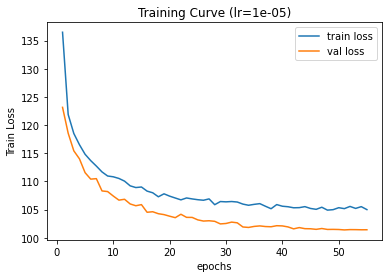

In [12]:
plt.plot(range(1, n_trained_epochs+1), train_avg_loss, label="train loss")
plt.plot(range(1, n_trained_epochs+1), val_avg_loss, label="val loss")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train Loss")
plt.legend(loc="best")
plt.show()

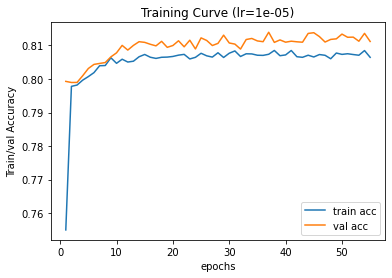

In [13]:
plt.plot(range(1, n_trained_epochs+1), train_avg_acc, label="train acc")
plt.plot(range(1, n_trained_epochs+1), val_avg_acc, label="val acc")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train/val Accuracy")
plt.legend(loc="best")
plt.show()

## Evaluation on the test dataset

In [15]:

############ test eval metrics ######################
test_true_labels = []
test_predict_labels = []
test_loss = []
test_acc = []
test_prec = []
test_rec = []
test_f1 = []

########################################################
for batch in tqdm(test_loader):
    batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
    t_input_ids, t_input_mask, t_token_type_ids, t_labels, t_bio_tags = batch     # unpack inputs from dataloader


    # crf in model requires to start with a positive mask label => ignore first token [CLS]
    t_mask_tags_without_CLS = torch.cat([t_bio_tags[i][1:] != -100 for i in range(len(t_bio_tags))]).view(t_bio_tags.shape[0],-1).byte() # byte() casts boolean tensor to tensor with 1 and 0         
    t_bio_tags_without_CLS = torch.cat([t_bio_tags[i][1:] for i in range(len(t_bio_tags))]).view(t_bio_tags.shape[0],-1)

    with torch.no_grad(): # tell model not to compute or store gradients -> saves memory + speeds up validation
        model.eval() # put model in evaluation mode for validation set
        #logits = model(**{"input_ids":v_input_ids, "attention_mask":v_input_mask, "token_type_ids":v_token_type_ids}) # forward pass, calculates logit predictions
        log_likelihood, sequence_of_tags = model(**{"input_ids":t_input_ids
                                                , "attention_mask":t_input_mask
                                                , "token_type_ids":t_token_type_ids
                                                , "tags": t_bio_tags
                                                , "mask_tags_without_CLS":t_mask_tags_without_CLS}) # forward pass, calculates logit predictions

    ######################################################

    t_loss = -1 * log_likelihood            
    test_loss.append(t_loss.item())

    #########################################################

    # calculate performance measures only on tokens and not subwords or special tokens                        
    t_bio_tags_without_CLS = t_bio_tags_without_CLS.detach().to("cpu").numpy()
    t_mask_tags_without_CLS = t_mask_tags_without_CLS.detach().to("cpu").numpy()

    # typo corrected
    true_tags = t_bio_tags_without_CLS[t_mask_tags_without_CLS.astype(bool)] # get Bio tags for tokens only
    pred = [item for elem in sequence_of_tags for item in elem] # flatten list of lists

    test_true_labels.append(true_tags) # appends true labels for batch
    test_predict_labels.append(pred) # # appends predicted labels for batch
    
    metrics = compute_metrics(pred, true_tags)
    test_acc.append(metrics["accuracy"])
    test_prec.append(metrics["precision"])
    test_rec.append(metrics["recall"])
    test_f1.append(metrics["f1"])


print(F'\n\tTest Loss: {np.mean(test_loss)}')
print(F'\n\tTest acc: {np.mean(test_acc)}')
print(F'\n\tTest prec: {np.mean(test_prec)}')
print(F'\n\tTest rec: {np.mean(test_rec)}')
print(F'\n\tTest f1: {np.mean(test_f1)}')


  0%|          | 0/27 [00:00<?, ?it/s]<ipython-input-6-a7b5e9115285>:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
100%|██████████| 27/27 [00:03<00:00,  7.48it/s]


	Test Loss: 98.44011758874964

	Test acc: 0.8190993372213038

	Test prec: 0.7276452597972863

	Test rec: 0.8190993372213038

	Test f1: 0.7564444574246237


### Classification reports

In [16]:



test_true_tag = [id2tag[ID] for ID in np.concatenate(test_true_labels)]#
test_predict_tag = [id2tag[ID] for ID in np.concatenate(test_predict_labels)]
print(classification_report(test_true_tag, test_predict_tag))

              precision    recall  f1-score   support

         I-C       0.59      0.20      0.29       495
         I-E       0.00      0.00      0.00       487
           O       0.83      0.99      0.90      4159

    accuracy                           0.82      5141
   macro avg       0.47      0.39      0.40      5141
weighted avg       0.73      0.82      0.76      5141



In [17]:
#The metrics we are seeing in this report are designed specifically for NLP tasks such as NER and POS tagging,
#in which all words of an entity need to be predicted correctly to be counted as one correct prediction. 
#Therefore, the metrics in this classification report are much lower than in scikit-learn's classification report.
test_true_tag = [[id2tag[ID] for ID in IDS] for IDS in test_true_labels]
test_predict_tag = [[id2tag[ID] for ID in IDS] for IDS in test_predict_labels]
print(classification_report_seqeval(test_true_tag, test_predict_tag))

              precision    recall  f1-score   support

           C       0.33      0.22      0.27       241
           E       0.00      0.00      0.00       237

   micro avg       0.33      0.11      0.17       478
   macro avg       0.16      0.11      0.13       478
weighted avg       0.17      0.11      0.13       478



/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Example: see predictions

In [18]:
# take last batch of test set:
t_input_ids, t_input_mask, t_token_type_ids, t_labels, t_bio_tags = batch 

for i in range(len(batch)):
    tags_mask = t_bio_tags[i].to("cpu").numpy() != -100 # only get token labels and not labels from subwords or special tokens
    pred = np.argmax(logits[i], axis=1)[tags_mask]
    true_tags = t_bio_tags[i][tags_mask].to("cpu").numpy()    
    

    tokens = tokenizer.convert_ids_to_tokens(t_input_ids[i])
 
    print("\n\nPadded Sentence:")
    print(tokens)
    print("true labels:")
    print(t_bio_tags[i], "-> ", id2tag[t_bio_tags[i]])
    for token, true_label, pred in zip(np.array(tokens)[tags_mask], true_tags, pred):
        print(token, "\t\ttrue:", true_label, "  pred:", pred)

    
    break




NameError: name 'logits' is not defined